In [1]:
from dataclasses import dataclass
import scipy.io
from scipy.sparse import csc_matrix
import numpy as np


@dataclass
class MeshHyperelasticity3D:
    # mesh attributes
    dim: int
    level: int
    nn: int
    ne: int
    elems2nodes: np.ndarray
    nodes2coord: np.ndarray
    volumes: np.ndarray
    dphi: list
    Hstr: csc_matrix
    nodesDirichlet: list
    nodesMinim: np.ndarray
    dofsDirichlet: np.ndarray
    dofsMinim: np.ndarray
    dofsMinim_local: np.ndarray
    bfaces2elems: np.ndarray
    bfaces2nodes: np.ndarray

    # params attributes
    lx: float
    ly: float
    lz: float
    E: float
    nu: float
    turning: int
    timeSteps: int
    # draw: list
    visualizeLevels: np.ndarray
    showFullDirichlet: int
    showDirichletTwo: int
    showDirichletOne: int
    # graphs: list
    azimuth: int
    elevation: int
    freq: int
    animations_count: int
    delay: float
    delay_first: float
    delay_last: float
    epsFDSS: float
    max_iters: int
    disp: str
    tf: float
    nbfn: int
    T: int
    lambda_: float
    mu: float
    K: float
    C1: float
    D1: float
    evaluation: int


def load_mesh_hyperelasticity_3d(level: int) -> MeshHyperelasticity3D:
    filename = f"hyperelasticity_mesh_level_{level}.mat"
    data = scipy.io.loadmat(filename)

    # Extracting mesh and params from the loaded data
    mesh_data = data['mesh'][0, 0]
    params_data = data['params'][0, 0]

    # Creating and returning the MeshHyperelasticity3D instance
    return MeshHyperelasticity3D(
        # mesh attributes
        dim=mesh_data[0][0, 0],
        level=mesh_data[1][0, 0],
        nn=mesh_data[2][0, 0],
        ne=mesh_data[3][0, 0],
        elems2nodes=mesh_data[4] - 1,
        nodes2coord=mesh_data[5],
        volumes=mesh_data[6],
        dphi=mesh_data[7][0].tolist(),
        Hstr=mesh_data[8],
        nodesDirichlet=[arr - 1 for arr in mesh_data[9][0].tolist()],
        nodesMinim=mesh_data[10] - 1,
        dofsDirichlet=mesh_data[11] - 1,
        dofsMinim=mesh_data[12] - 1,
        dofsMinim_local=mesh_data[13] - 1,
        bfaces2elems=mesh_data[14] - 1,
        bfaces2nodes=mesh_data[15] - 1,
        # params attributes
        lx=params_data[0][0, 0],
        ly=params_data[1][0, 0],
        lz=params_data[2][0, 0],
        E=params_data[3][0, 0],
        nu=params_data[4][0, 0],
        turning=params_data[5][0, 0],
        timeSteps=params_data[6][0, 0],
        # draw=params_data[7].tolist(),
        visualizeLevels=params_data[8],
        showFullDirichlet=params_data[9][0, 0],
        showDirichletTwo=params_data[10][0, 0],
        showDirichletOne=params_data[11][0, 0],
        # graphs=params_data[12].tolist(),
        azimuth=params_data[13][0, 0],
        elevation=params_data[14][0, 0],
        freq=params_data[15][0, 0],
        animations_count=params_data[16][0, 0],
        delay=params_data[17][0, 0],
        delay_first=params_data[18][0, 0],
        delay_last=params_data[19][0, 0],
        epsFDSS=params_data[20][0, 0],
        max_iters=params_data[21][0, 0],
        disp=params_data[22][0],
        tf=params_data[23][0, 0],
        nbfn=params_data[24][0, 0],
        T=params_data[25][0, 0],
        lambda_=params_data[26][0, 0],
        mu=params_data[27][0, 0],
        K=params_data[28][0, 0],
        C1=params_data[29][0, 0],
        D1=params_data[30][0, 0],
        evaluation=params_data[31][0, 0]
    )


# Example usage:
level = 2
data = load_mesh_hyperelasticity_3d(level)
print(data.elems2nodes.shape)
print(data.nodes2coord.shape)
print(data.volumes.shape)

(15360, 4)
(4025, 3)
(15360, 1)


In [2]:
from jax import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp


def energy(u, u0, dofsMinim, elems2nodes, dphix, dphiy, dphiz, vol, C1, D1):
    v = jnp.array(u0, dtype=jnp.float64)
    v = v.at[dofsMinim].set(u)
    vx = v[0::3][elems2nodes]
    vy = v[1::3][elems2nodes]
    vz = v[2::3][elems2nodes]
    
    G11 = jnp.sum(vx * dphix, axis=1)
    G12 = jnp.sum(vx * dphiy, axis=1)
    G13 = jnp.sum(vx * dphiz, axis=1)
    G21 = jnp.sum(vy * dphix, axis=1)
    G22 = jnp.sum(vy * dphiy, axis=1)
    G23 = jnp.sum(vy * dphiz, axis=1)
    G31 = jnp.sum(vz * dphix, axis=1)
    G32 = jnp.sum(vz * dphiy, axis=1)
    G33 = jnp.sum(vz * dphiz, axis=1)
    
    I1 = G11**2 + G12**2 + G13**2 + G21**2 + G22**2 + G23**2 + G31**2 + G32**2 + G33**2
    det = G11 * G22 * G33 - G11 * G23 * G32 - G12 * G21 * G33 + G12 * G23 * G31 + G13 * G21 * G32 - G13 * G22 * G31
    W = C1 * (I1 - 3 - 2 * jnp.log(det)) + D1 * (det - 1)**2
    return jnp.sum(W * vol)
    

In [3]:
u0 = jnp.array(data.nodes2coord, dtype=jnp.float64).ravel()
alpha = -1.047197551196598/2
nodes = np.where(data.nodes2coord[:, 0] == data.lx)[0]
u0 = u0.at[nodes * 3 + 1].set(np.cos(alpha) * data.nodes2coord[nodes, 1] + np.sin(alpha) * data.nodes2coord[nodes, 2])
u0 = u0.at[nodes * 3 + 2].set(-np.sin(alpha) * data.nodes2coord[nodes, 1] + np.cos(alpha) * data.nodes2coord[nodes, 2])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
dofsMinim = jnp.array(data.dofsMinim.ravel())
u = u0[dofsMinim]
elems2nodes = jnp.array(data.elems2nodes)
dphix = jnp.array(data.dphi[0], dtype=jnp.float64)
dphiy = jnp.array(data.dphi[1], dtype=jnp.float64)
dphiz = jnp.array(data.dphi[2], dtype=jnp.float64)
vol = jnp.array(data.volumes.ravel(), dtype=jnp.float64)
C1 = data.C1
D1 = data.D1

In [5]:
# import jaxes jit
from jax import jit, grad
energy_jit = jit(energy)

dfun = jit(grad(energy, argnums=0))

In [6]:
e = energy_jit(u, u0, dofsMinim, elems2nodes, dphix, dphiy, dphiz, vol, C1, D1)
e

Array(8.77600872, dtype=float64)

In [7]:
g = dfun(u, u0, dofsMinim, elems2nodes, dphix, dphiy, dphiz, vol, C1, D1)

In [8]:
import jax


def ff(x):
    return energy_jit(jnp.array(x.ravel()), u0, dofsMinim, elems2nodes, dphix, dphiy, dphiz, vol, C1, D1)
    
def dff(x):
    g = dfun(jnp.array(x.ravel()), u0, dofsMinim, elems2nodes, dphix, dphiy, dphiz, vol, C1, D1)
    return np.asfortranarray(np.array(g.ravel()))

In [9]:
# import minimize from scipy
from scipy.optimize import minimize
u_np = np.asfortranarray(np.array(u.ravel()))
x = minimize(ff, np.asfortranarray(np.array(u.ravel())), jac=dff,method='L-BFGS-B', tol=1e-9, options={'maxiter': 100000, 'maxfun': 10000000})
x

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.050676878274822215
        x: [ 2.500e-03 -4.985e-03 ...  1.851e-03  6.824e-03]
      nit: 1367
      jac: [-5.093e-04  2.086e-04 ...  2.502e-04 -3.073e-04]
     nfev: 1419
     njev: 1419
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>

In [10]:
res = u0.at[dofsMinim].set(x.x)


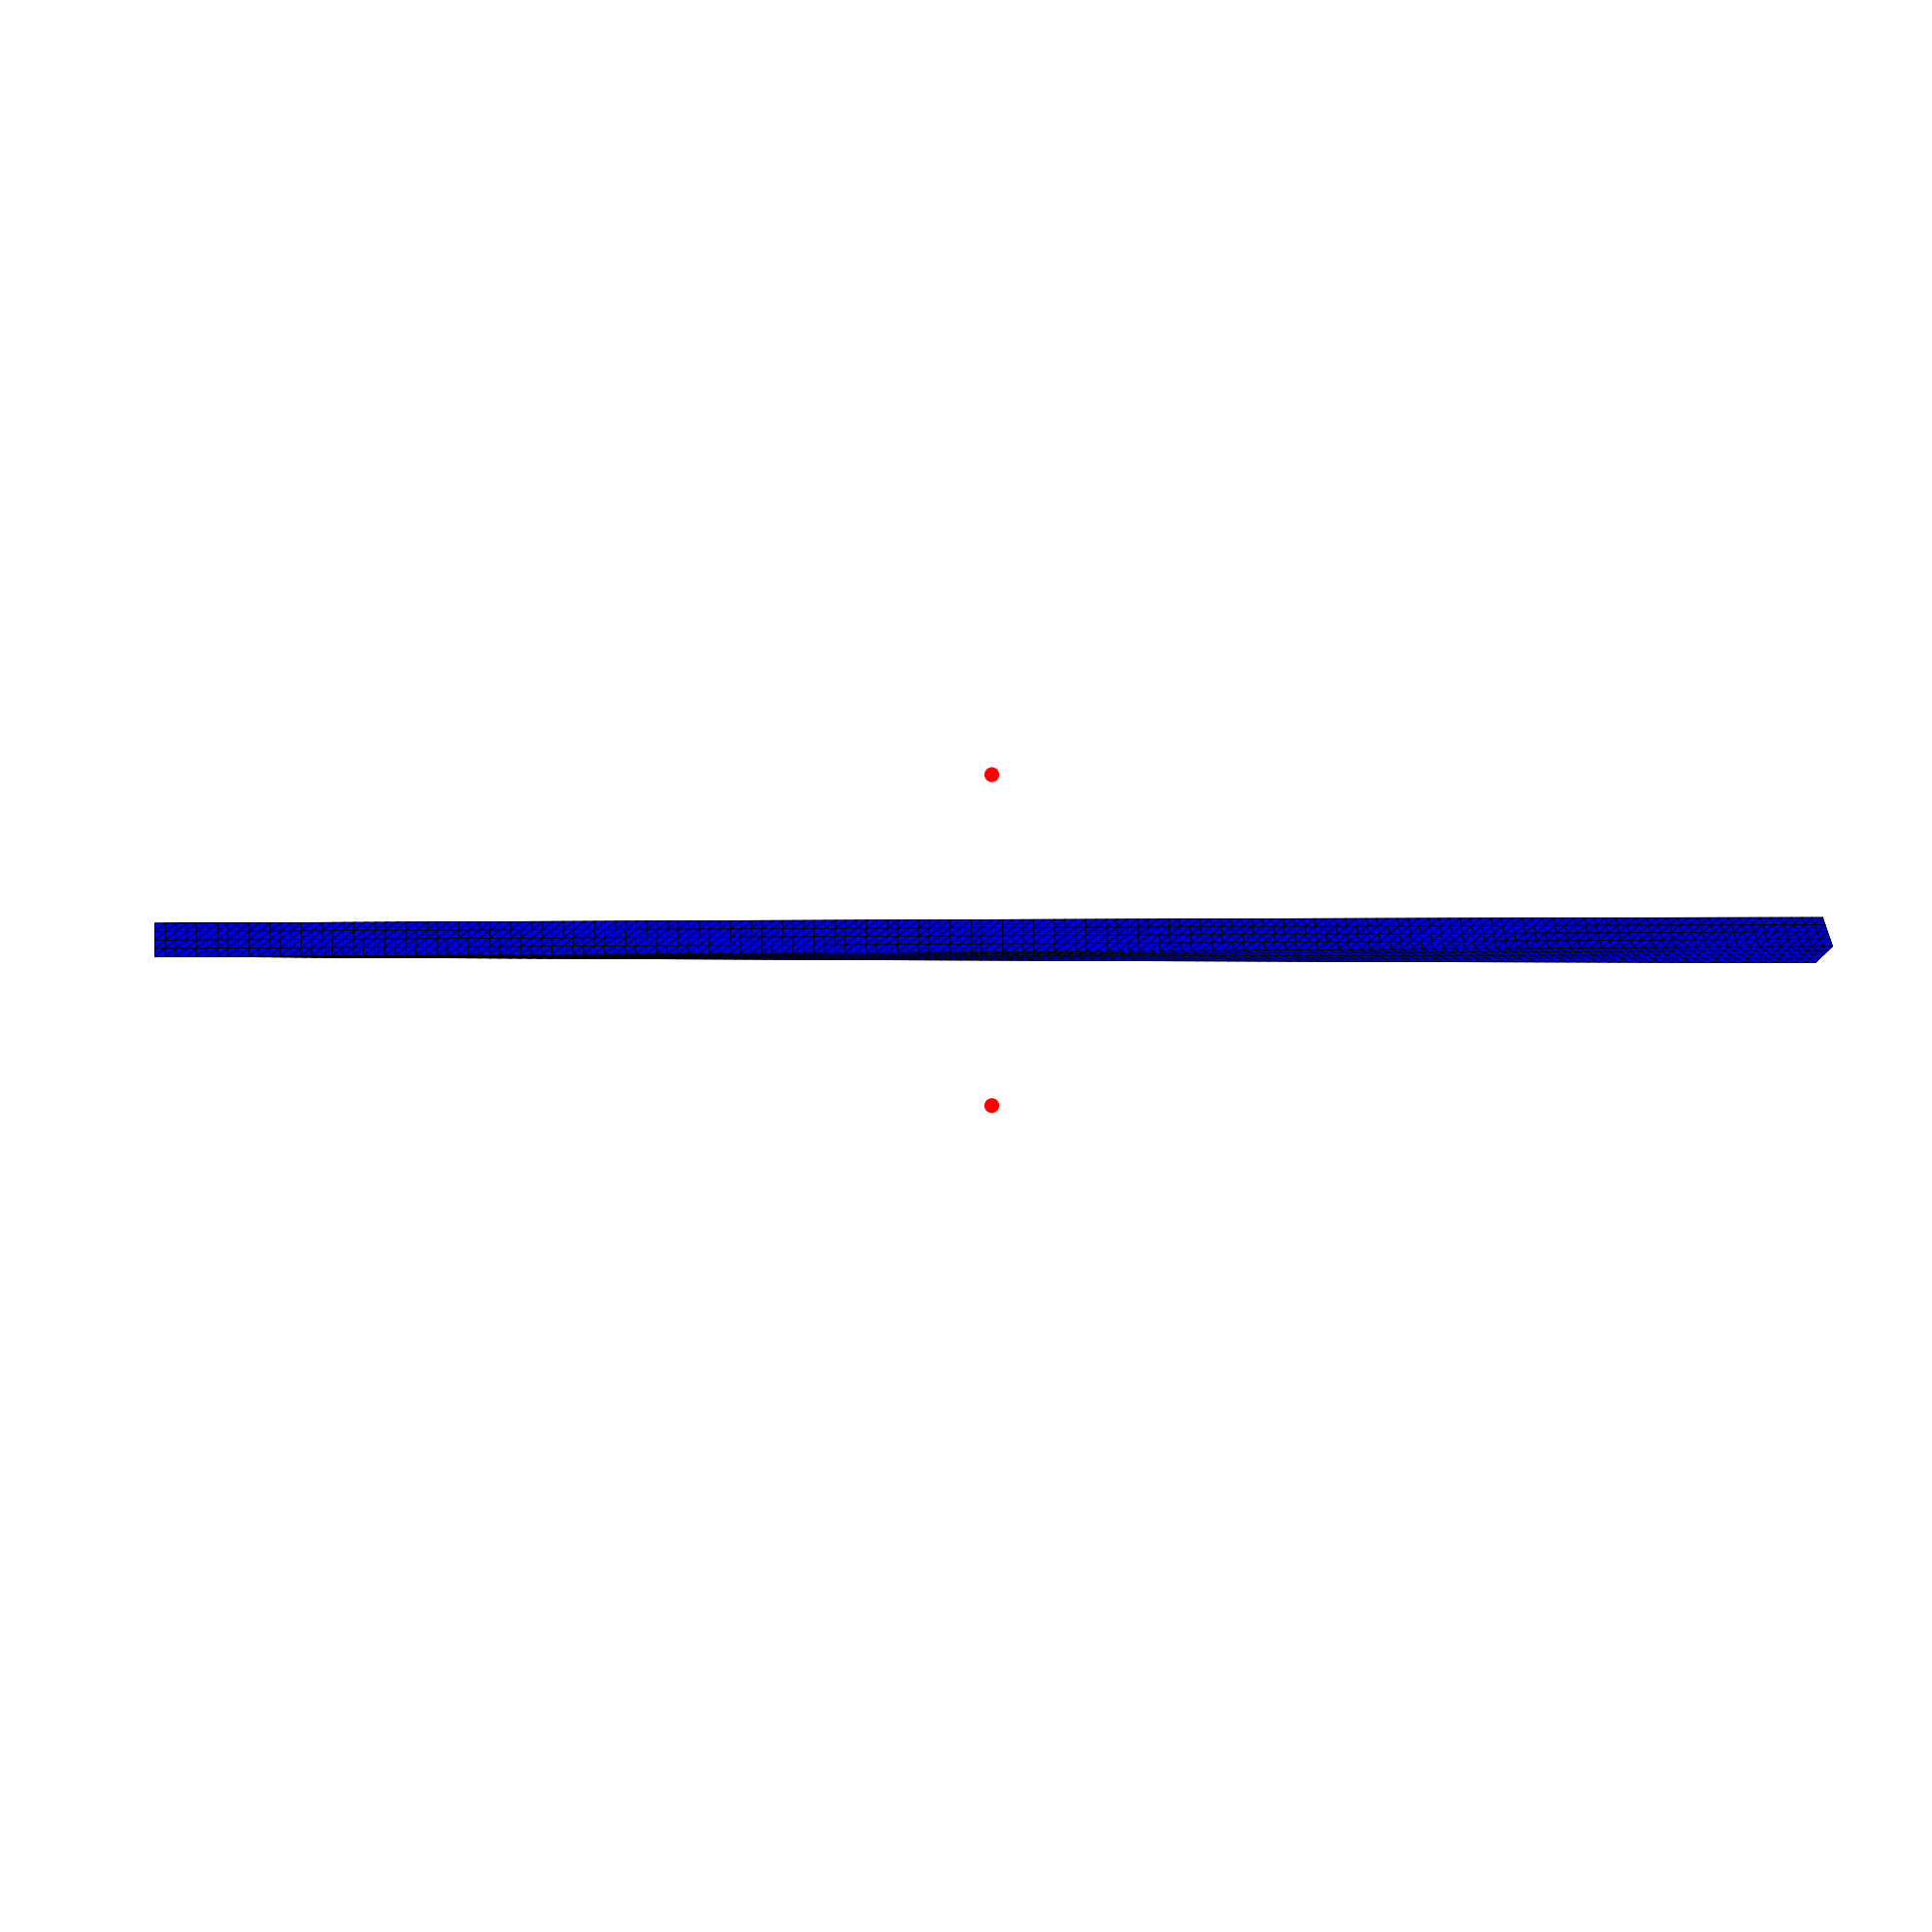

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure
fig = plt.figure(figsize=(20, 20))
ax : Axes3D = fig.add_subplot(projection='3d') # type: ignore


ax.view_init(elev=0, azim=90)

# Plot the wire mesh
ax.plot_trisurf(res[::3], res[1::3], res[2::3], triangles=data.bfaces2nodes, color = "b", edgecolor='k', linewidth=0.5, antialiased=True, shade=True)

# The closest thing to "equal" scaling:
# Scale the axes equally
data_ranges = [np.ptp(a) for a in [res[::3], res[1::3], res[2::3]]]

# using scatter plot plot two 3d points [0.2 0.05 0] AND [0.2 -0.05 0]
ax.scatter([0.2, 0.2], [0, 0],[0.05, -0.05], c='r', s=100)


ax.set_box_aspect([0.4, 0.08, 0.08])  # Aspect ratio is 1:1:1

ax.grid(False)
# Hide the axes spines
ax.set_axis_off()

# Reduce whitespace around the plot and make the layout tight


ax.set_xlim(ax.get_xlim()[::-1])
# ax.set_zlim(ax.get_zlim()[::-1])

plt.tight_layout()
# Show the plot
plt.show()

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.20270768400875344
        x: [ 2.500e-03 -4.970e-03 ... -1.788e-03  6.840e-03]
      nit: 1335
      jac: [ 1.666e-03  1.008e-03 ...  4.151e-04  2.703e-04]
     nfev: 1383
     njev: 1383
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


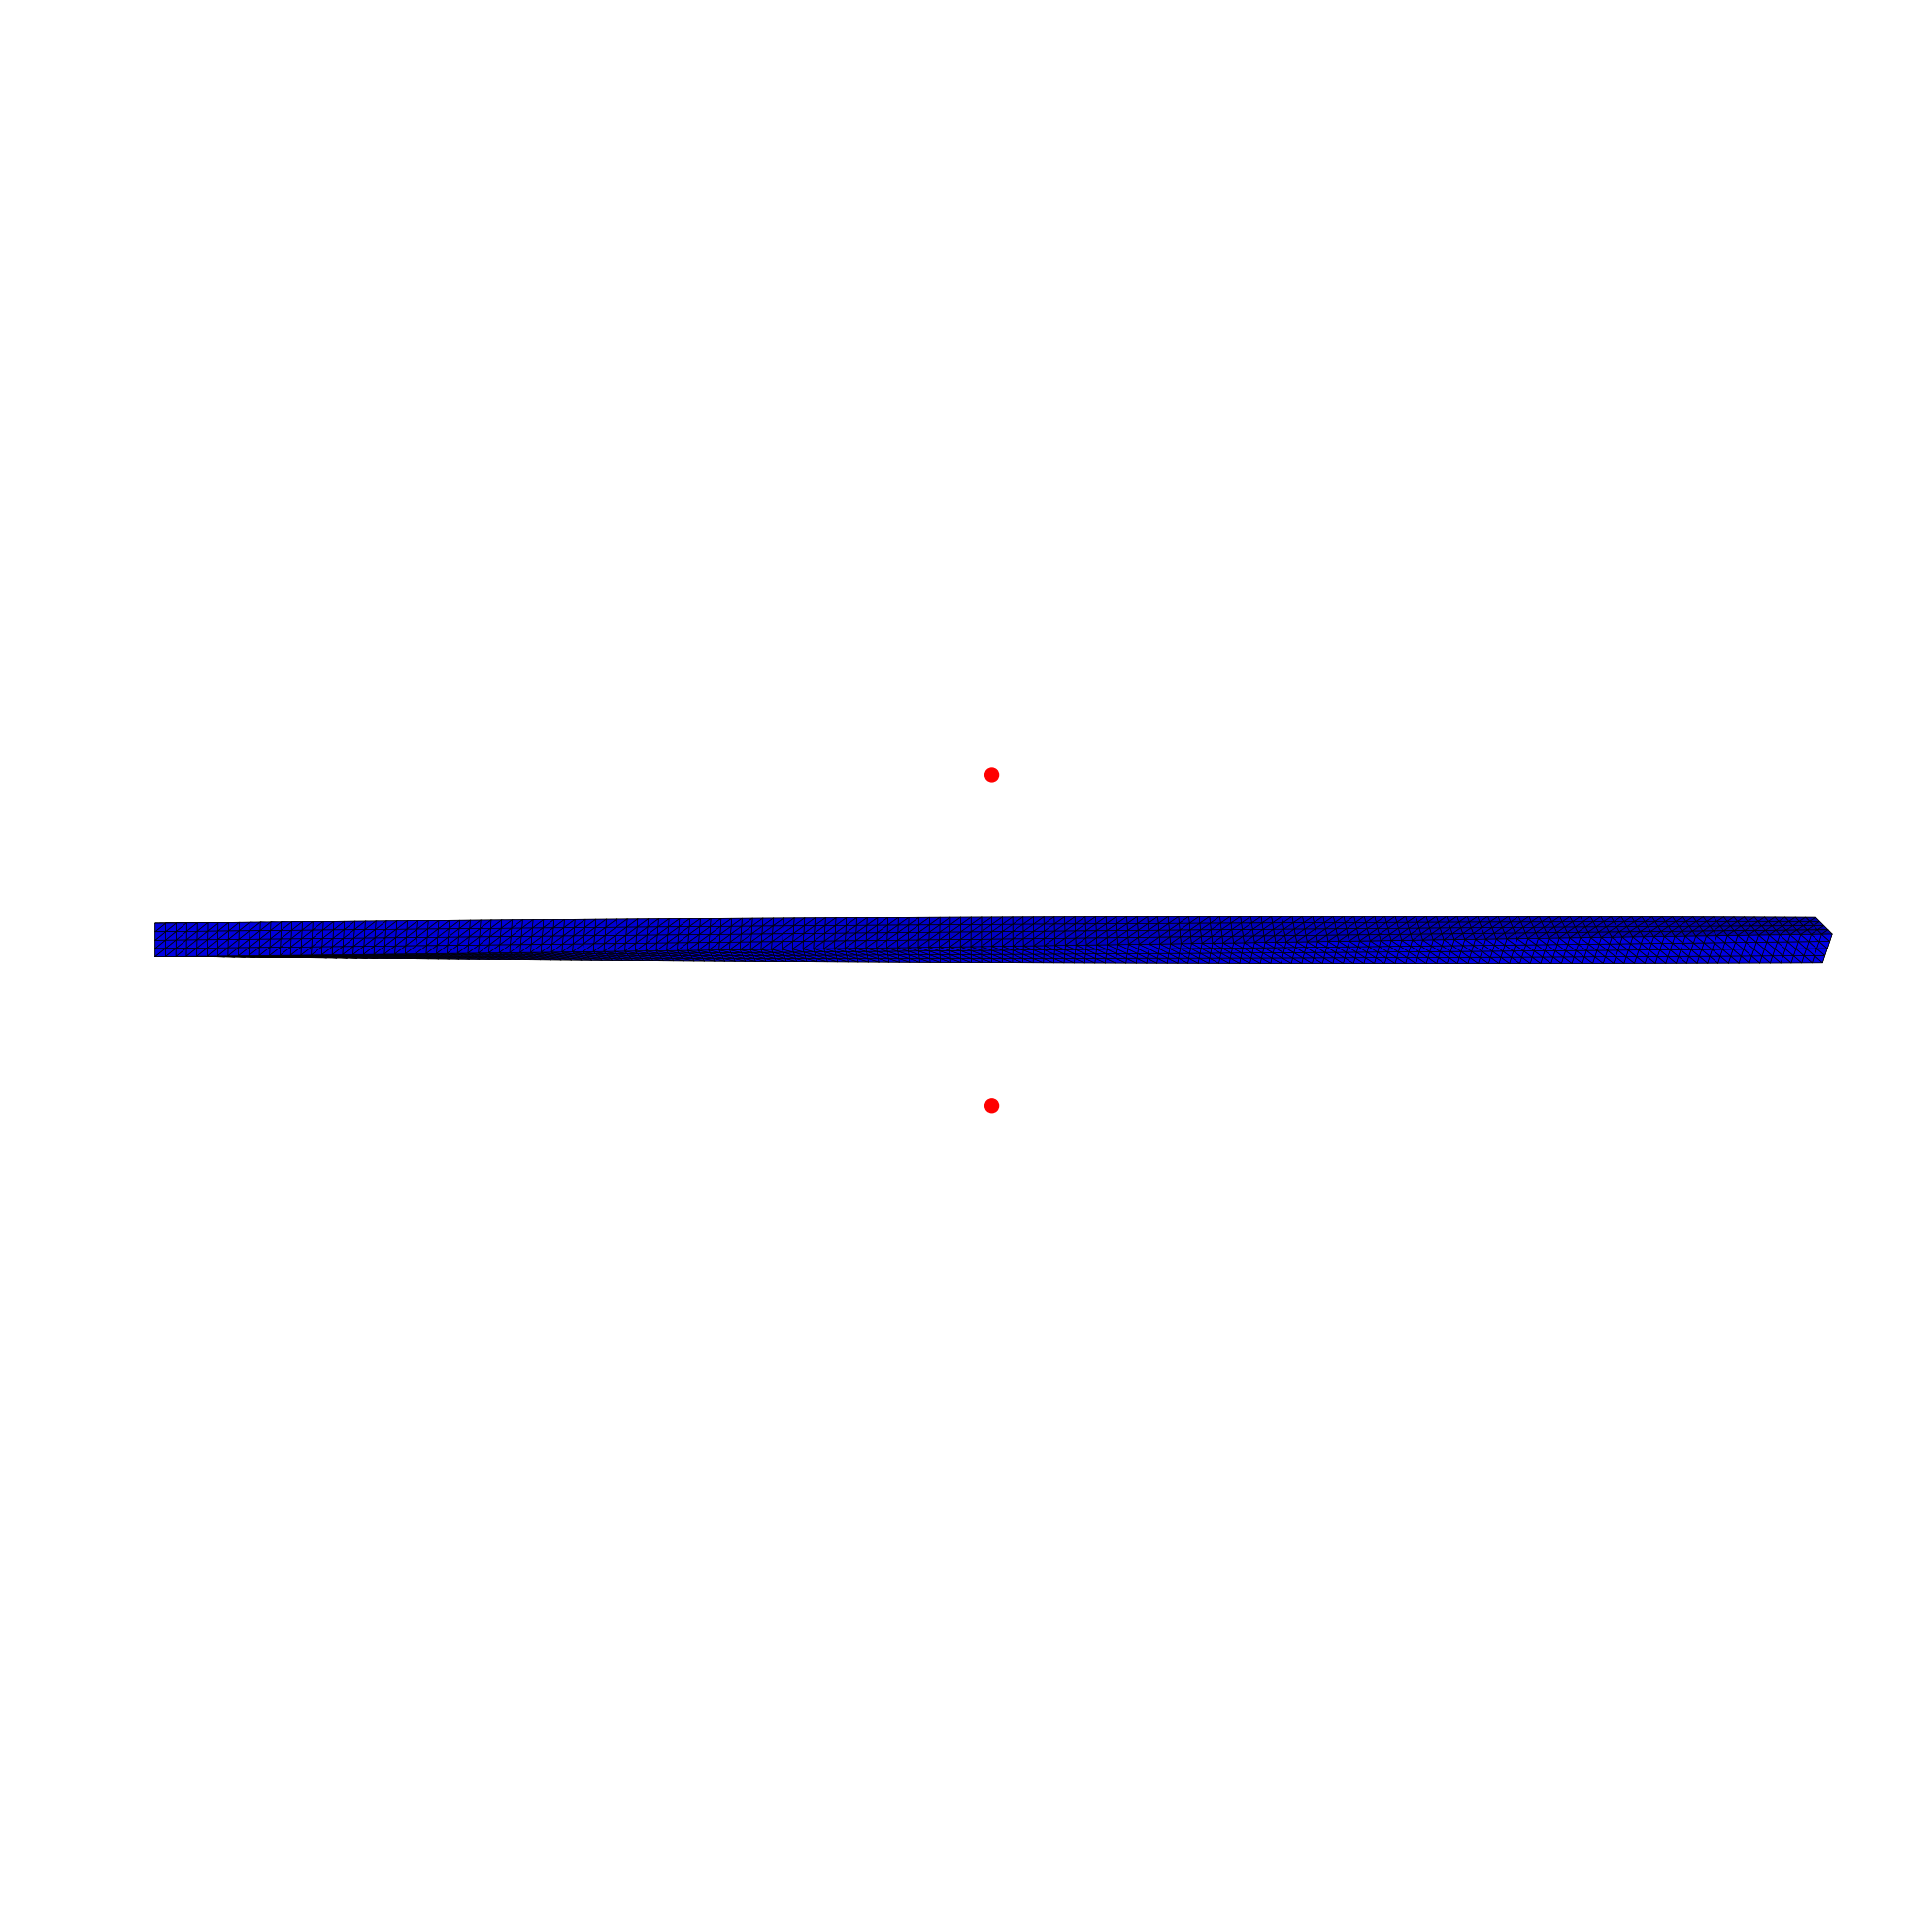

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.4560936439955512
        x: [ 2.500e-03 -4.955e-03 ... -4.952e-03  5.044e-03]
      nit: 1291
      jac: [-5.315e-04 -3.019e-04 ... -3.645e-04 -3.030e-04]
     nfev: 1338
     njev: 1338
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


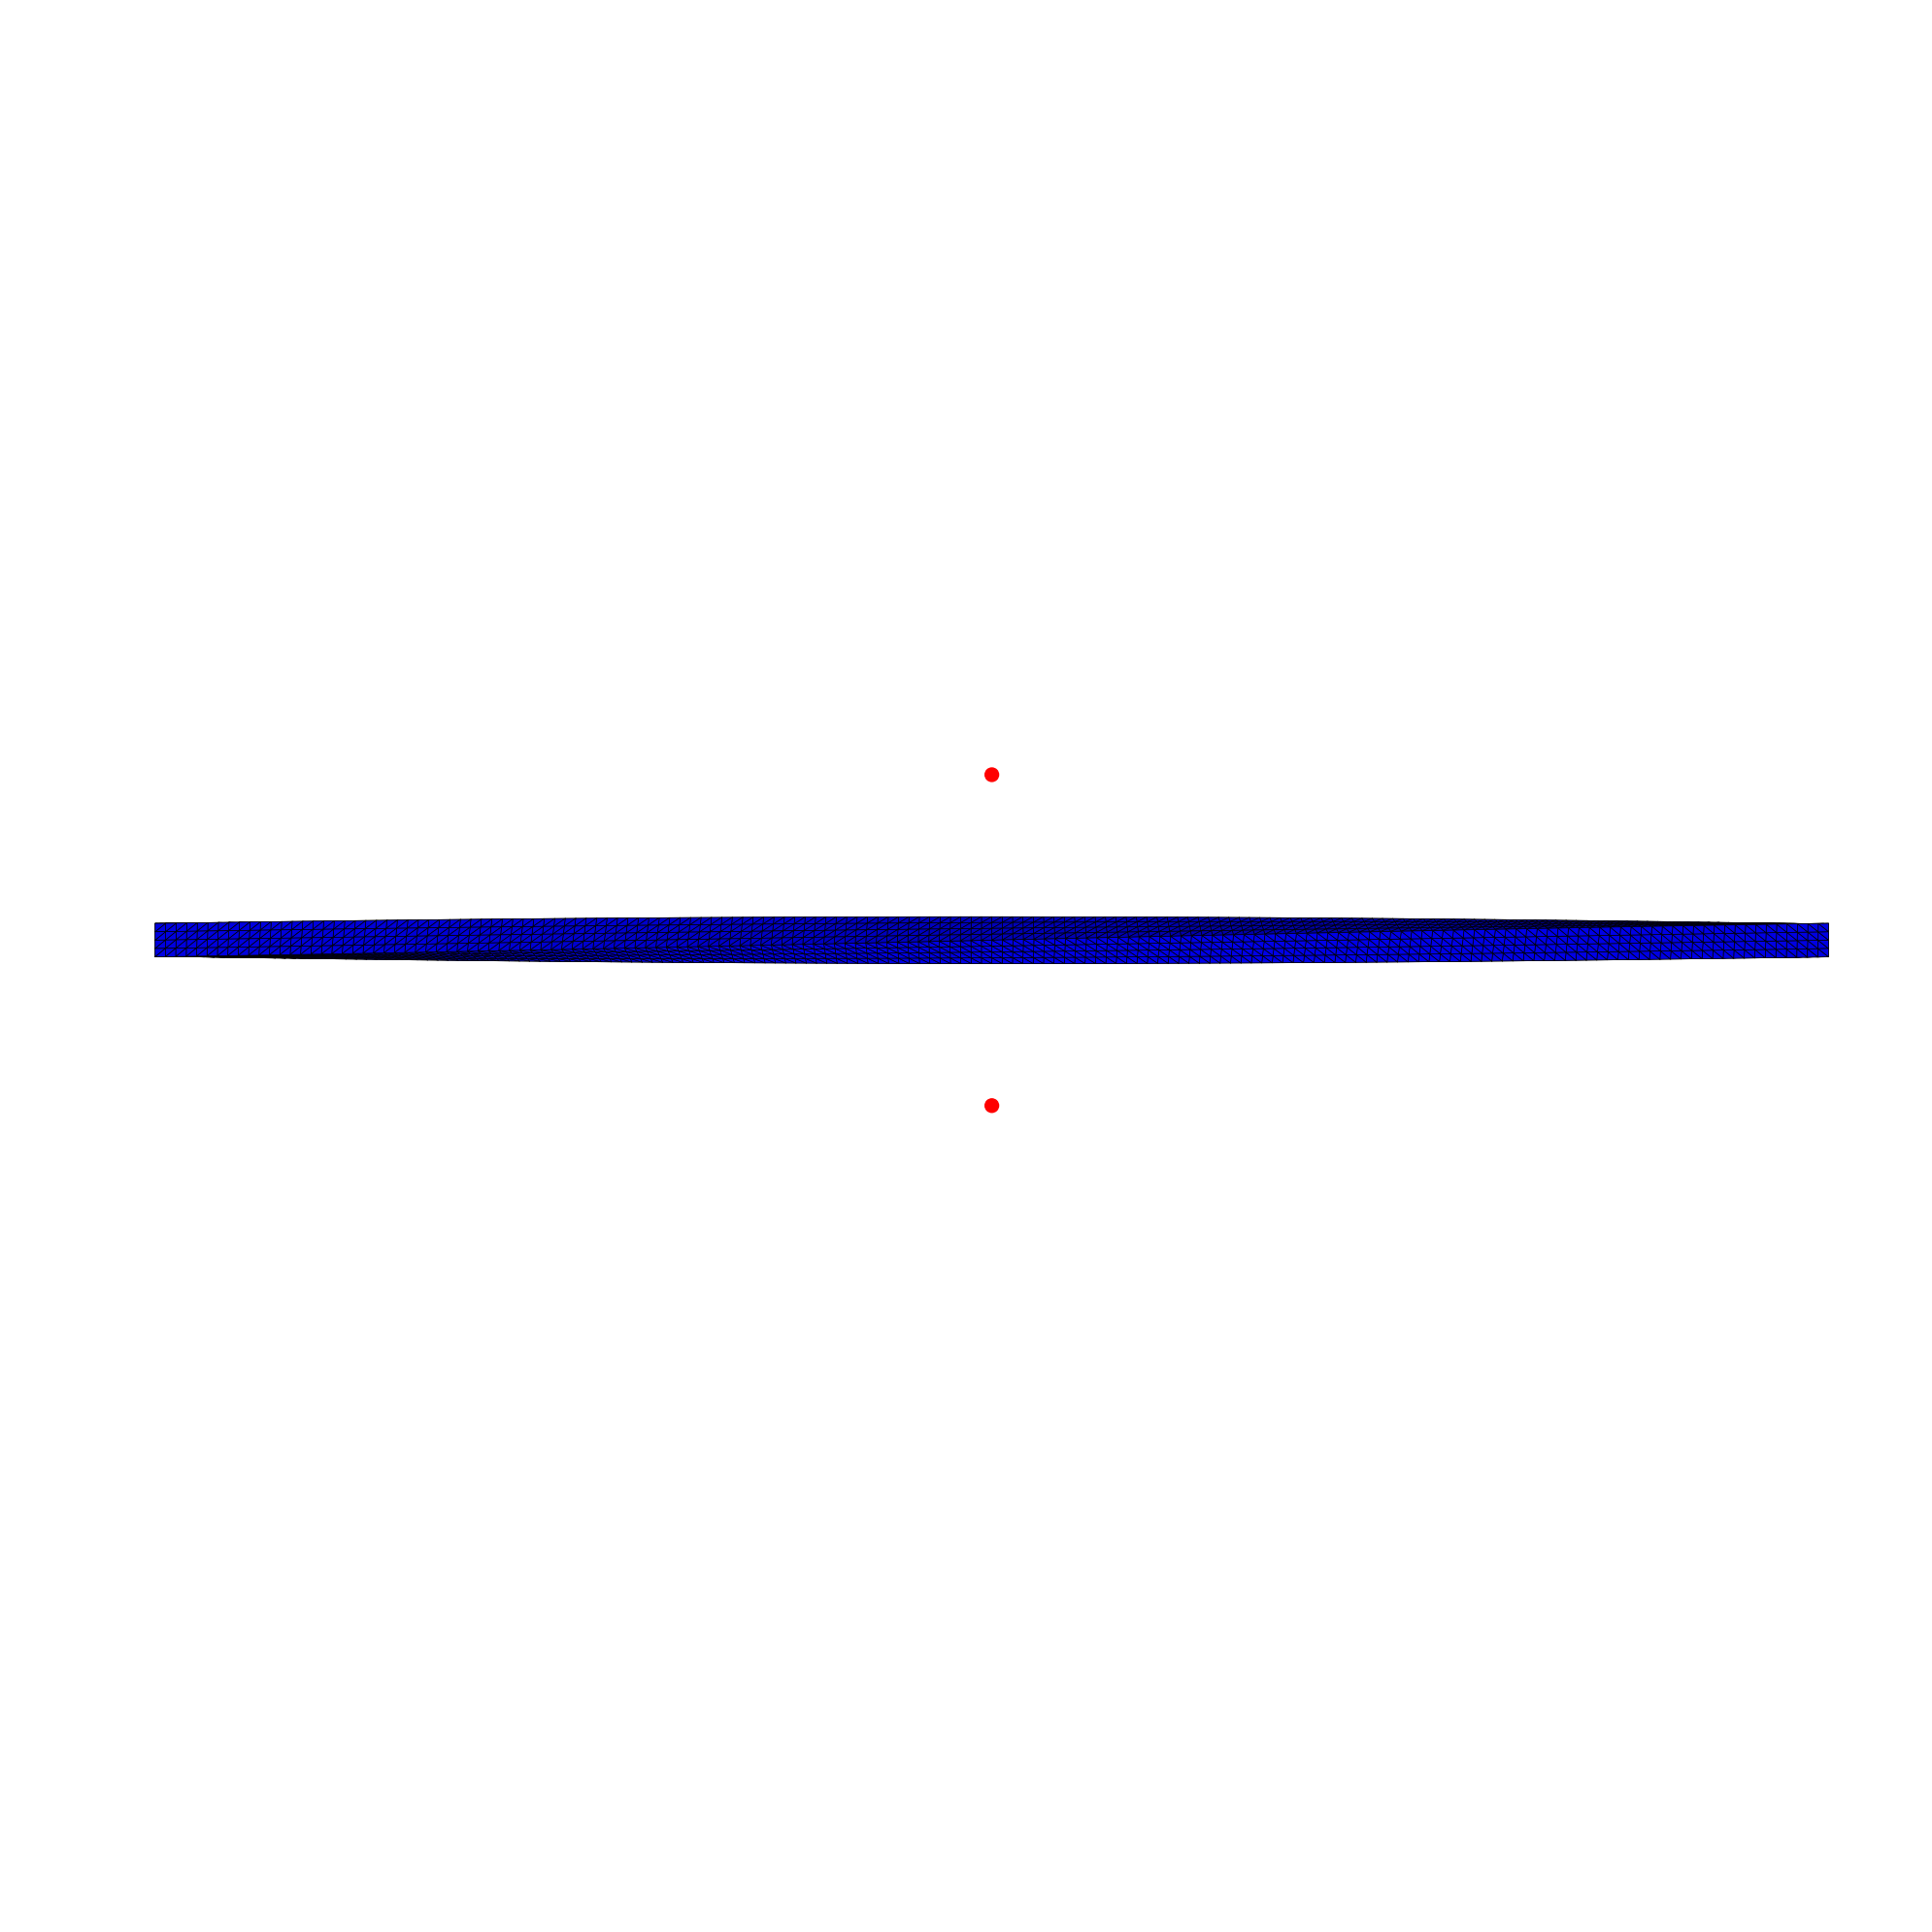

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.8108370782183564
        x: [ 2.500e-03 -4.940e-03 ... -6.804e-03  1.913e-03]
      nit: 1382
      jac: [-4.352e-04 -6.948e-04 ... -4.130e-06  6.644e-04]
     nfev: 1442
     njev: 1442
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


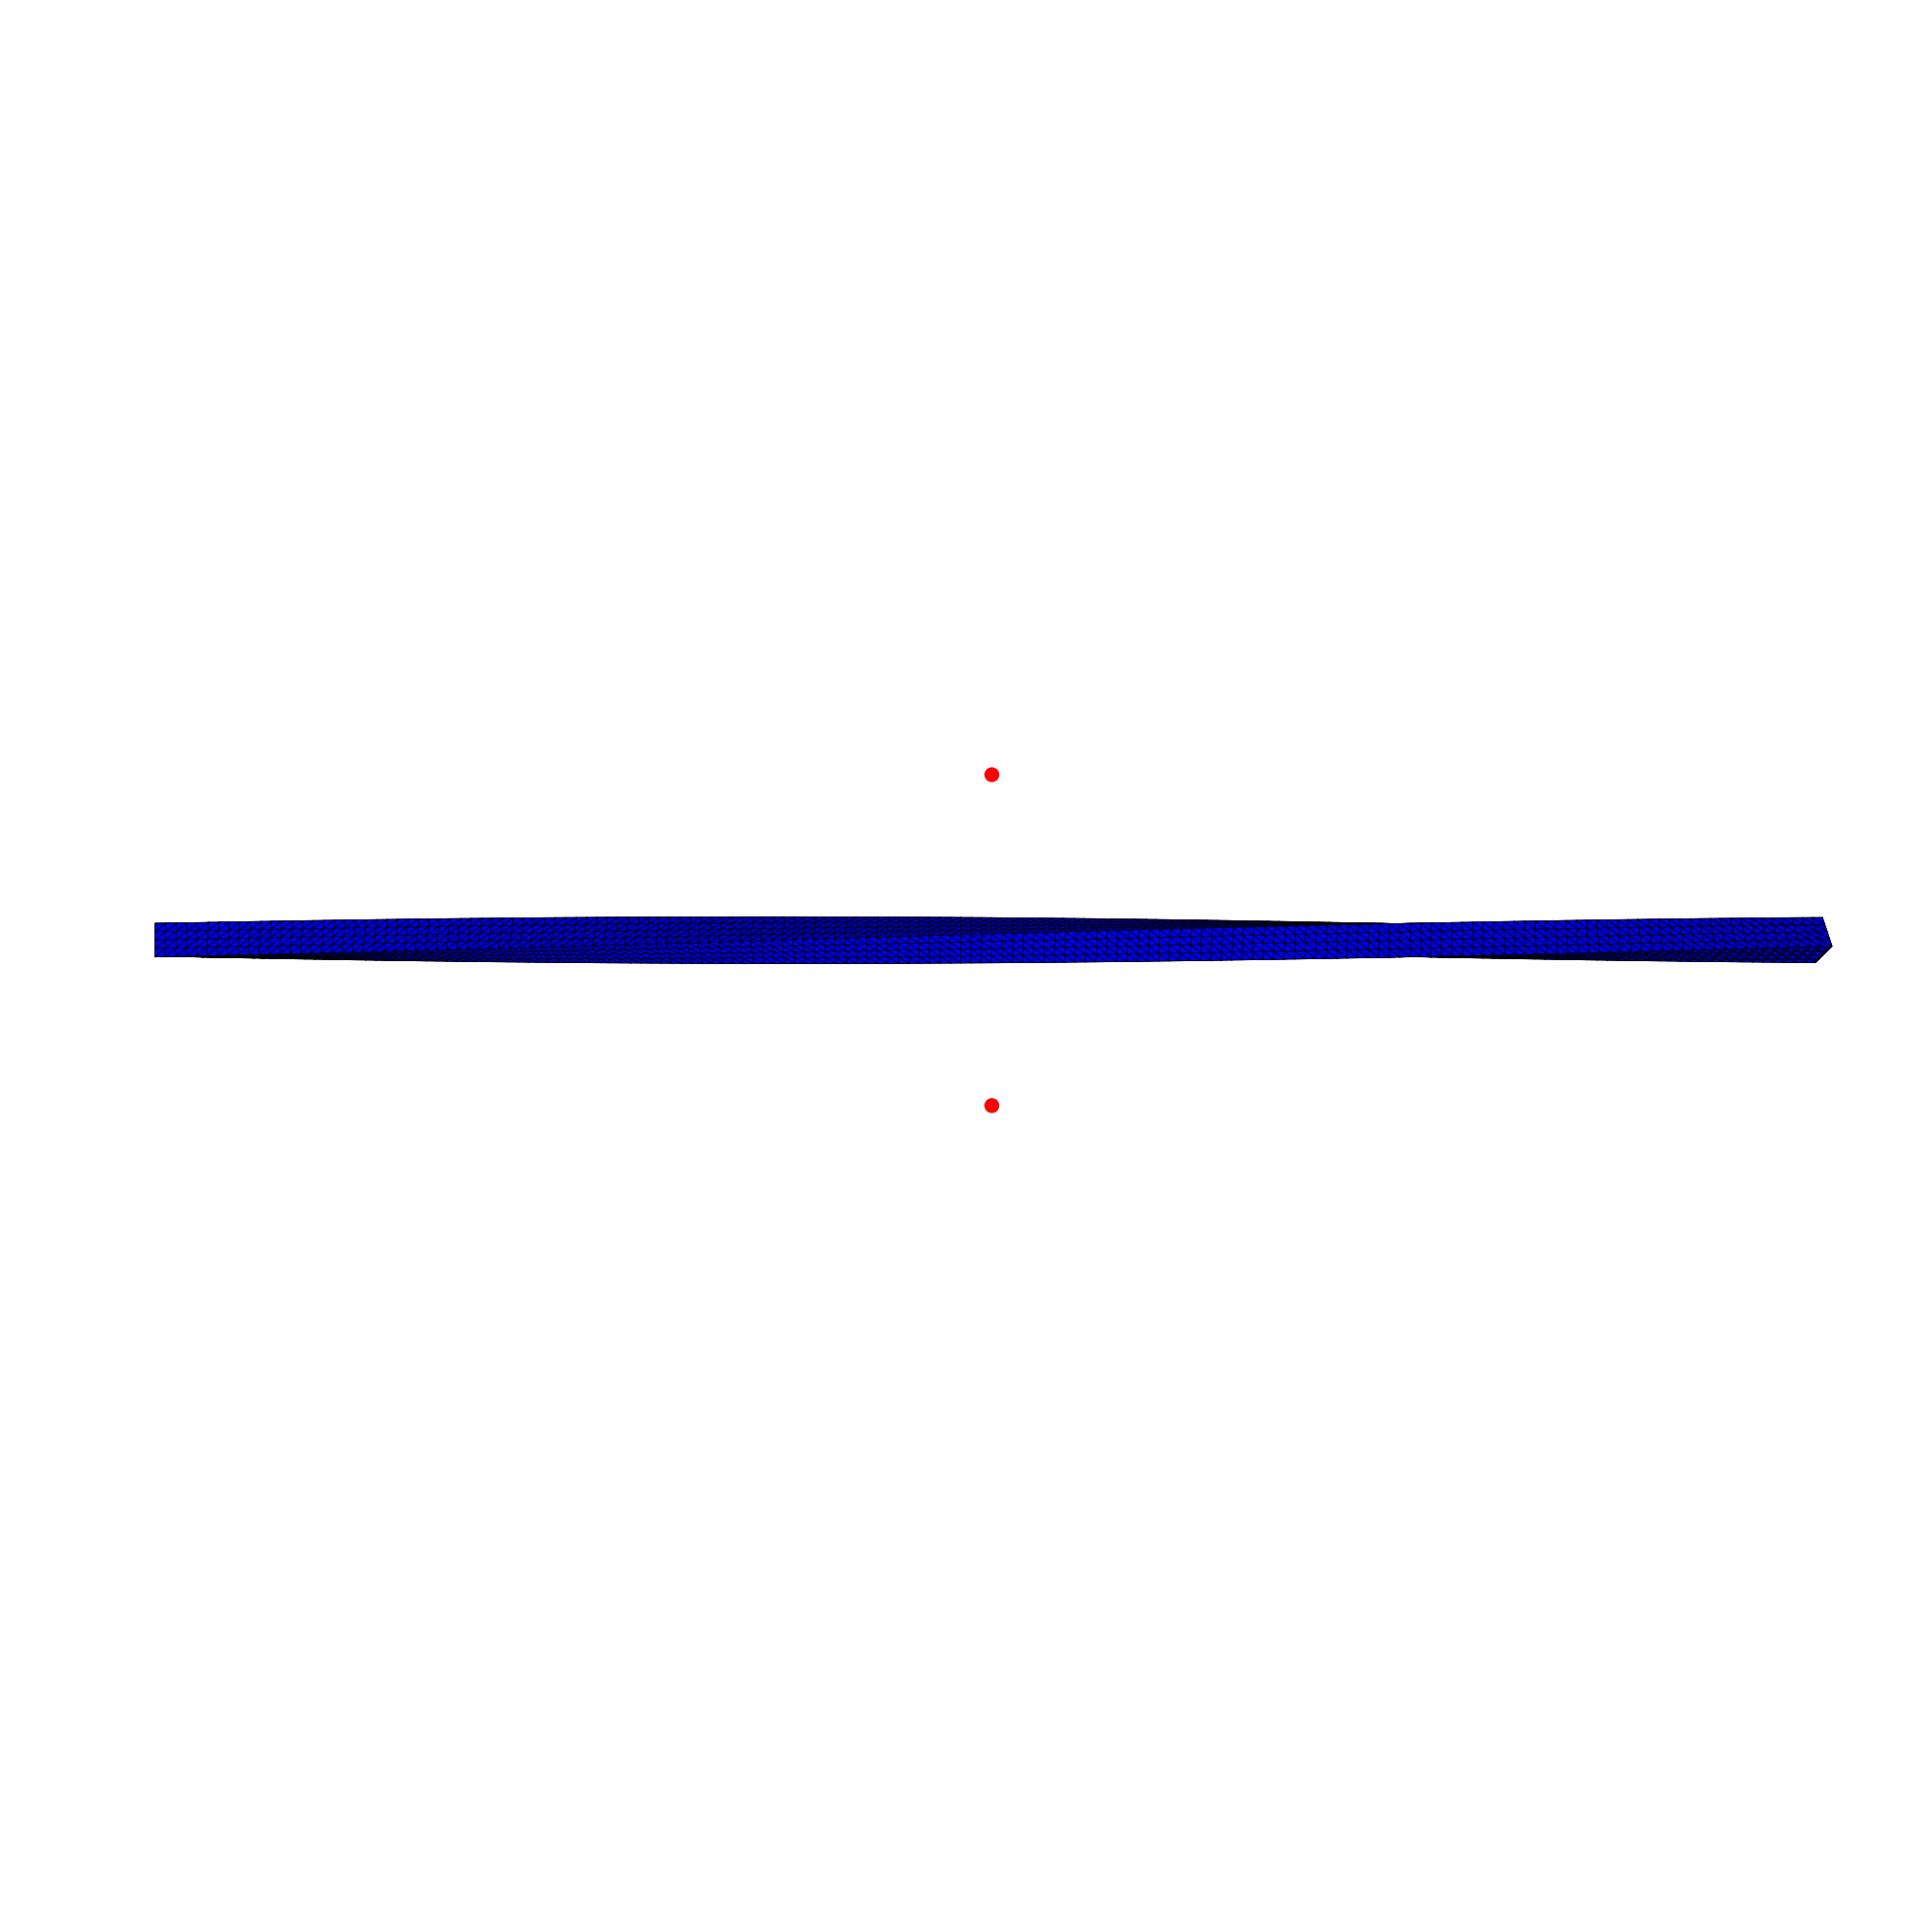

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.2669401212077656
        x: [ 2.501e-03 -4.925e-03 ... -6.853e-03 -1.724e-03]
      nit: 1208
      jac: [ 2.138e-04  5.114e-04 ...  1.252e-04 -8.981e-04]
     nfev: 1251
     njev: 1251
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


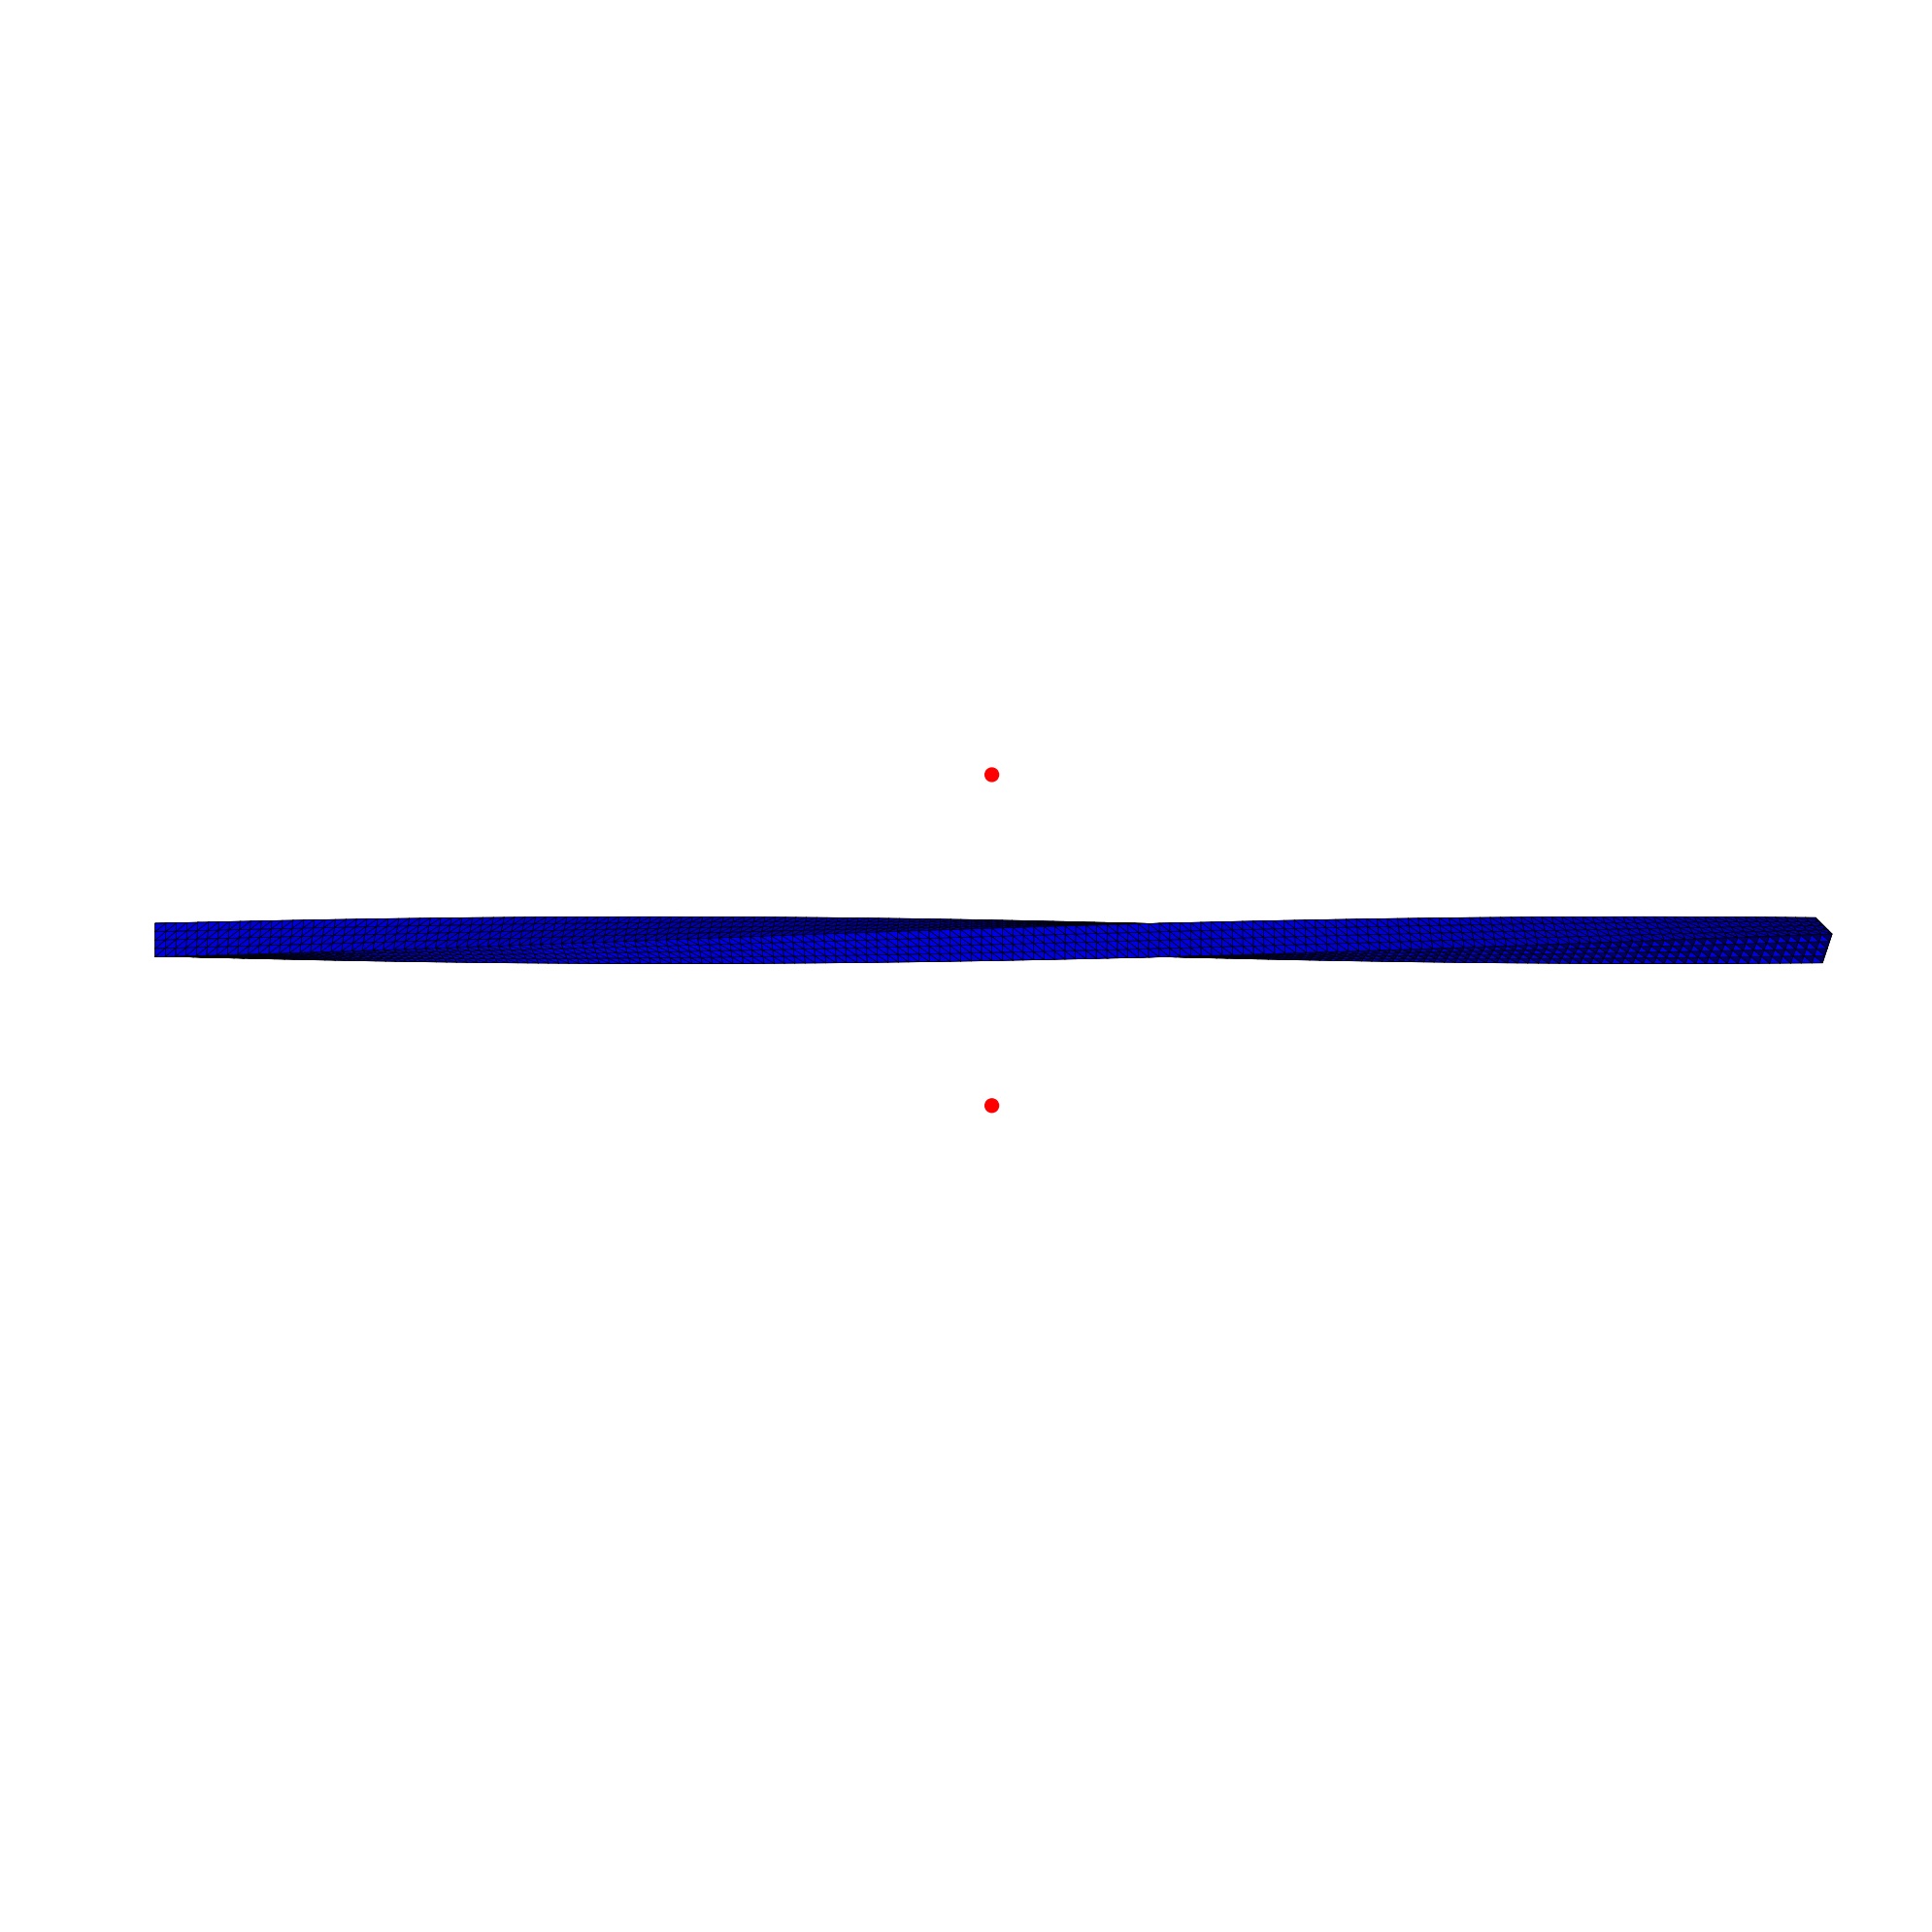

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.824404917164517
        x: [ 2.501e-03 -4.910e-03 ... -5.087e-03 -4.903e-03]
      nit: 1383
      jac: [-4.095e-05  7.529e-04 ... -1.120e-03  1.083e-03]
     nfev: 1424
     njev: 1424
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


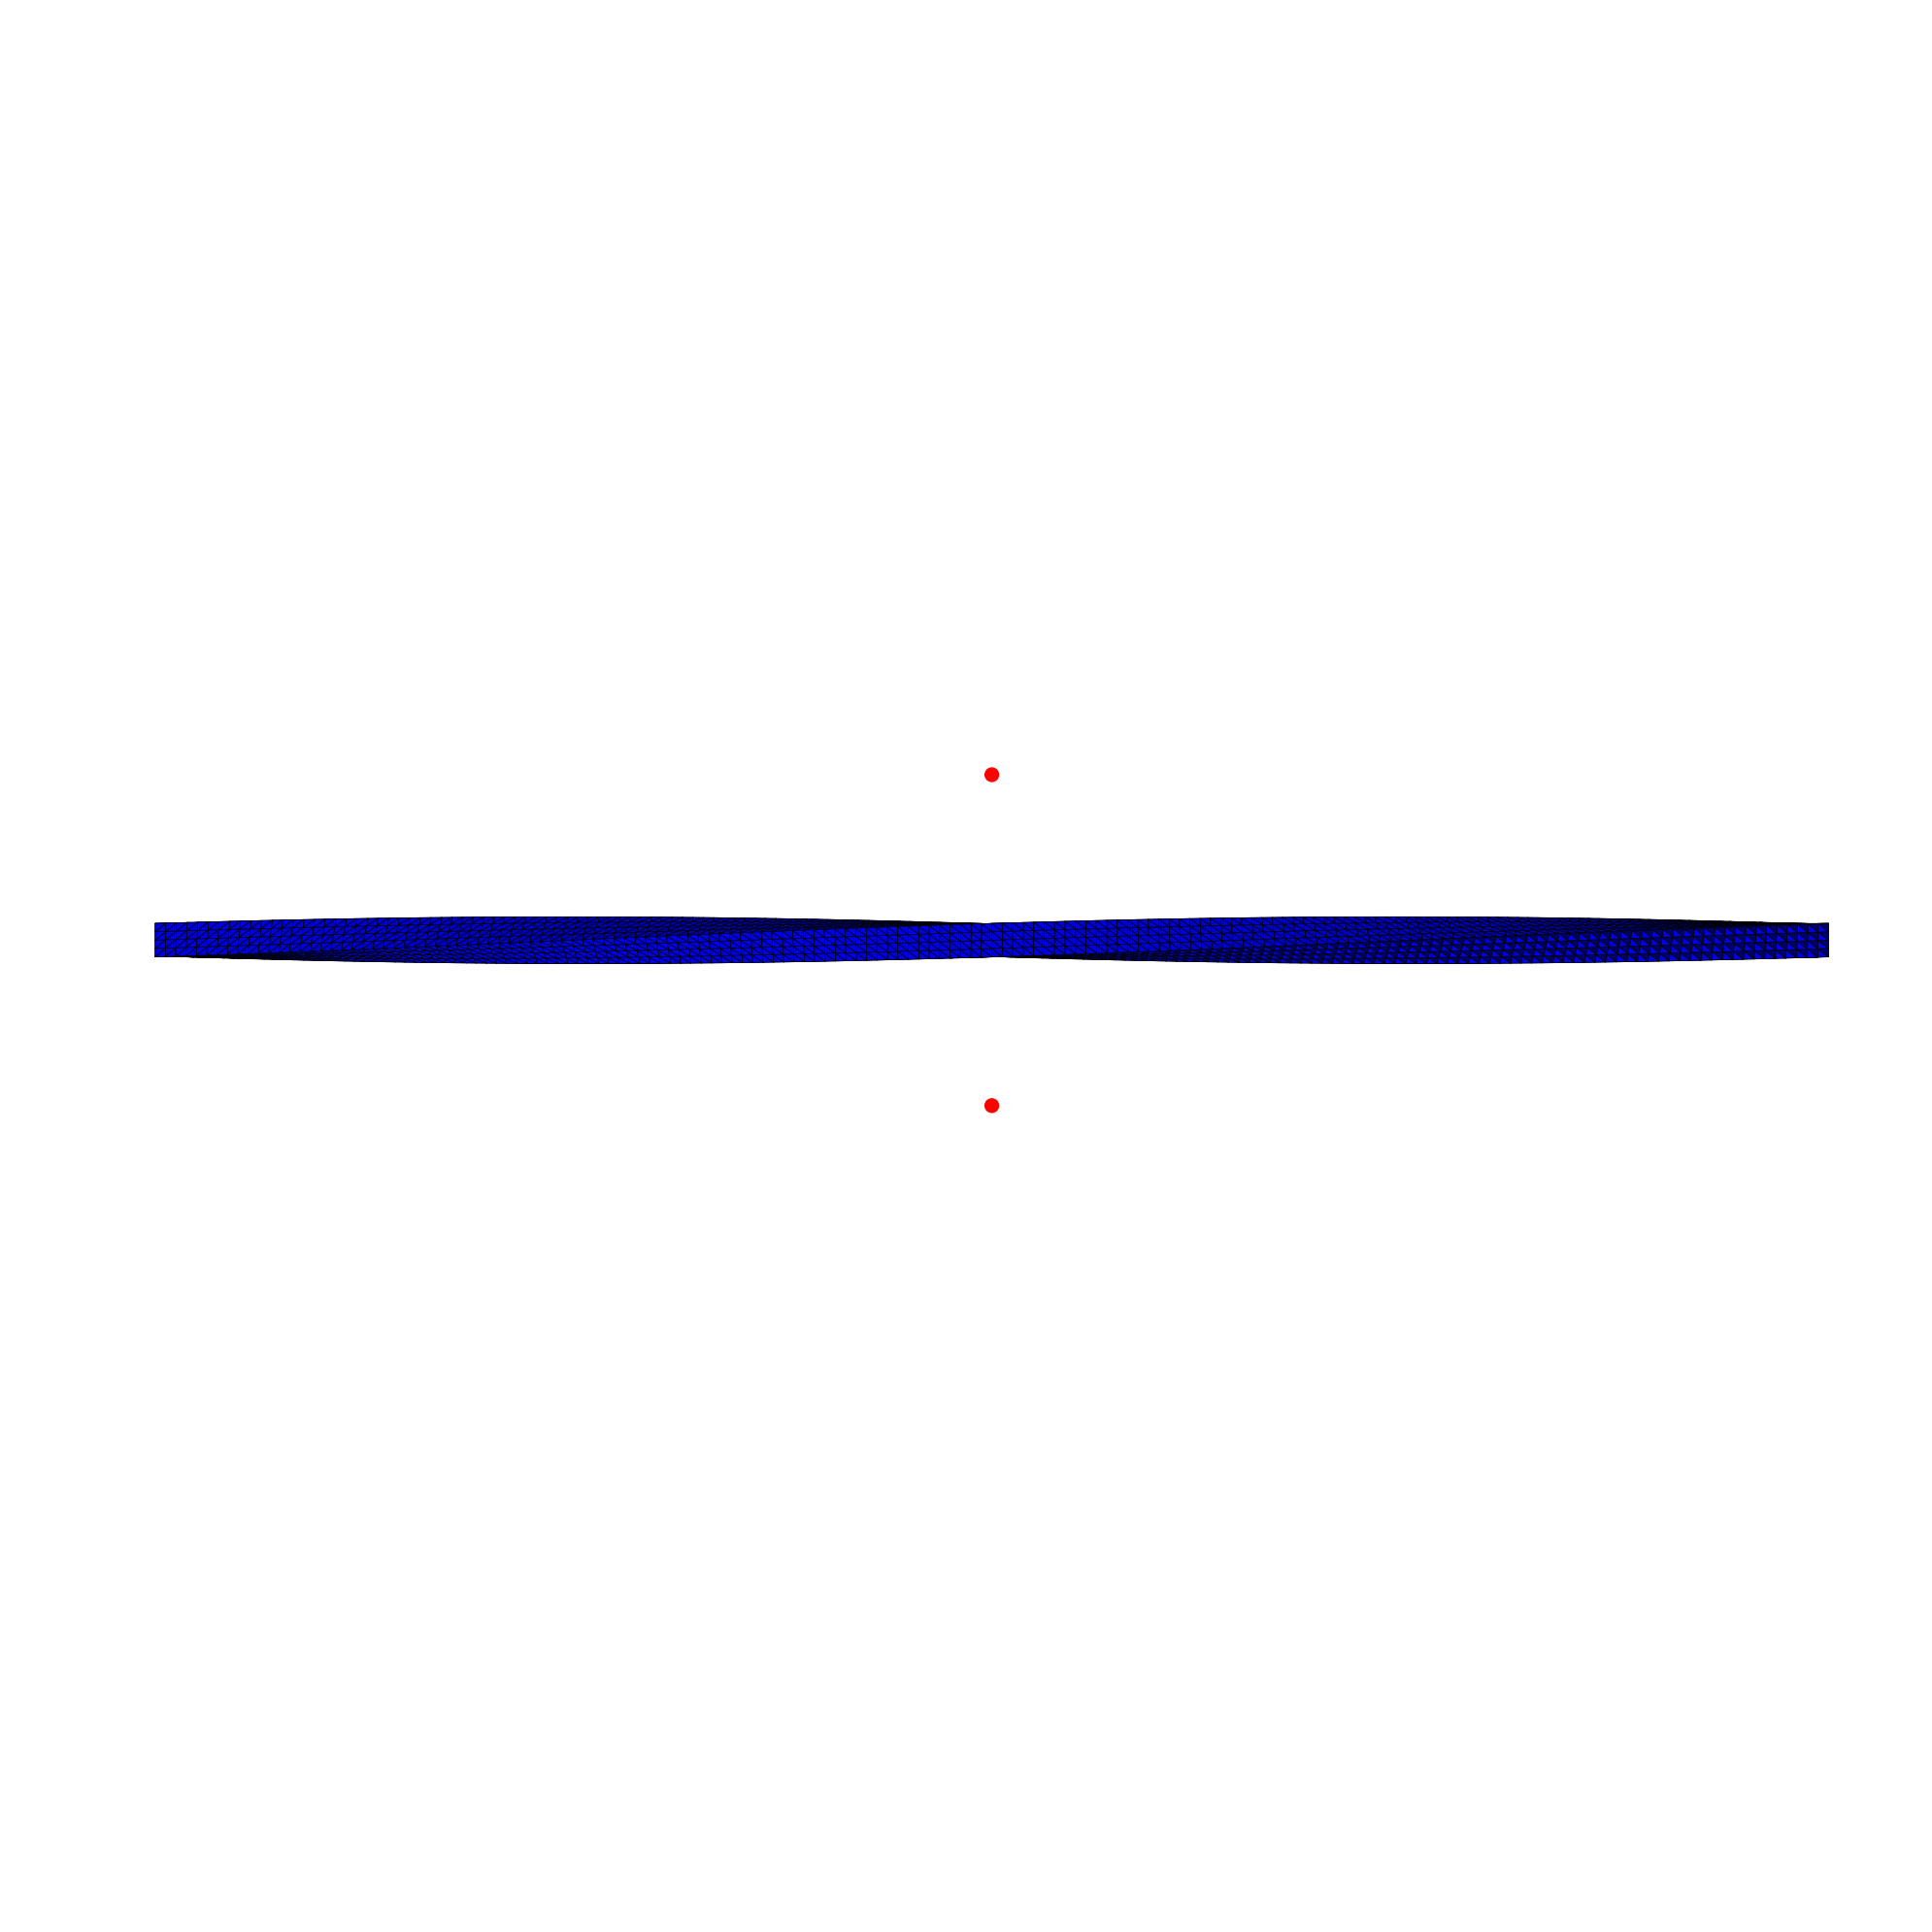

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2.4832382279734686
        x: [ 2.501e-03 -4.895e-03 ... -1.975e-03 -6.783e-03]
      nit: 943
      jac: [ 1.178e-03  8.650e-04 ...  1.252e-03 -1.838e-03]
     nfev: 981
     njev: 981
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


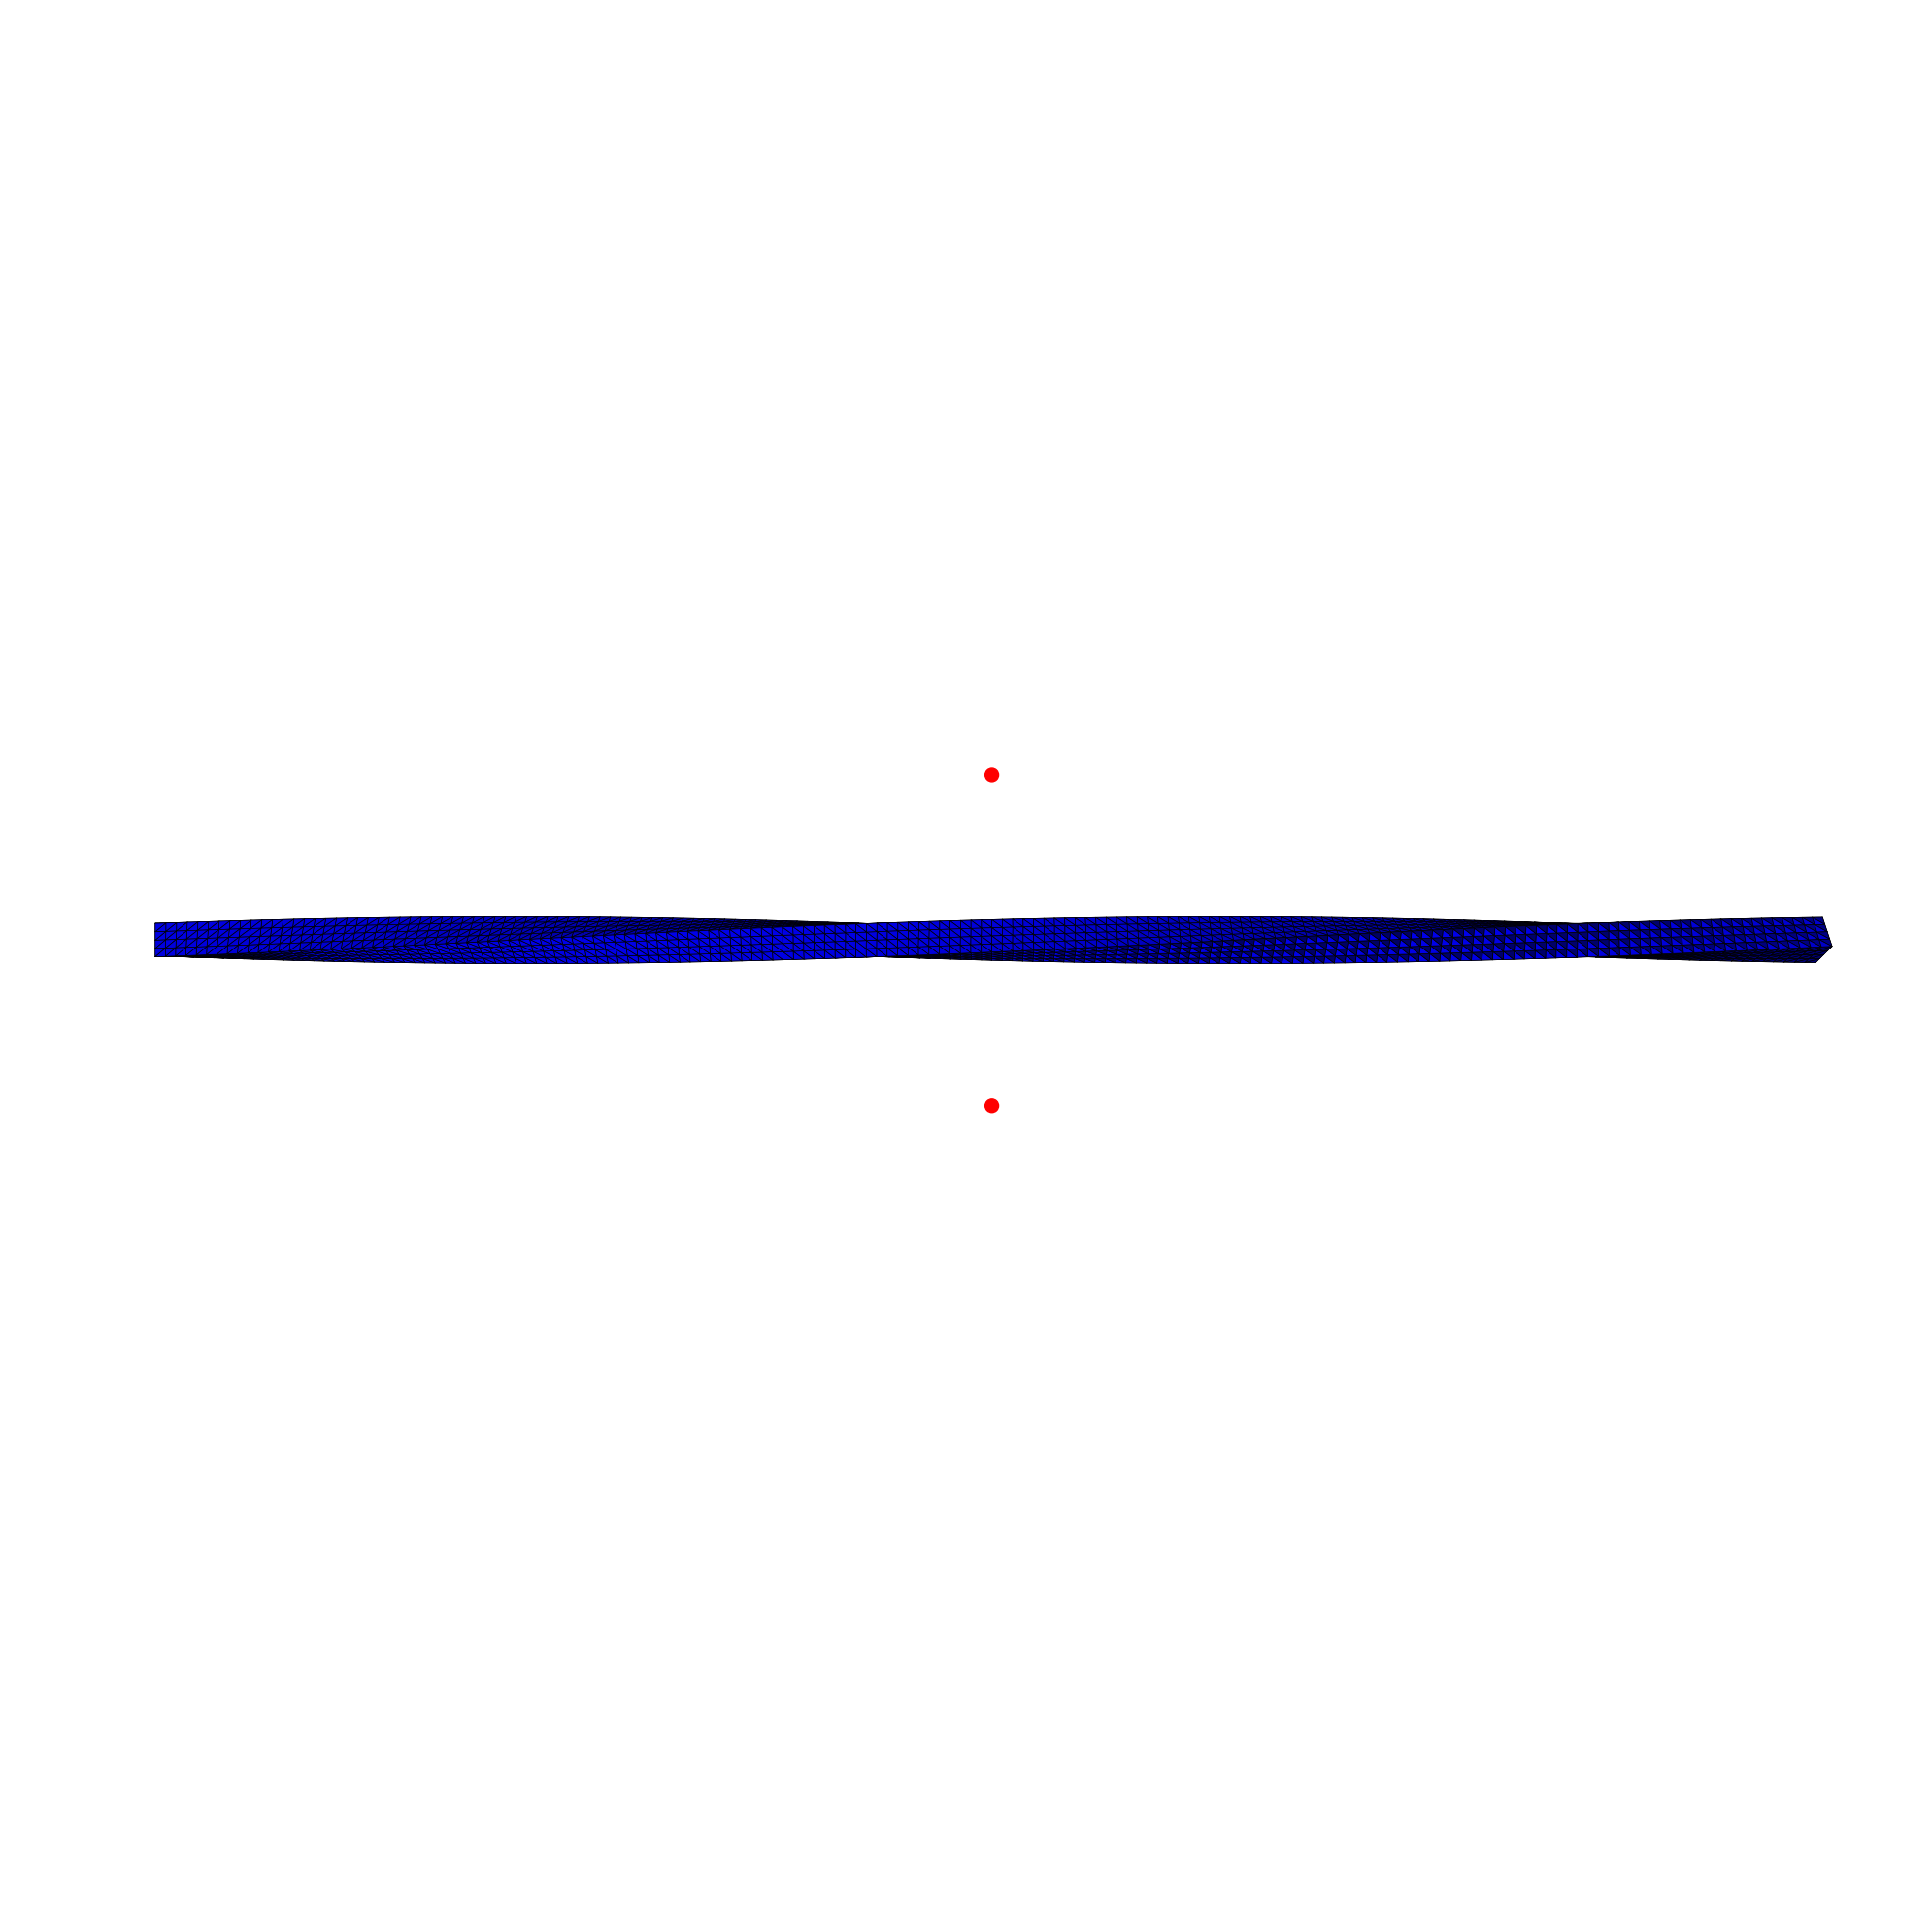

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3.2432389116643825
        x: [ 2.501e-03 -4.880e-03 ...  1.660e-03 -6.865e-03]
      nit: 3596
      jac: [-9.677e-04 -1.787e-04 ...  1.800e-04  3.138e-03]
     nfev: 3704
     njev: 3704
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


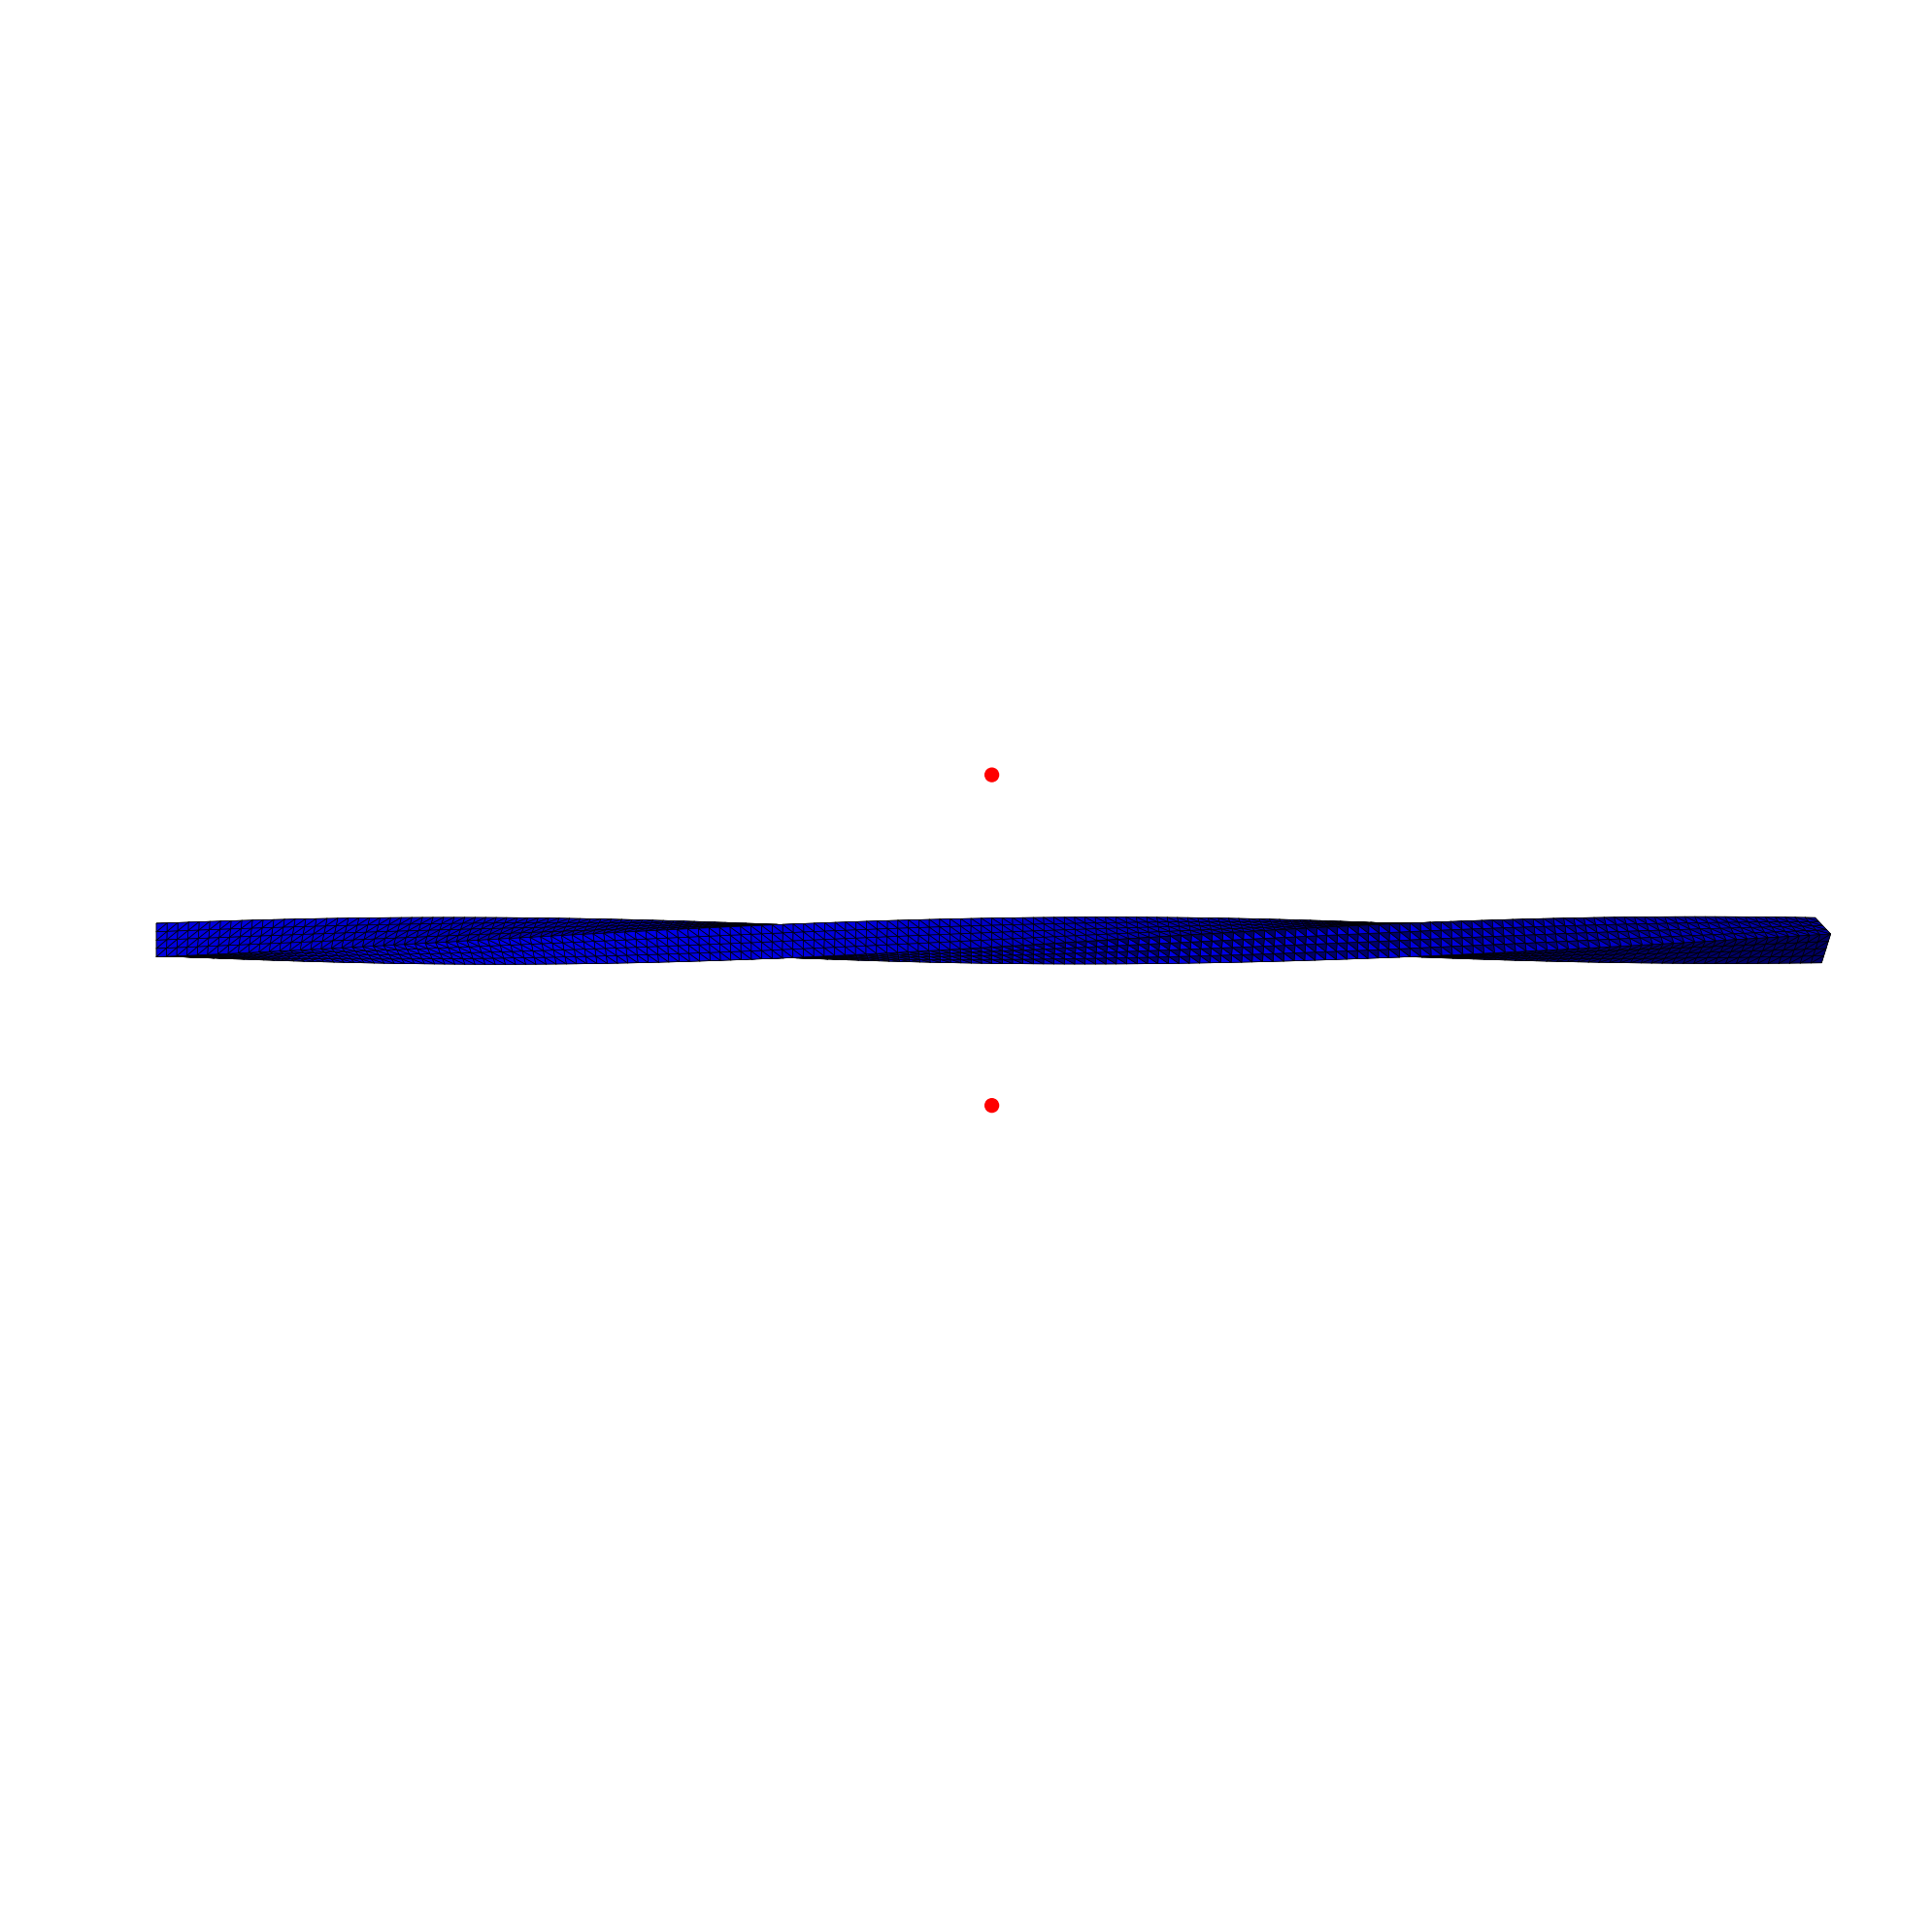

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 4.104675833030768
        x: [ 2.501e-03 -4.865e-03 ...  4.854e-03 -5.130e-03]
      nit: 1053
      jac: [ 1.837e-03 -9.044e-04 ...  4.969e-04 -7.509e-05]
     nfev: 1096
     njev: 1096
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


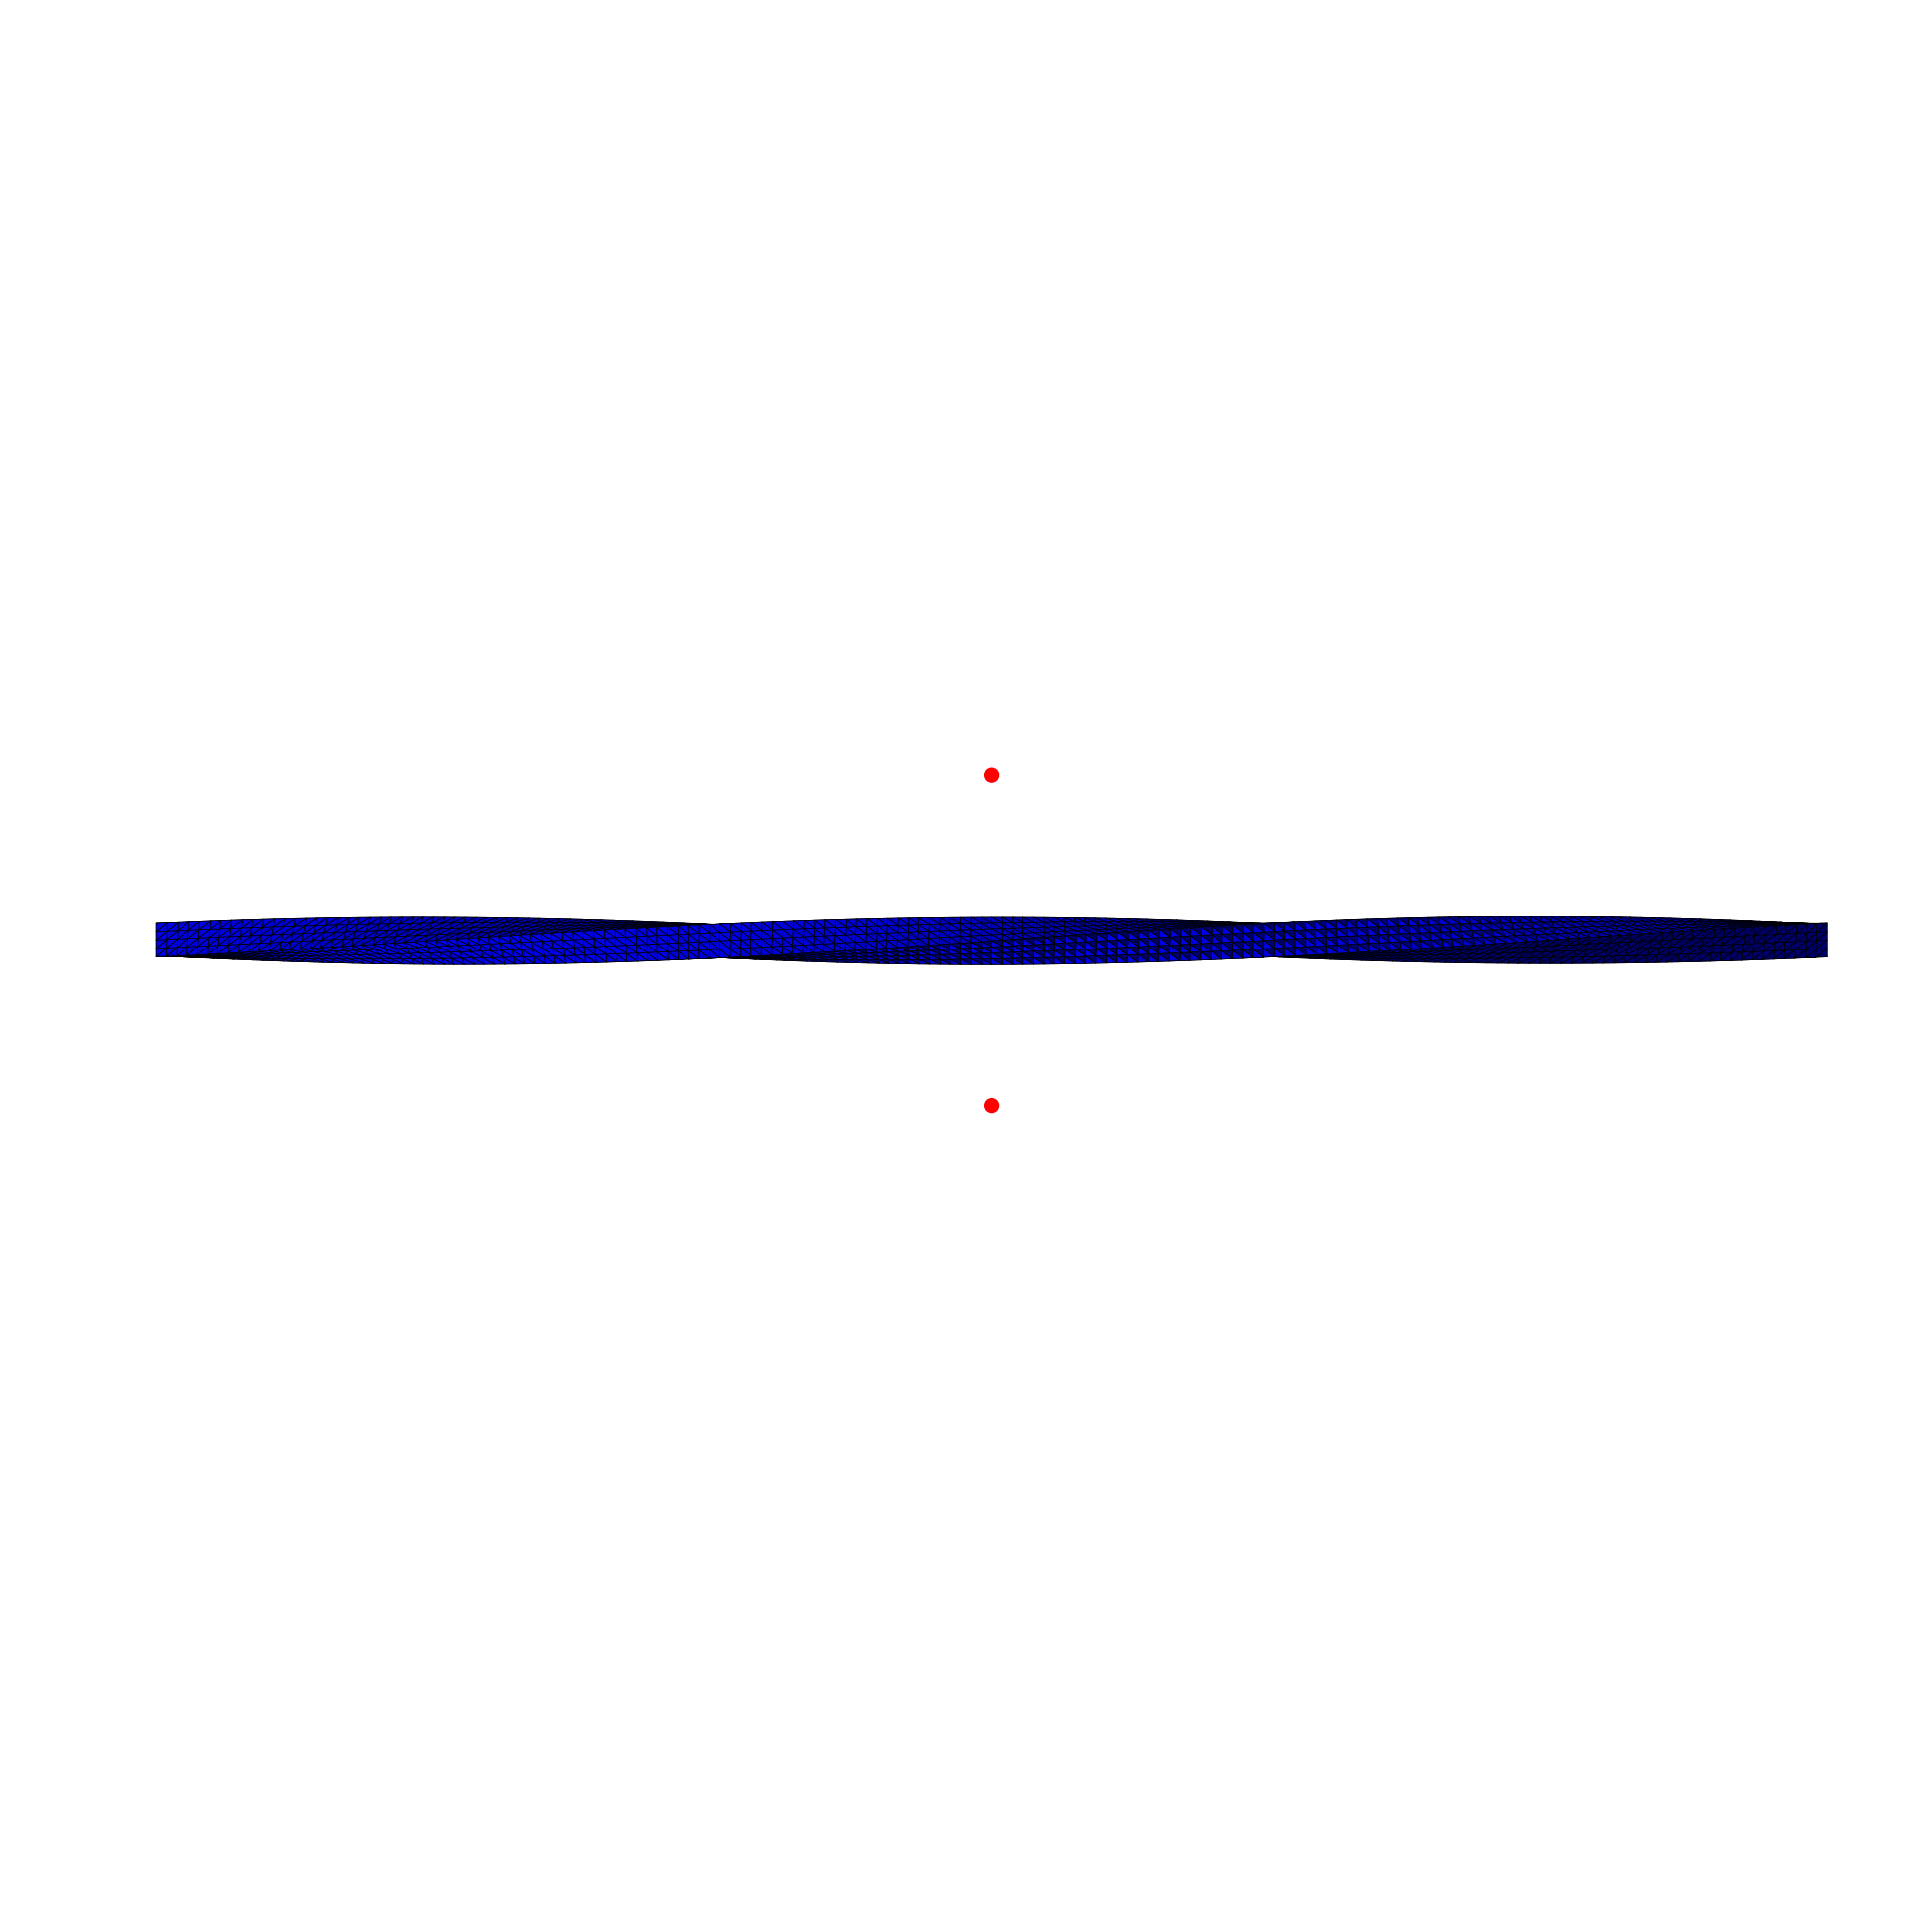

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 5.06726805414578
        x: [ 2.502e-03 -4.849e-03 ...  6.762e-03 -2.037e-03]
      nit: 3850
      jac: [-1.314e-03  2.012e-03 ...  1.489e-04 -6.444e-04]
     nfev: 3982
     njev: 3982
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


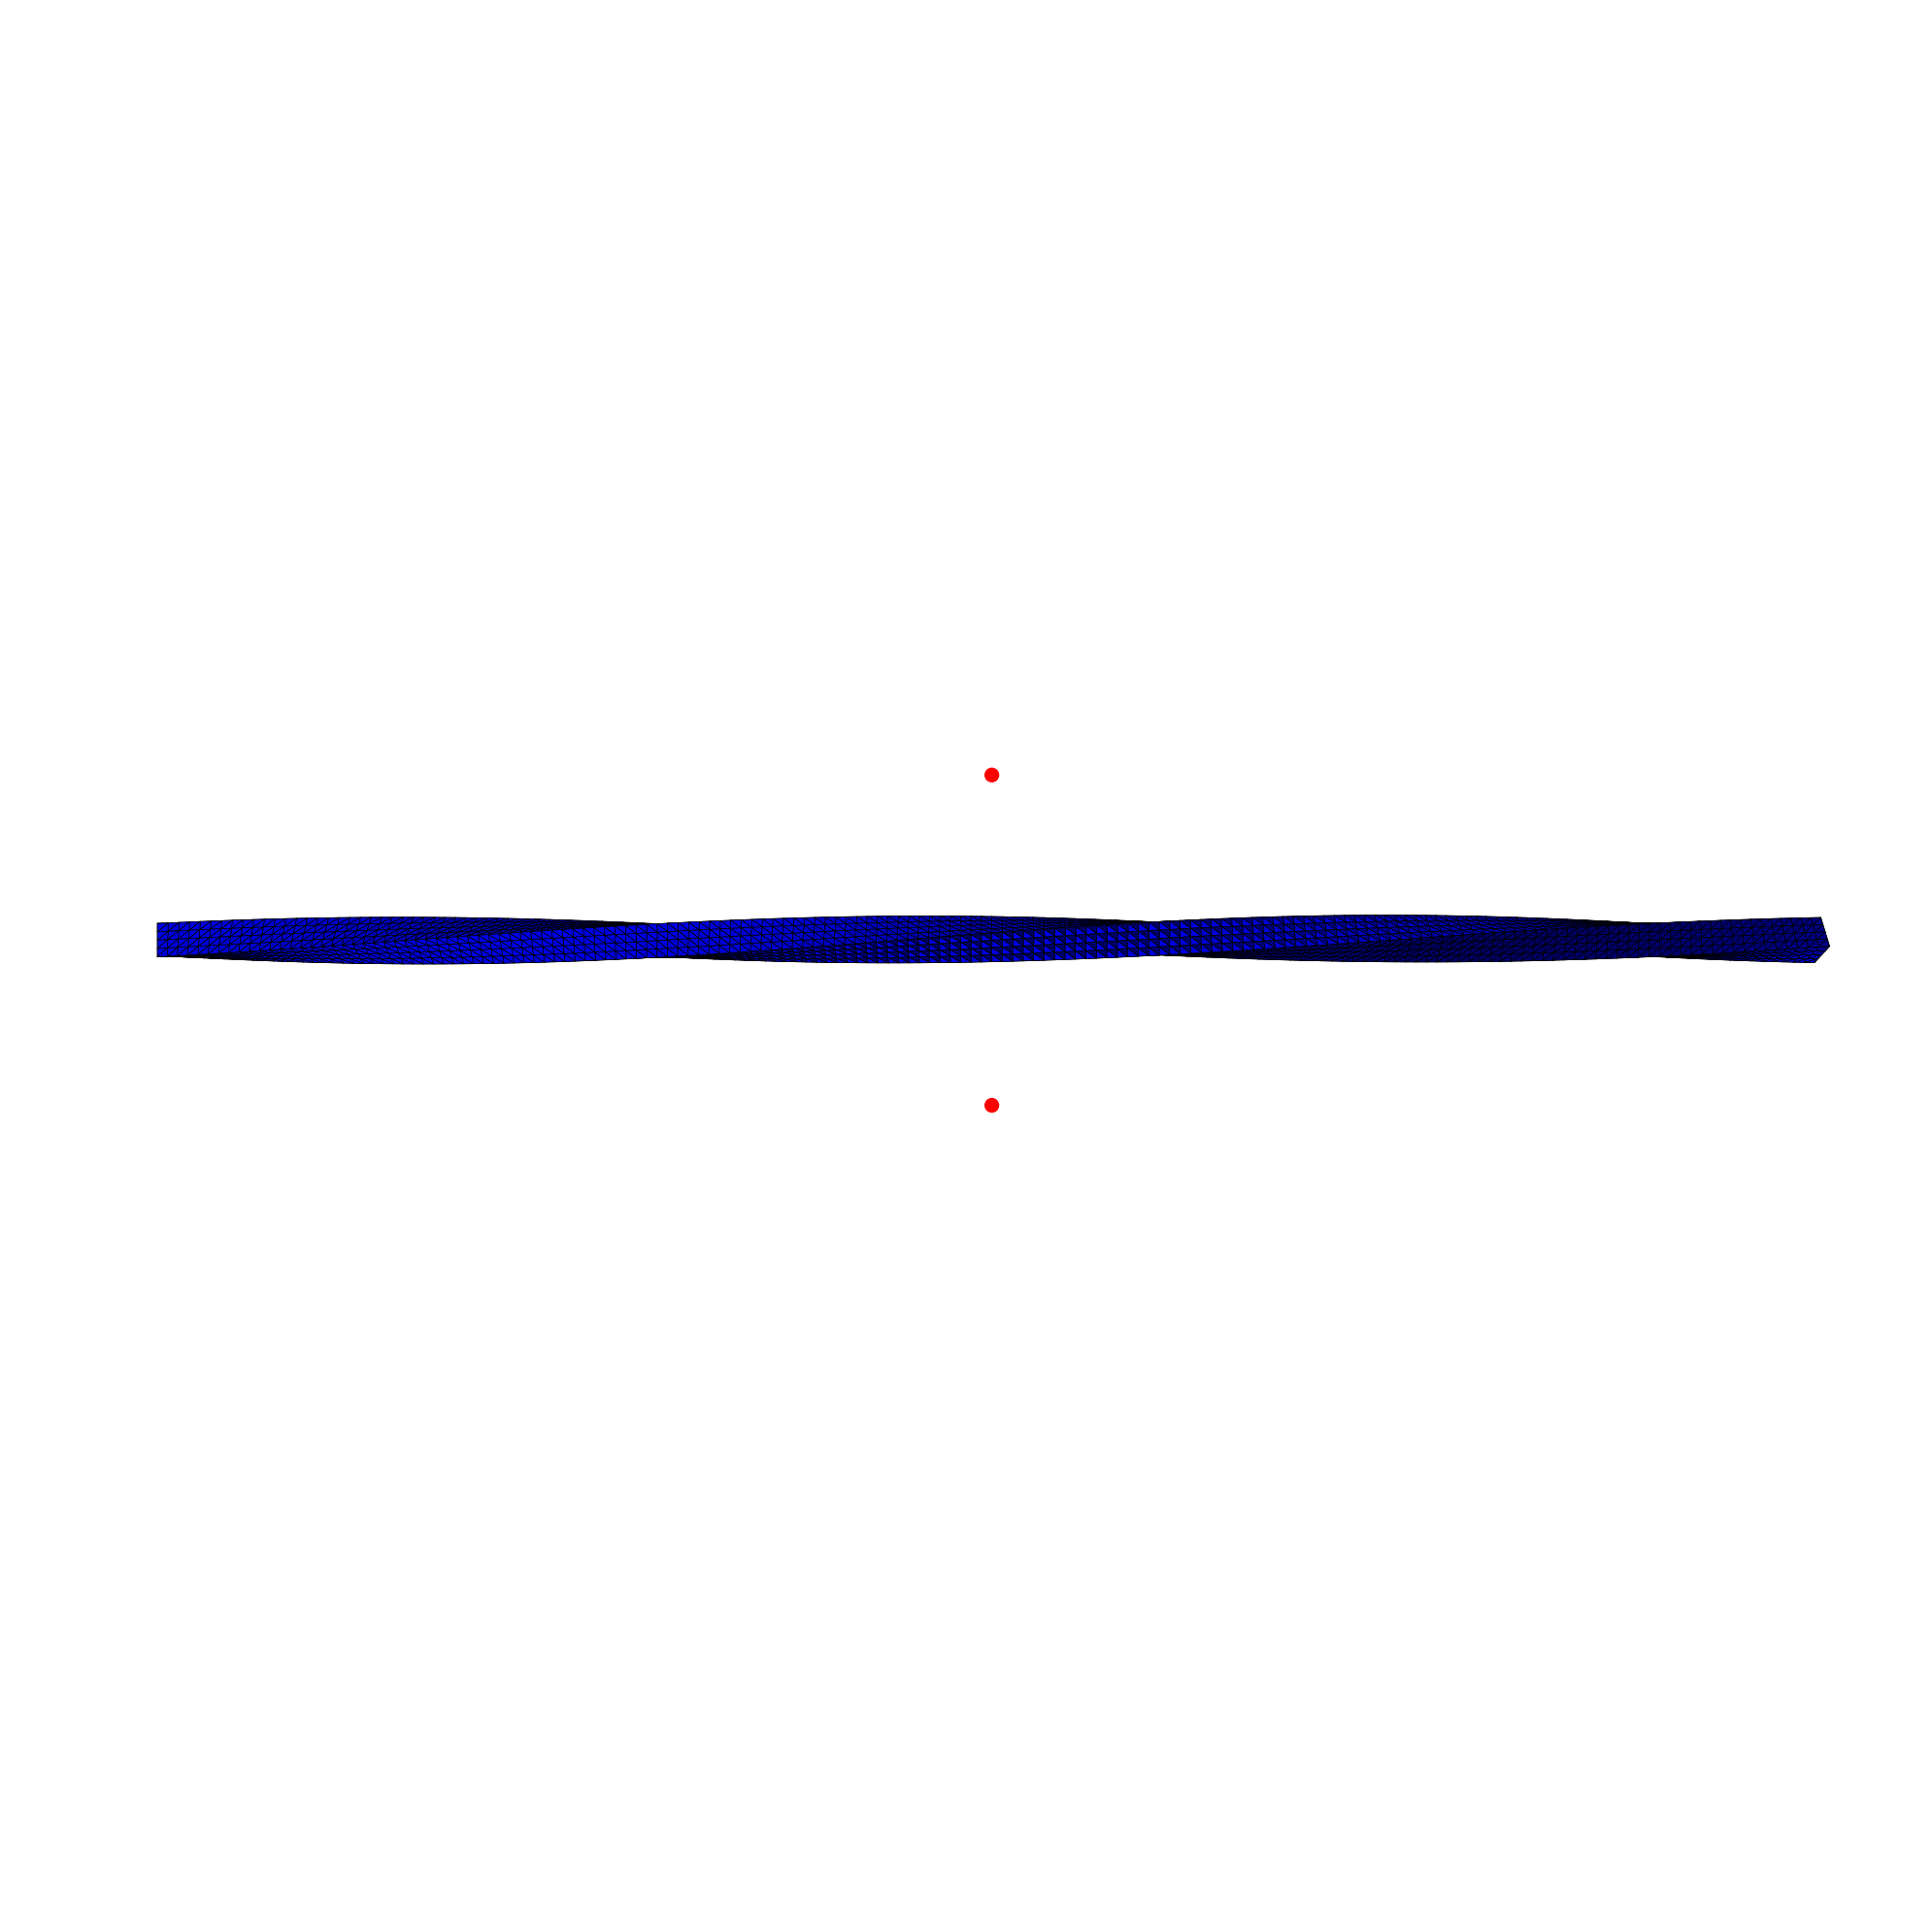

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 6.1312983373032335
        x: [ 2.502e-03 -4.834e-03 ...  6.879e-03  1.596e-03]
      nit: 1379
      jac: [-4.694e-04  9.870e-04 ... -2.545e-03 -7.762e-04]
     nfev: 1429
     njev: 1429
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


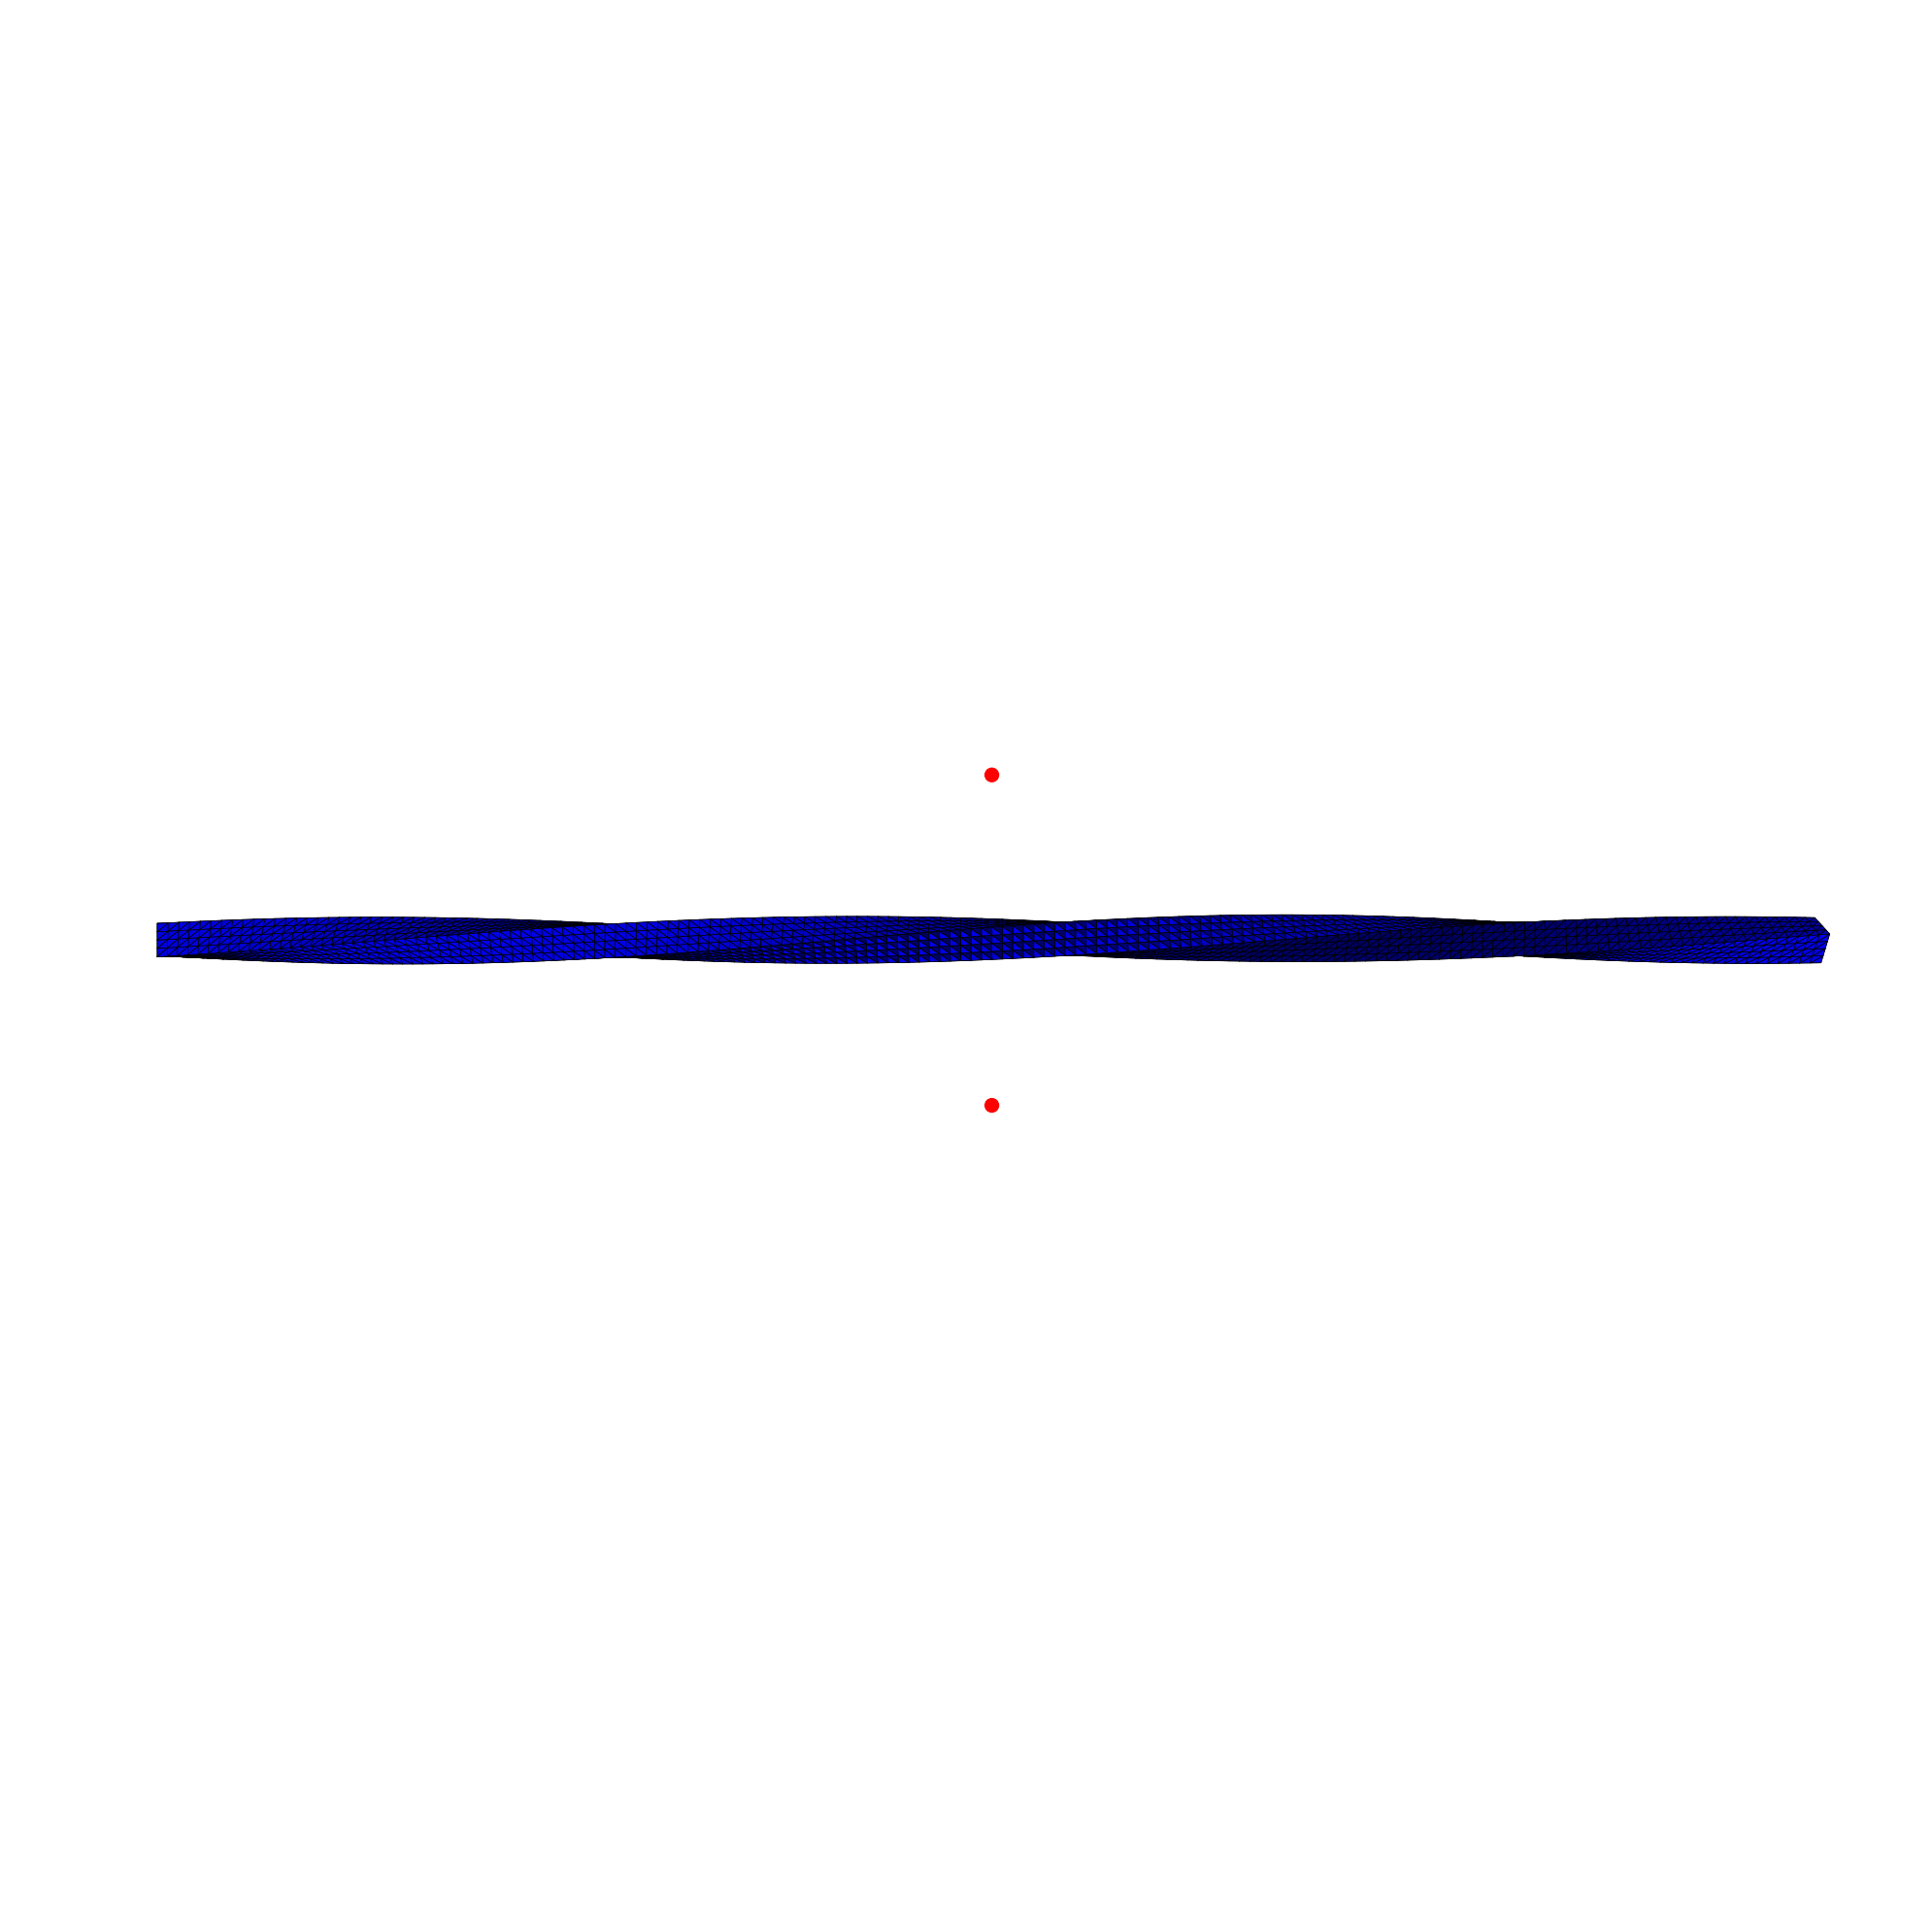

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 7.296823910901654
        x: [ 2.502e-03 -4.818e-03 ...  5.173e-03  4.806e-03]
      nit: 1180
      jac: [-1.946e-03 -3.356e-03 ... -9.811e-04  4.426e-03]
     nfev: 1221
     njev: 1221
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


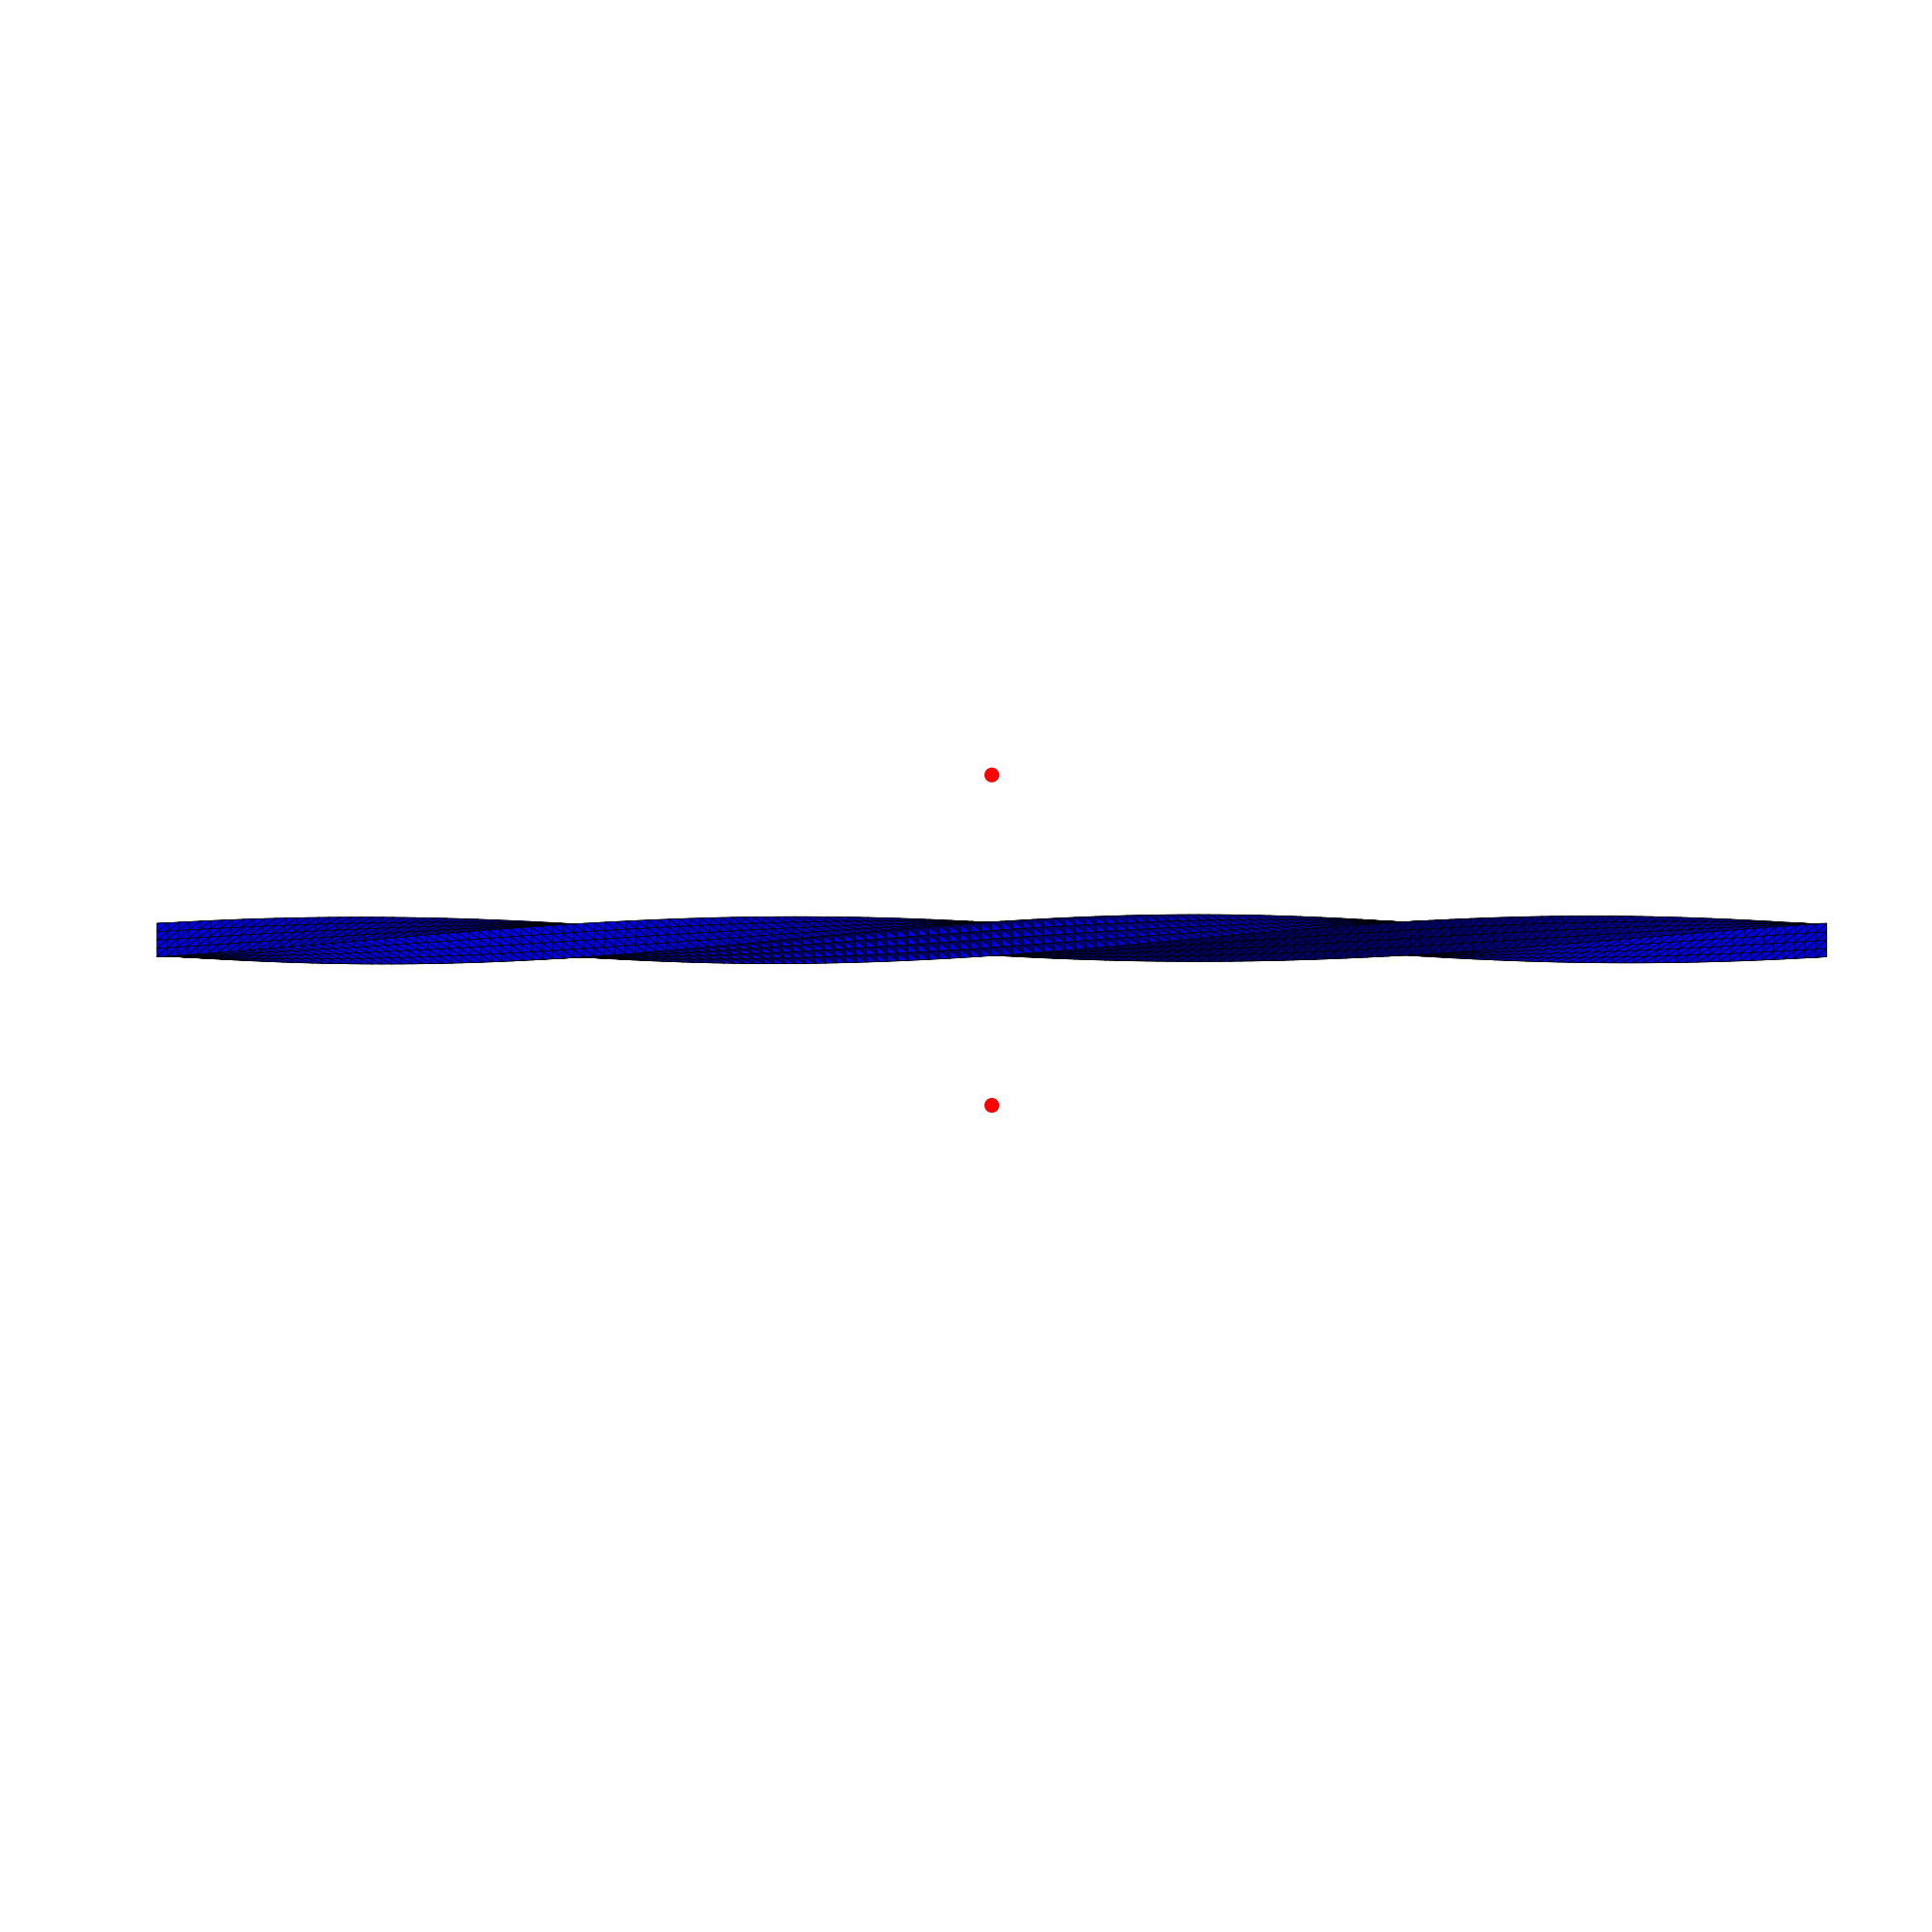

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 8.562112173350297
        x: [ 2.507e-03 -4.801e-03 ...  2.098e-03  6.741e-03]
      nit: 4399
      jac: [ 7.573e-04 -4.004e-04 ... -1.923e-04  1.051e-03]
     nfev: 4534
     njev: 4534
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


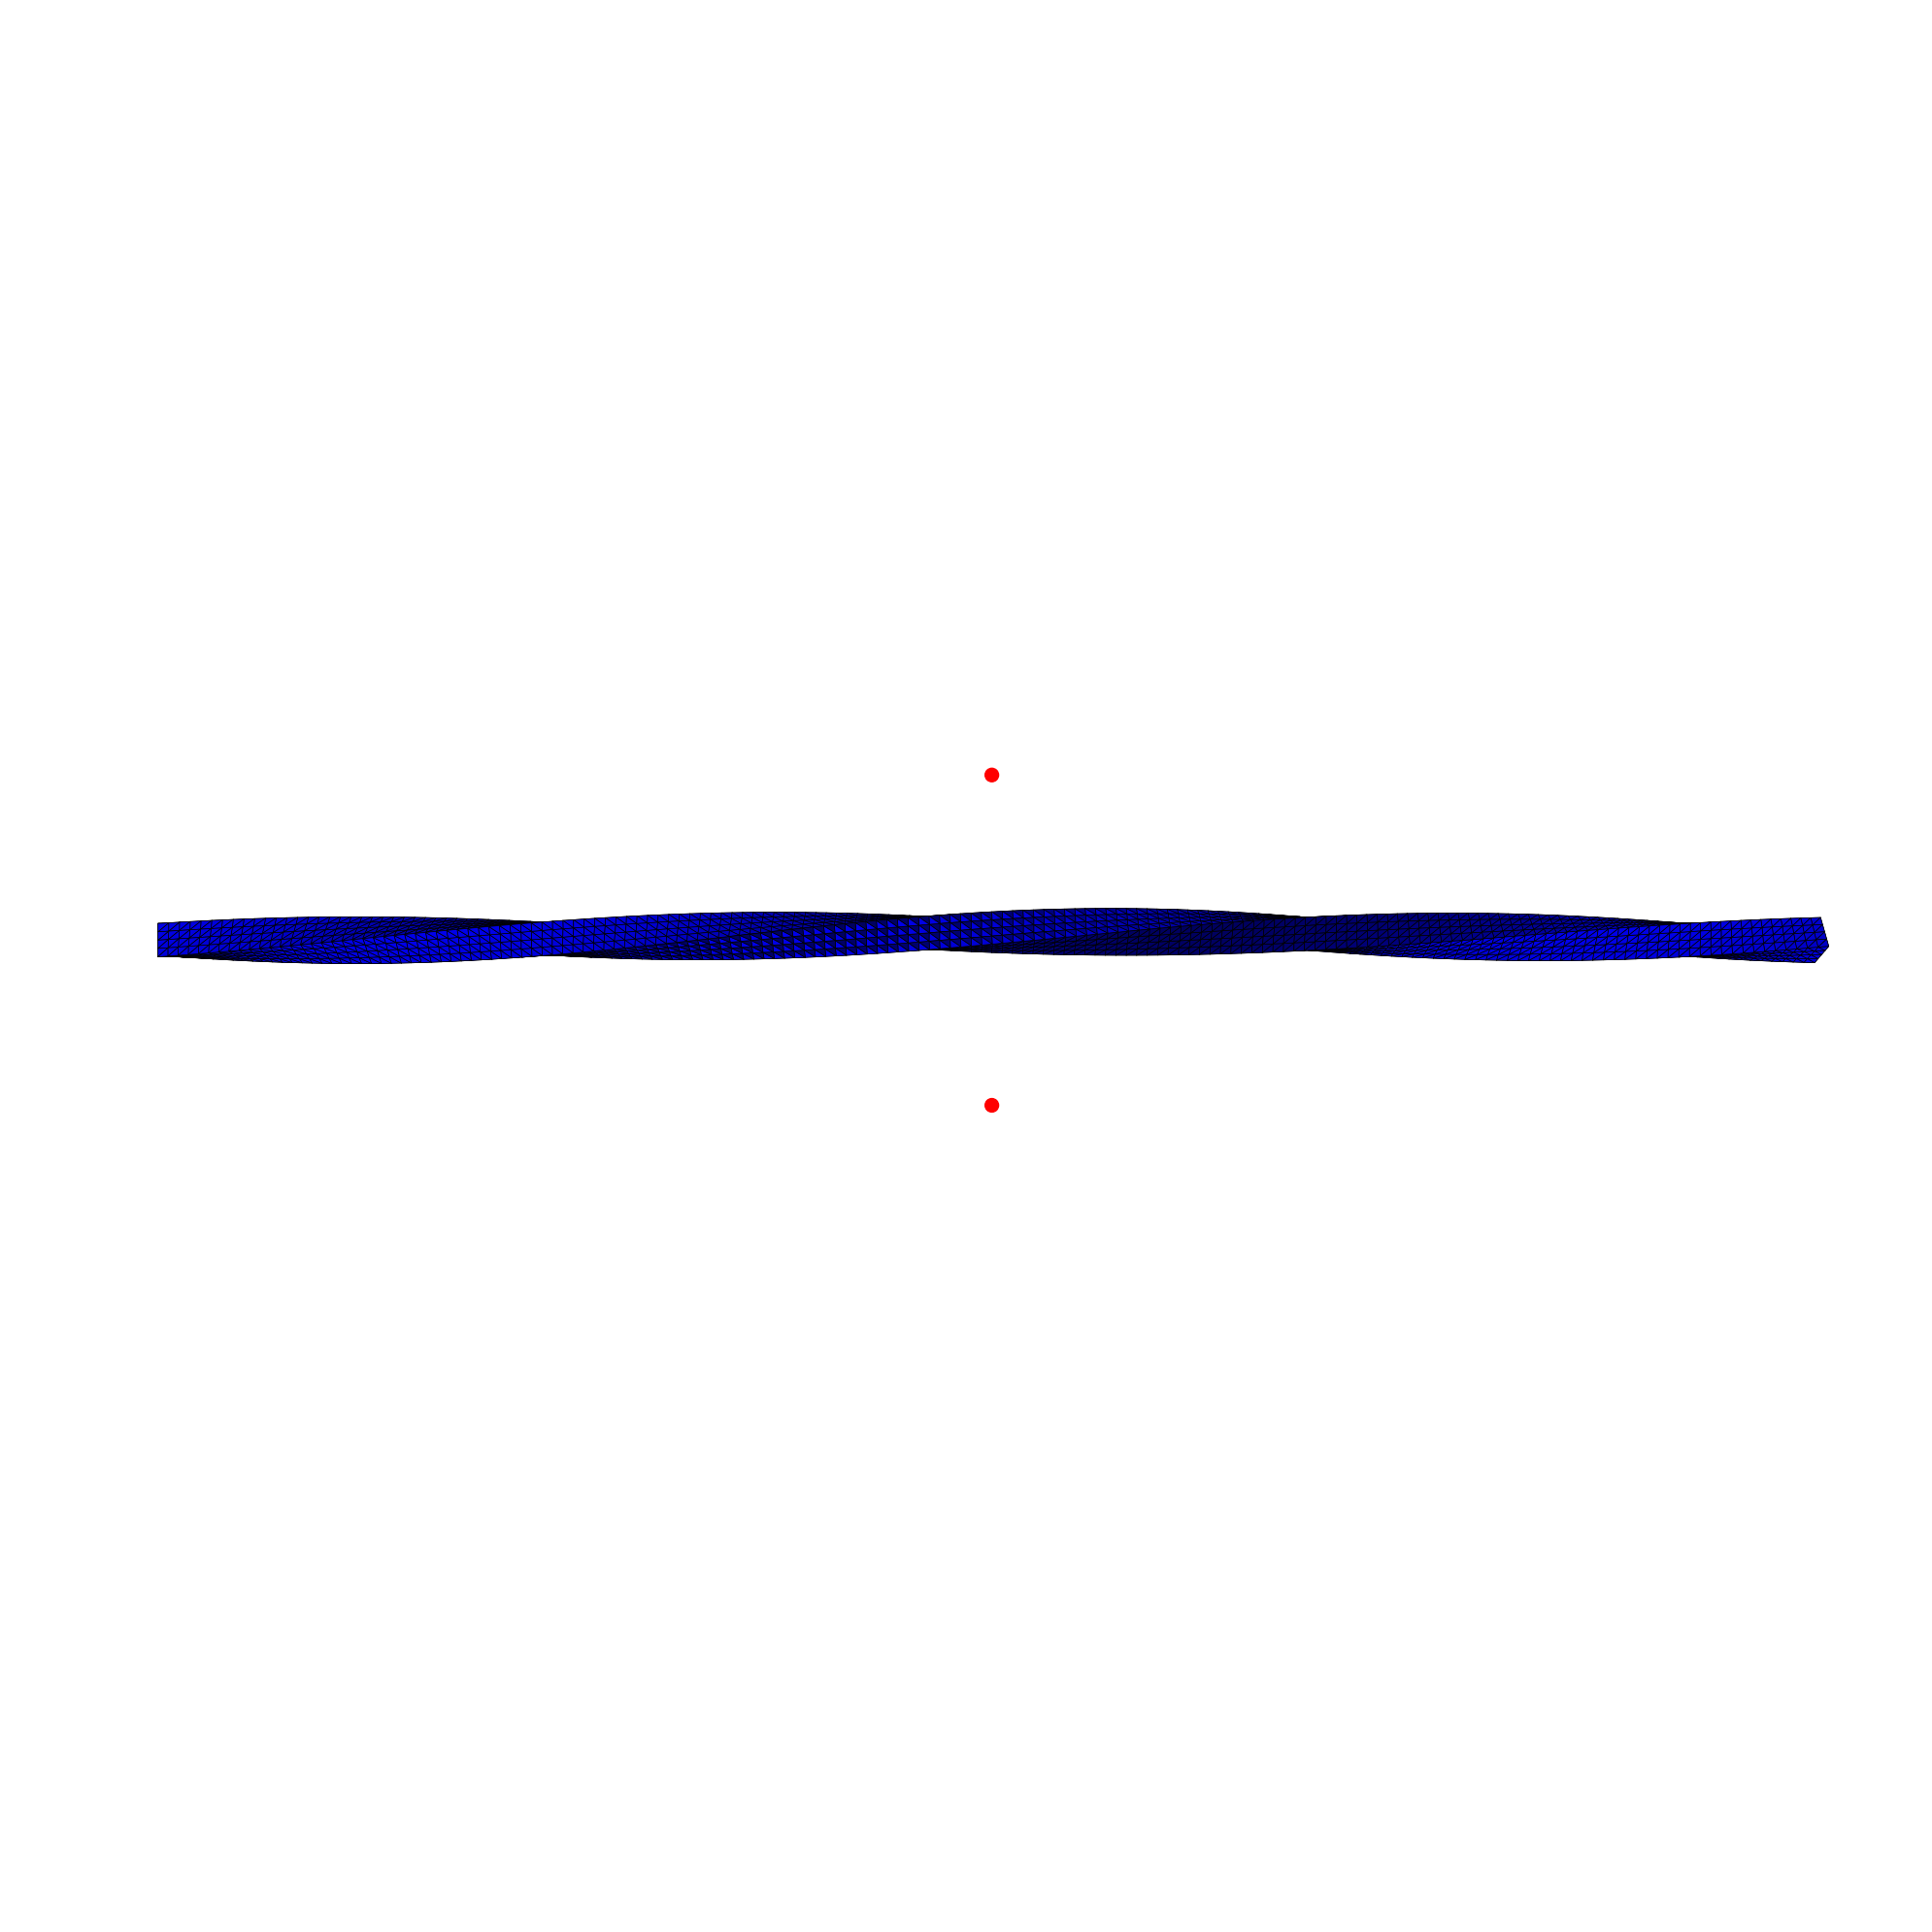

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 9.9289667188406
        x: [ 2.512e-03 -4.783e-03 ... -1.533e-03  6.893e-03]
      nit: 4125
      jac: [-1.657e-03  1.869e-03 ... -6.713e-03 -1.360e-03]
     nfev: 4262
     njev: 4262
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


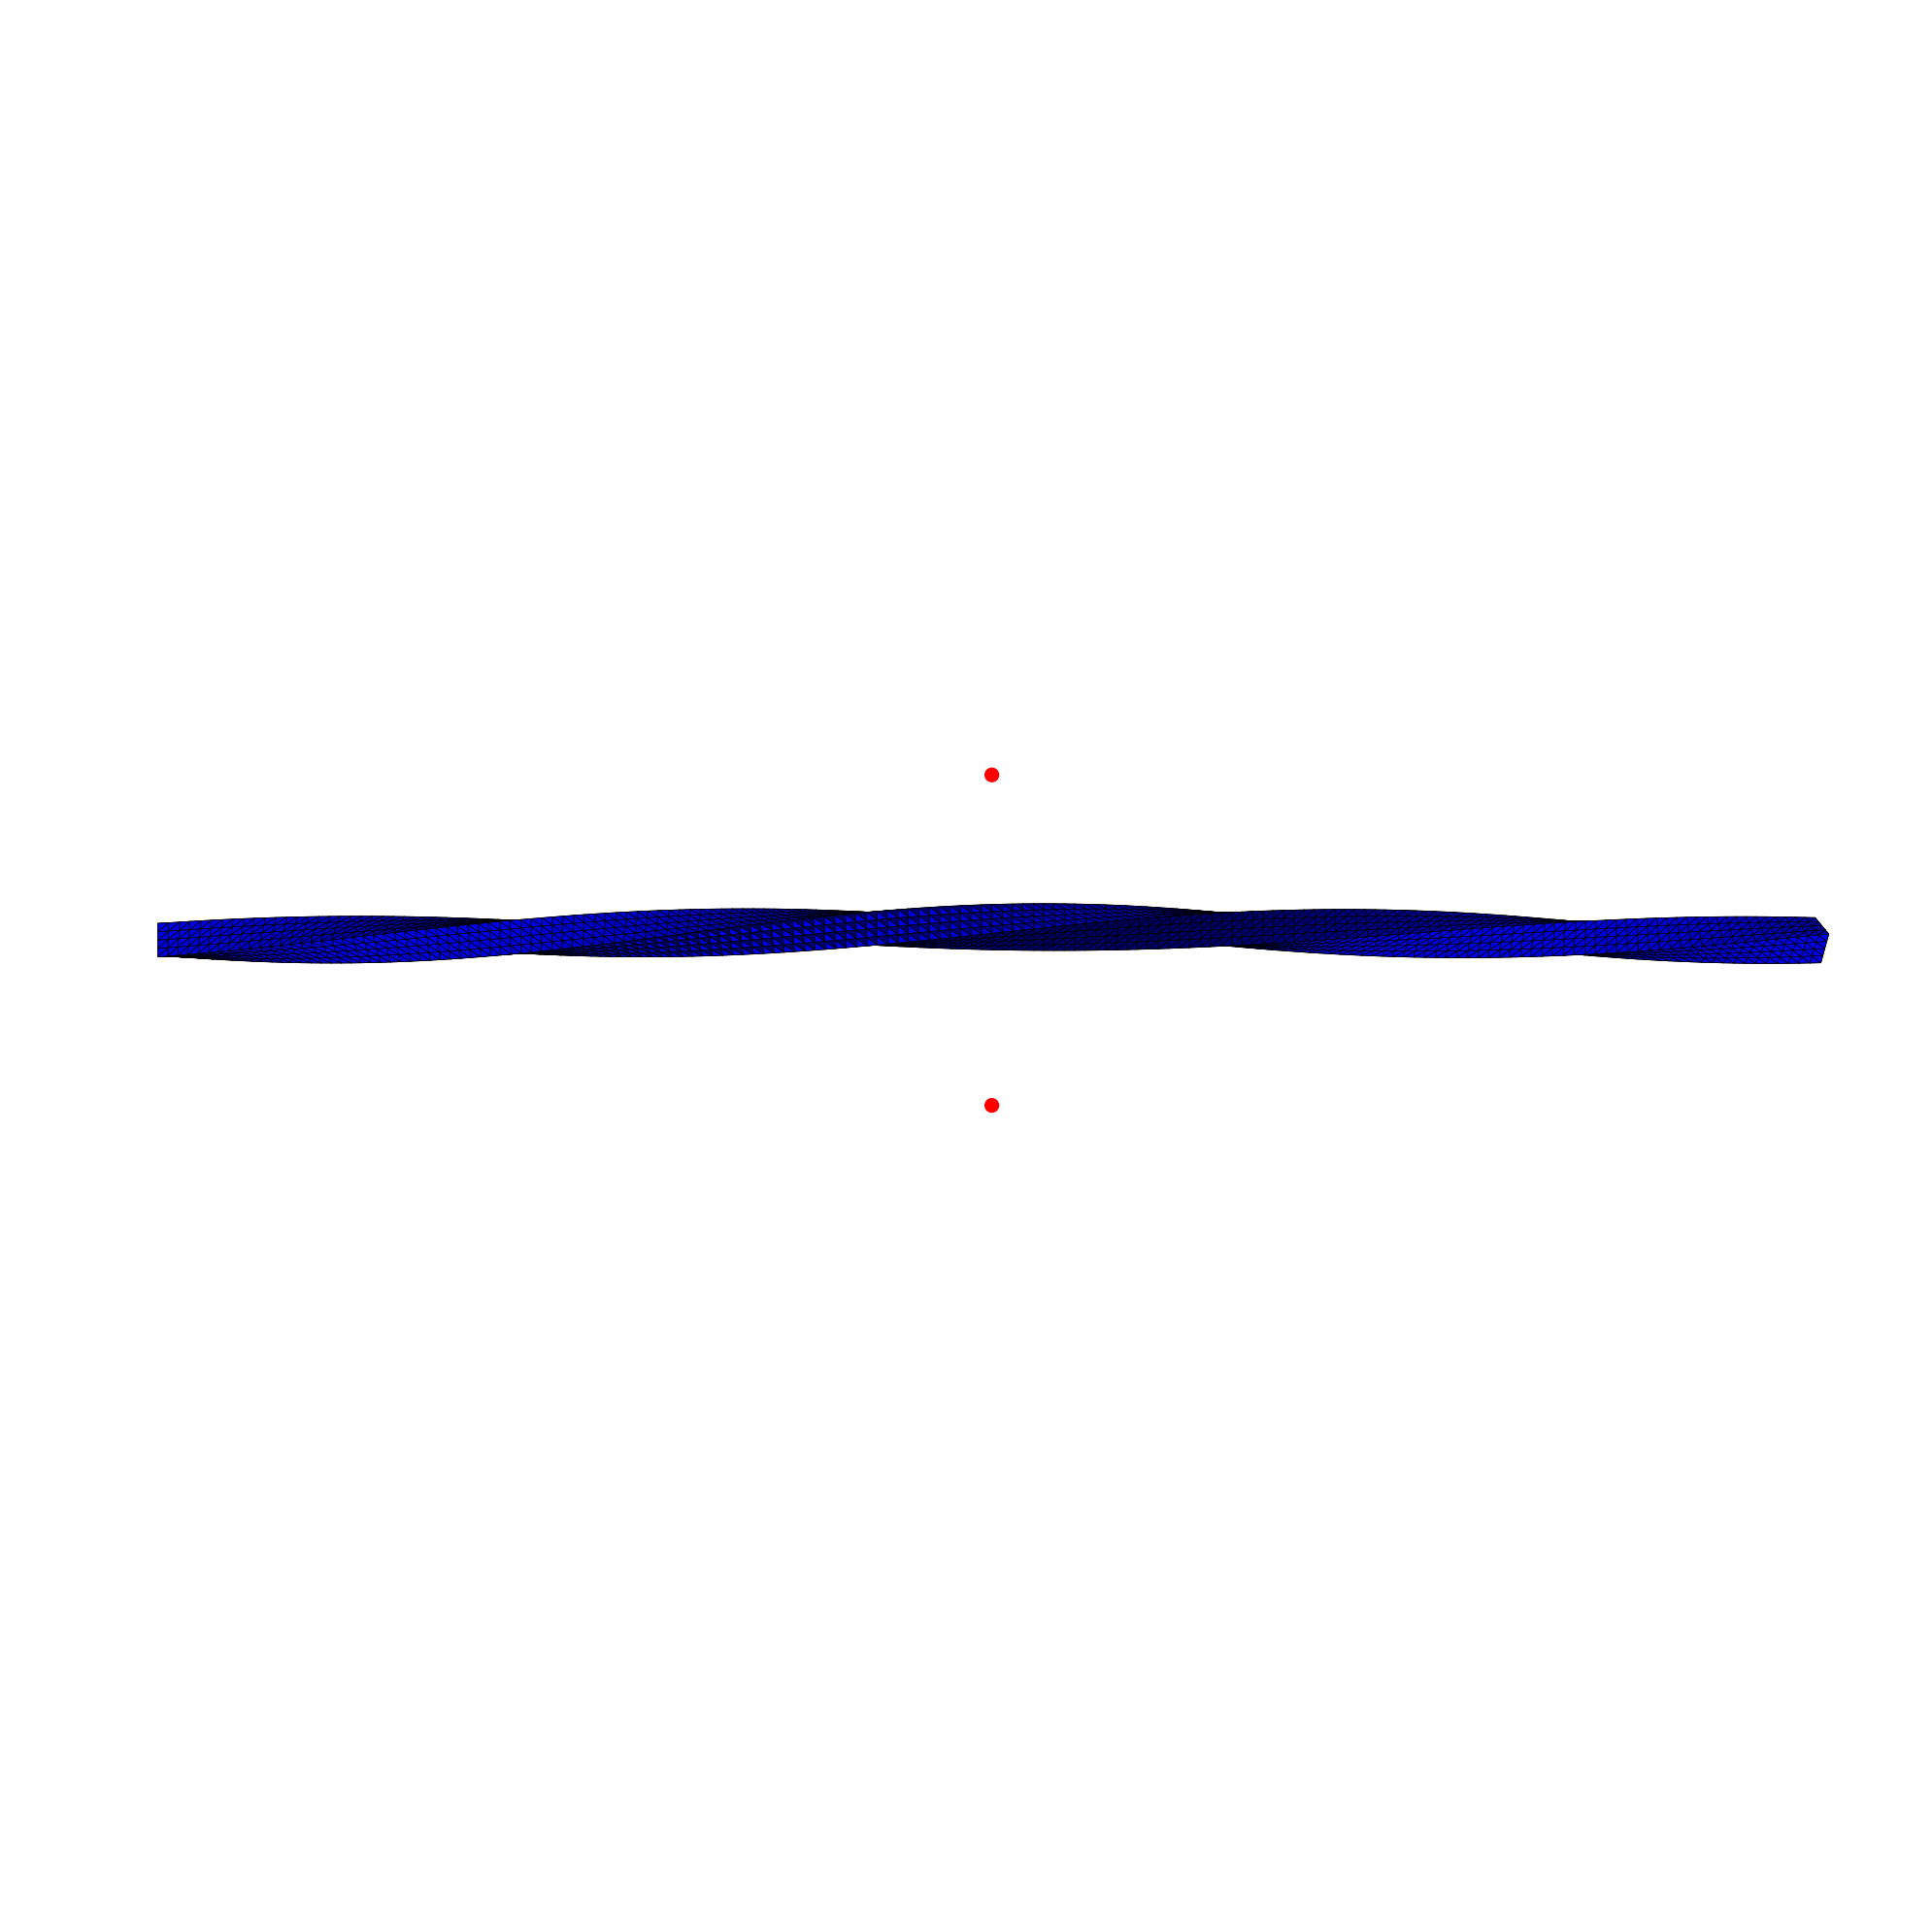

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 11.397209163123312
        x: [ 2.514e-03 -4.766e-03 ... -4.757e-03  5.217e-03]
      nit: 2716
      jac: [ 2.483e-03  4.851e-03 ... -6.327e-04  2.672e-03]
     nfev: 2796
     njev: 2796
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


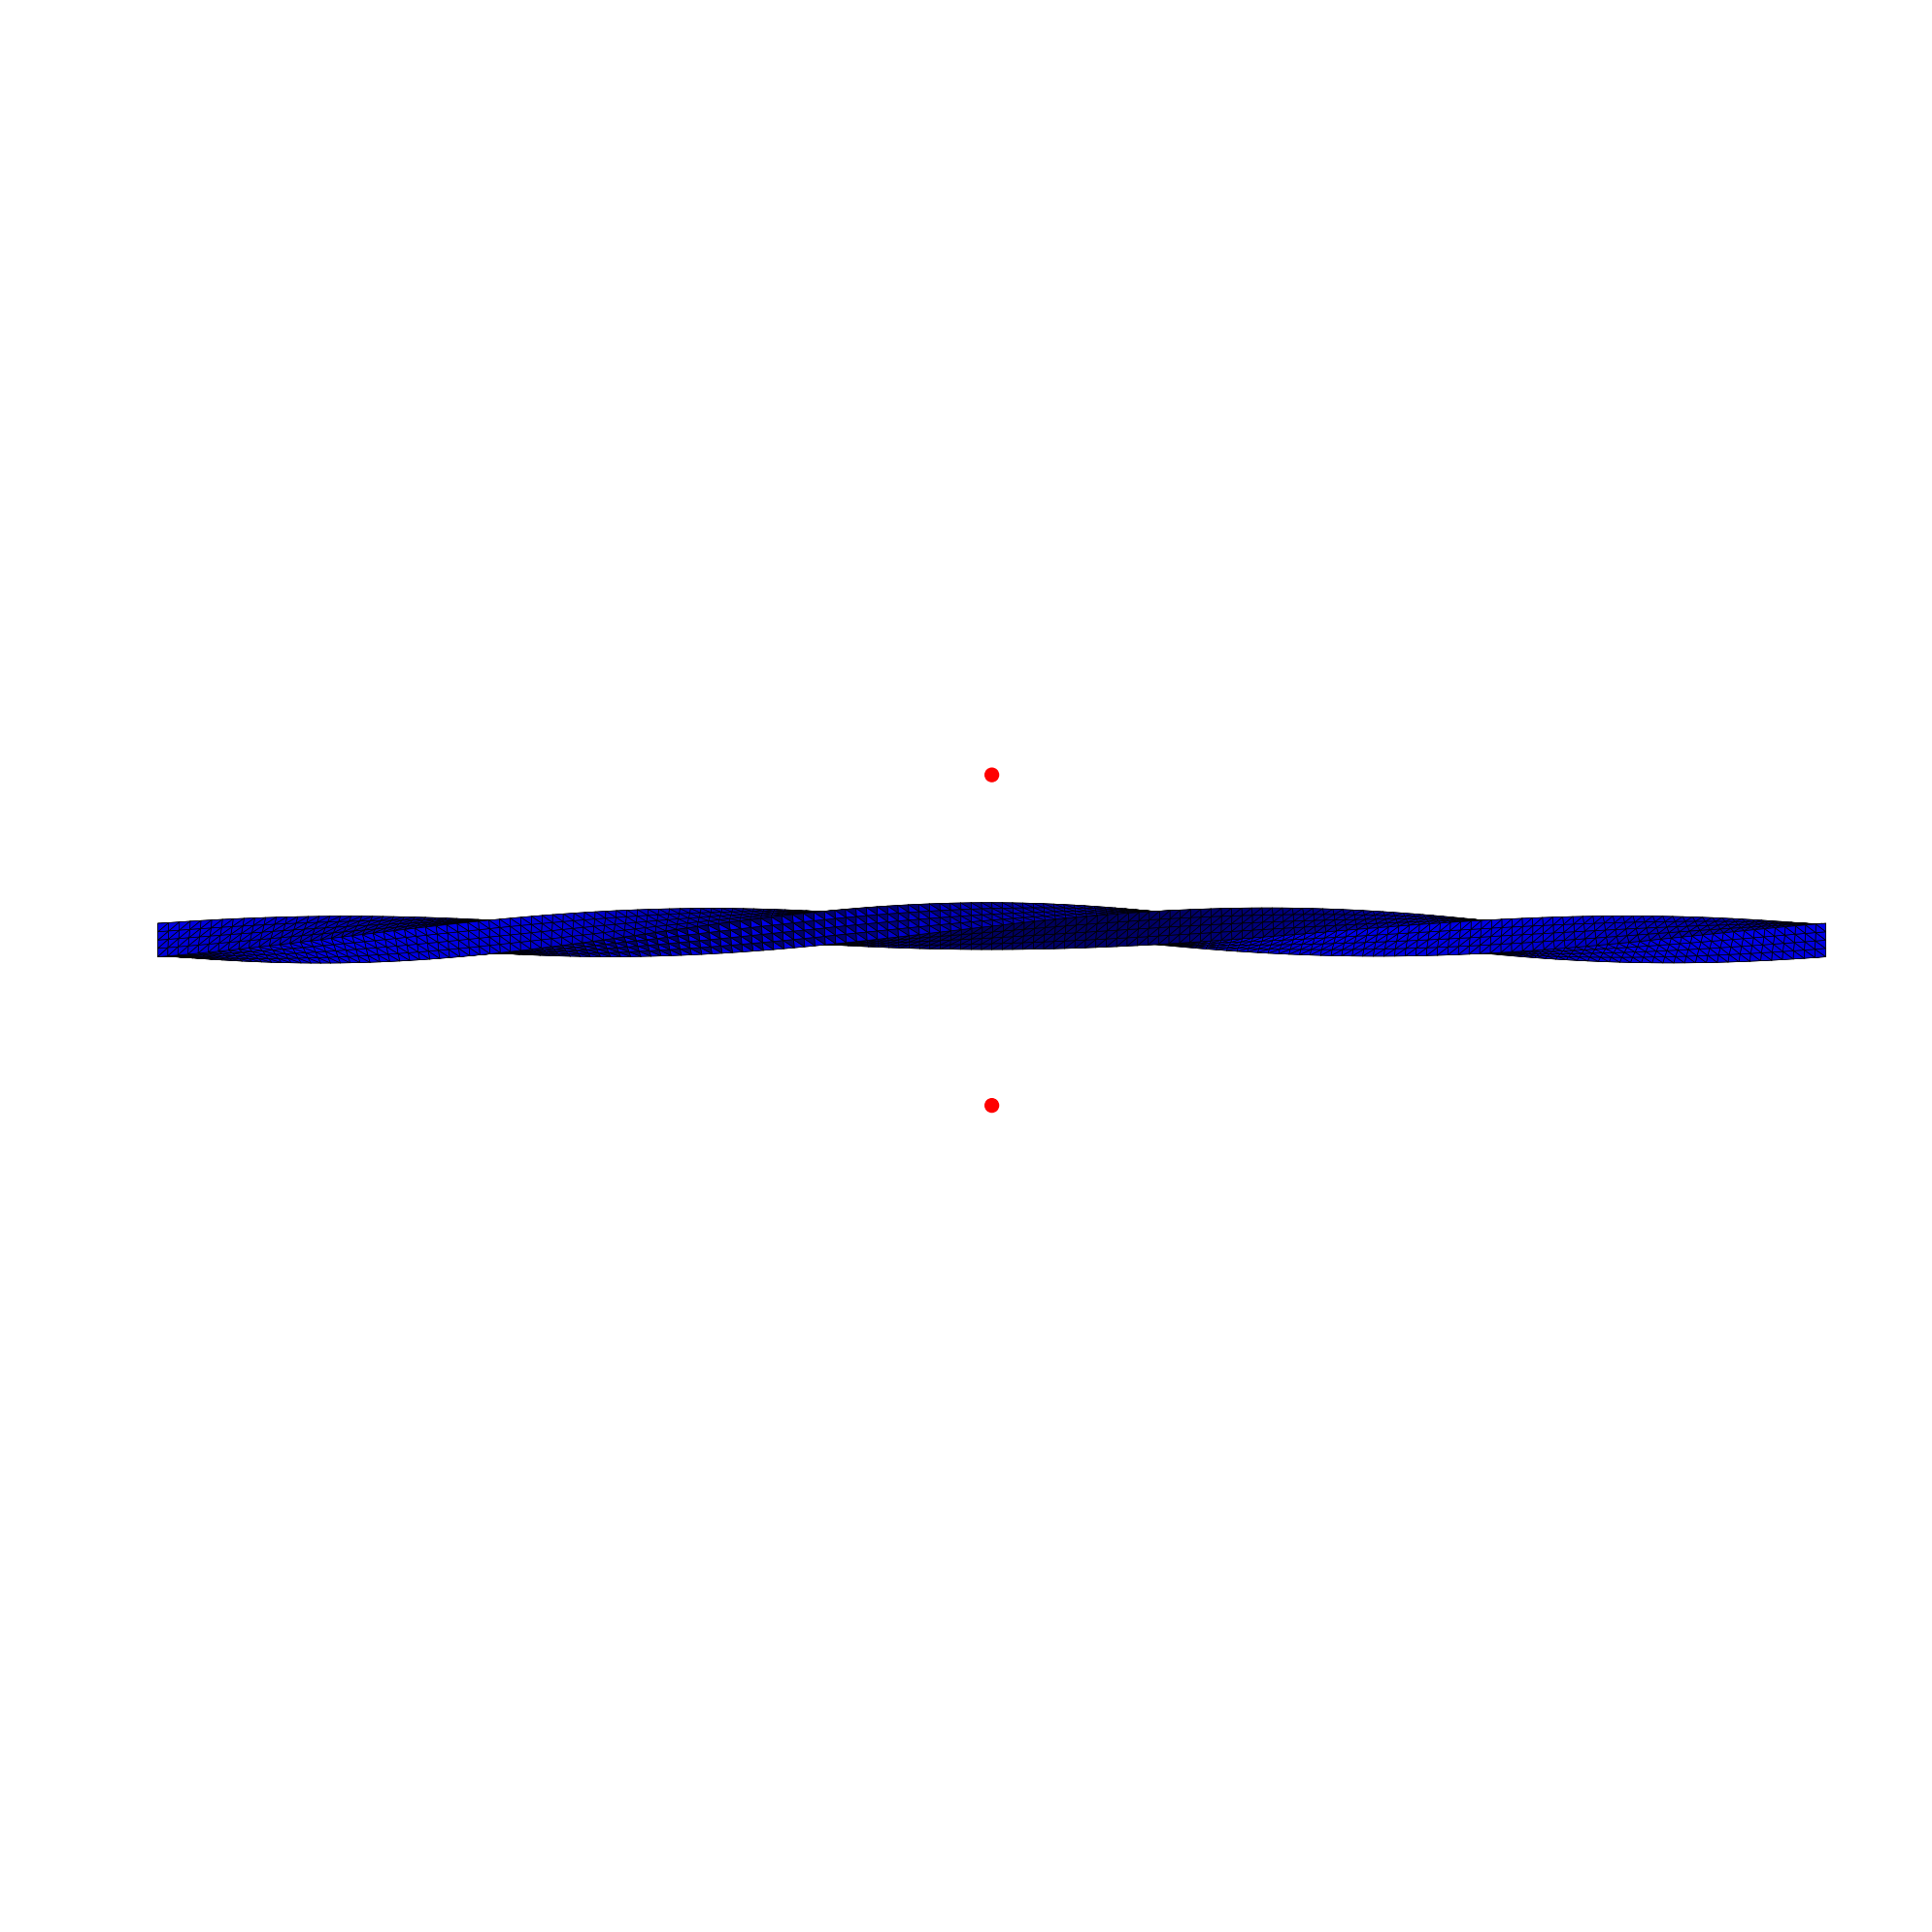

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 12.966046860378276
        x: [ 2.517e-03 -4.750e-03 ... -6.721e-03  2.160e-03]
      nit: 4191
      jac: [ 4.527e-03 -3.246e-04 ... -4.503e-06  1.903e-03]
     nfev: 4307
     njev: 4307
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


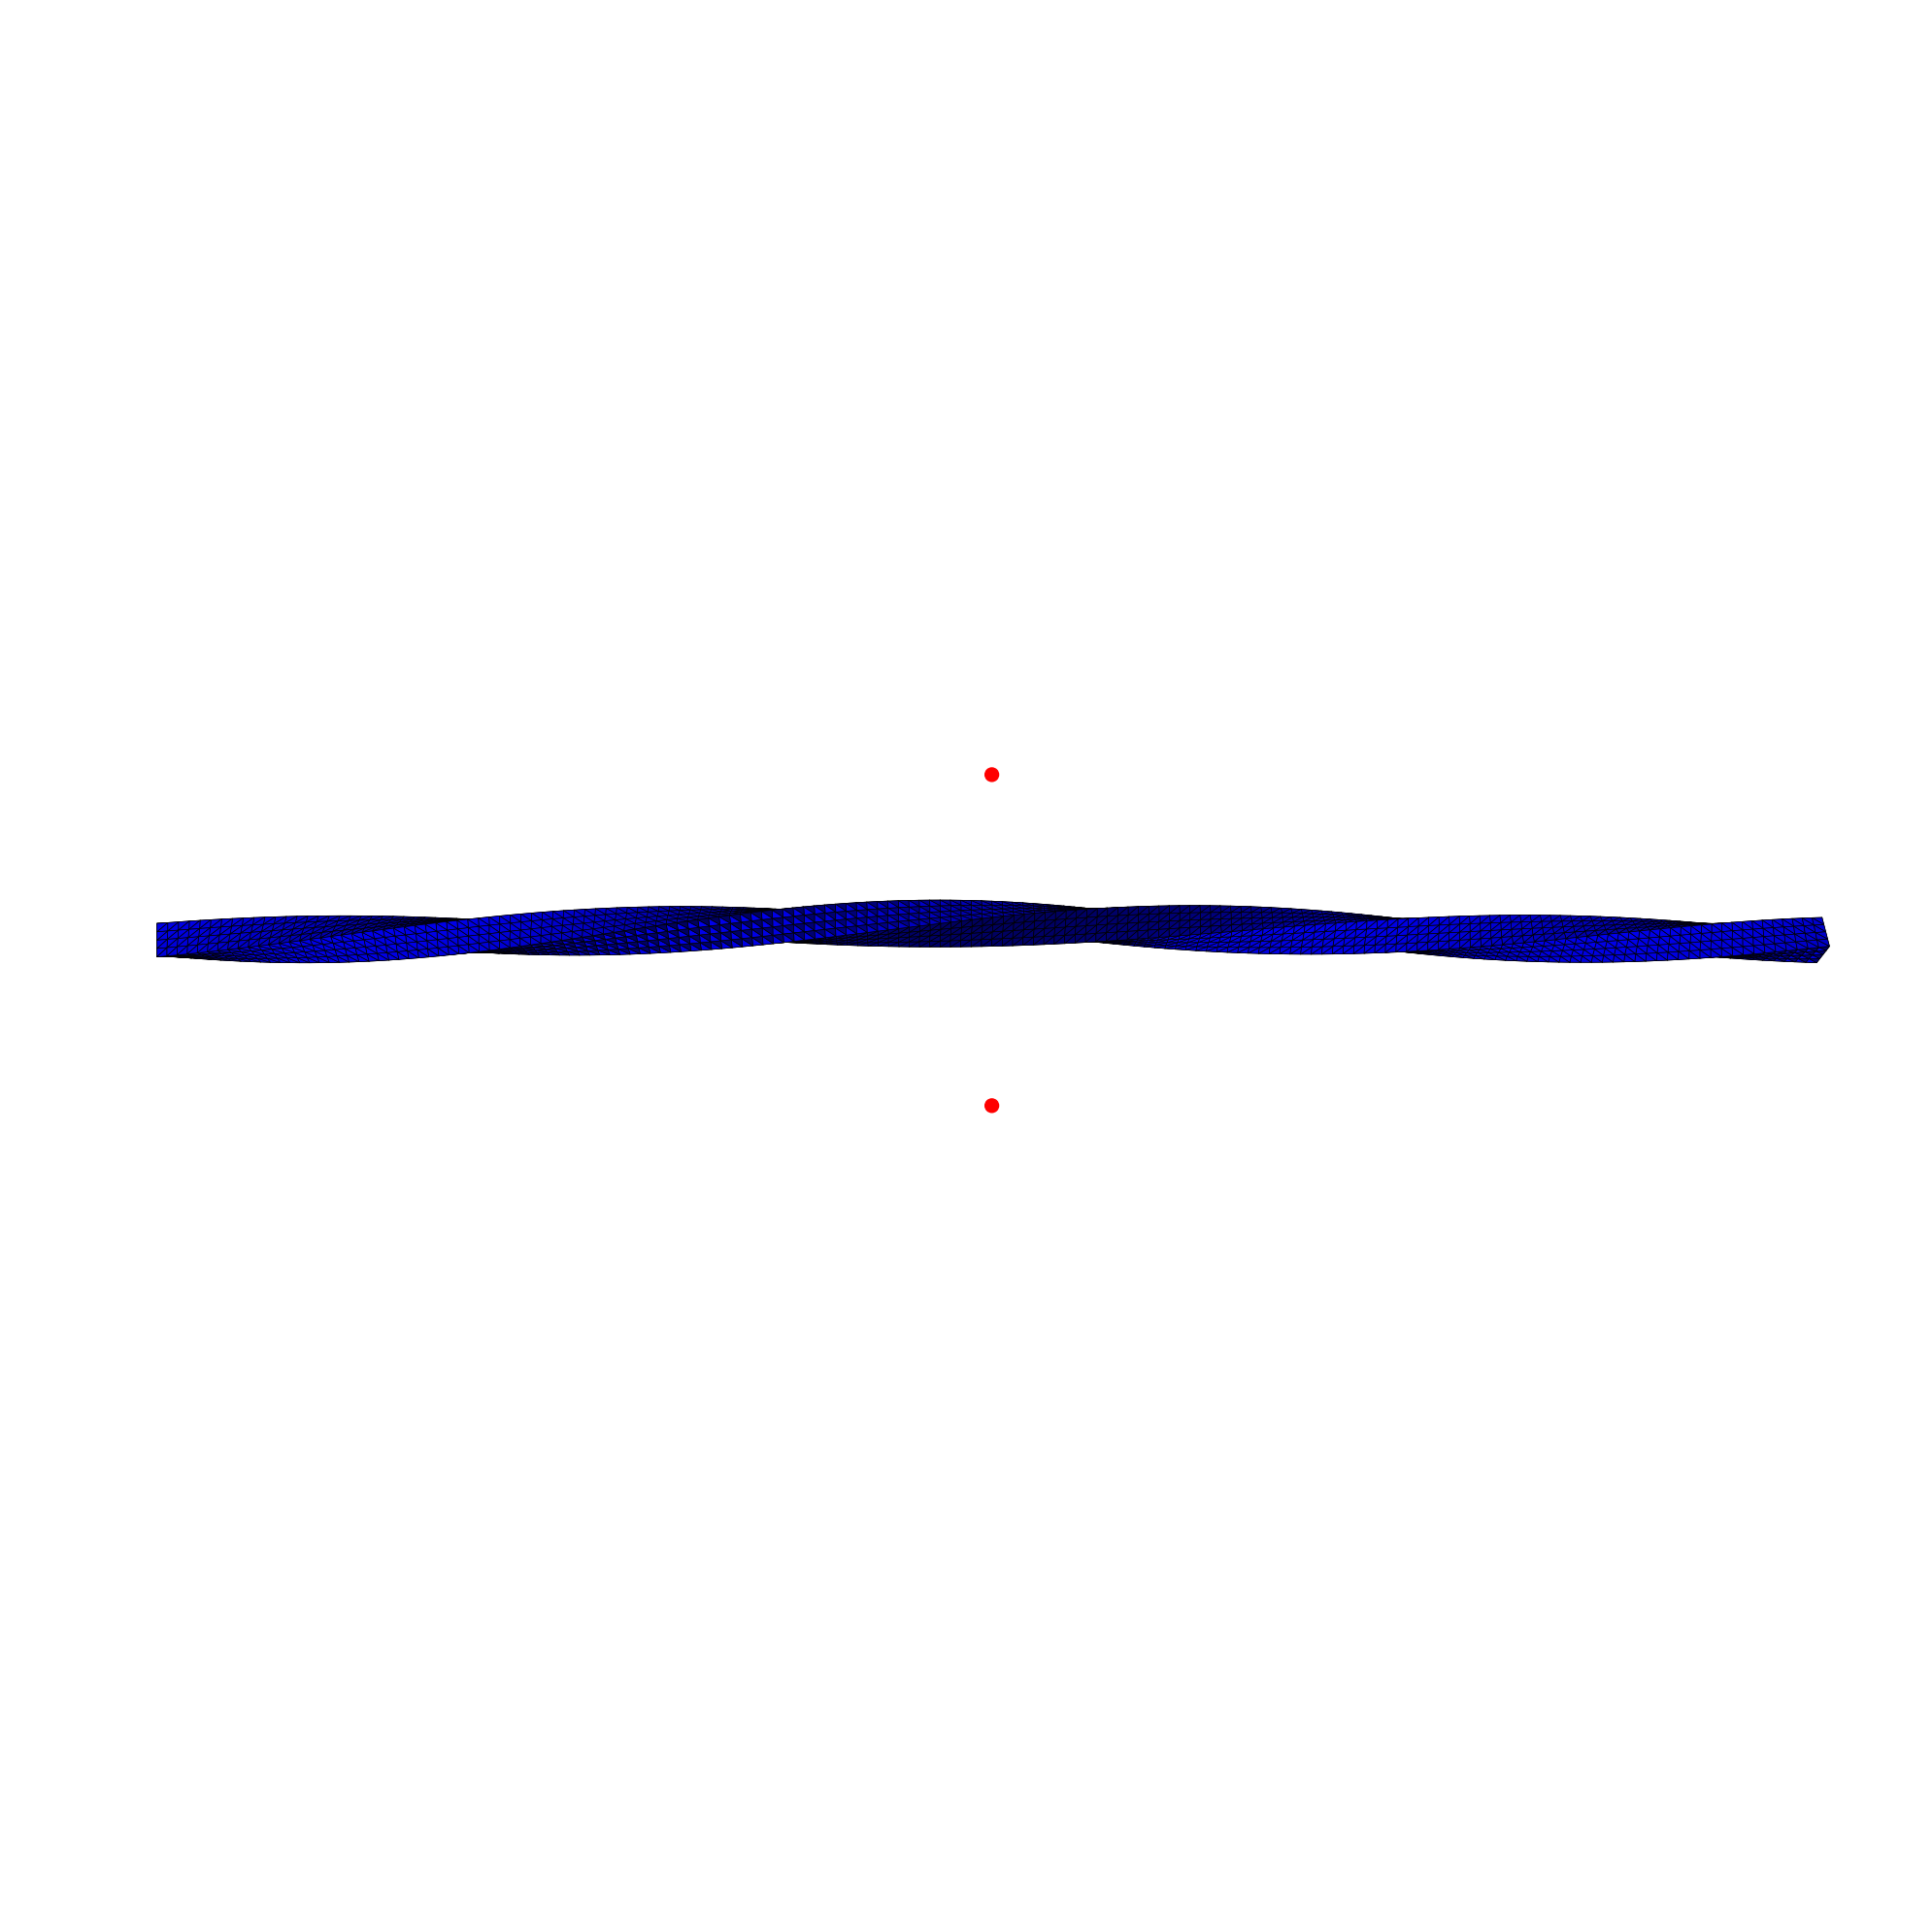

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 14.63591989684057
        x: [ 2.520e-03 -4.733e-03 ... -6.905e-03 -1.469e-03]
      nit: 4337
      jac: [ 5.424e-03  3.910e-03 ...  5.027e-03  9.896e-03]
     nfev: 4465
     njev: 4465
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


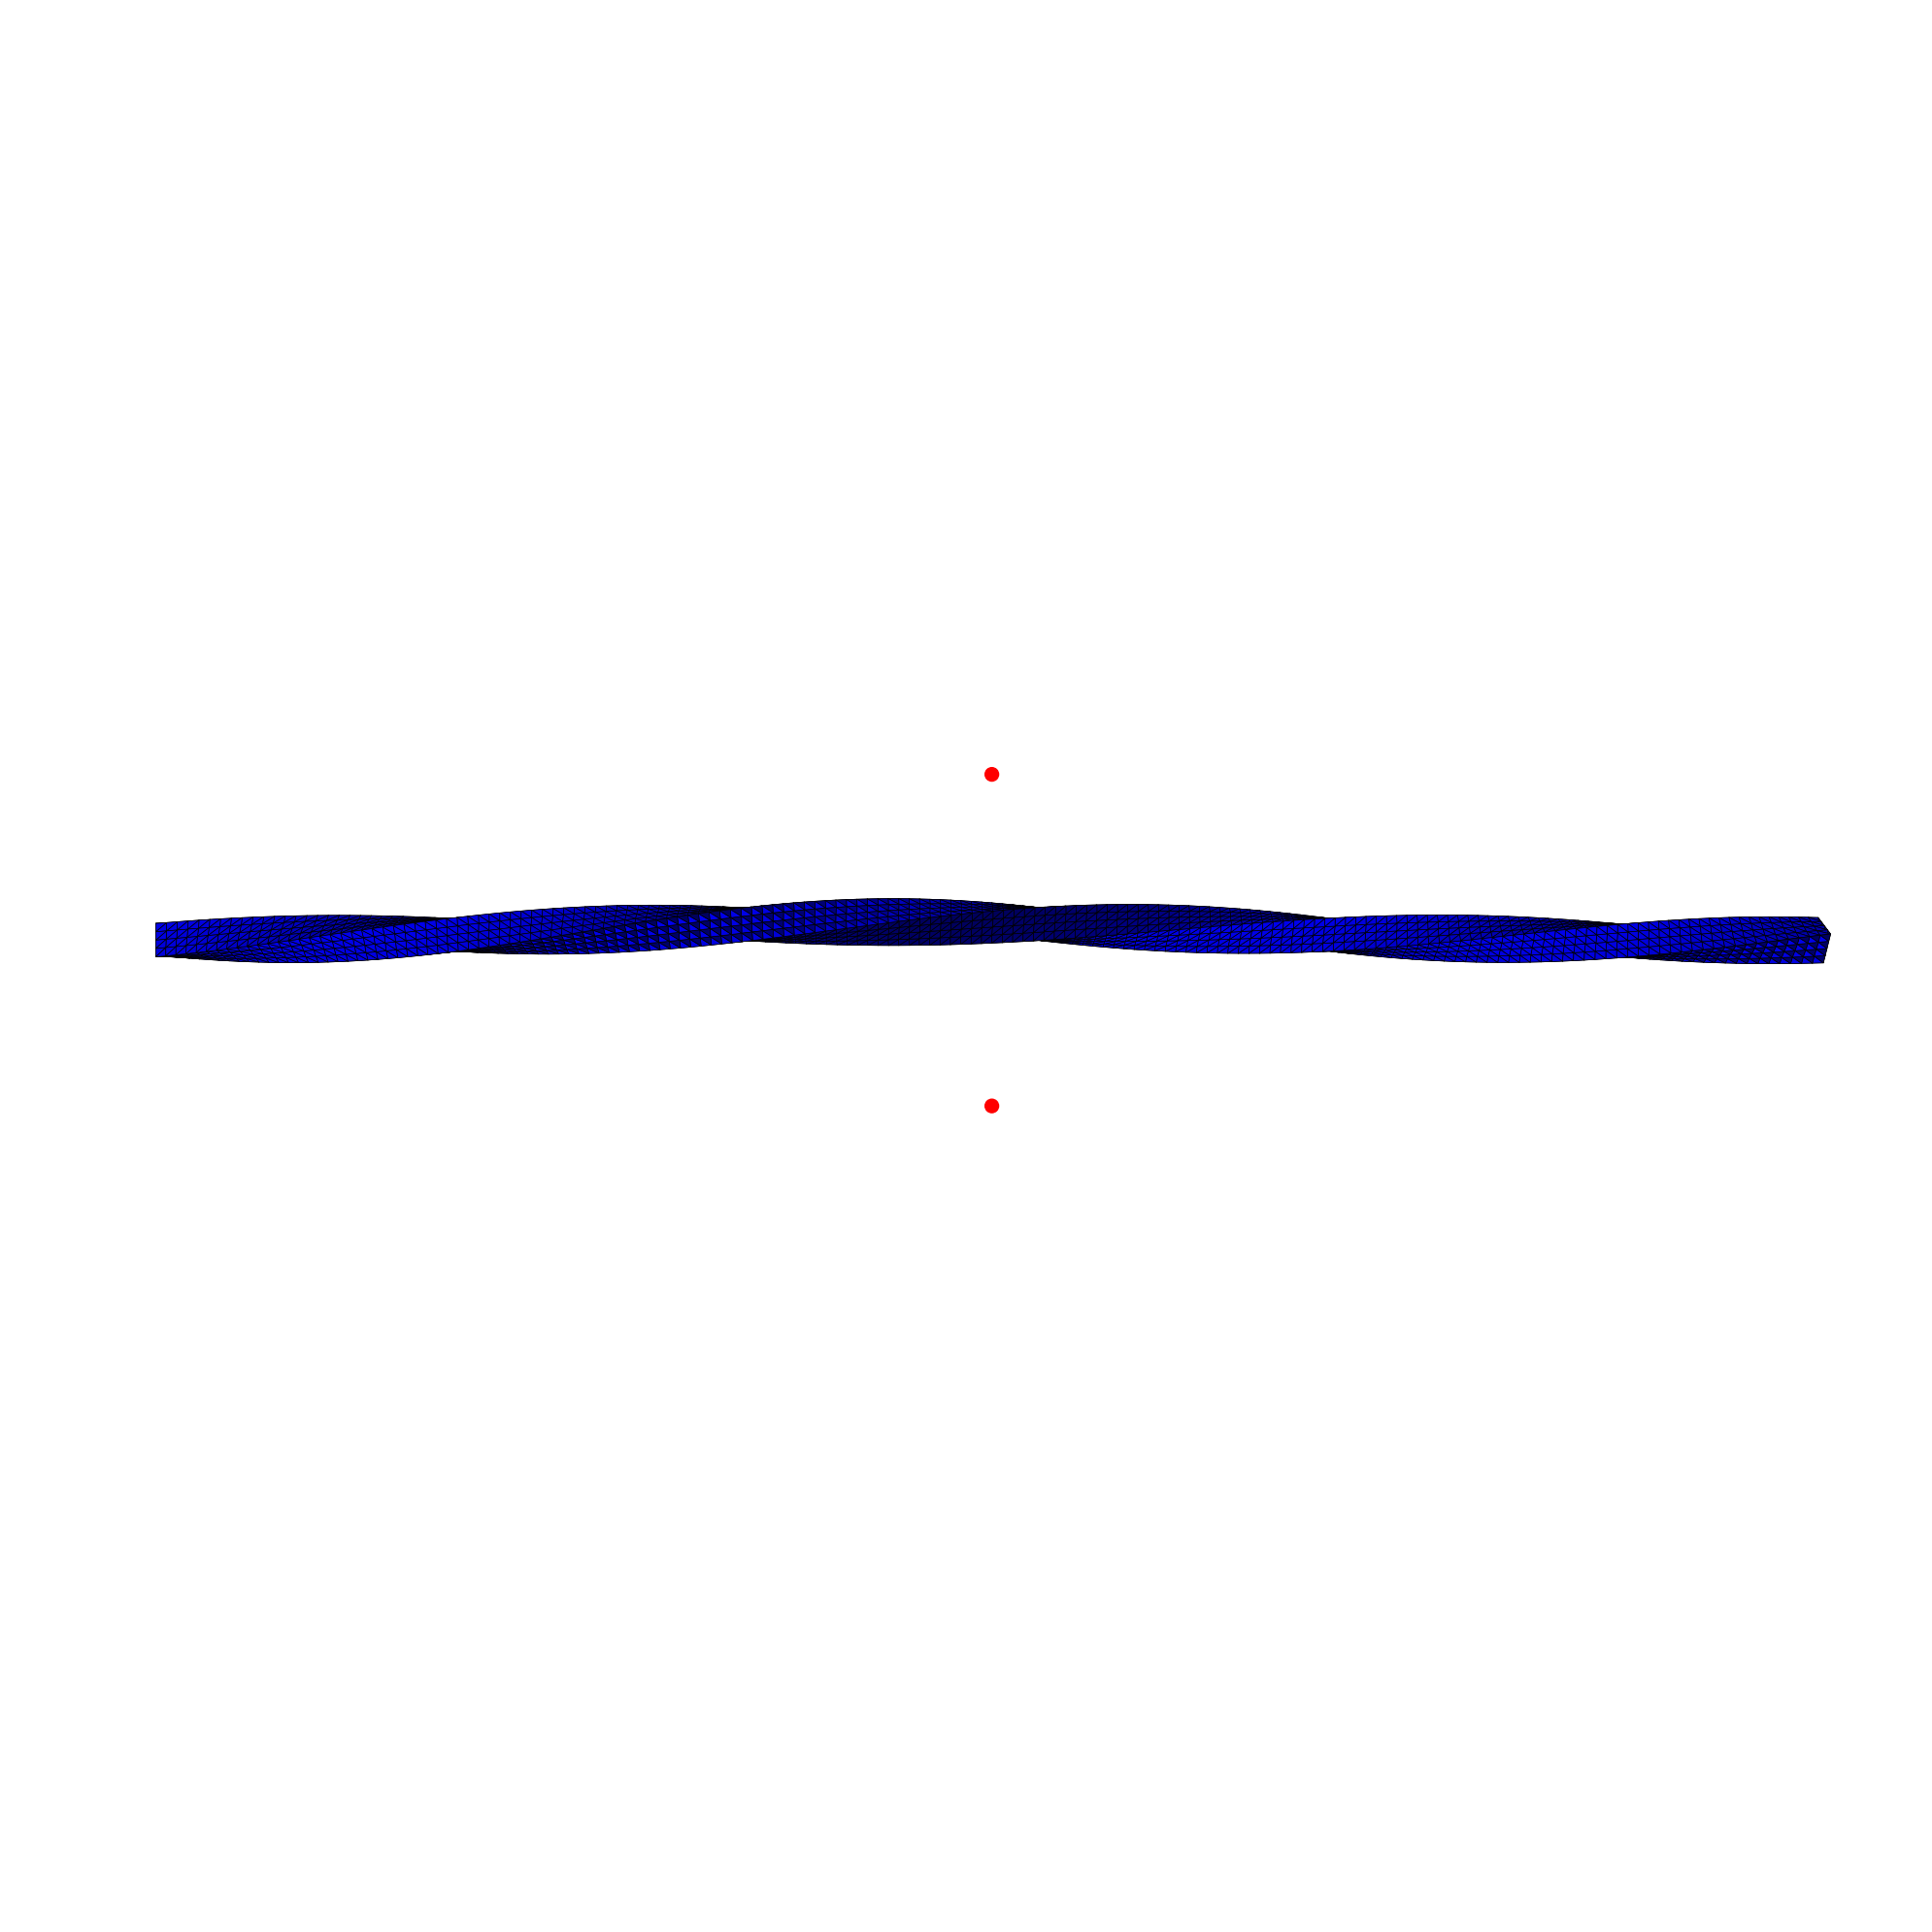

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 16.406999025856393
        x: [ 2.521e-03 -4.717e-03 ... -5.259e-03 -4.707e-03]
      nit: 4356
      jac: [ 5.622e-04 -1.180e-03 ...  4.474e-03 -1.988e-03]
     nfev: 4488
     njev: 4488
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


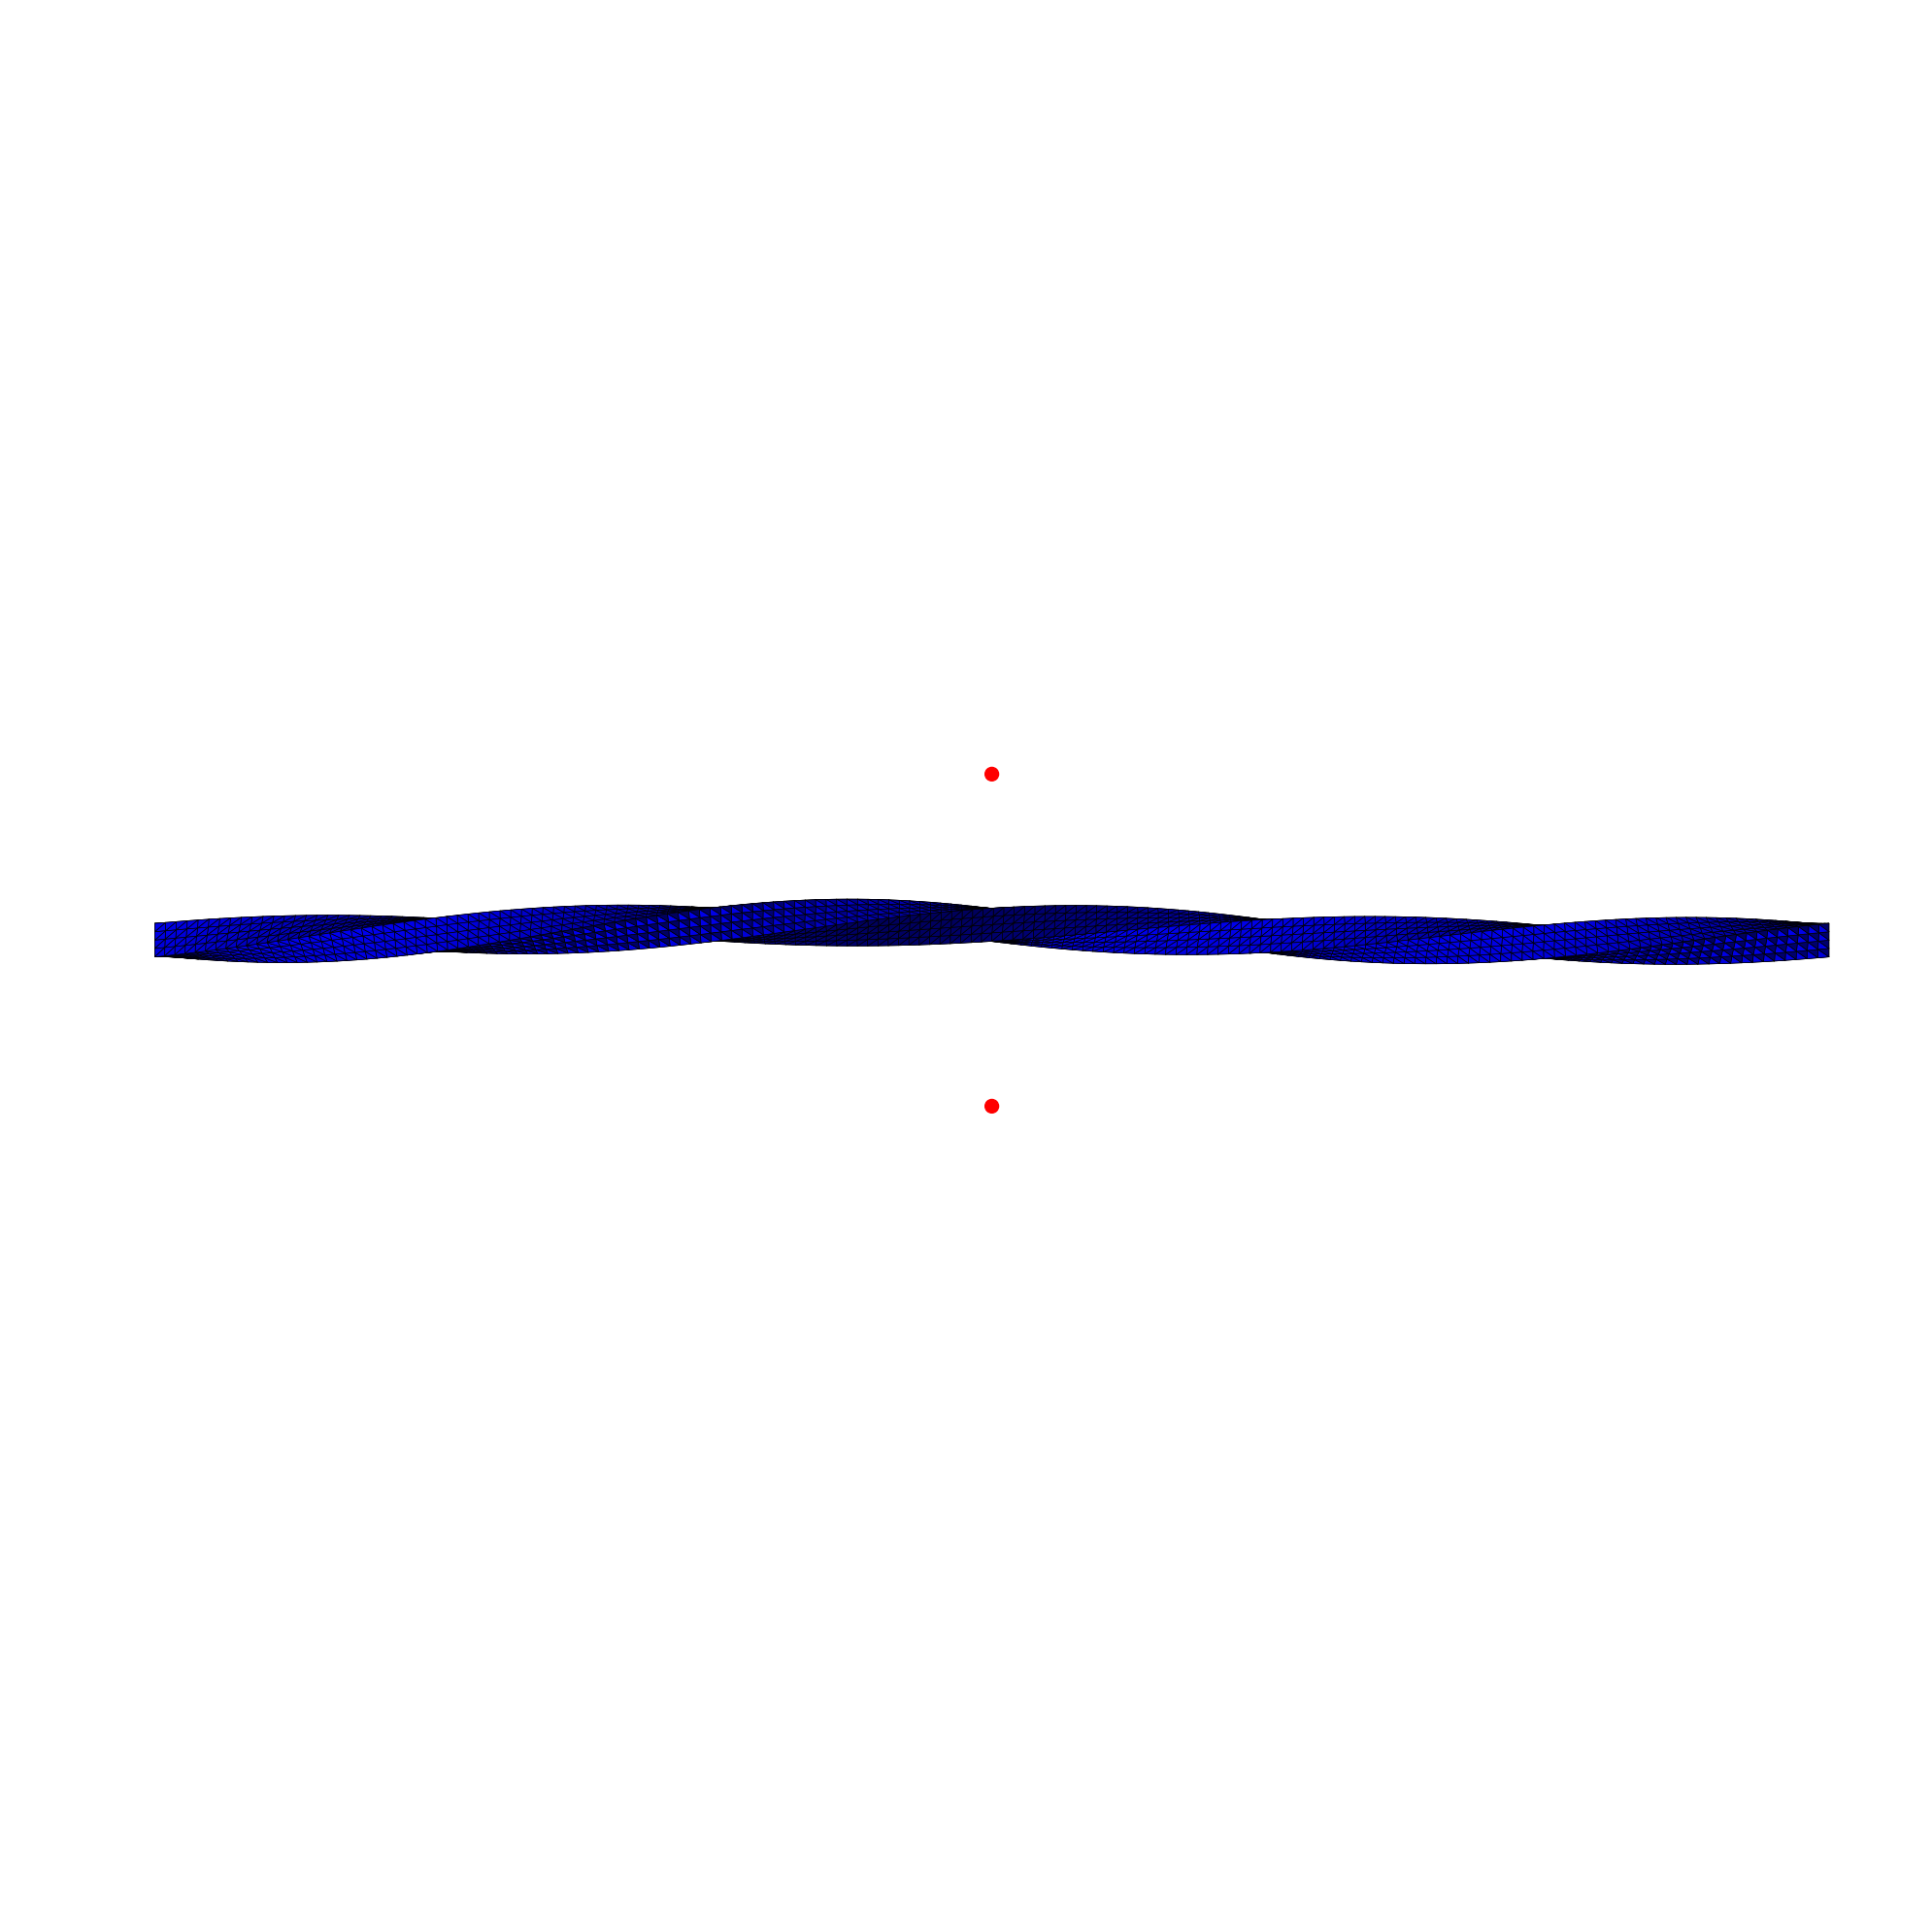

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18.279323255856134
        x: [ 2.522e-03 -4.700e-03 ... -2.220e-03 -6.698e-03]
      nit: 4897
      jac: [-4.241e-03  3.140e-03 ... -2.518e-03  1.747e-03]
     nfev: 5043
     njev: 5043
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


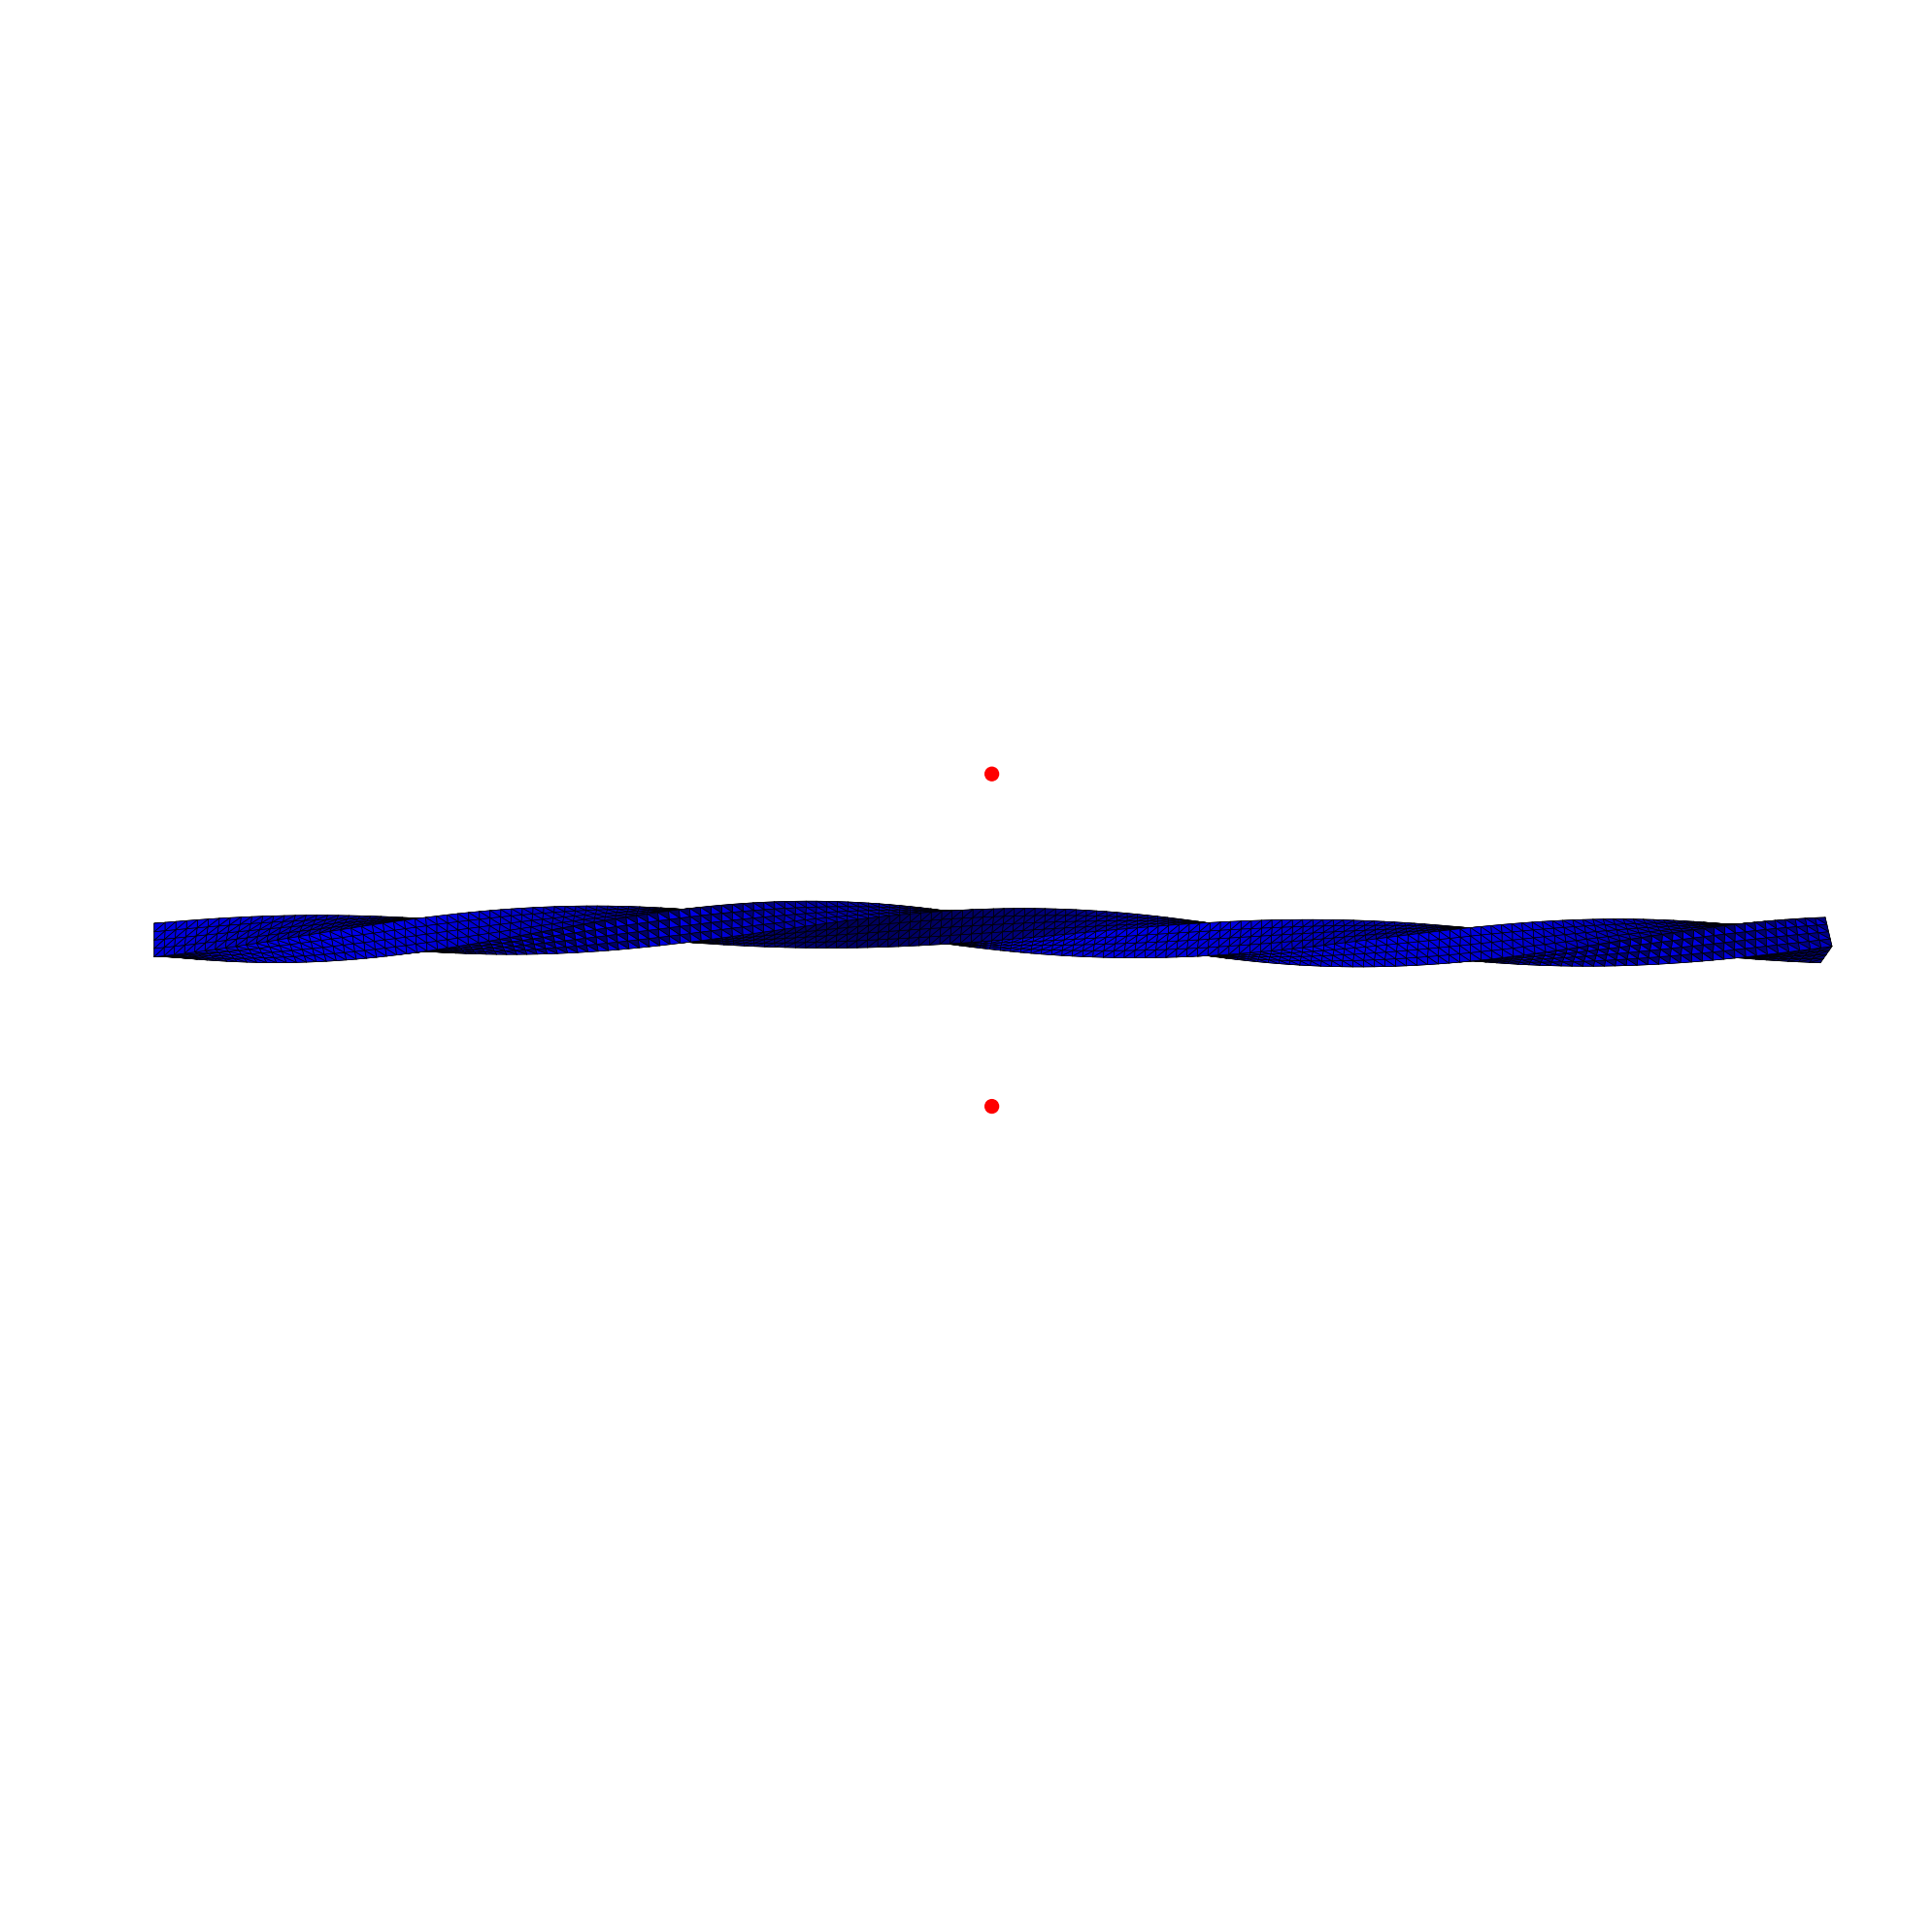

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 20.253425532003668
        x: [ 2.525e-03 -4.683e-03 ...  1.404e-03 -6.912e-03]
      nit: 2599
      jac: [ 3.283e-03 -3.933e-03 ...  5.201e-03 -2.353e-03]
     nfev: 2685
     njev: 2685
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


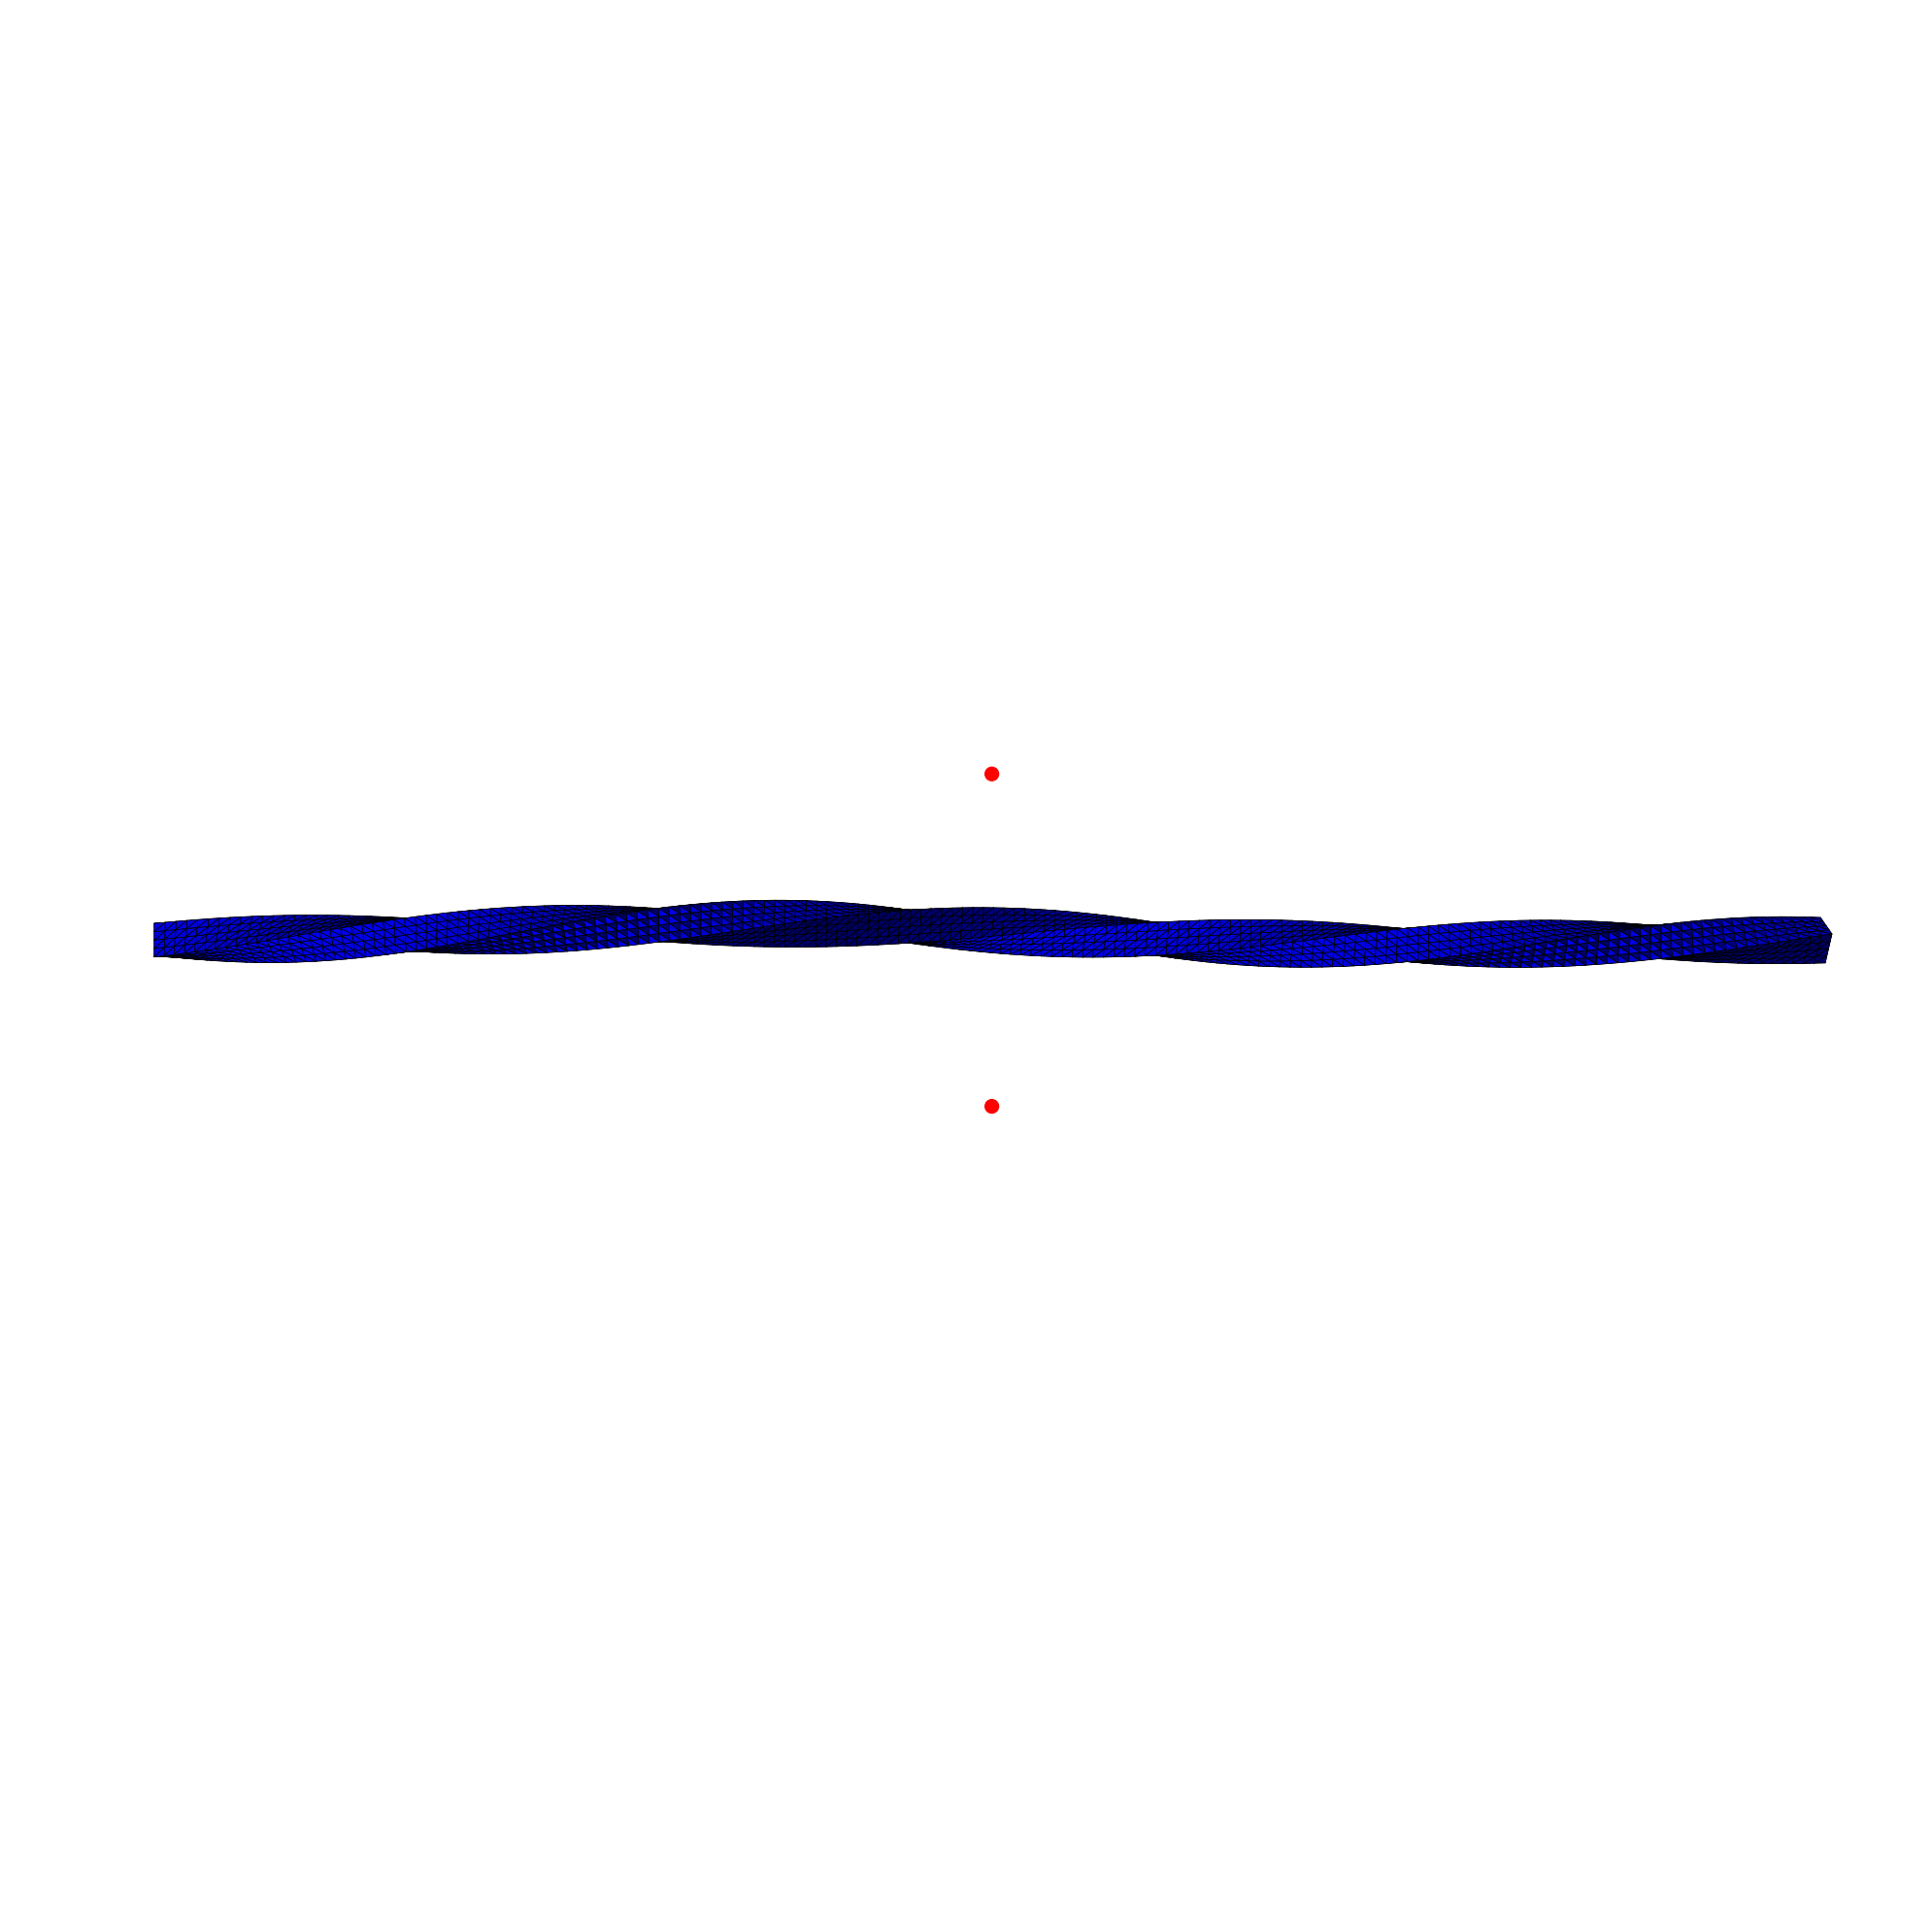

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 22.327998740246944
        x: [ 2.523e-03 -4.668e-03 ...  4.655e-03 -5.297e-03]
      nit: 5410
      jac: [-3.186e-03  5.956e-03 ...  2.732e-03  4.396e-03]
     nfev: 5568
     njev: 5568
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


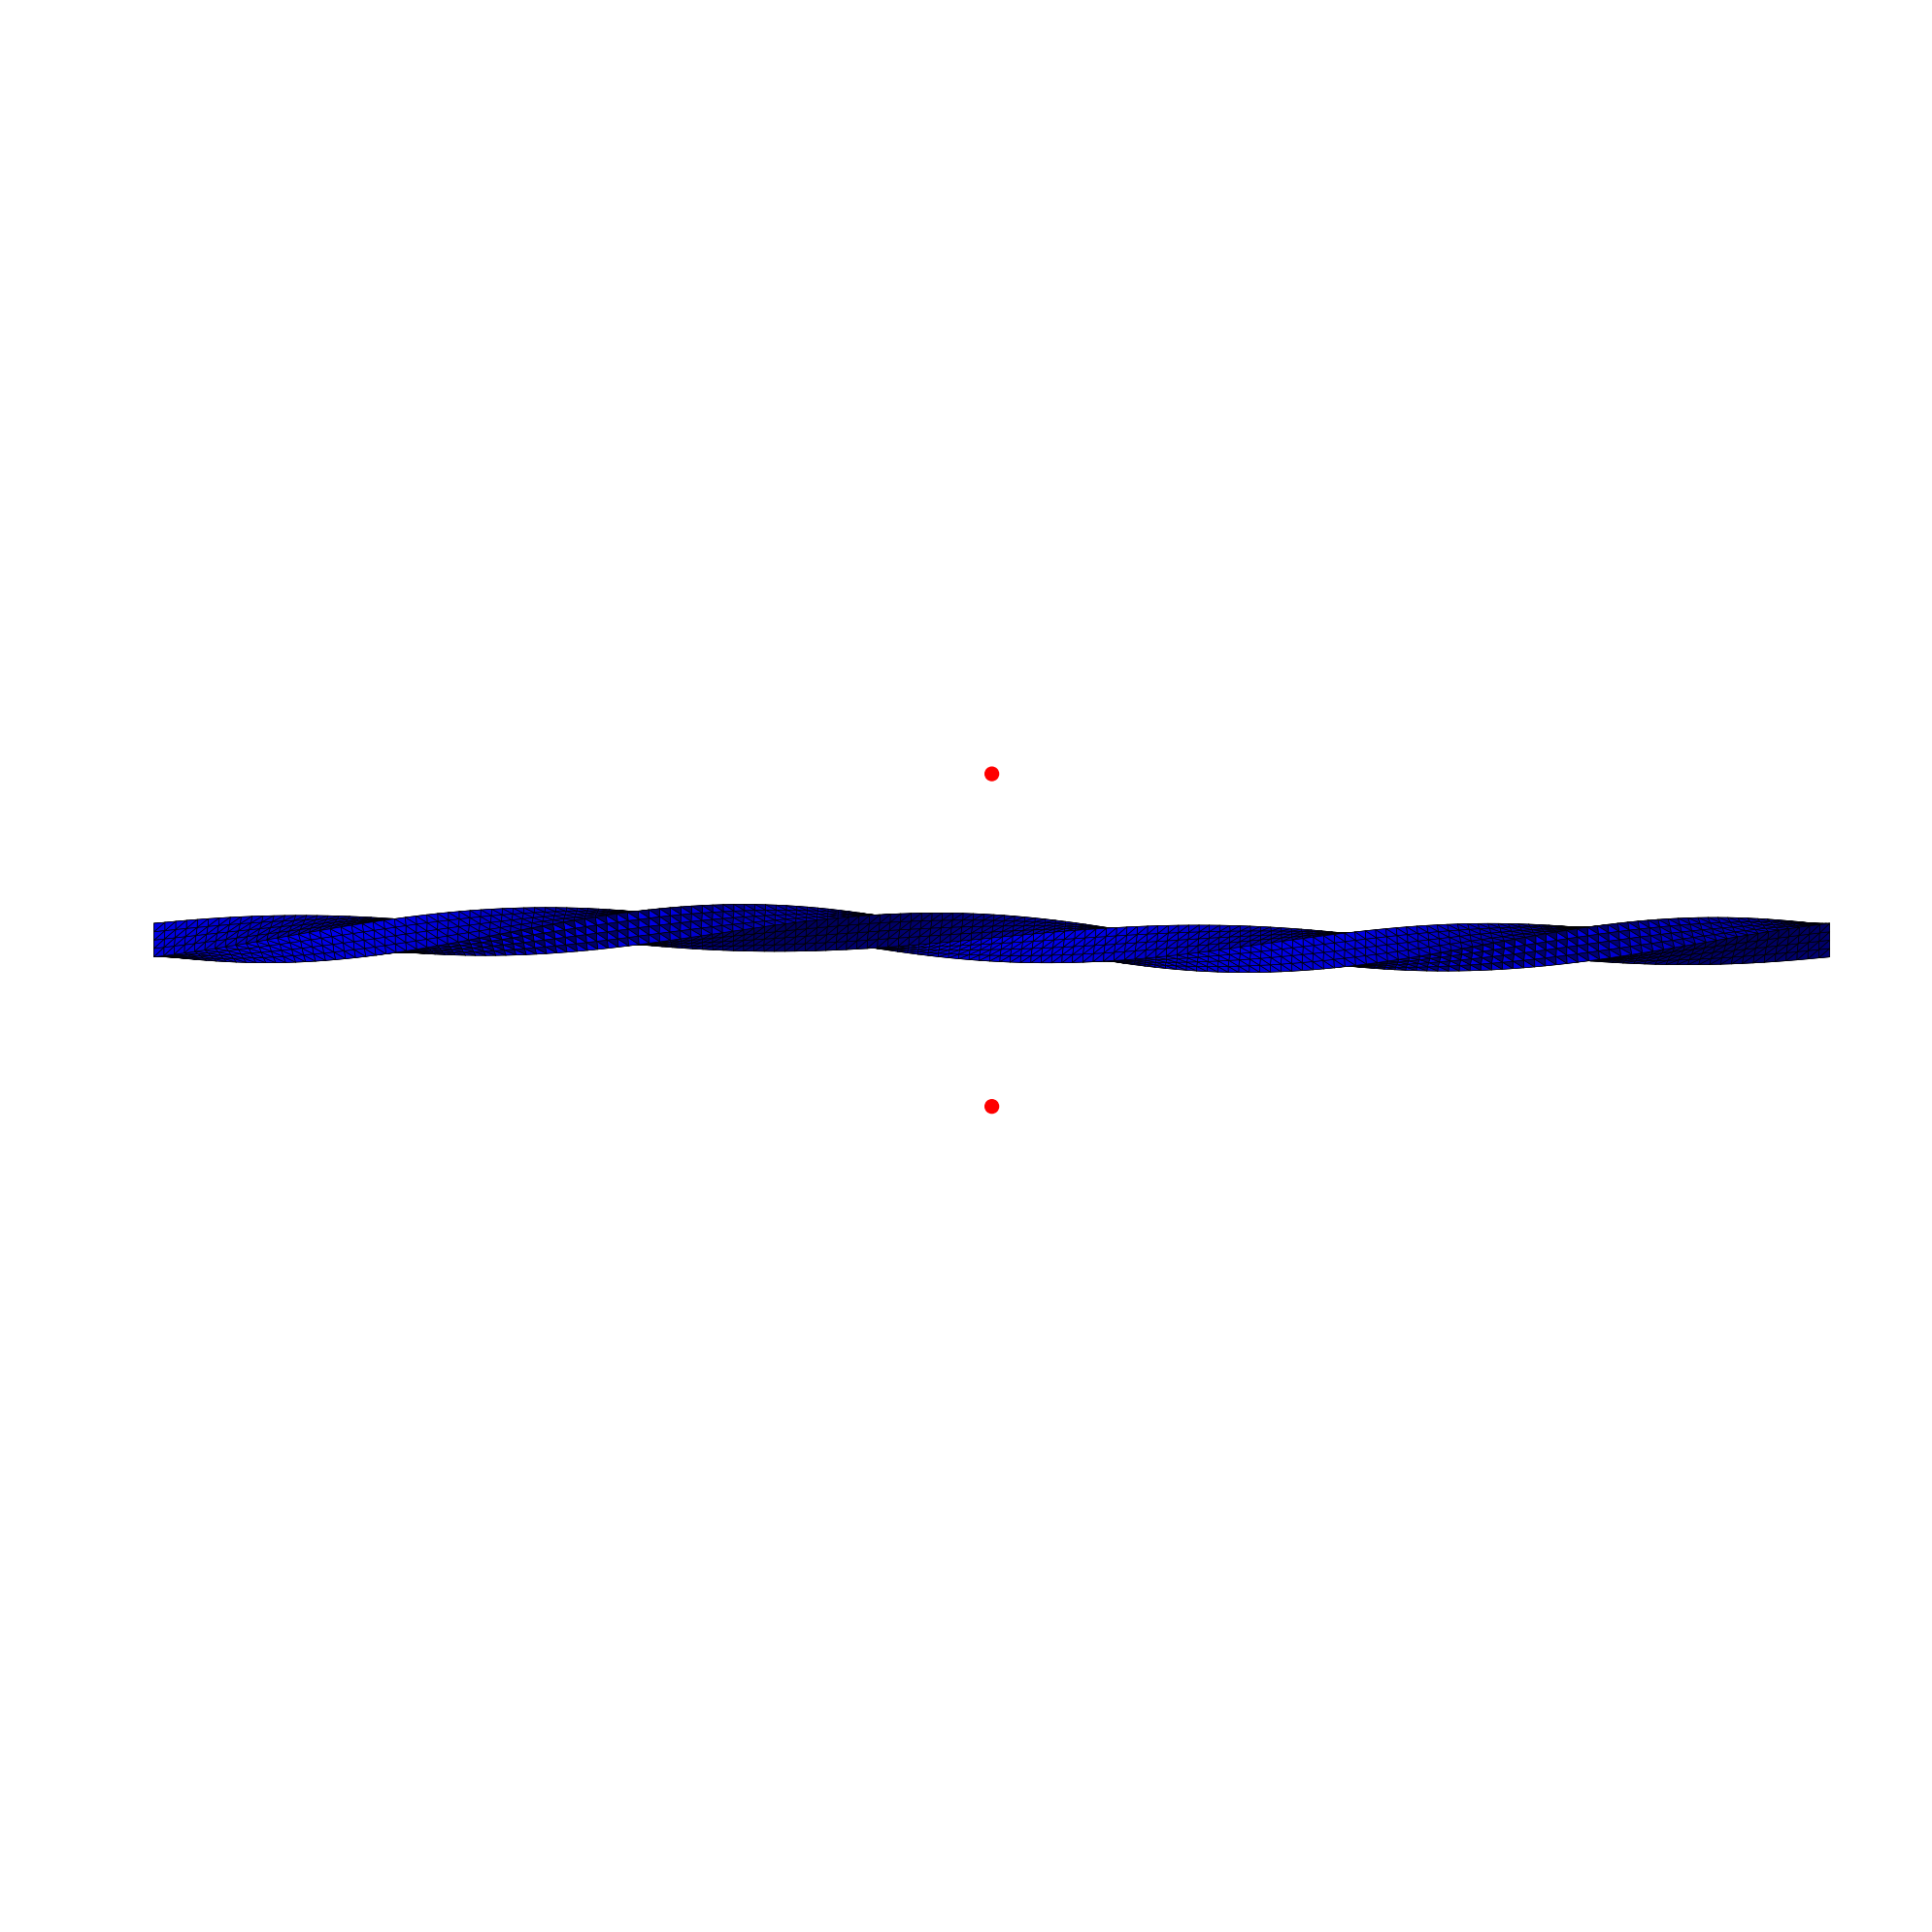

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 24.504853813661185
        x: [ 2.527e-03 -4.650e-03 ...  6.669e-03 -2.279e-03]
      nit: 2848
      jac: [ 4.845e-03  2.694e-03 ... -1.683e-04 -3.941e-03]
     nfev: 2926
     njev: 2926
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


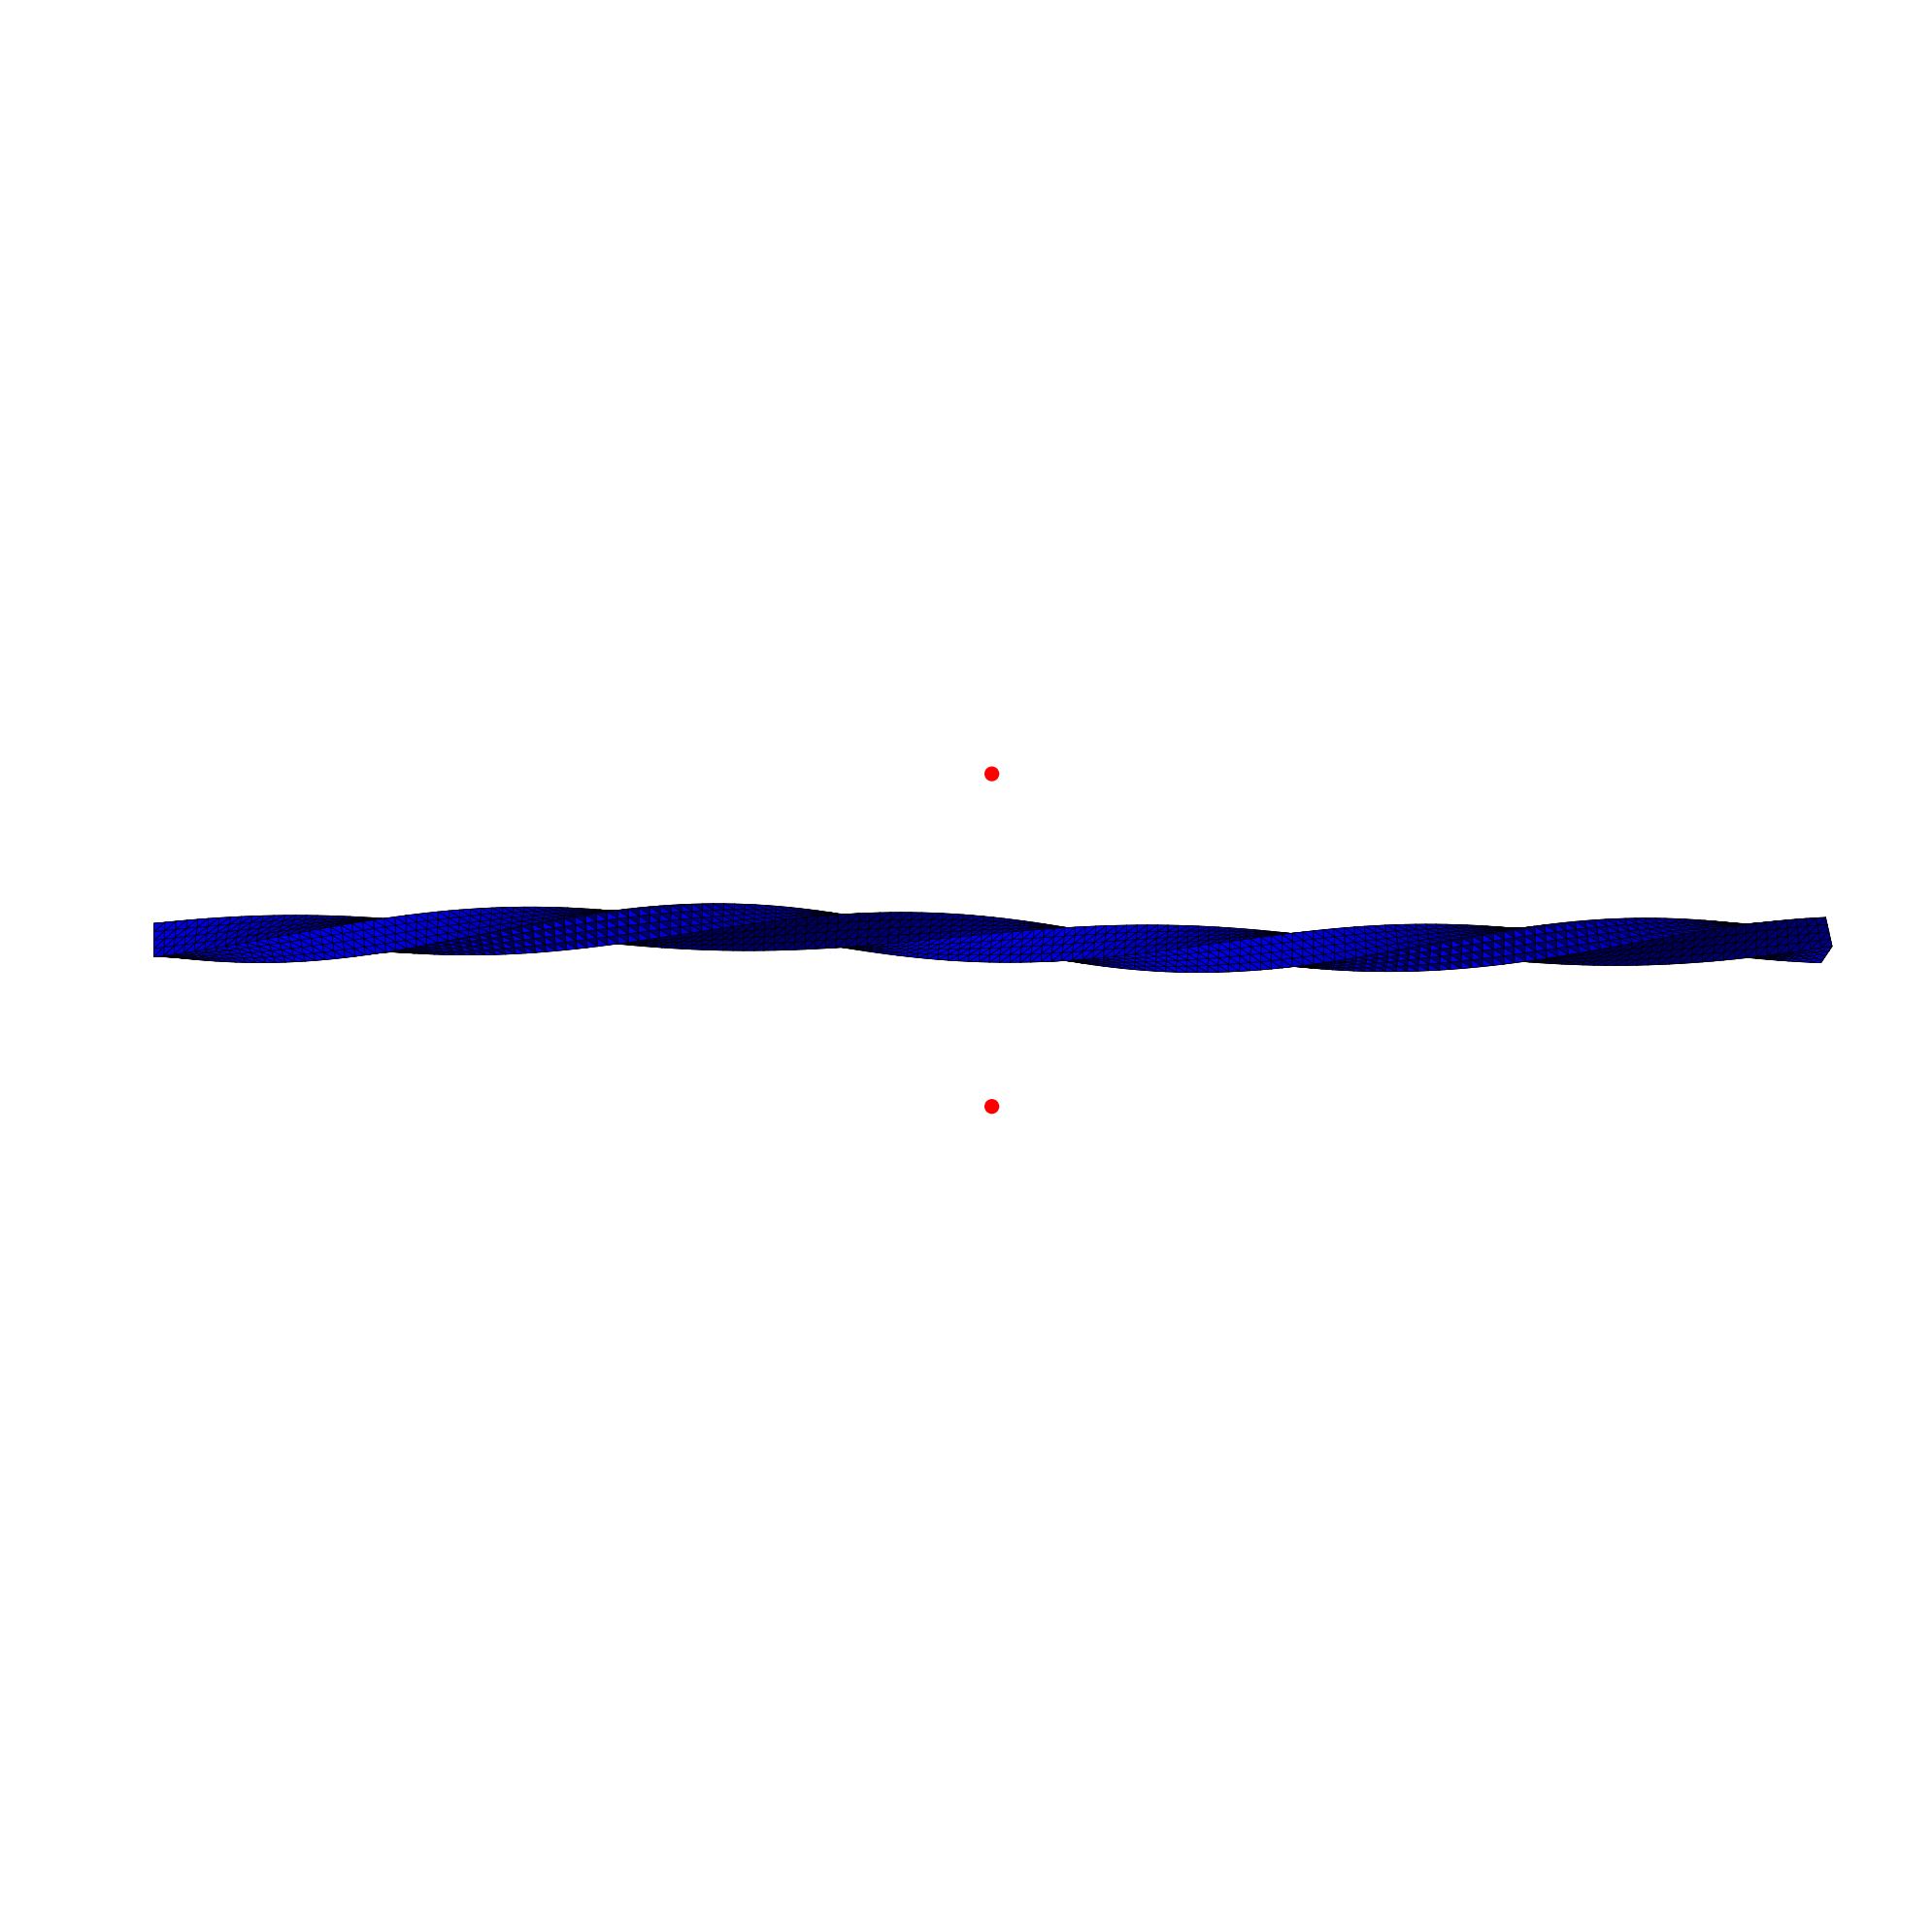

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 26.78187497146767
        x: [ 2.522e-03 -4.636e-03 ...  6.918e-03  1.339e-03]
      nit: 4659
      jac: [-1.577e-03 -2.363e-03 ... -1.307e-03 -7.923e-03]
     nfev: 4814
     njev: 4814
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


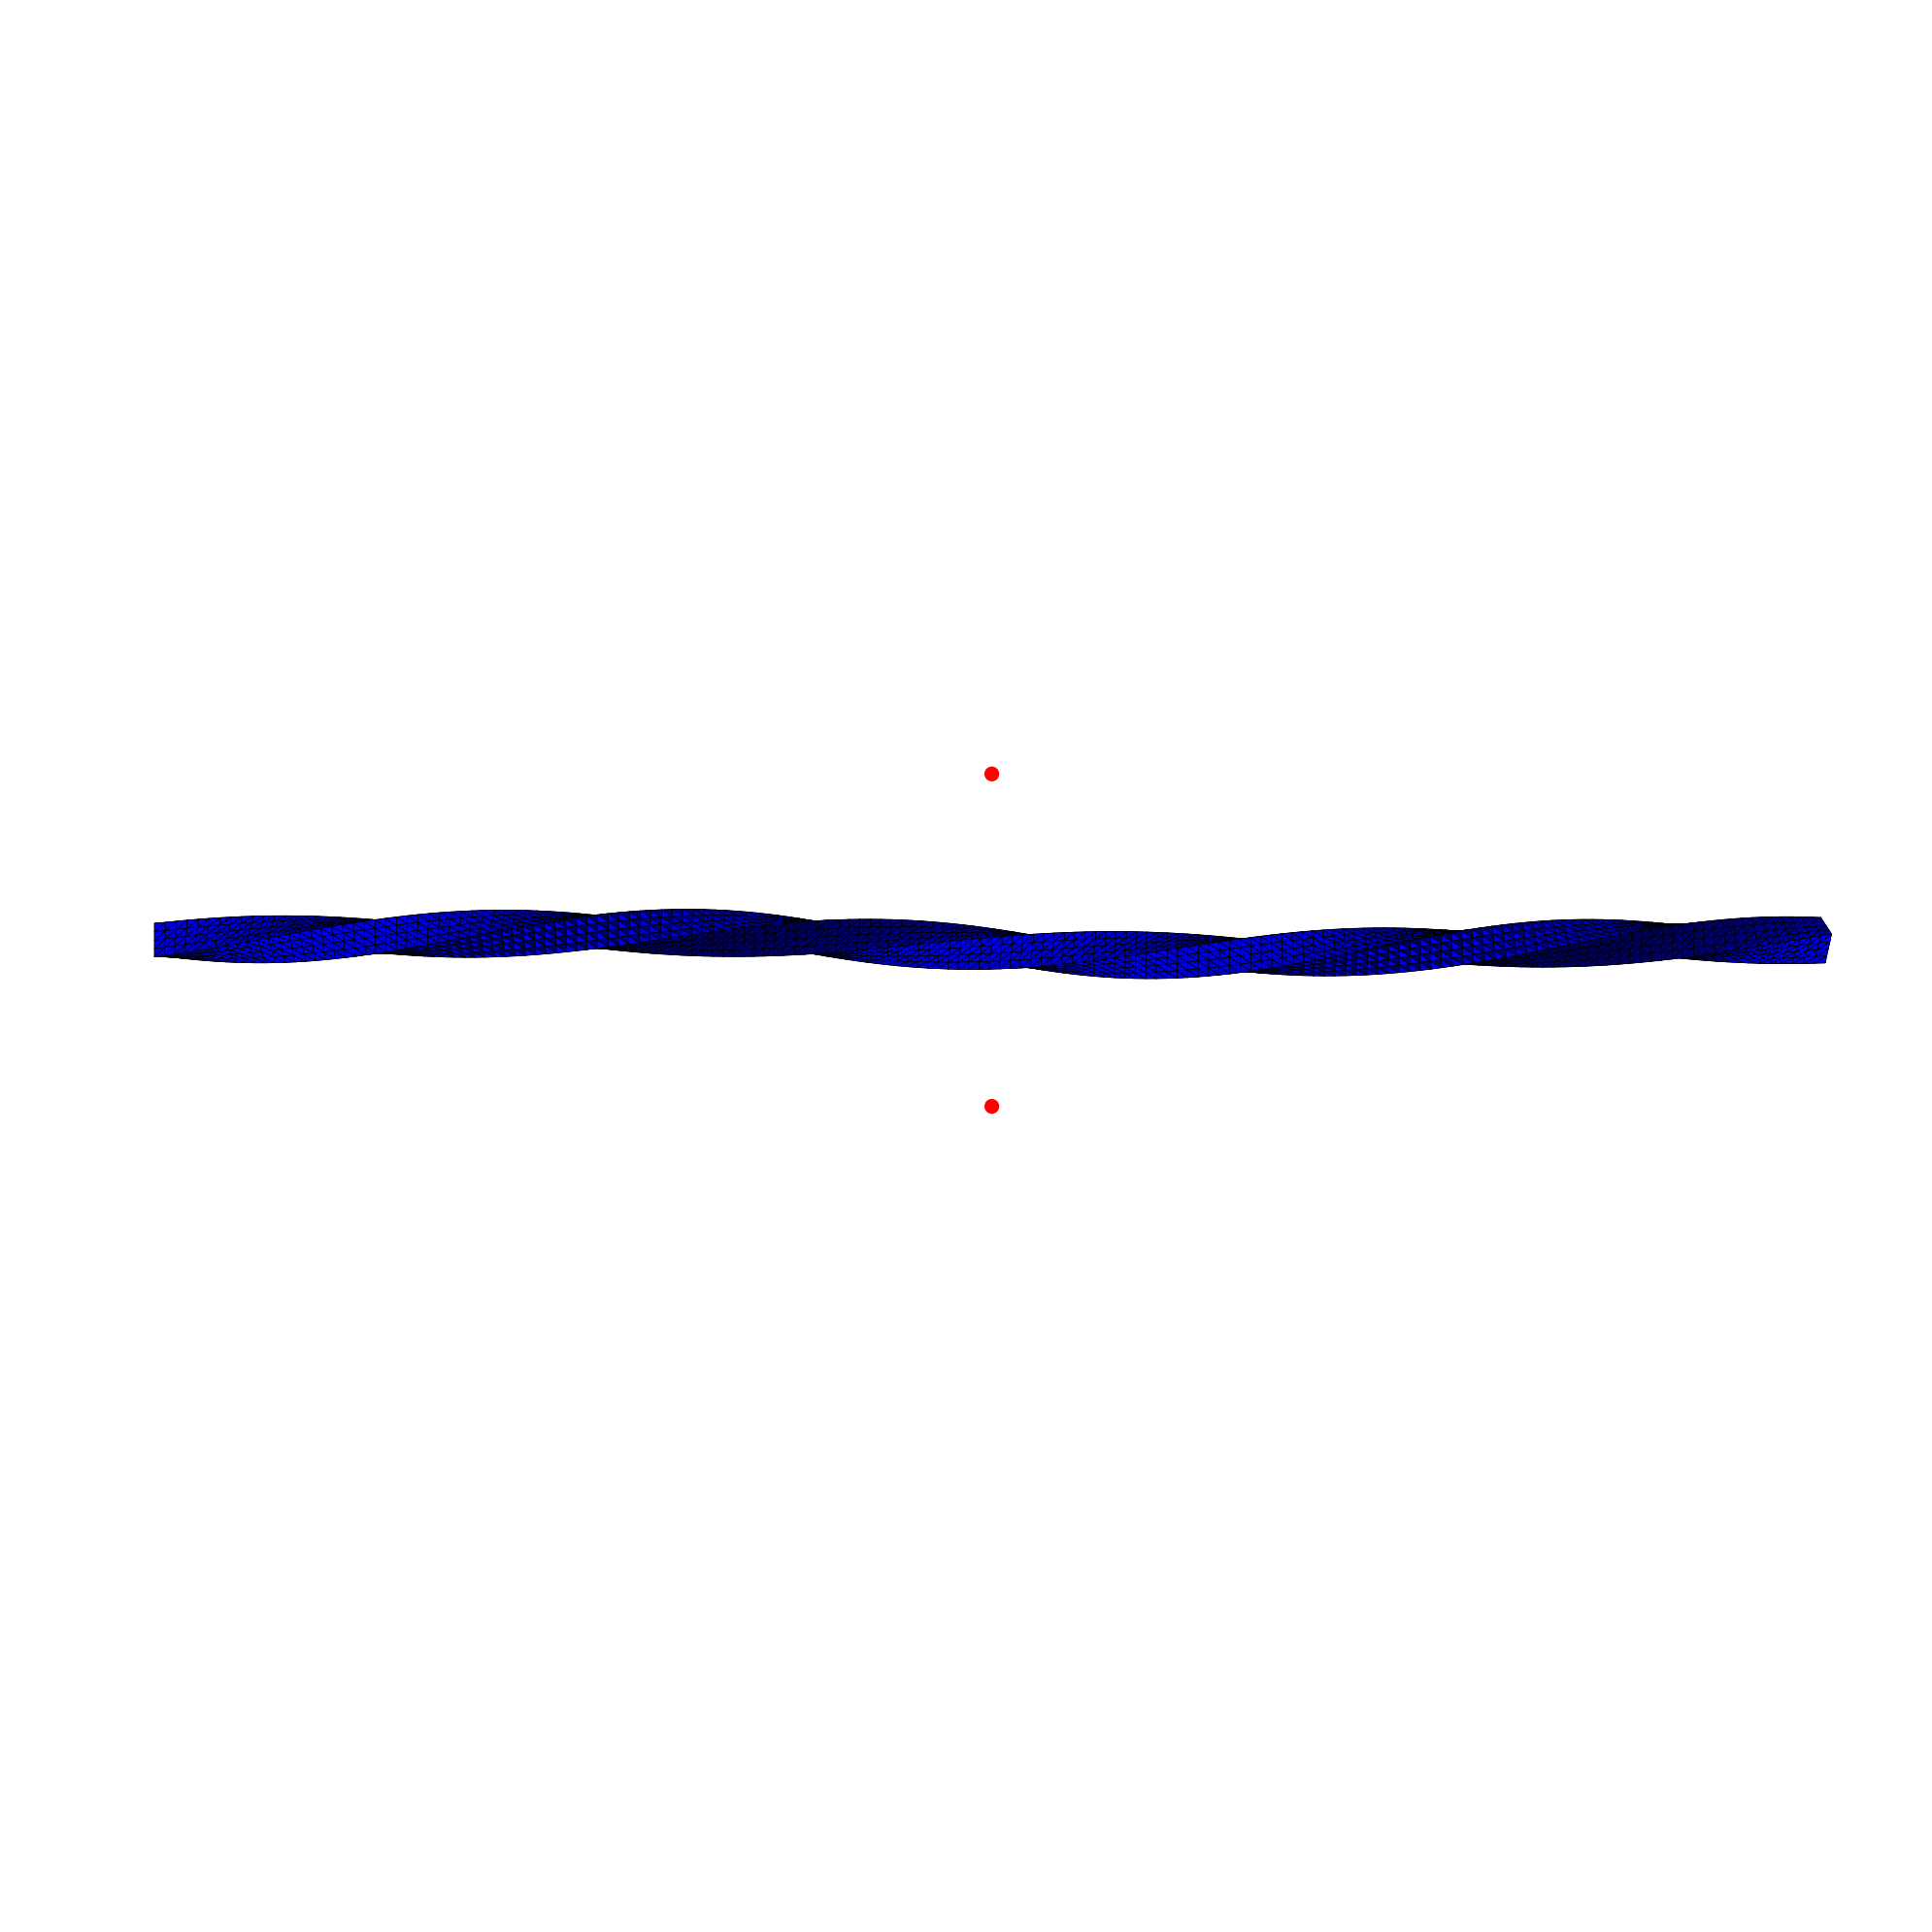

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 29.161311765645035
        x: [ 2.526e-03 -4.619e-03 ...  5.333e-03  4.600e-03]
      nit: 2667
      jac: [ 1.968e-03 -1.832e-03 ...  3.087e-03  1.965e-03]
     nfev: 2753
     njev: 2753
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


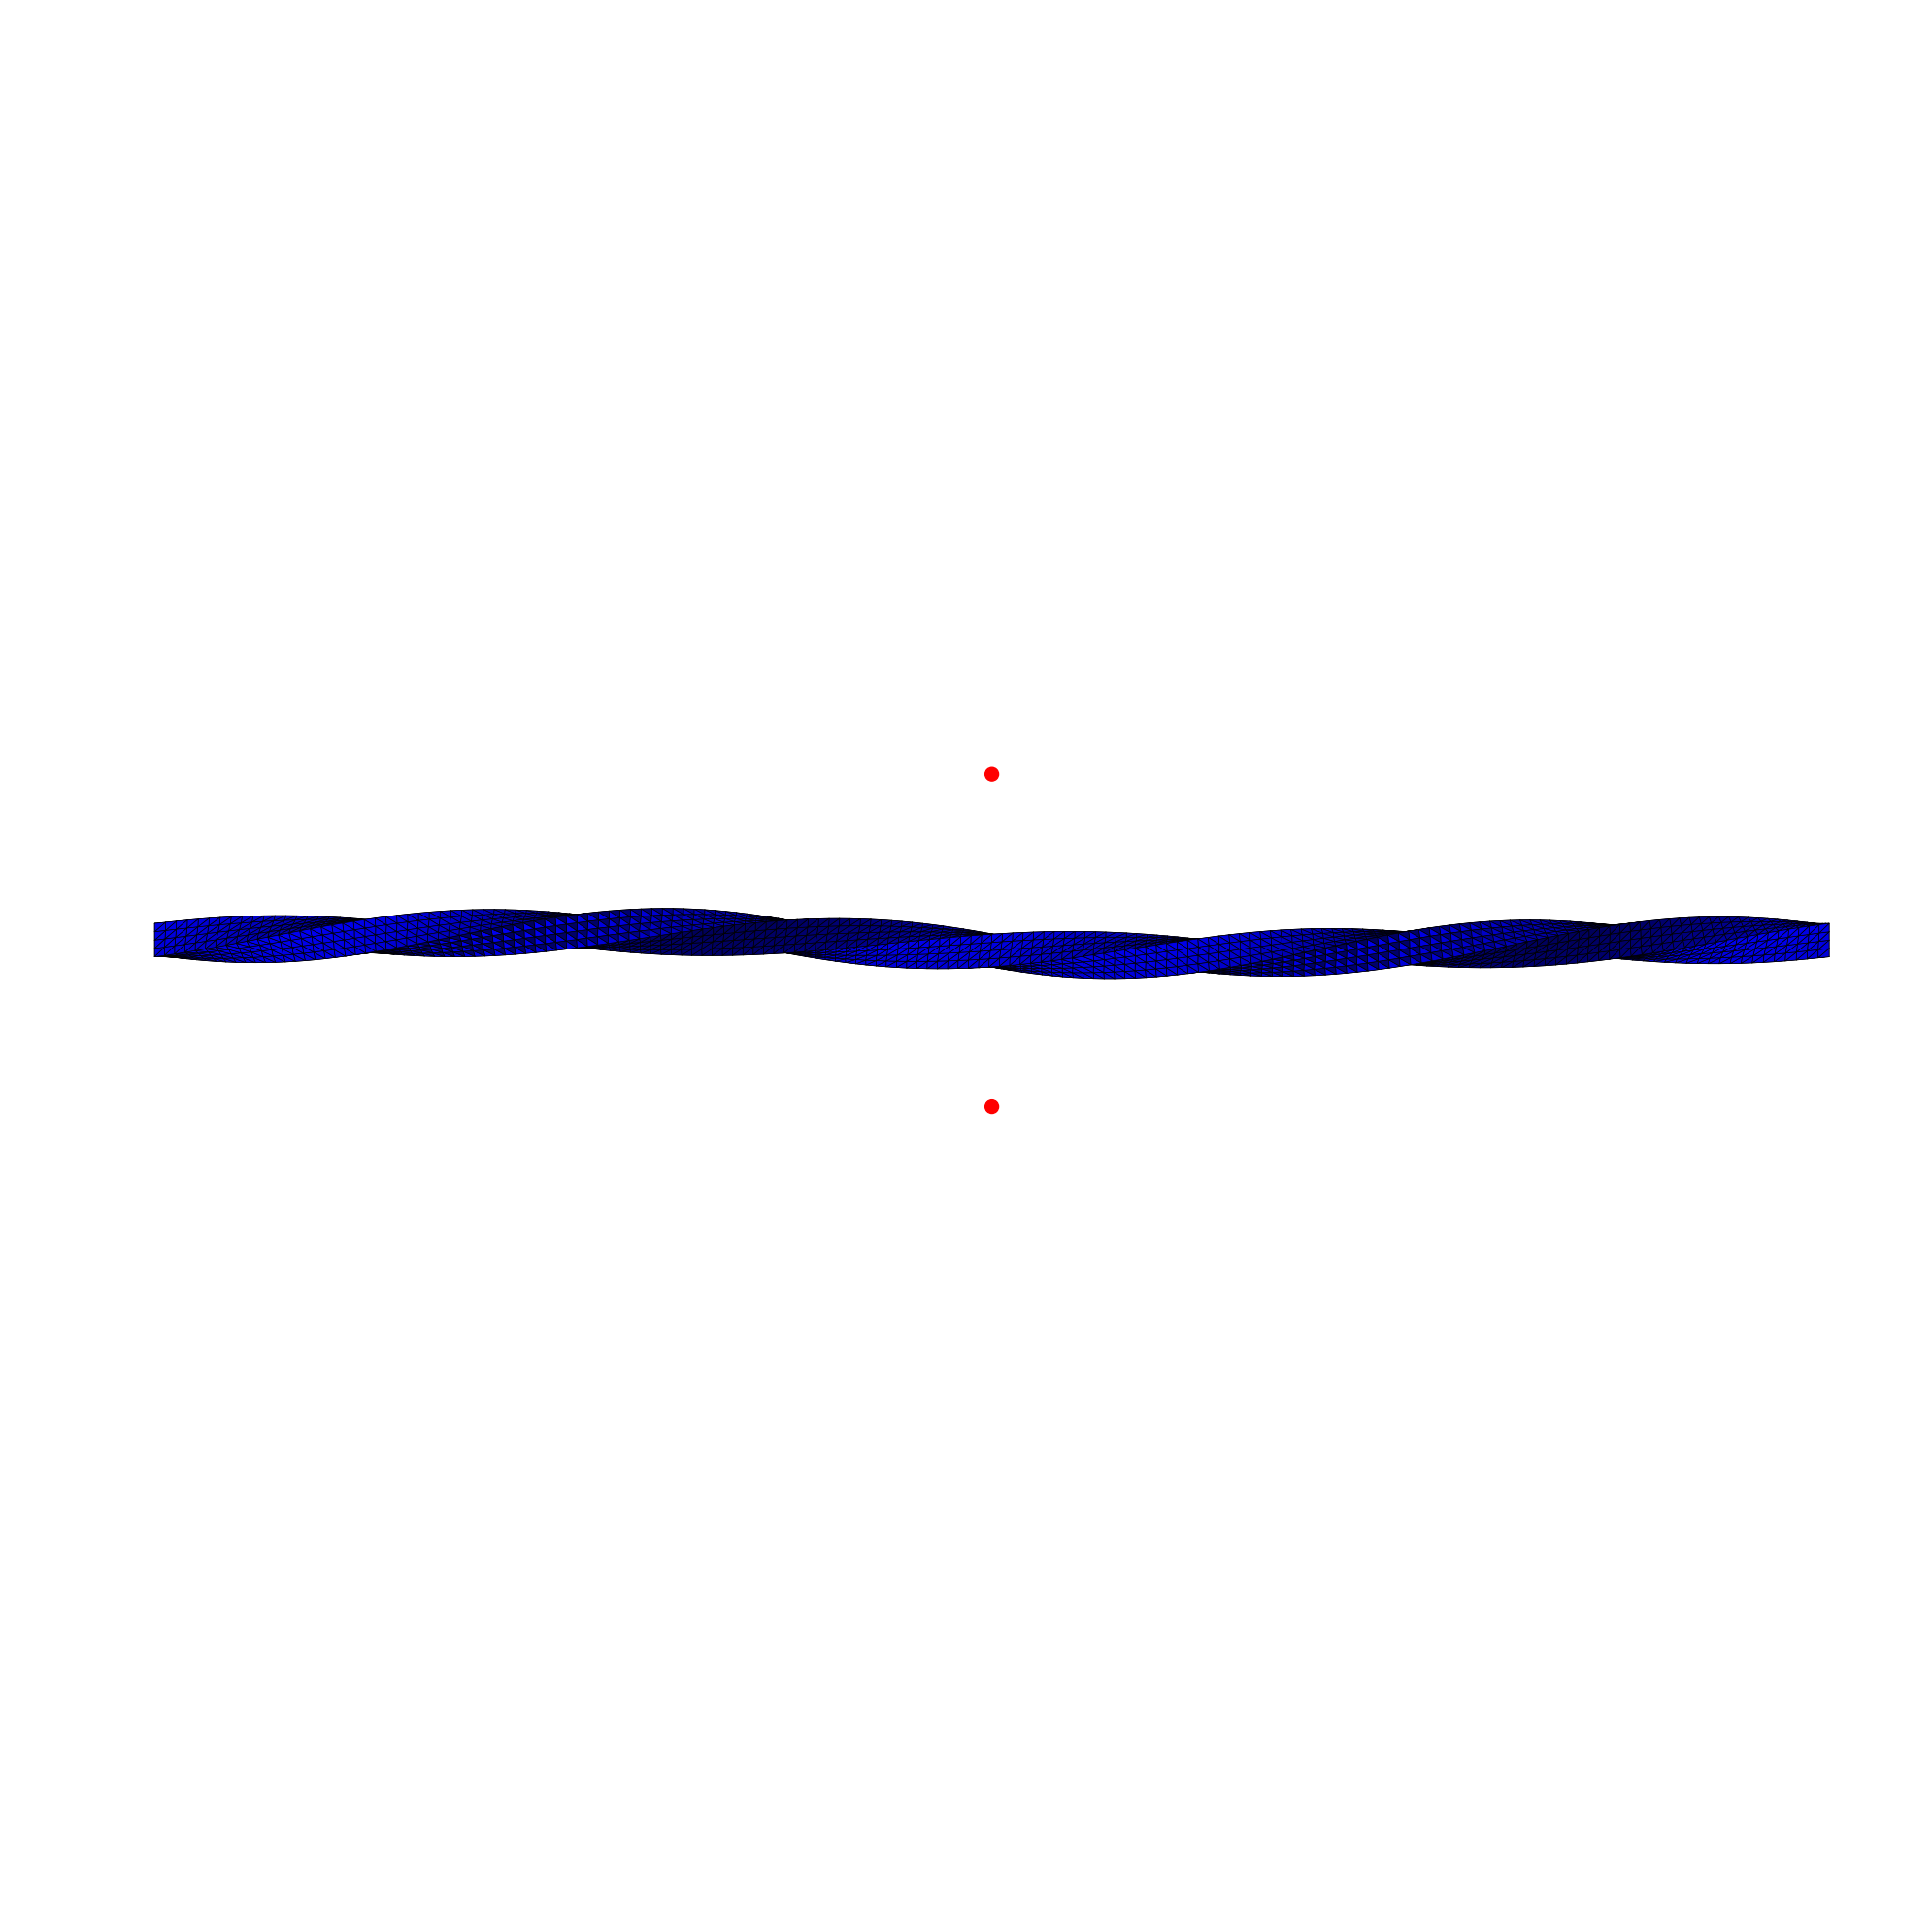

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 31.64247717336914
        x: [ 2.529e-03 -4.601e-03 ...  2.338e-03  6.638e-03]
      nit: 2019
      jac: [ 7.096e-03 -4.072e-03 ...  5.870e-03 -9.428e-06]
     nfev: 2080
     njev: 2080
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


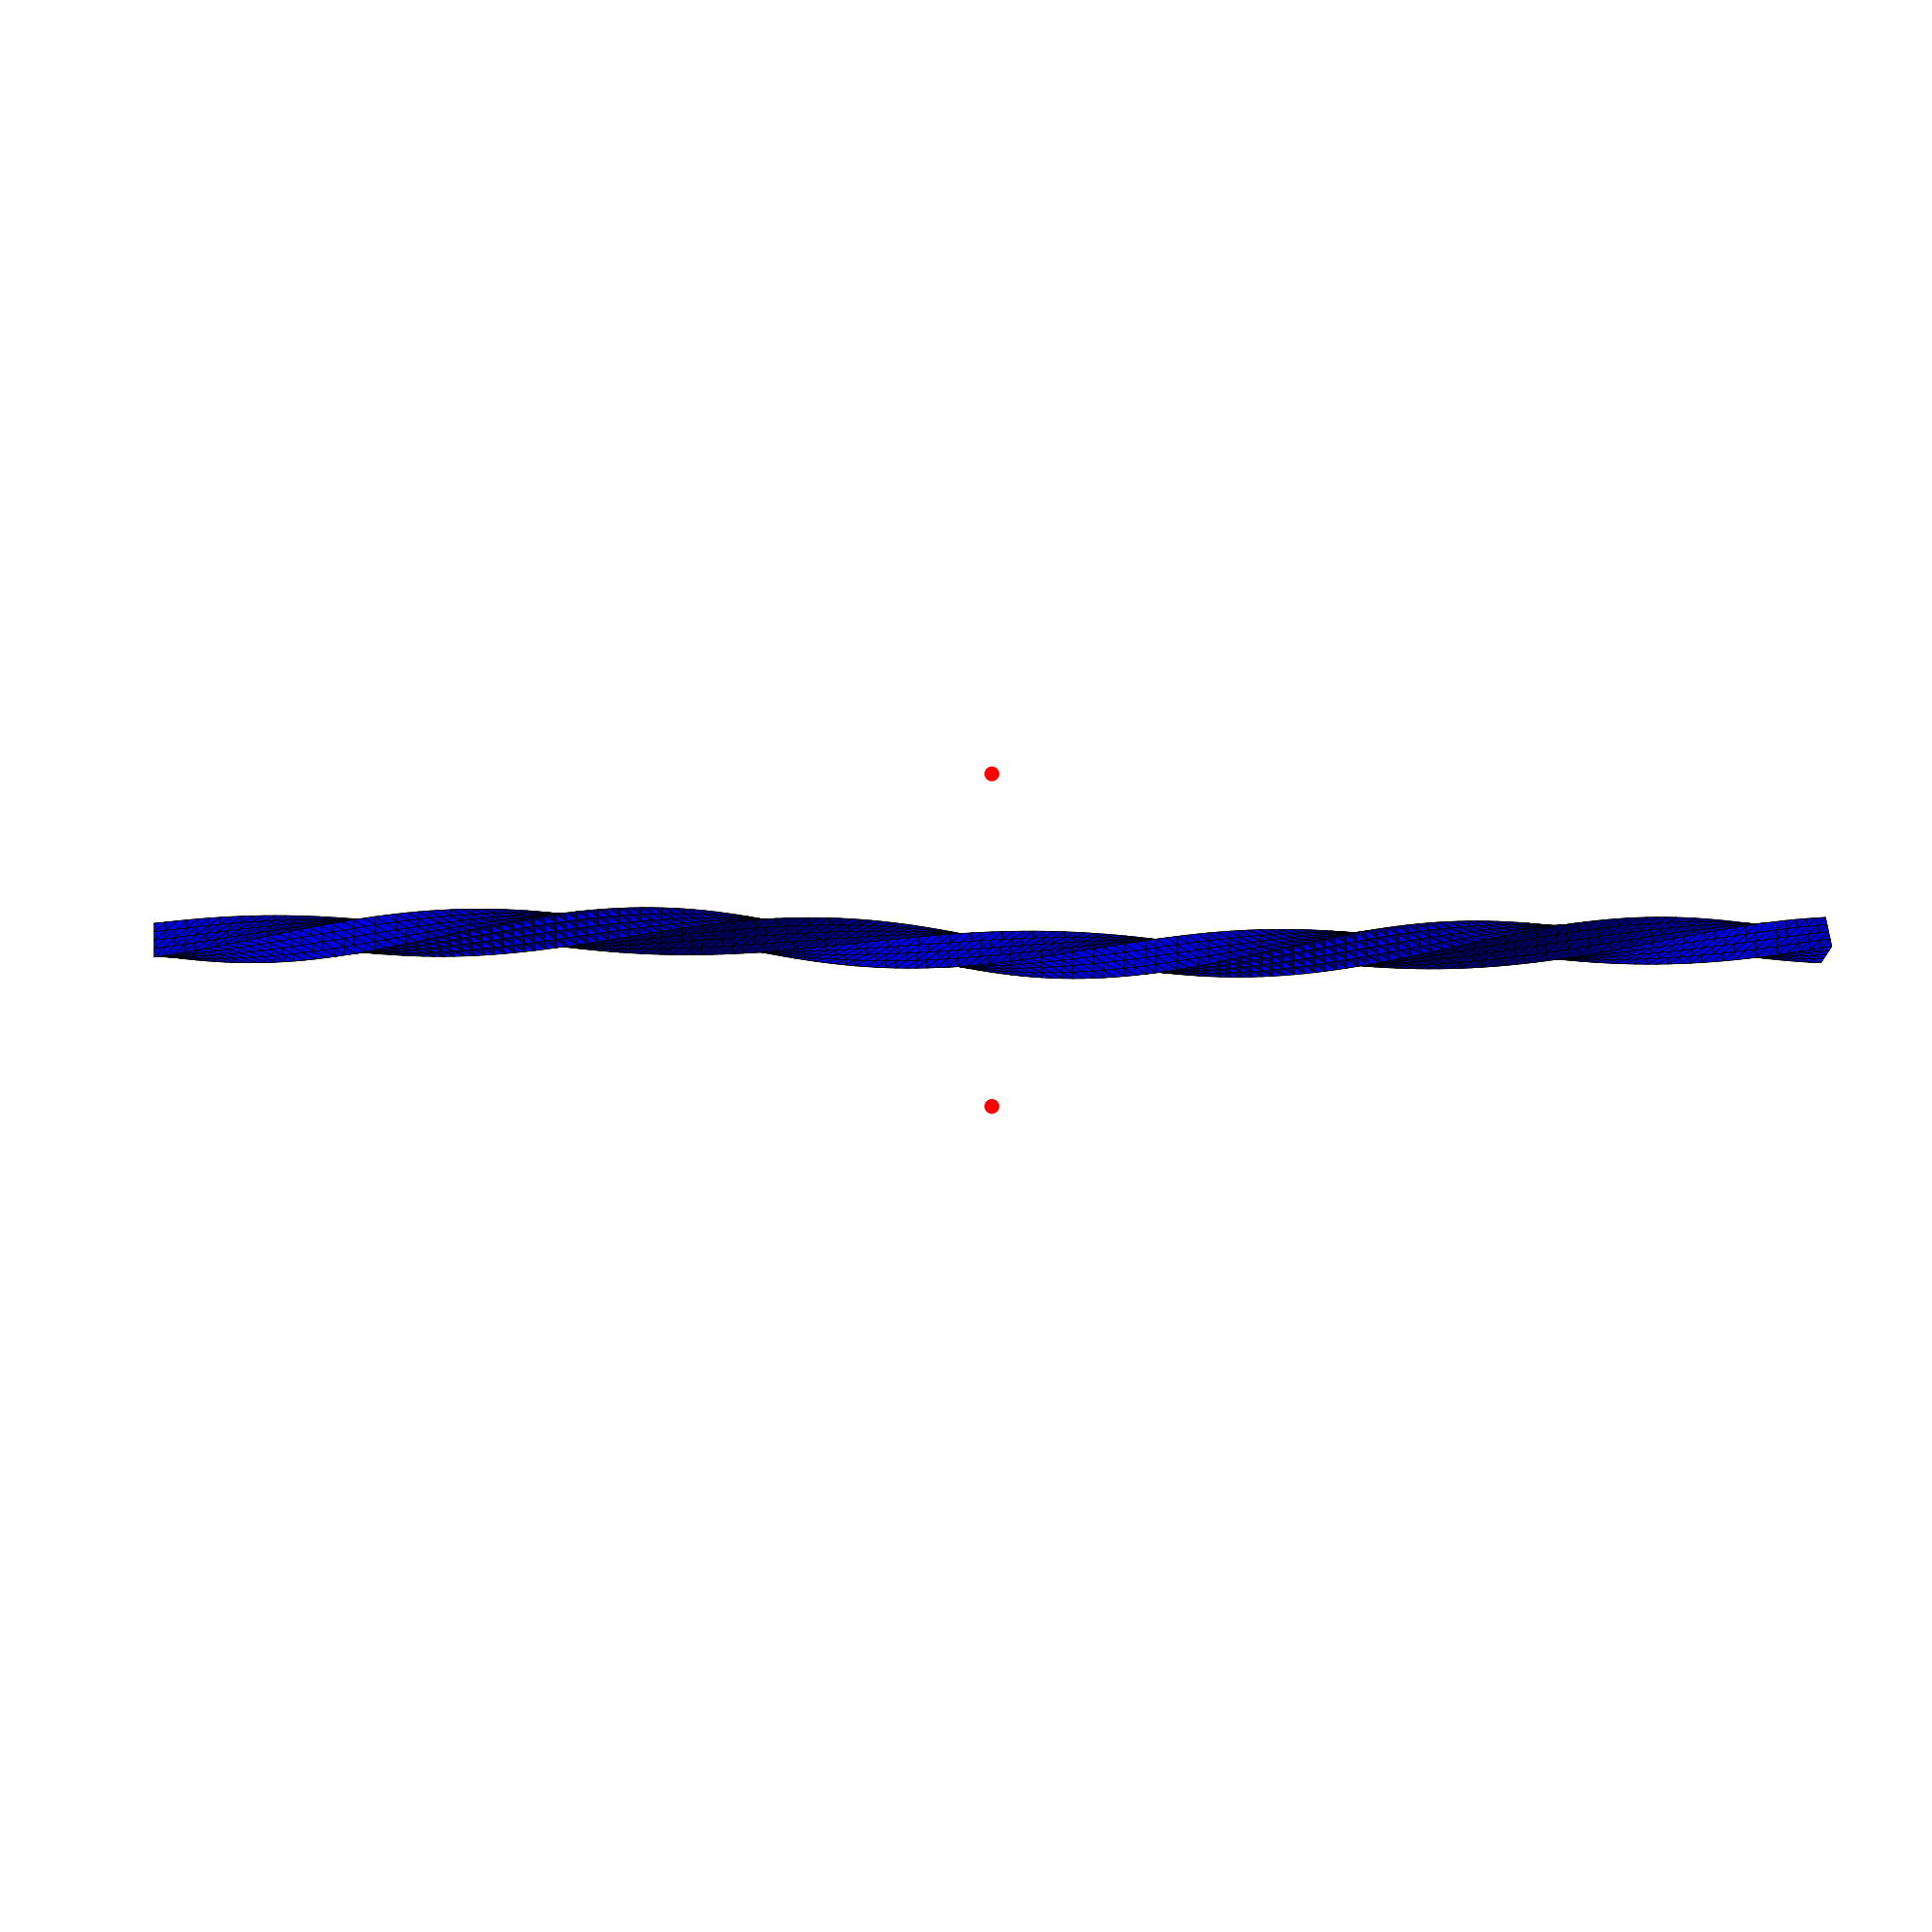

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 34.22441989156735
        x: [ 2.530e-03 -4.584e-03 ... -1.273e-03  6.921e-03]
      nit: 2972
      jac: [-9.507e-04 -2.034e-03 ...  5.805e-03 -1.214e-03]
     nfev: 3079
     njev: 3079
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


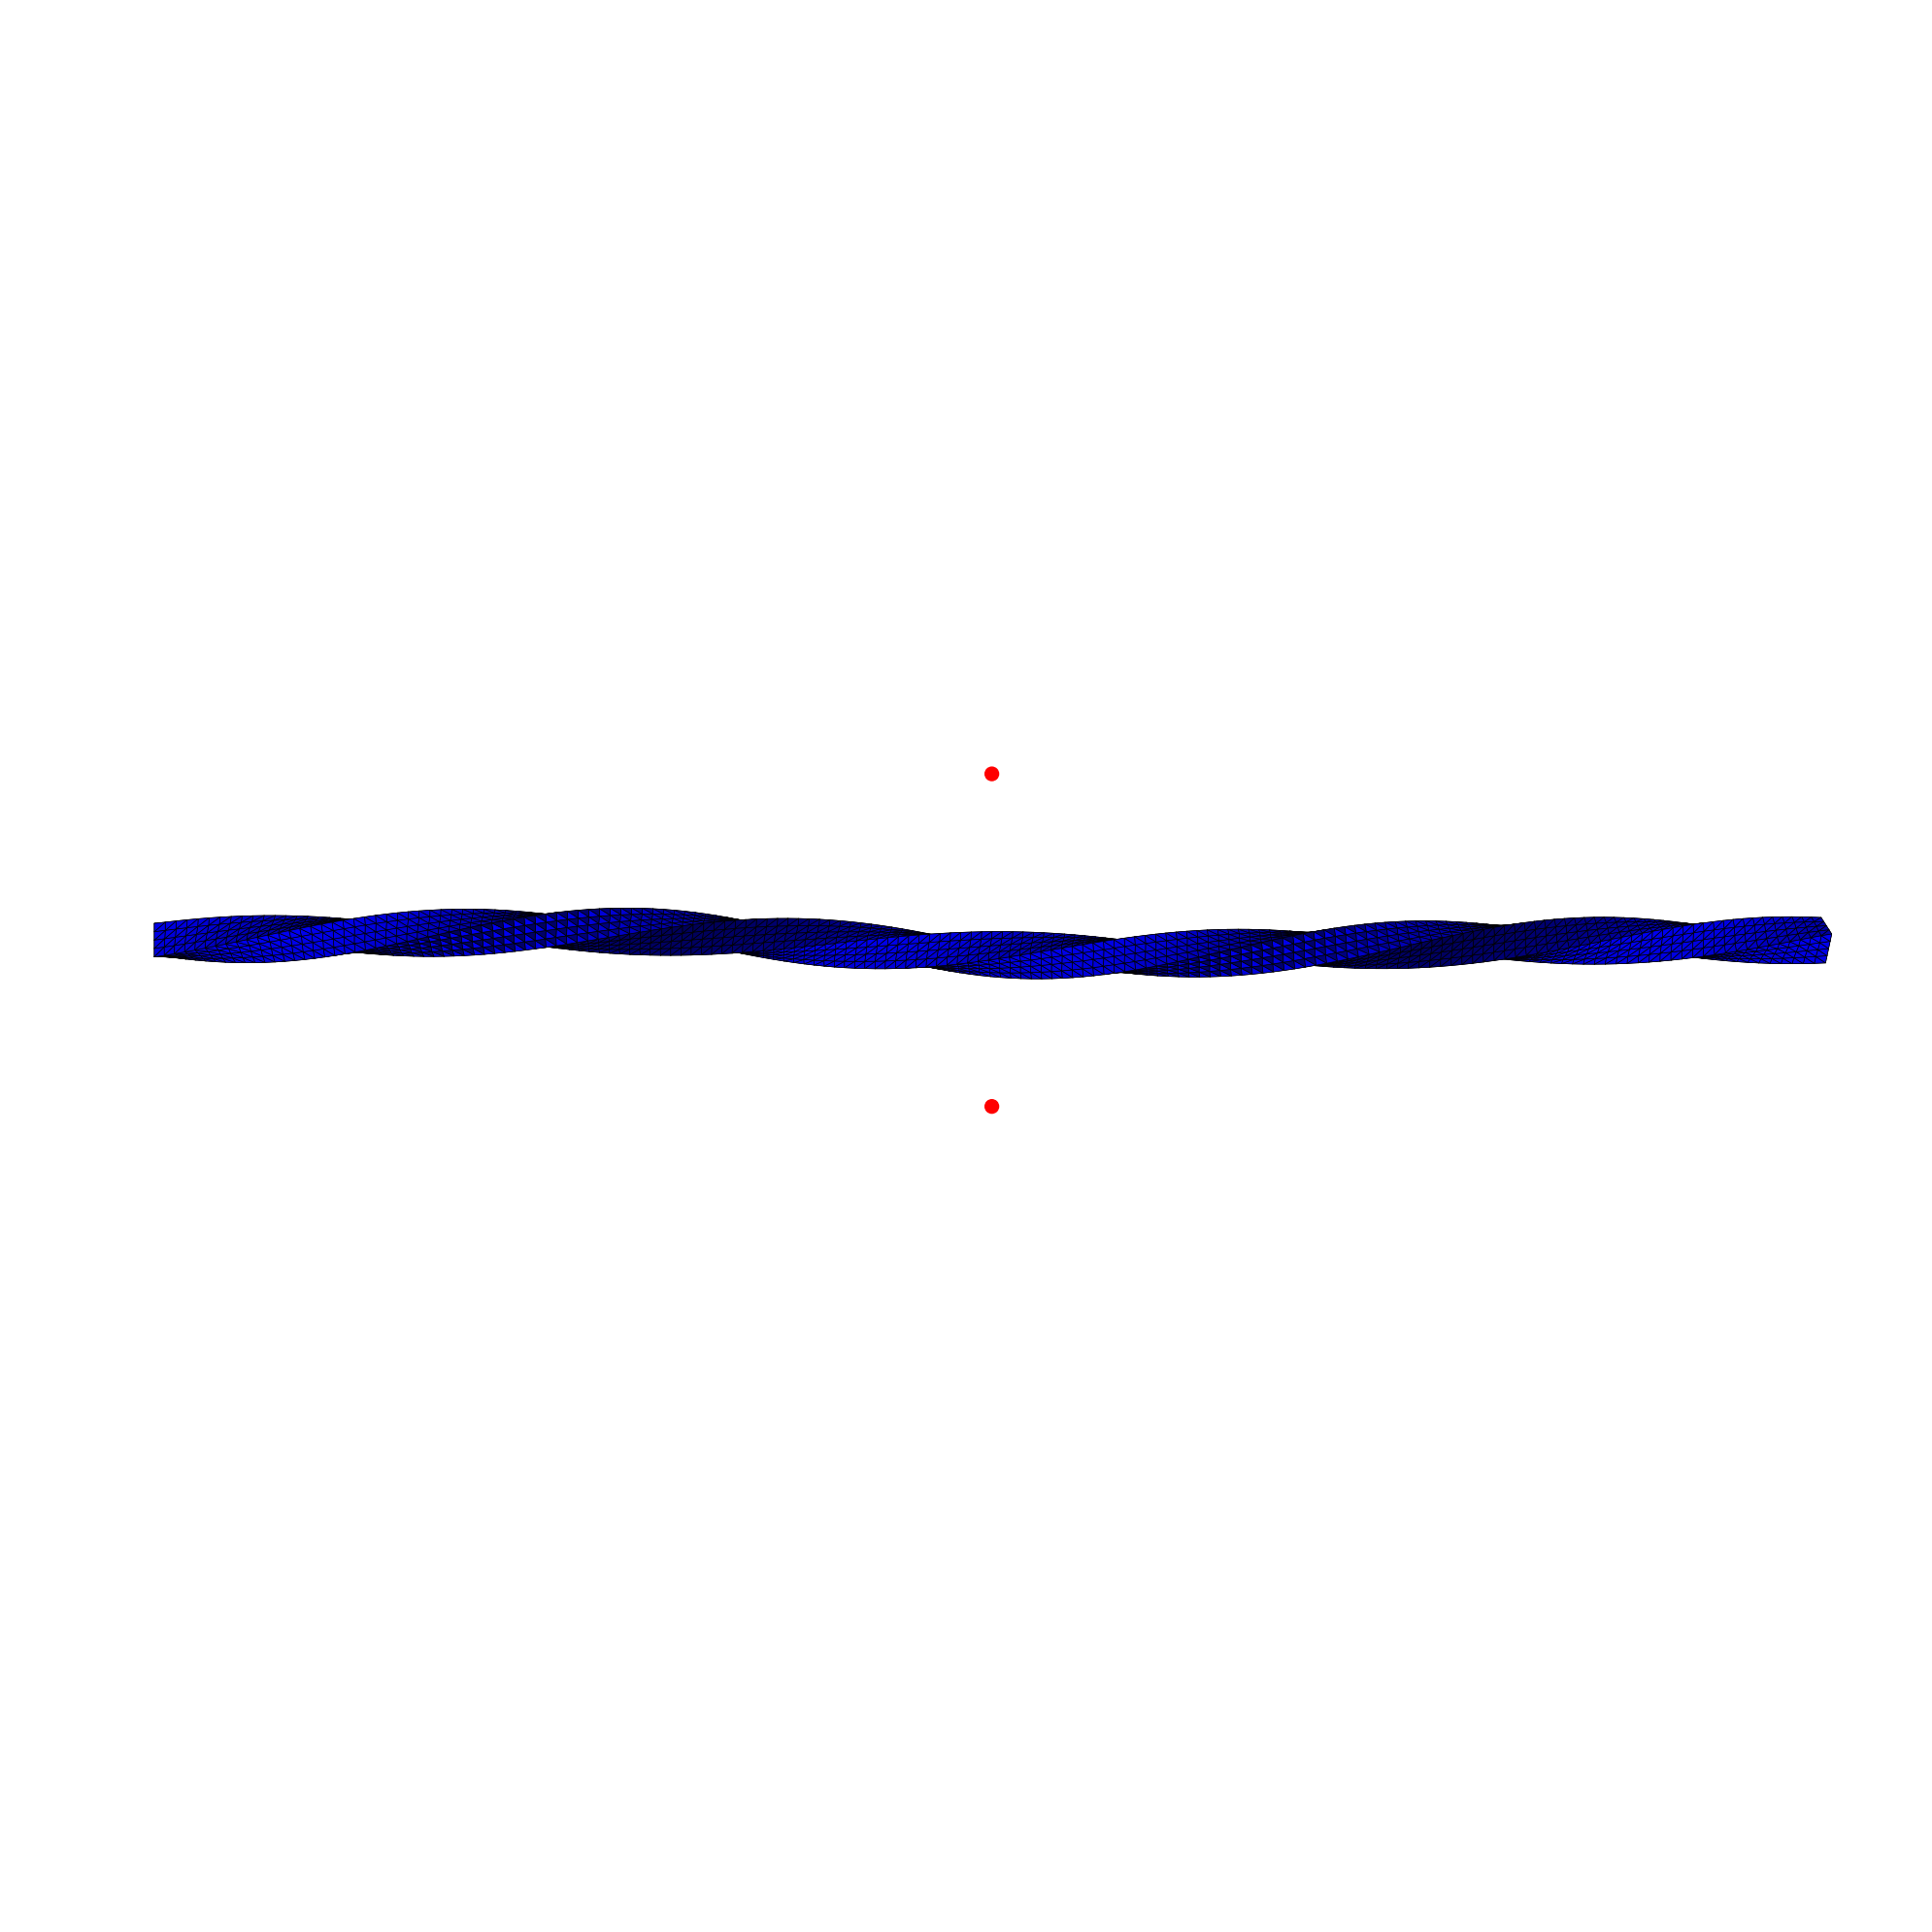

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 36.90788516461711
        x: [ 2.534e-03 -4.567e-03 ... -4.544e-03  5.370e-03]
      nit: 2005
      jac: [ 2.468e-03 -4.729e-03 ...  4.591e-03  5.709e-03]
     nfev: 2066
     njev: 2066
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


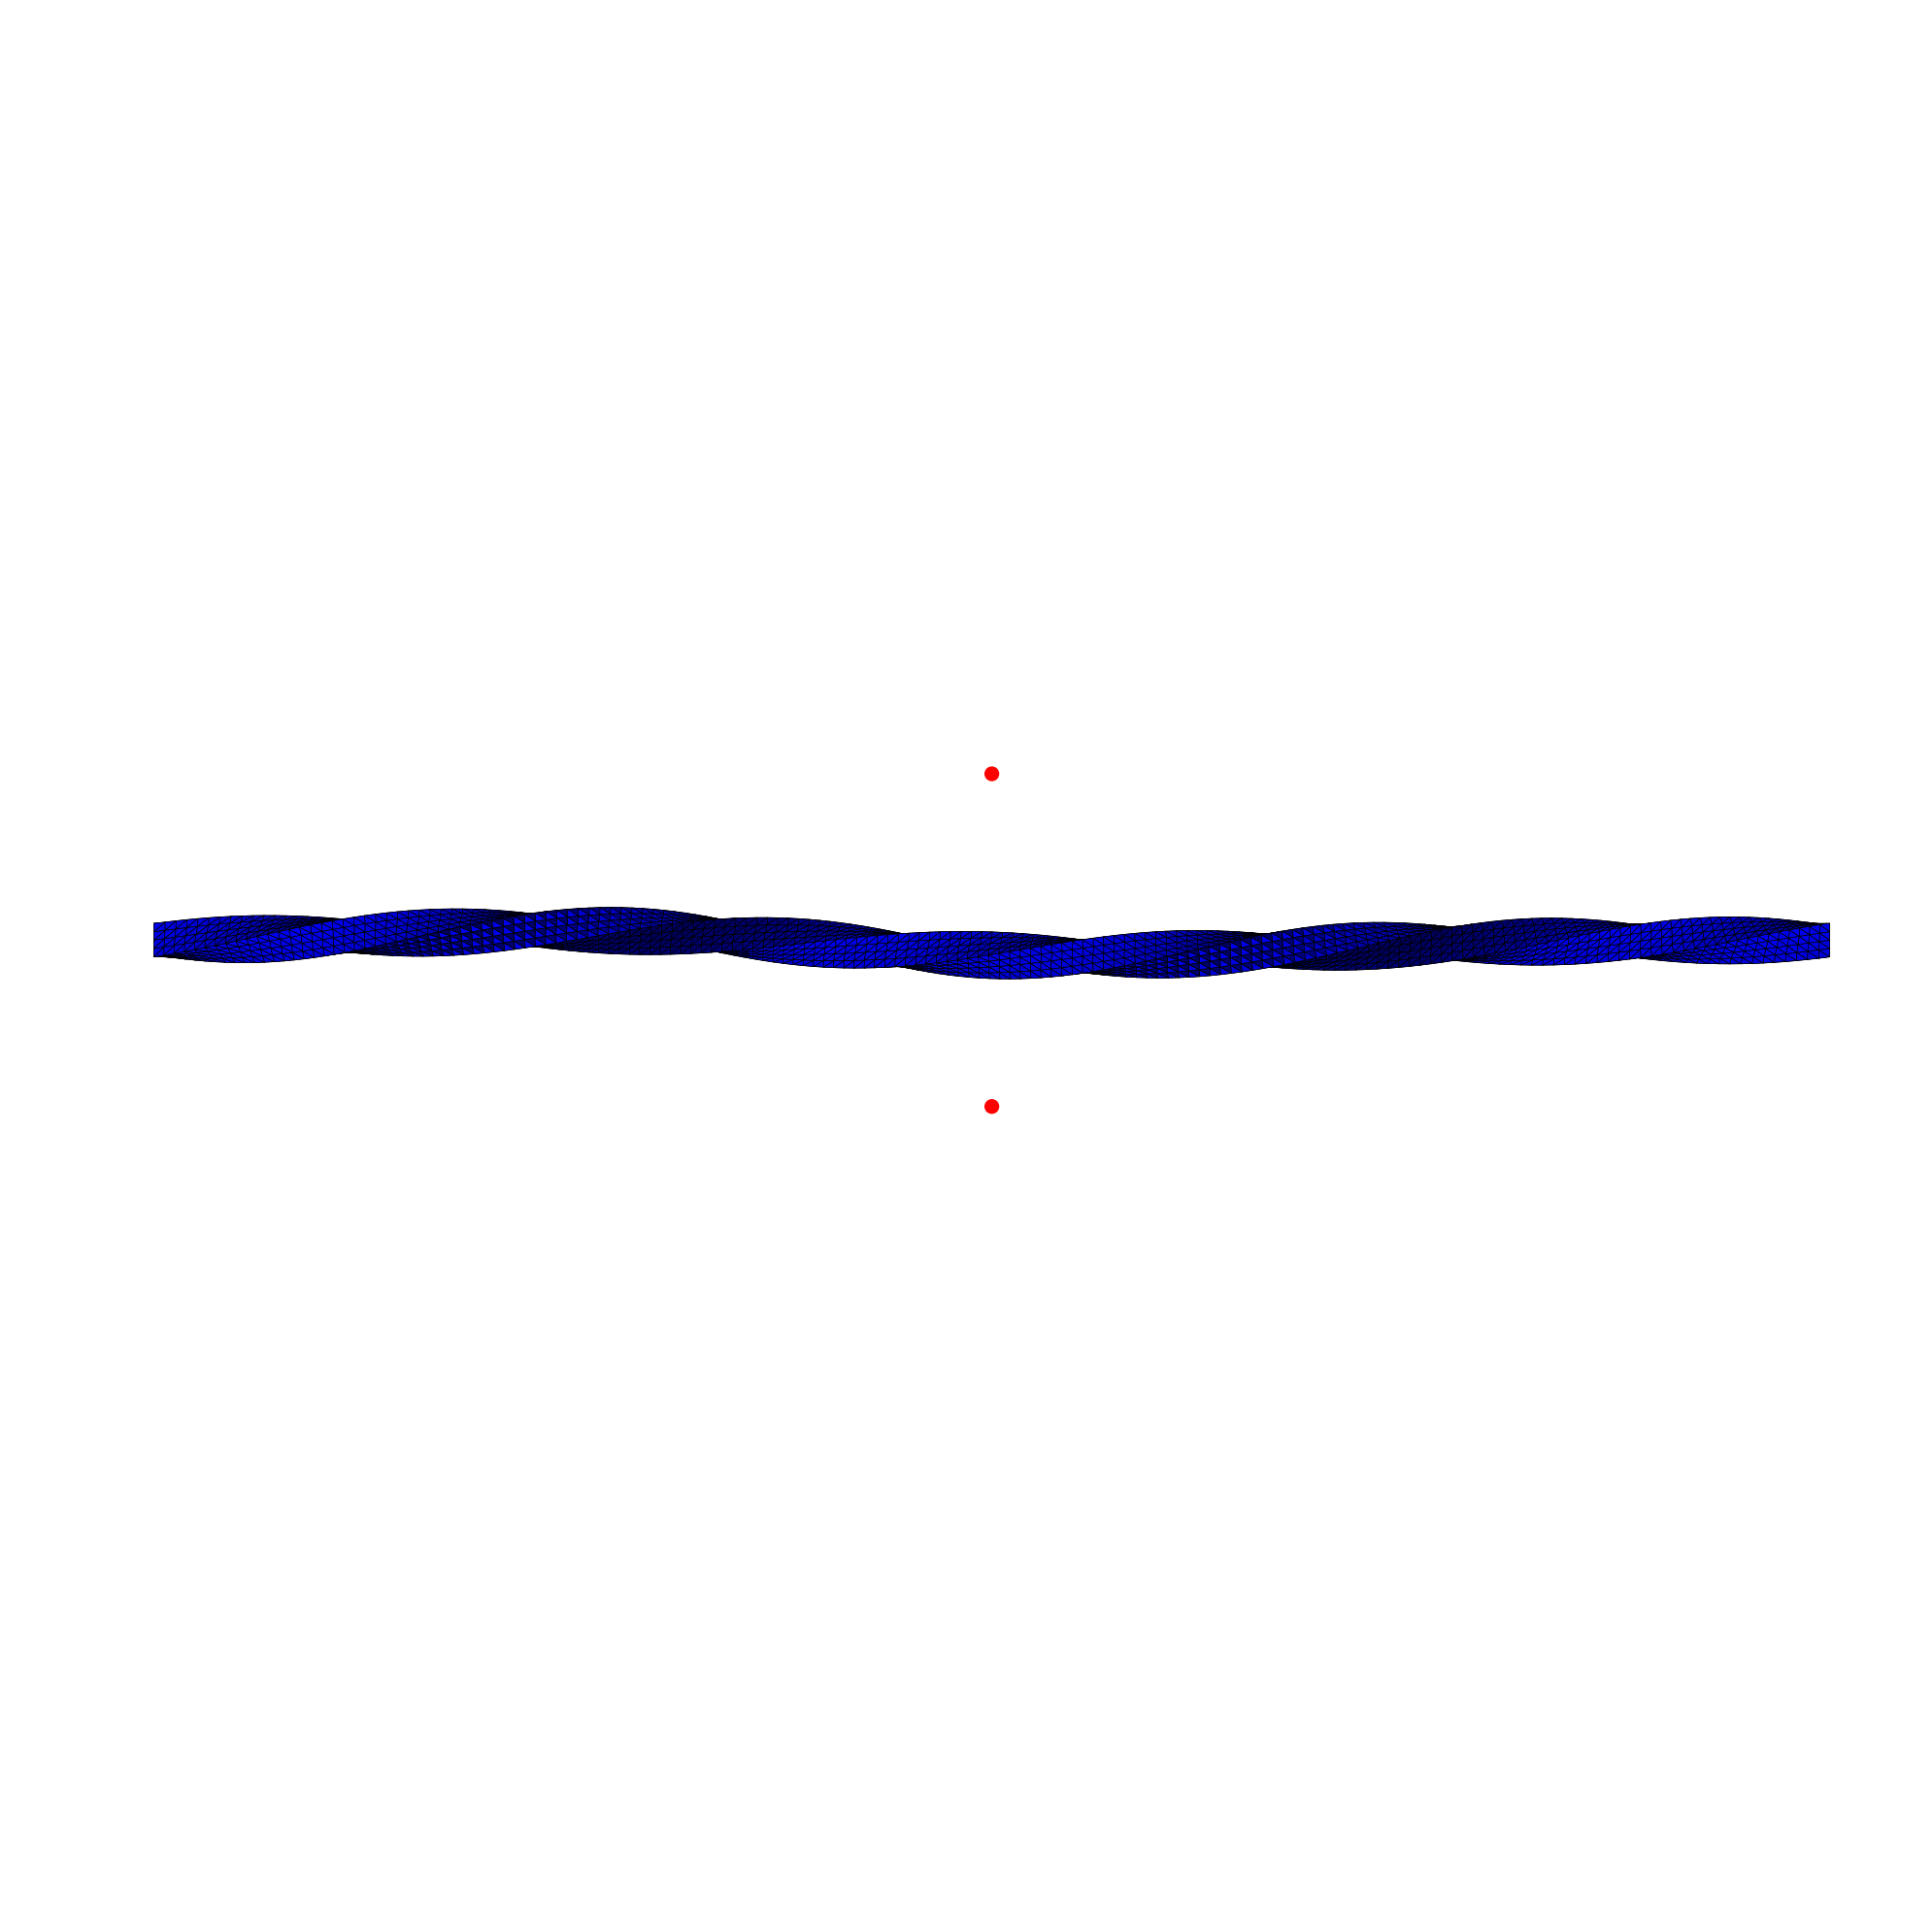

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 39.6918333231077
        x: [ 2.534e-03 -4.550e-03 ... -6.612e-03  2.398e-03]
      nit: 2892
      jac: [-8.896e-03 -9.884e-04 ... -8.269e-03 -1.255e-02]
     nfev: 2990
     njev: 2990
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


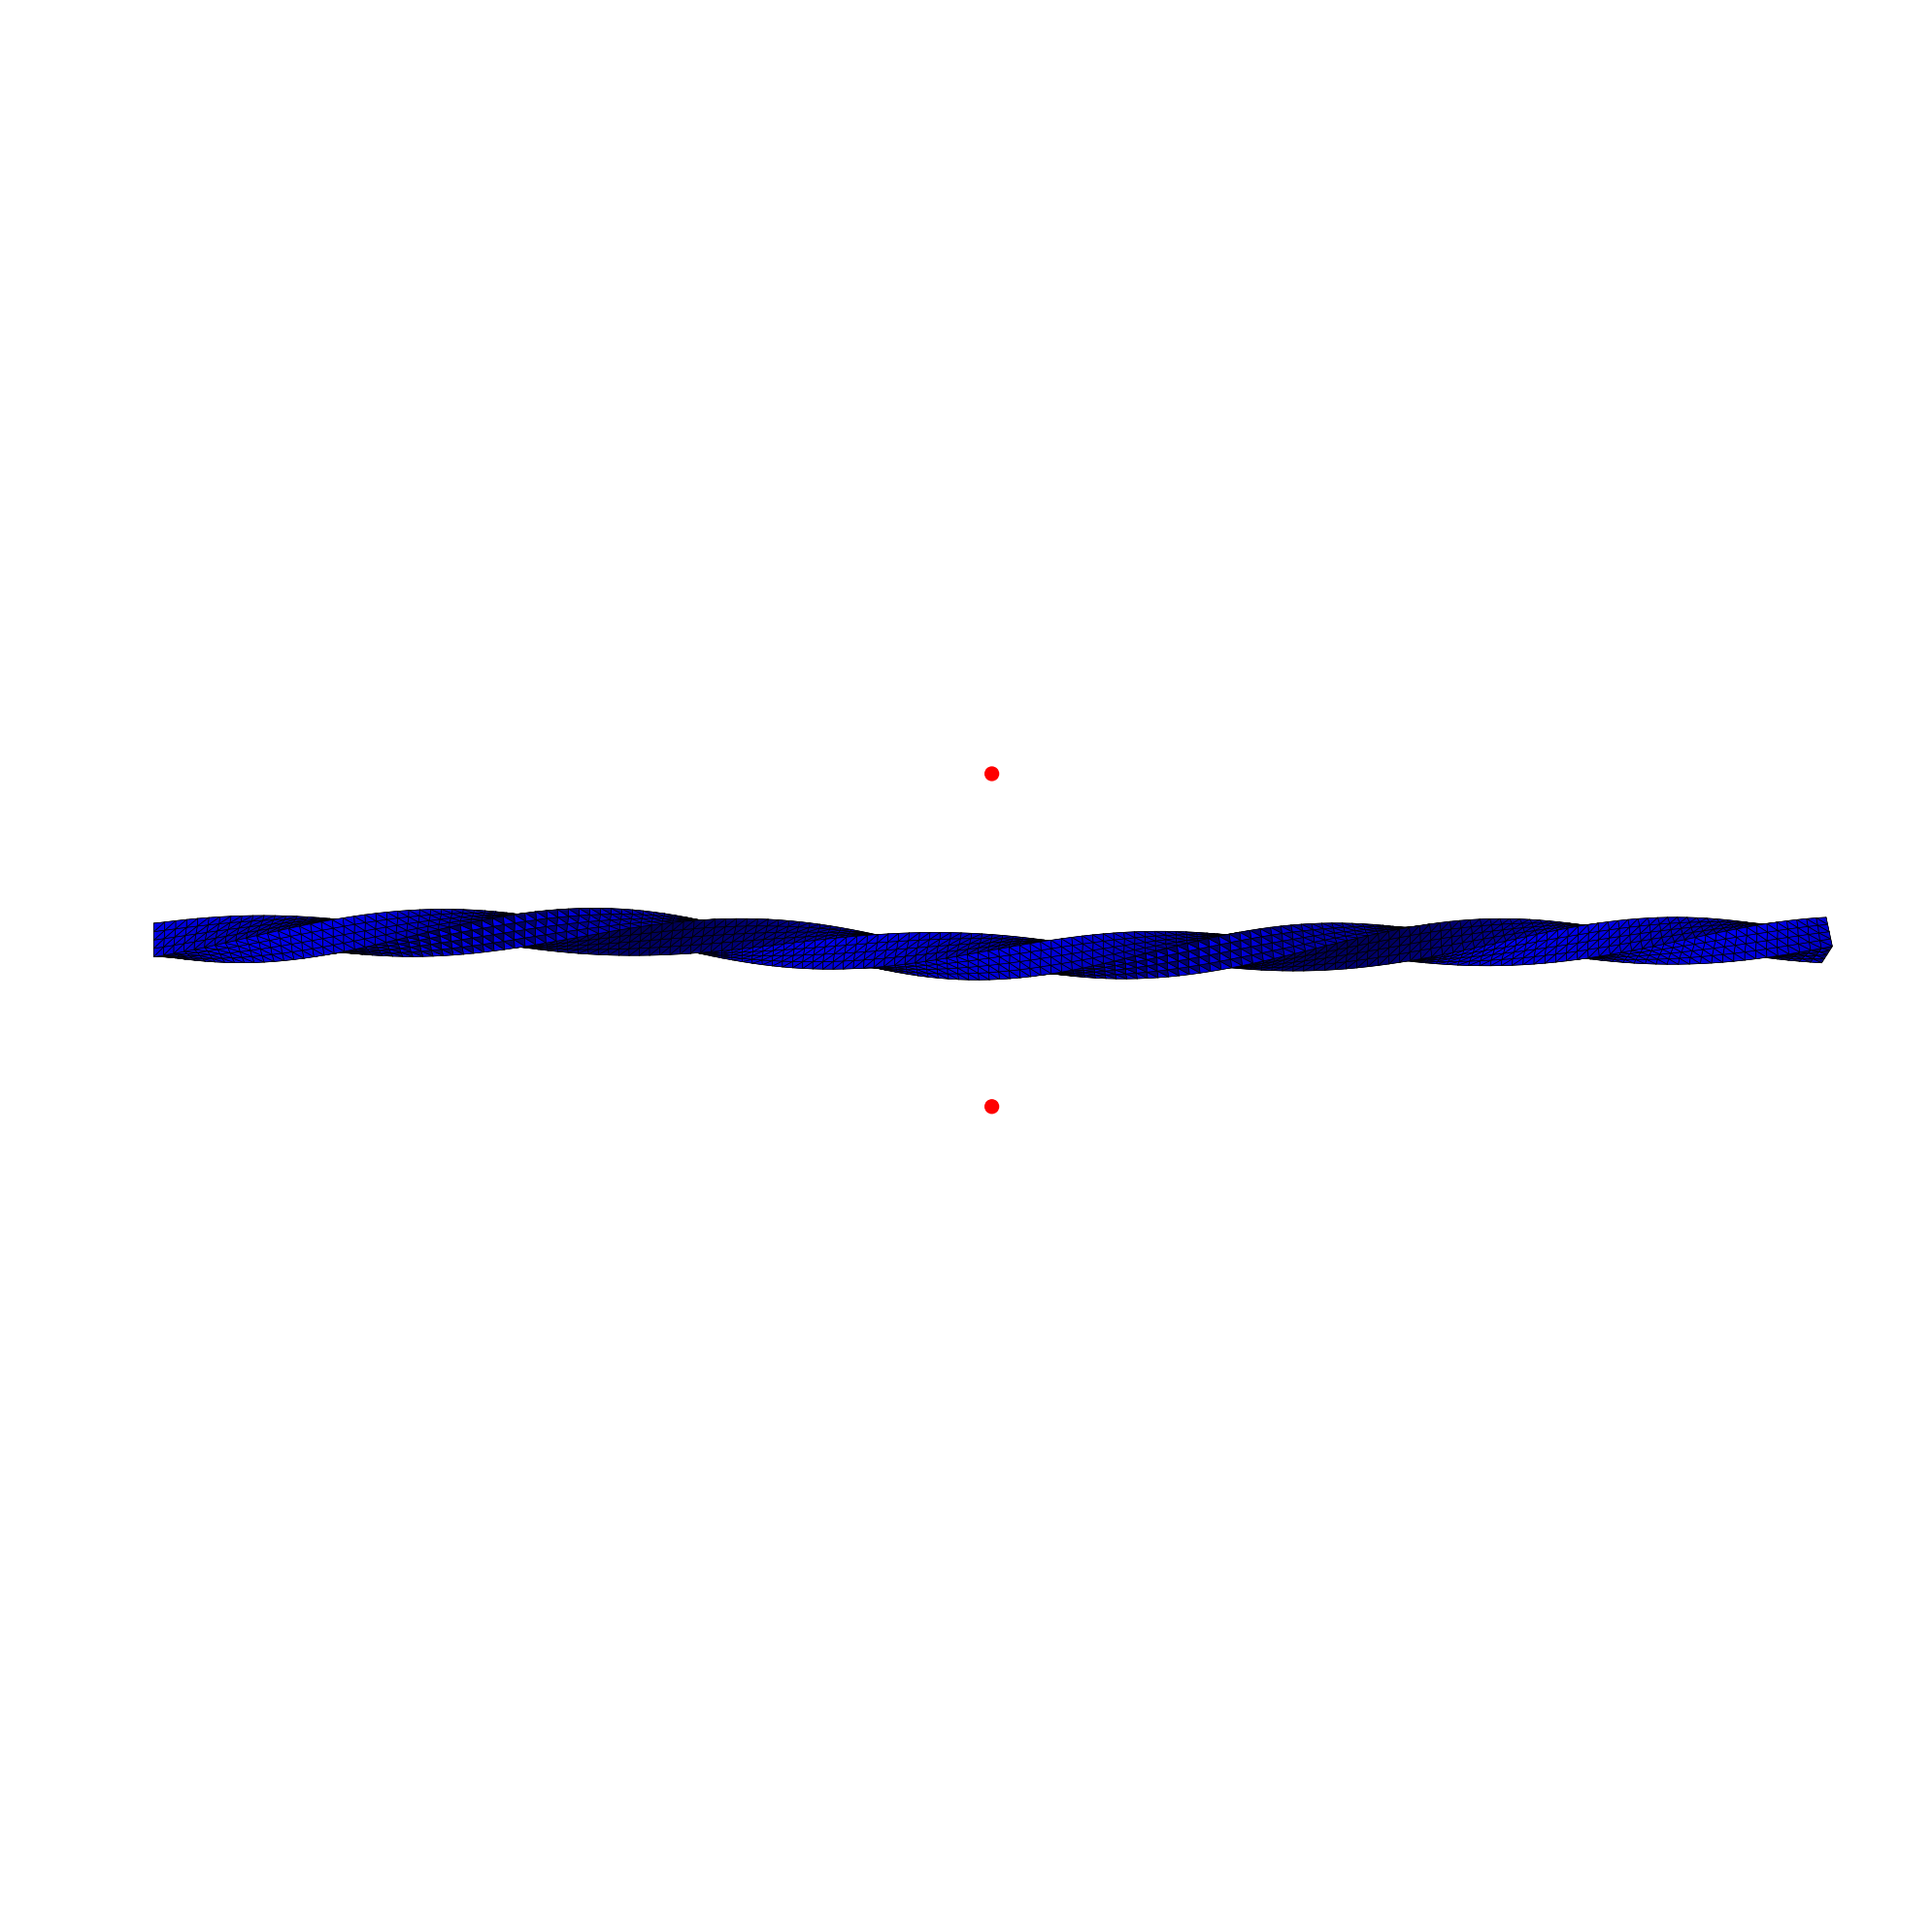

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 42.57686060228764
        x: [ 2.538e-03 -4.532e-03 ... -6.929e-03 -1.208e-03]
      nit: 2065
      jac: [-1.575e-03 -9.622e-03 ... -4.576e-03 -2.769e-03]
     nfev: 2139
     njev: 2139
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


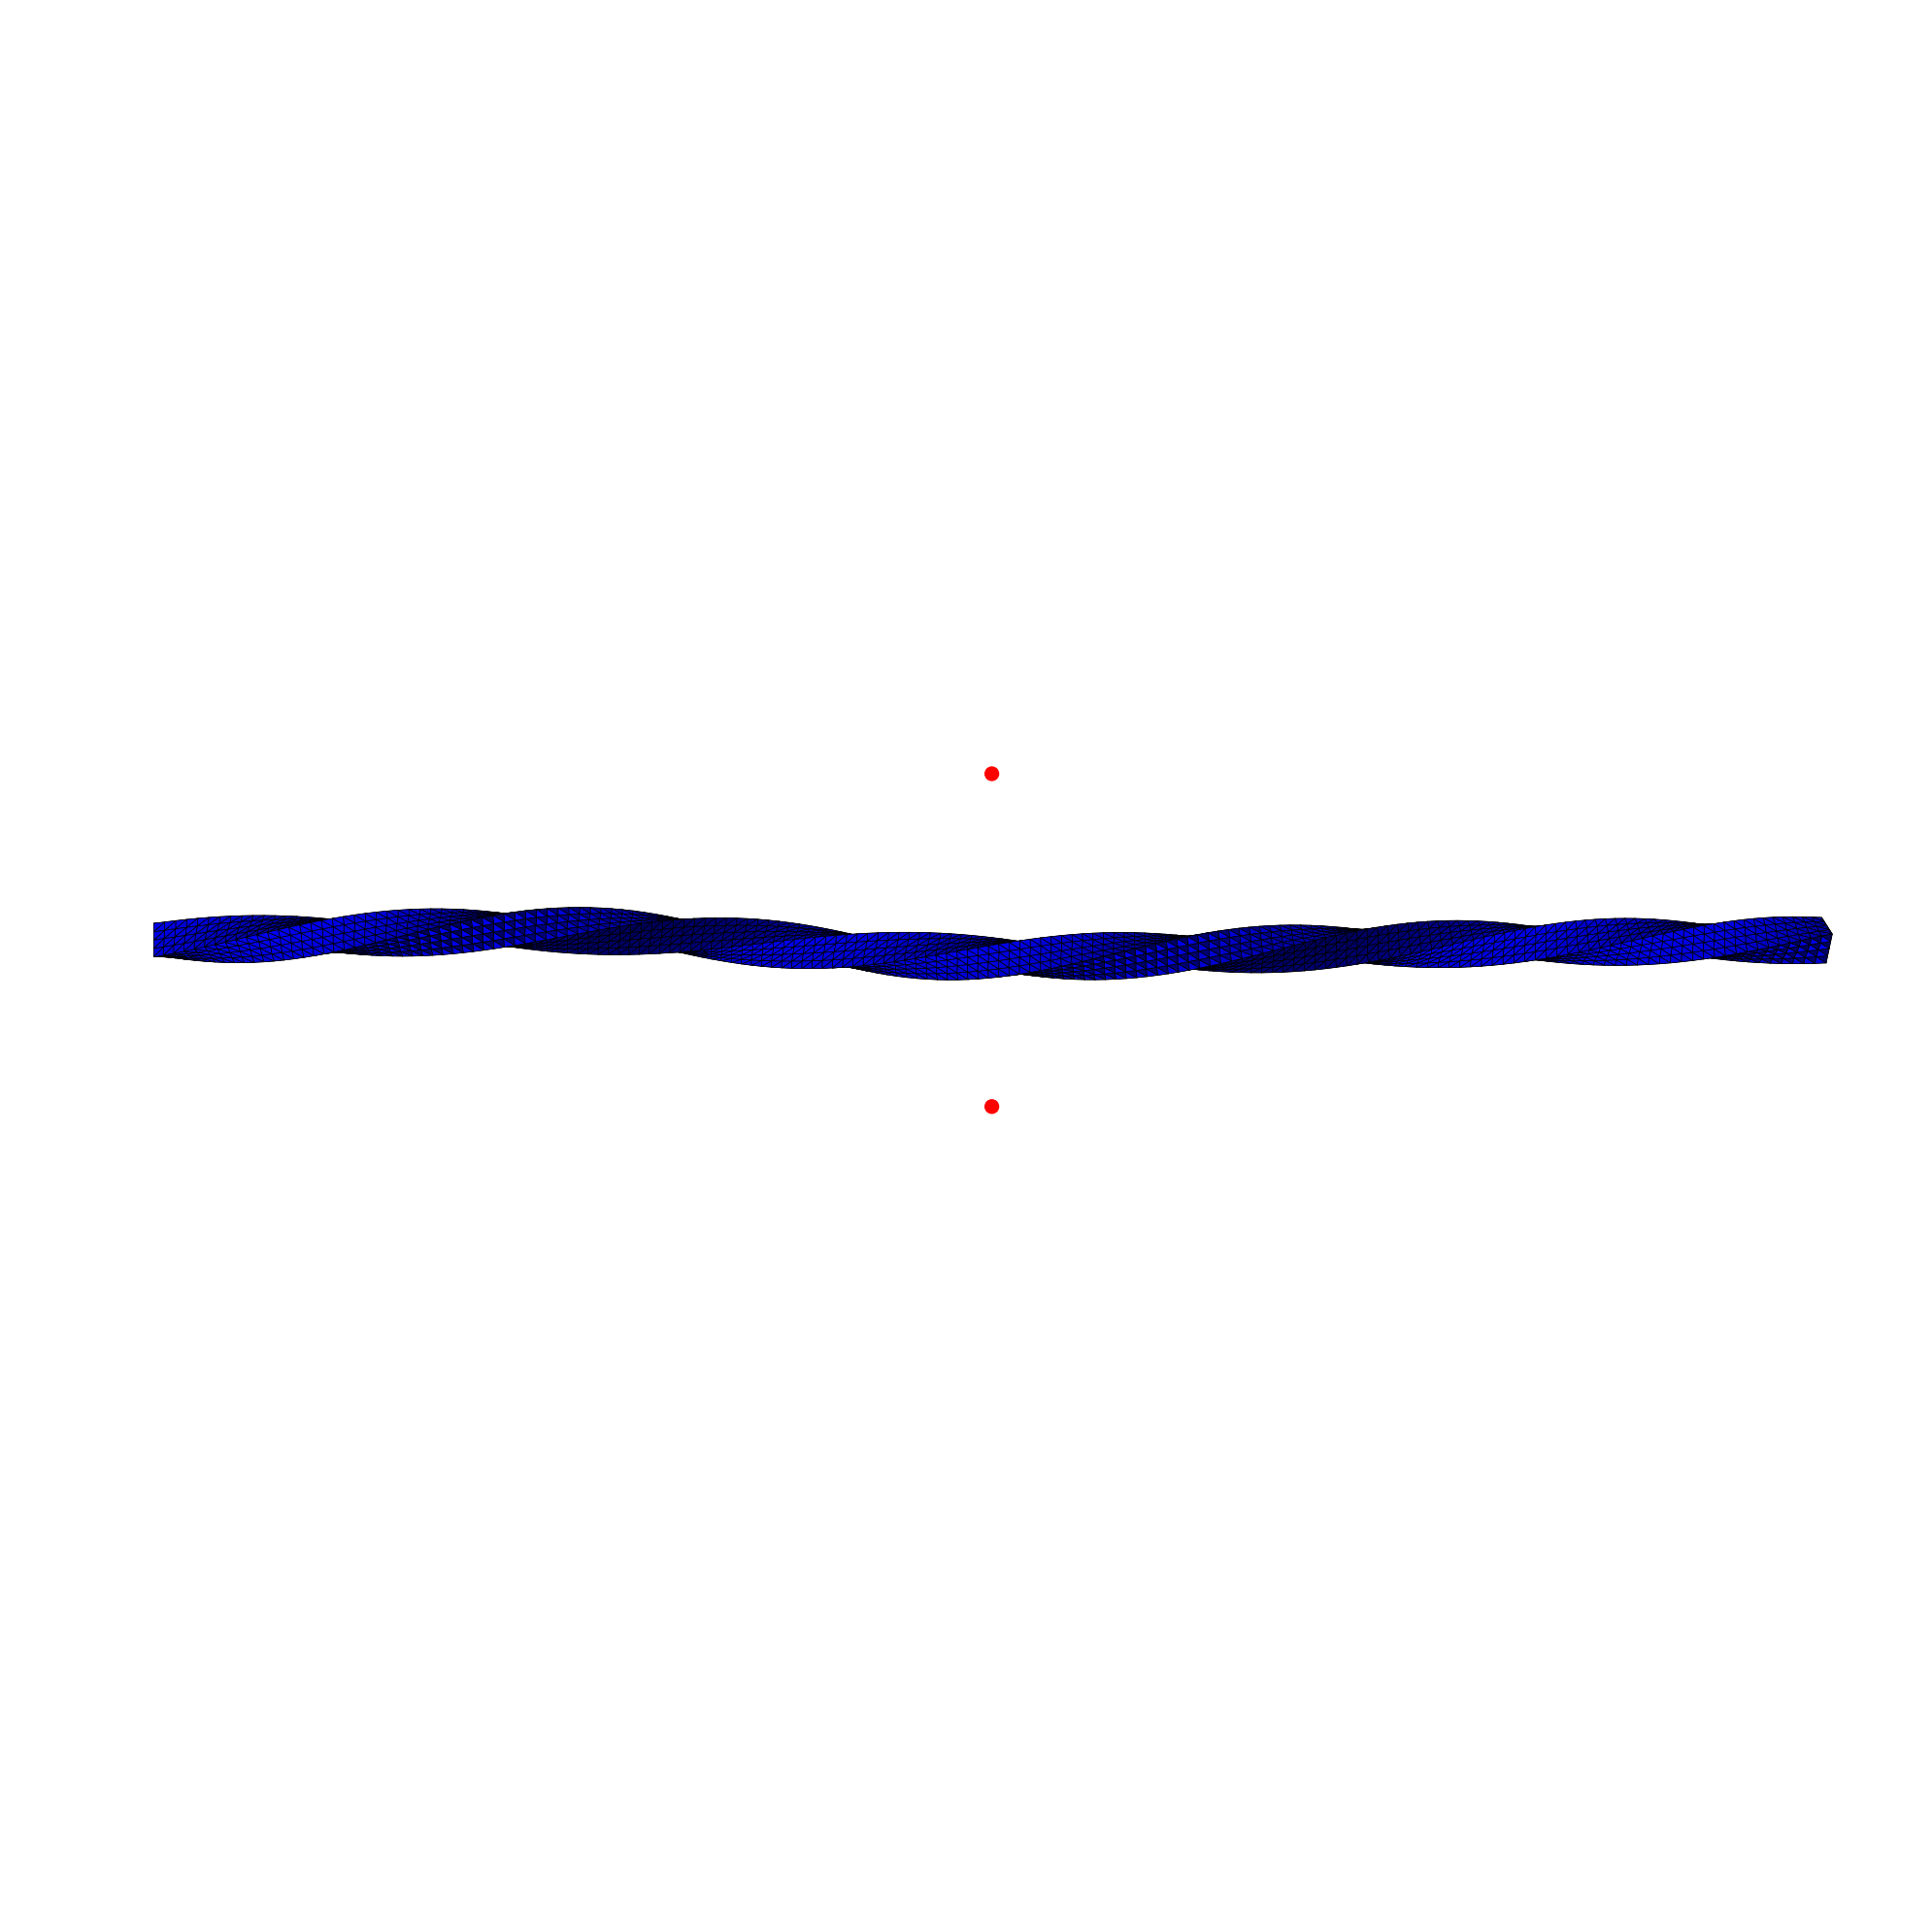

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 45.56107875787131
        x: [ 2.534e-03 -4.518e-03 ... -5.411e-03 -4.494e-03]
      nit: 3405
      jac: [ 5.251e-04  4.361e-03 ... -5.411e-03 -1.090e-03]
     nfev: 3495
     njev: 3495
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


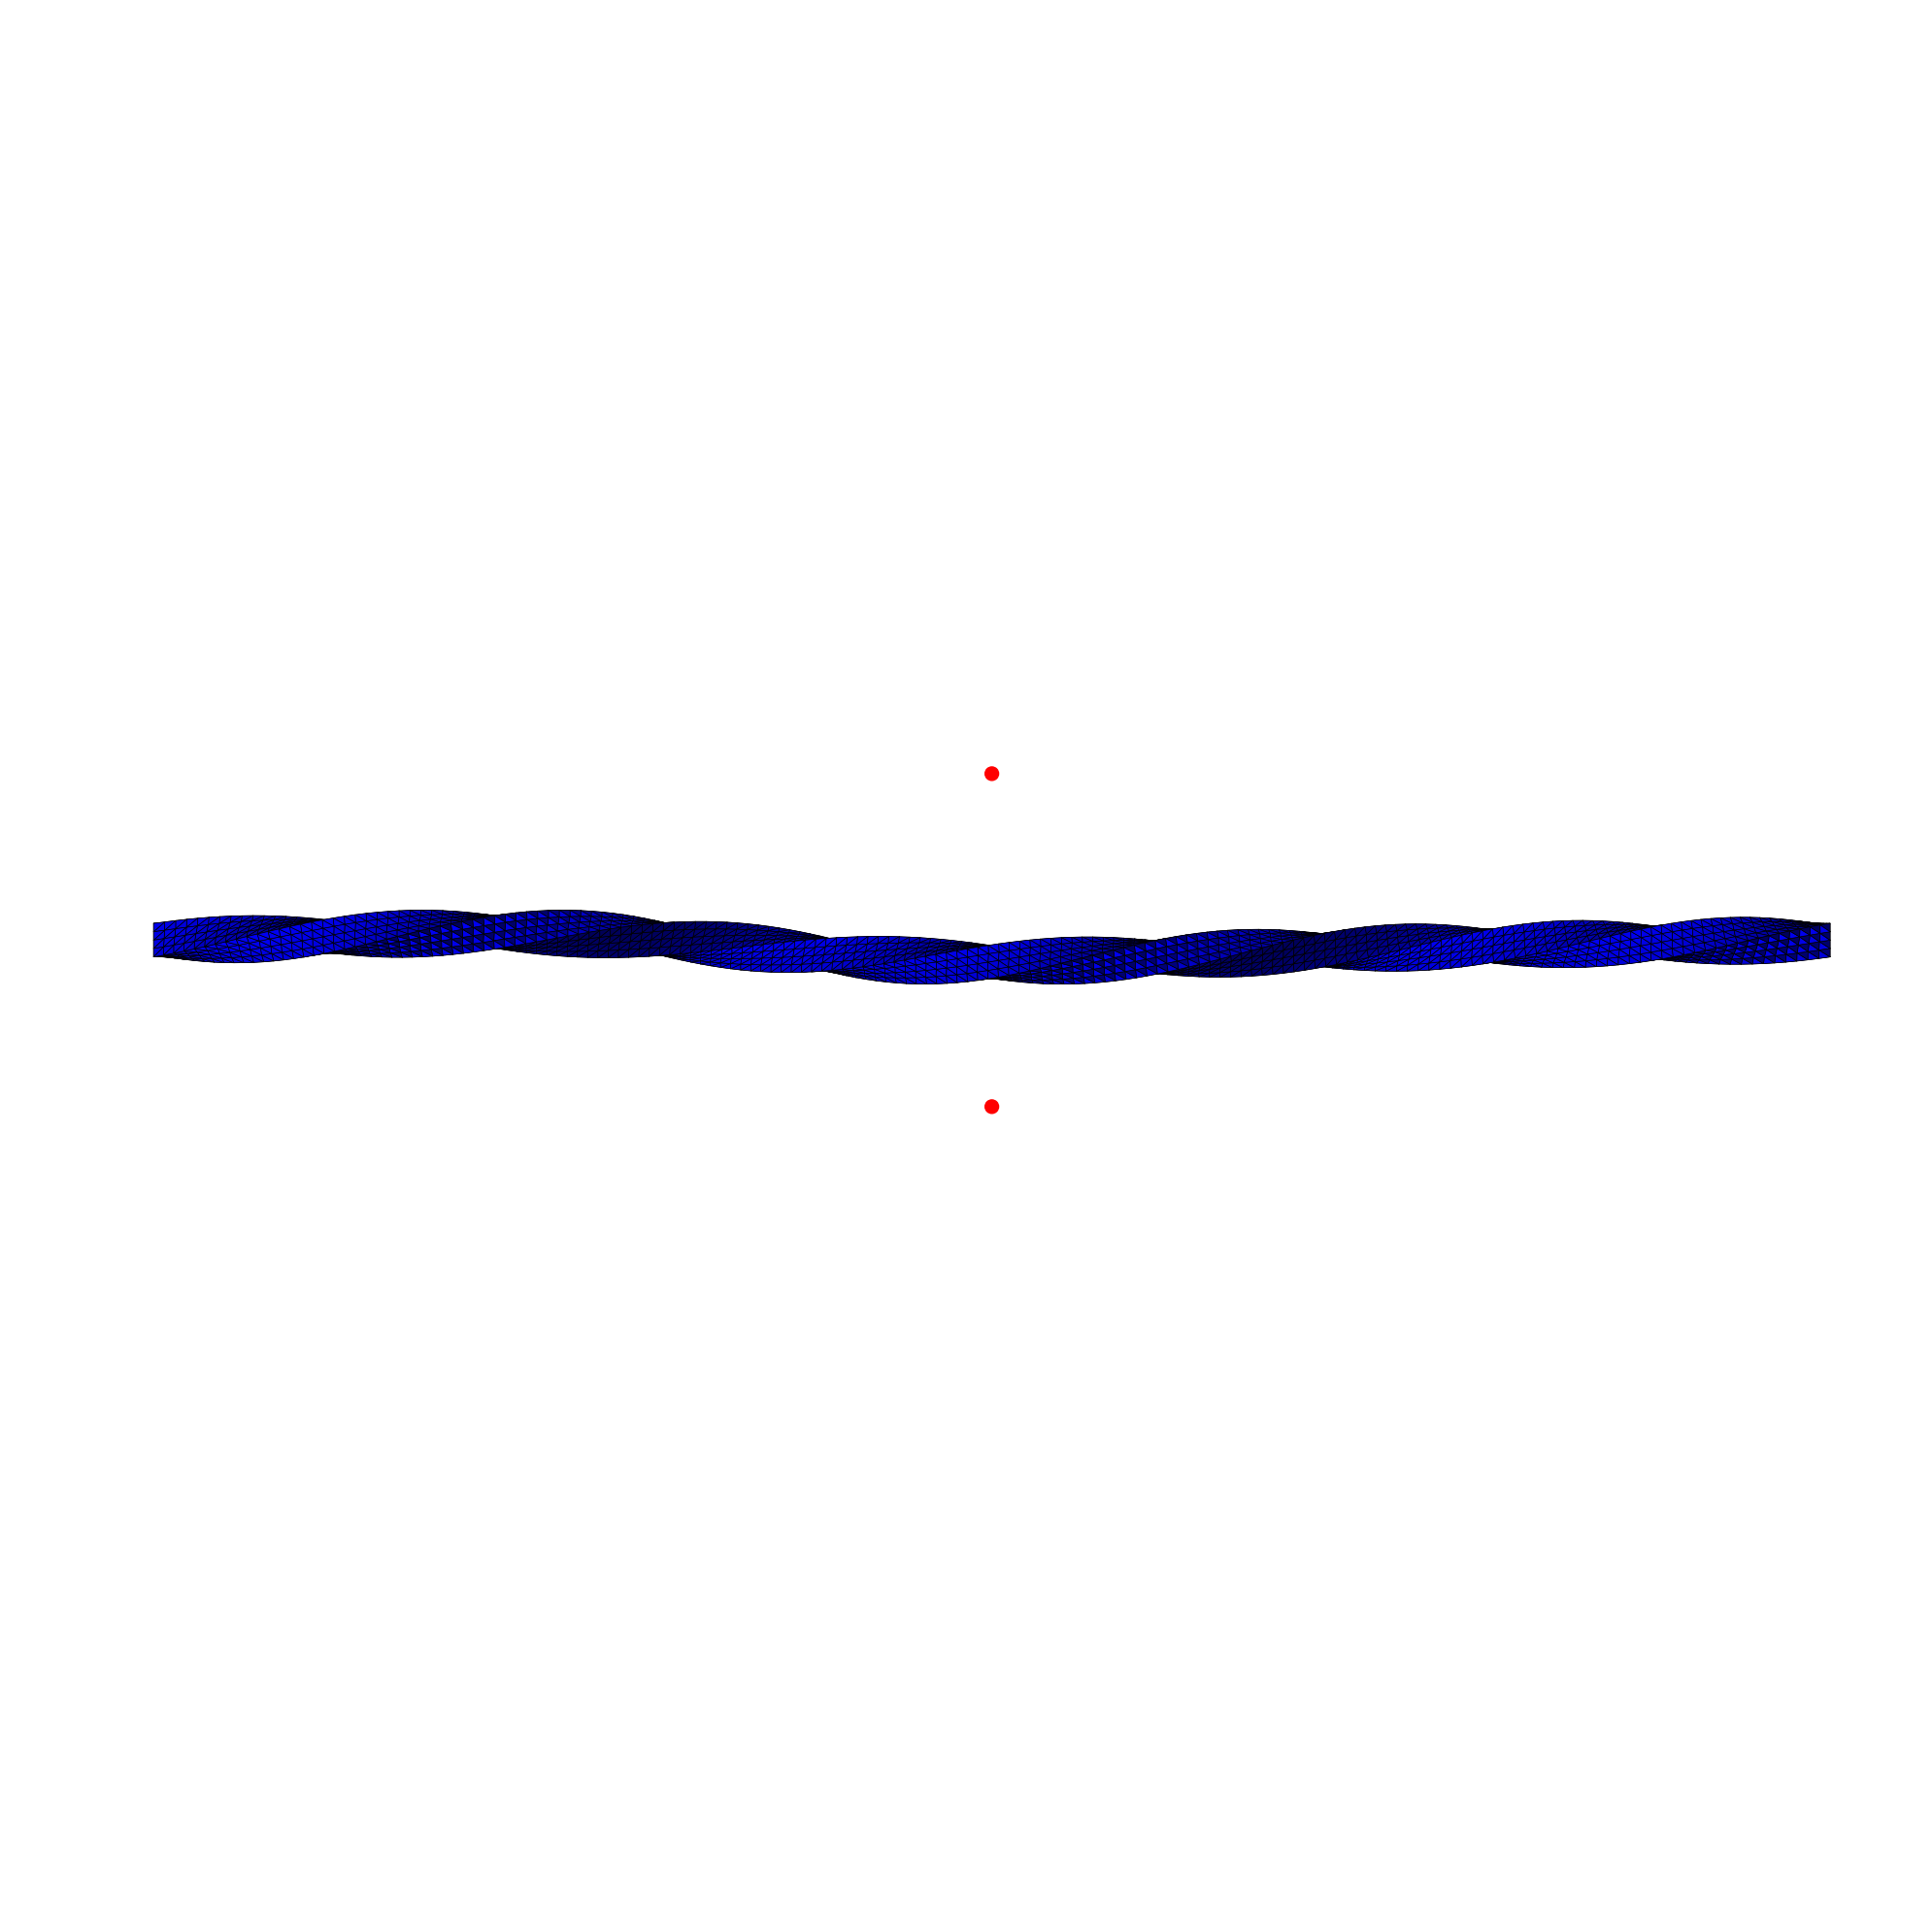

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 48.64535927971065
        x: [ 2.539e-03 -4.499e-03 ... -2.459e-03 -6.592e-03]
      nit: 2067
      jac: [-3.500e-03  1.333e-02 ...  2.072e-02 -6.154e-03]
     nfev: 2134
     njev: 2134
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


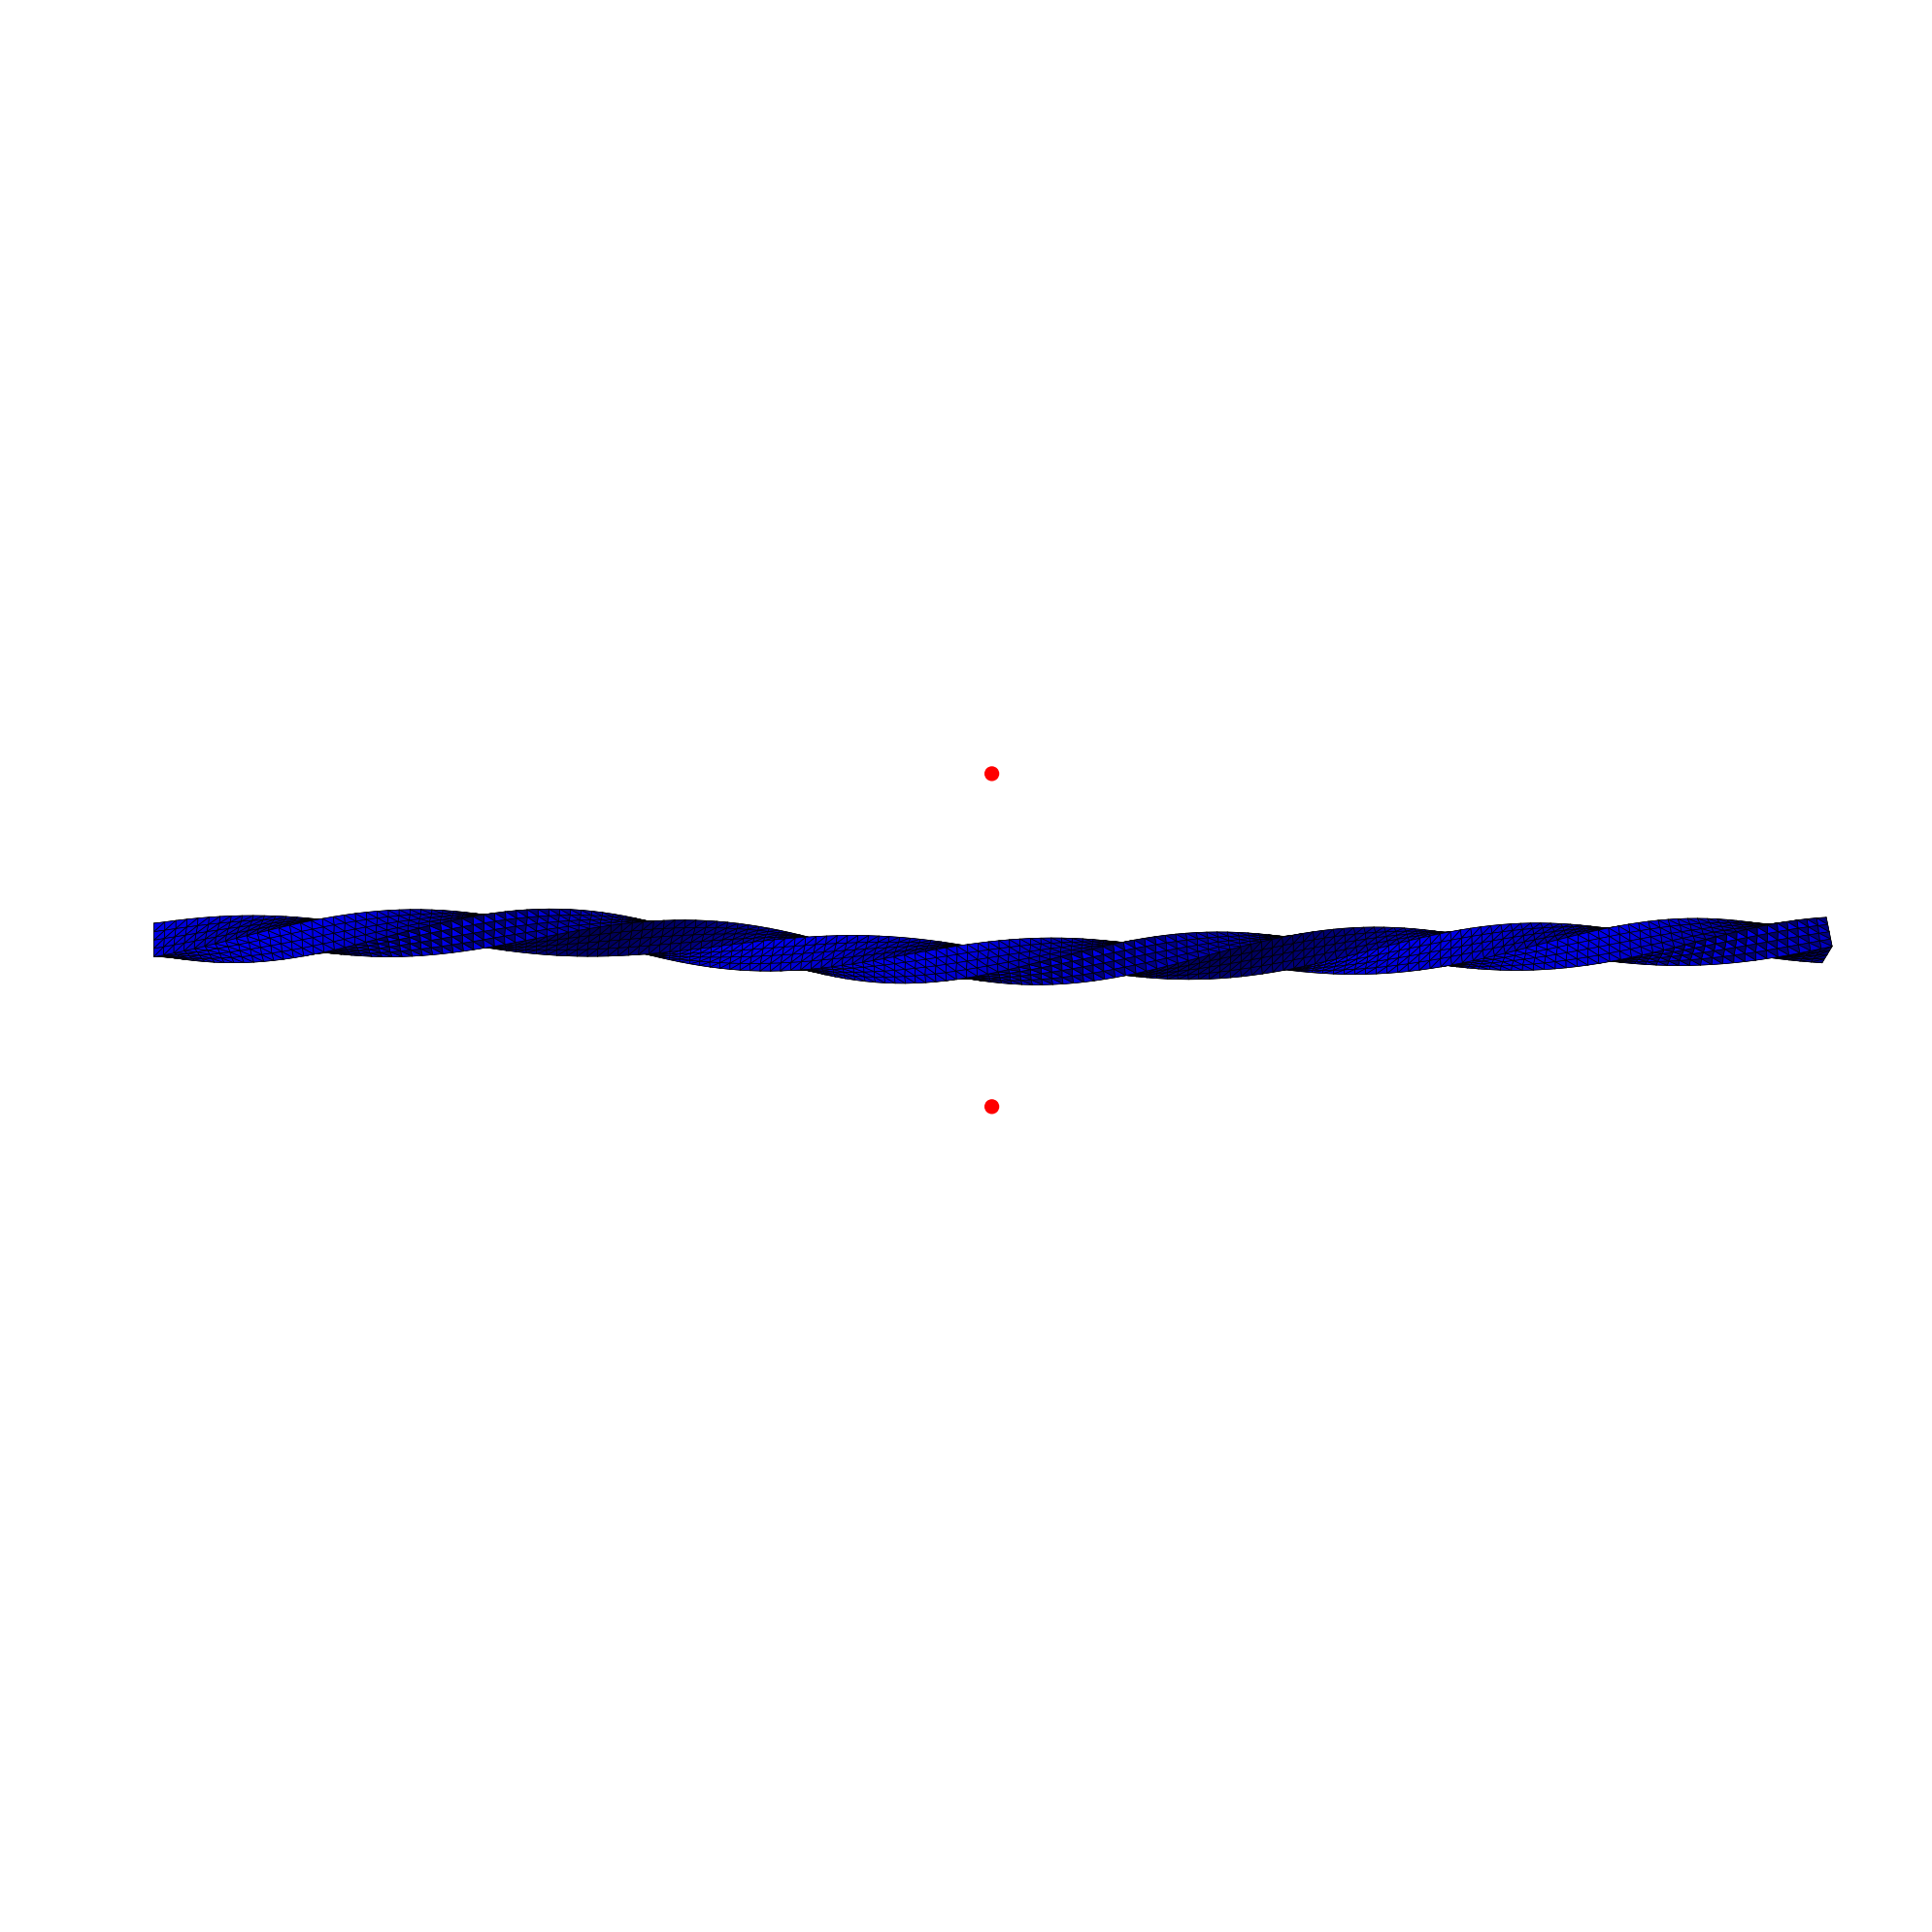

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 51.82594189369322
        x: [ 2.540e-03 -4.482e-03 ...  1.146e-03 -6.947e-03]
      nit: 4068
      jac: [ 4.616e-03  4.949e-04 ... -9.080e-03  5.966e-03]
     nfev: 4201
     njev: 4201
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


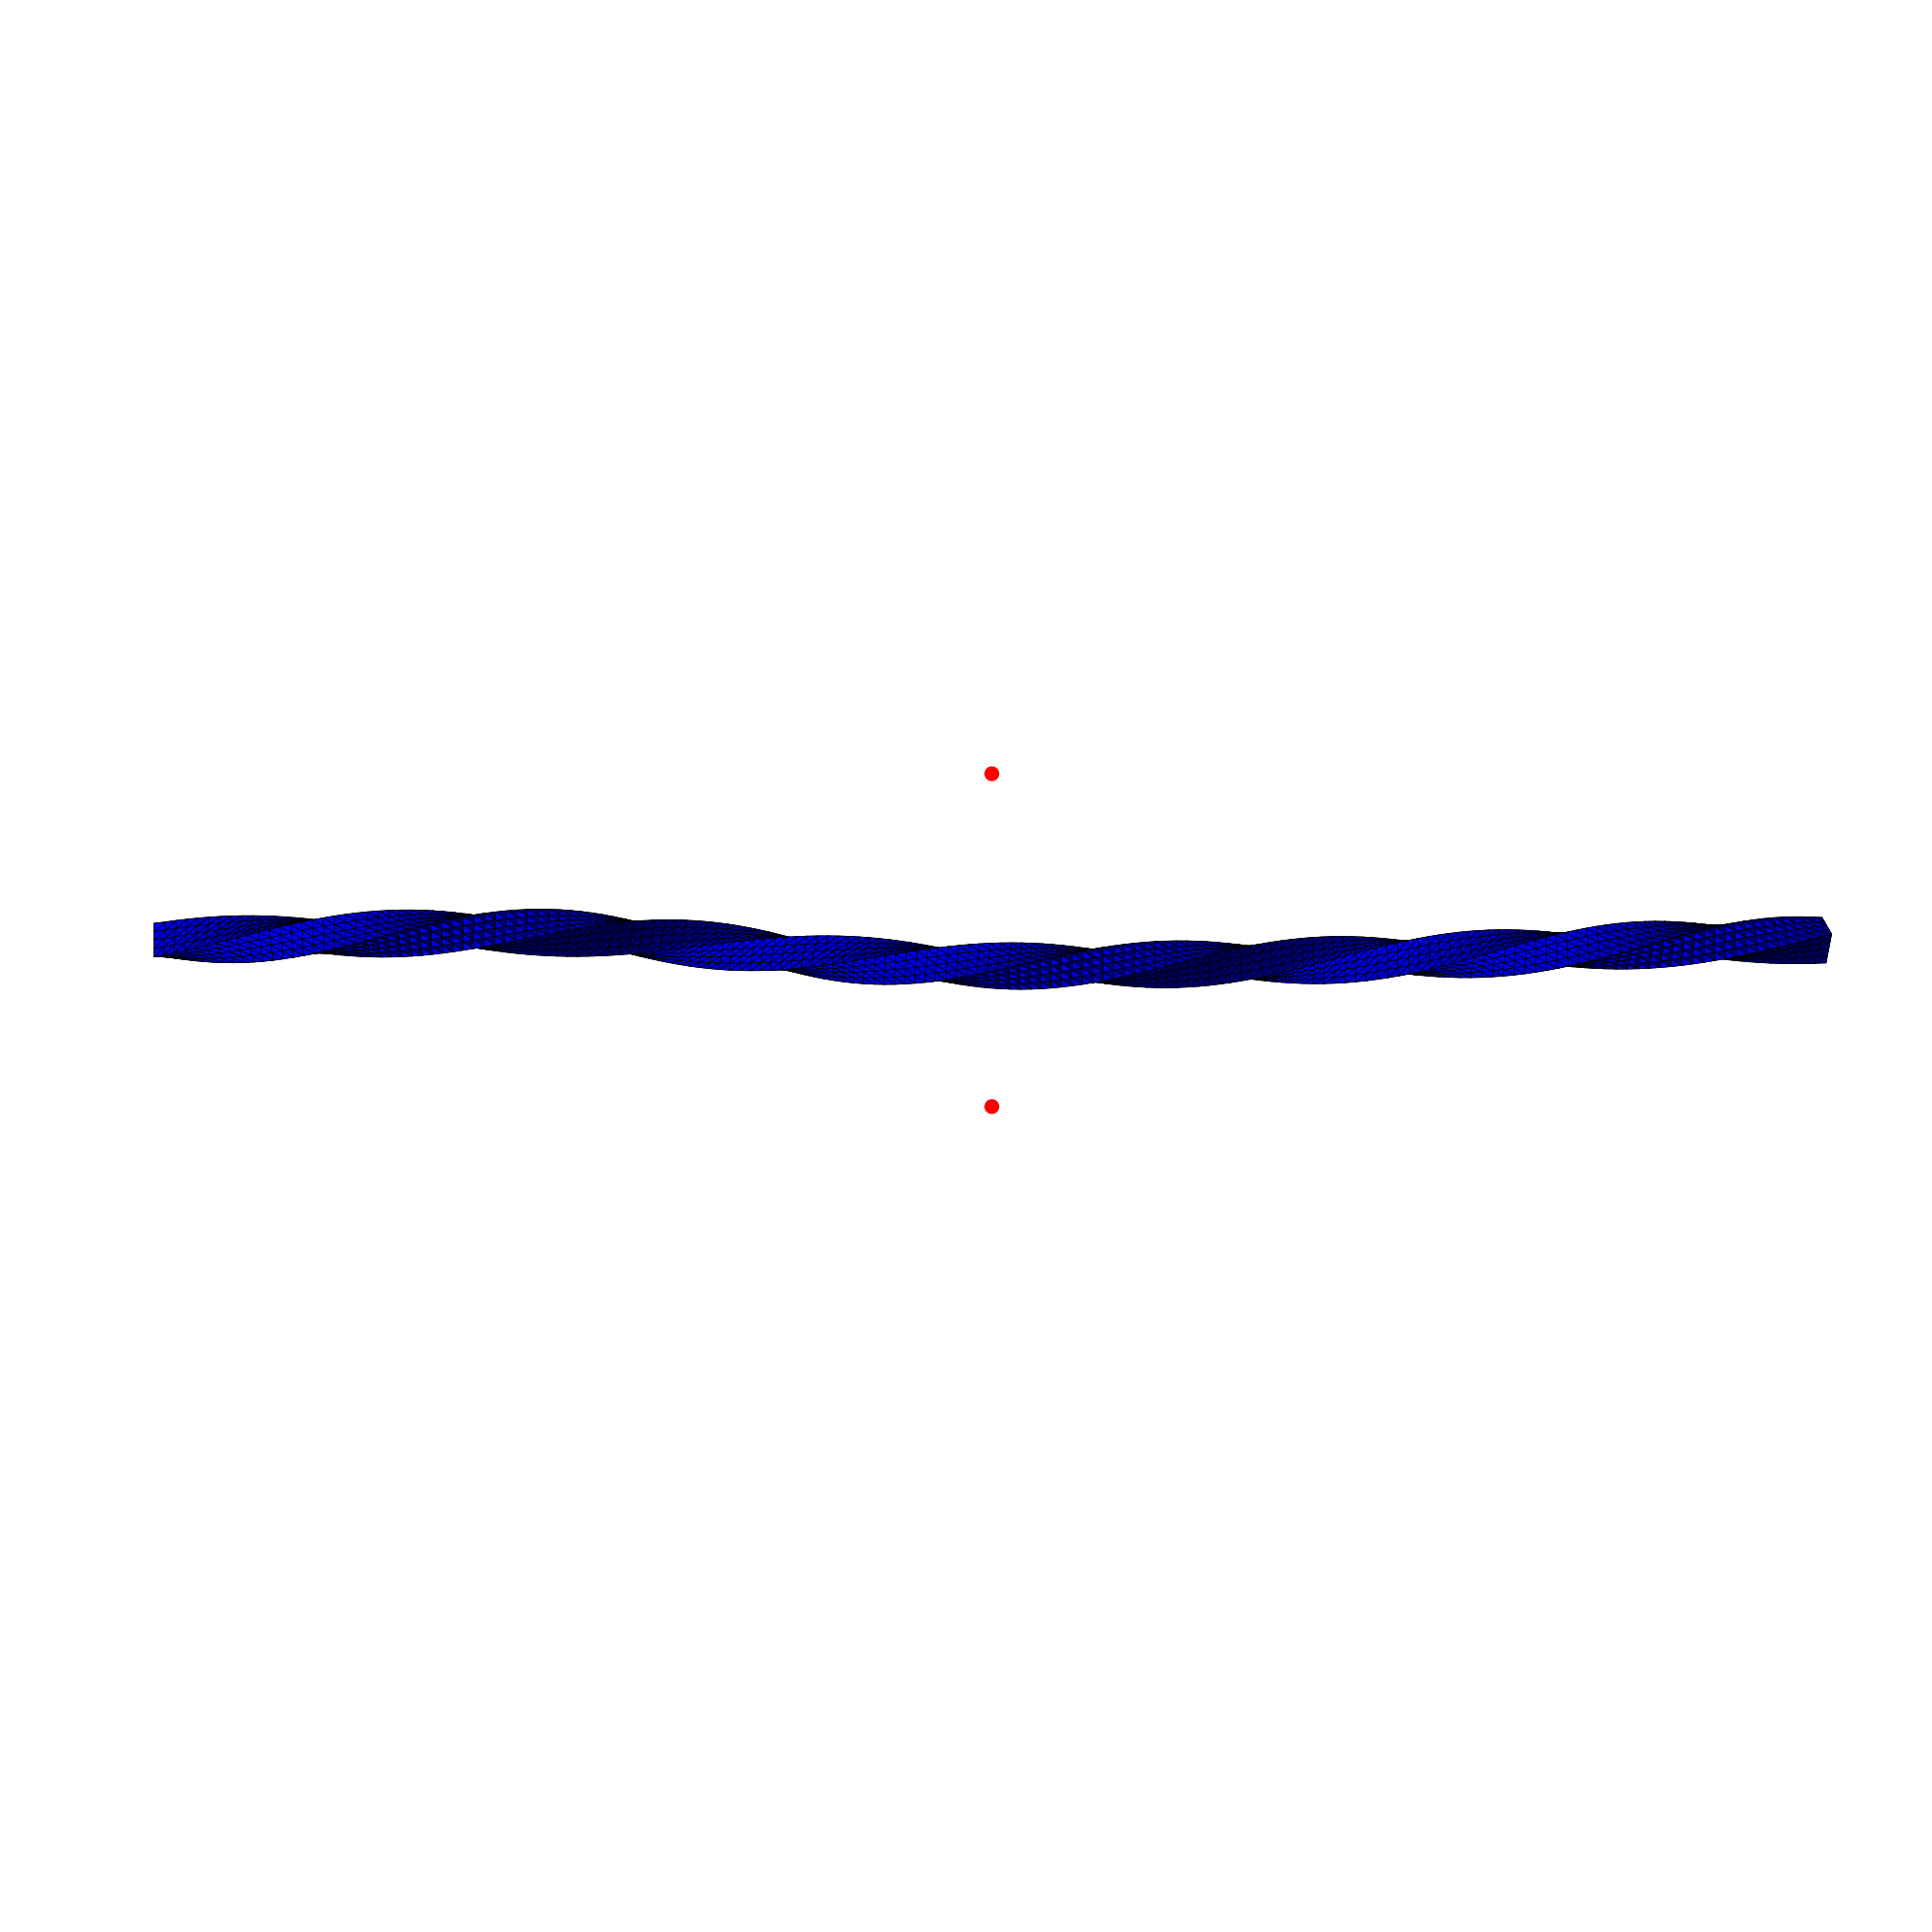

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 55.103915826233845
        x: [ 2.543e-03 -4.464e-03 ...  4.455e-03 -5.460e-03]
      nit: 4691
      jac: [-6.641e-03  6.237e-03 ...  8.583e-03  1.561e-02]
     nfev: 4830
     njev: 4830
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


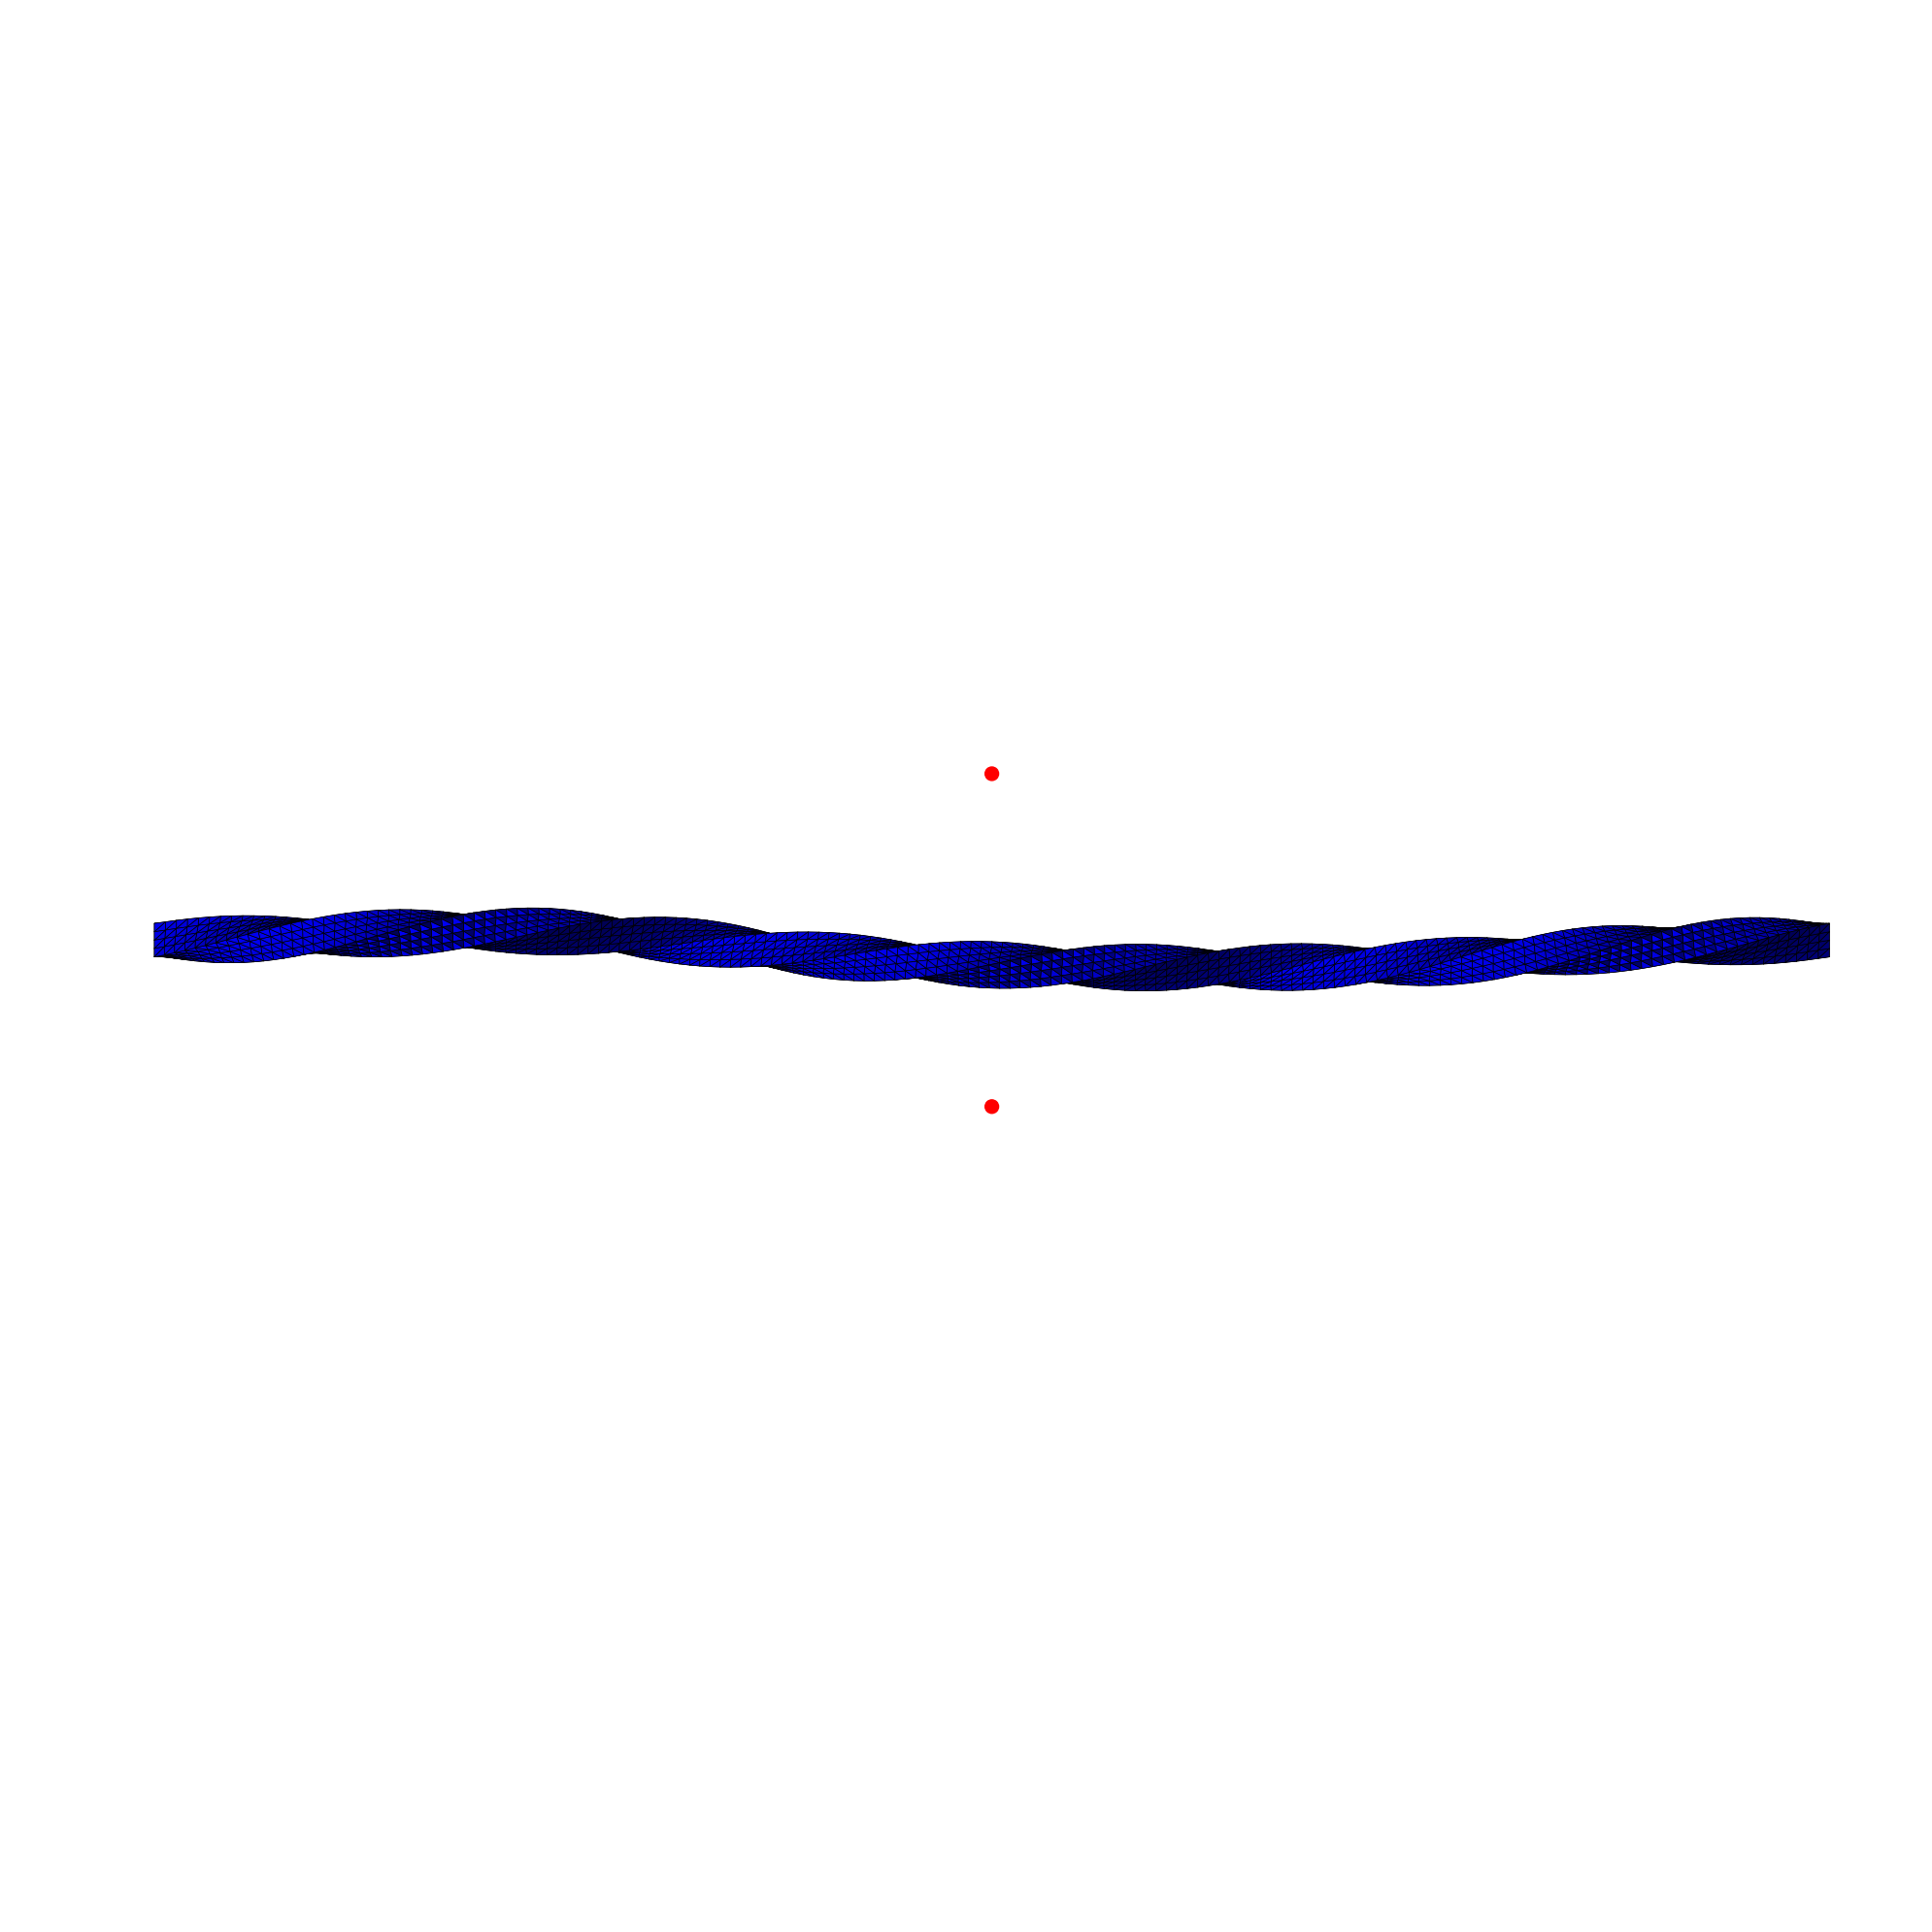

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 58.482096851493615
        x: [ 2.547e-03 -4.446e-03 ...  6.577e-03 -2.521e-03]
      nit: 2107
      jac: [ 1.084e-02 -1.189e-02 ...  4.524e-03 -1.353e-02]
     nfev: 2172
     njev: 2172
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


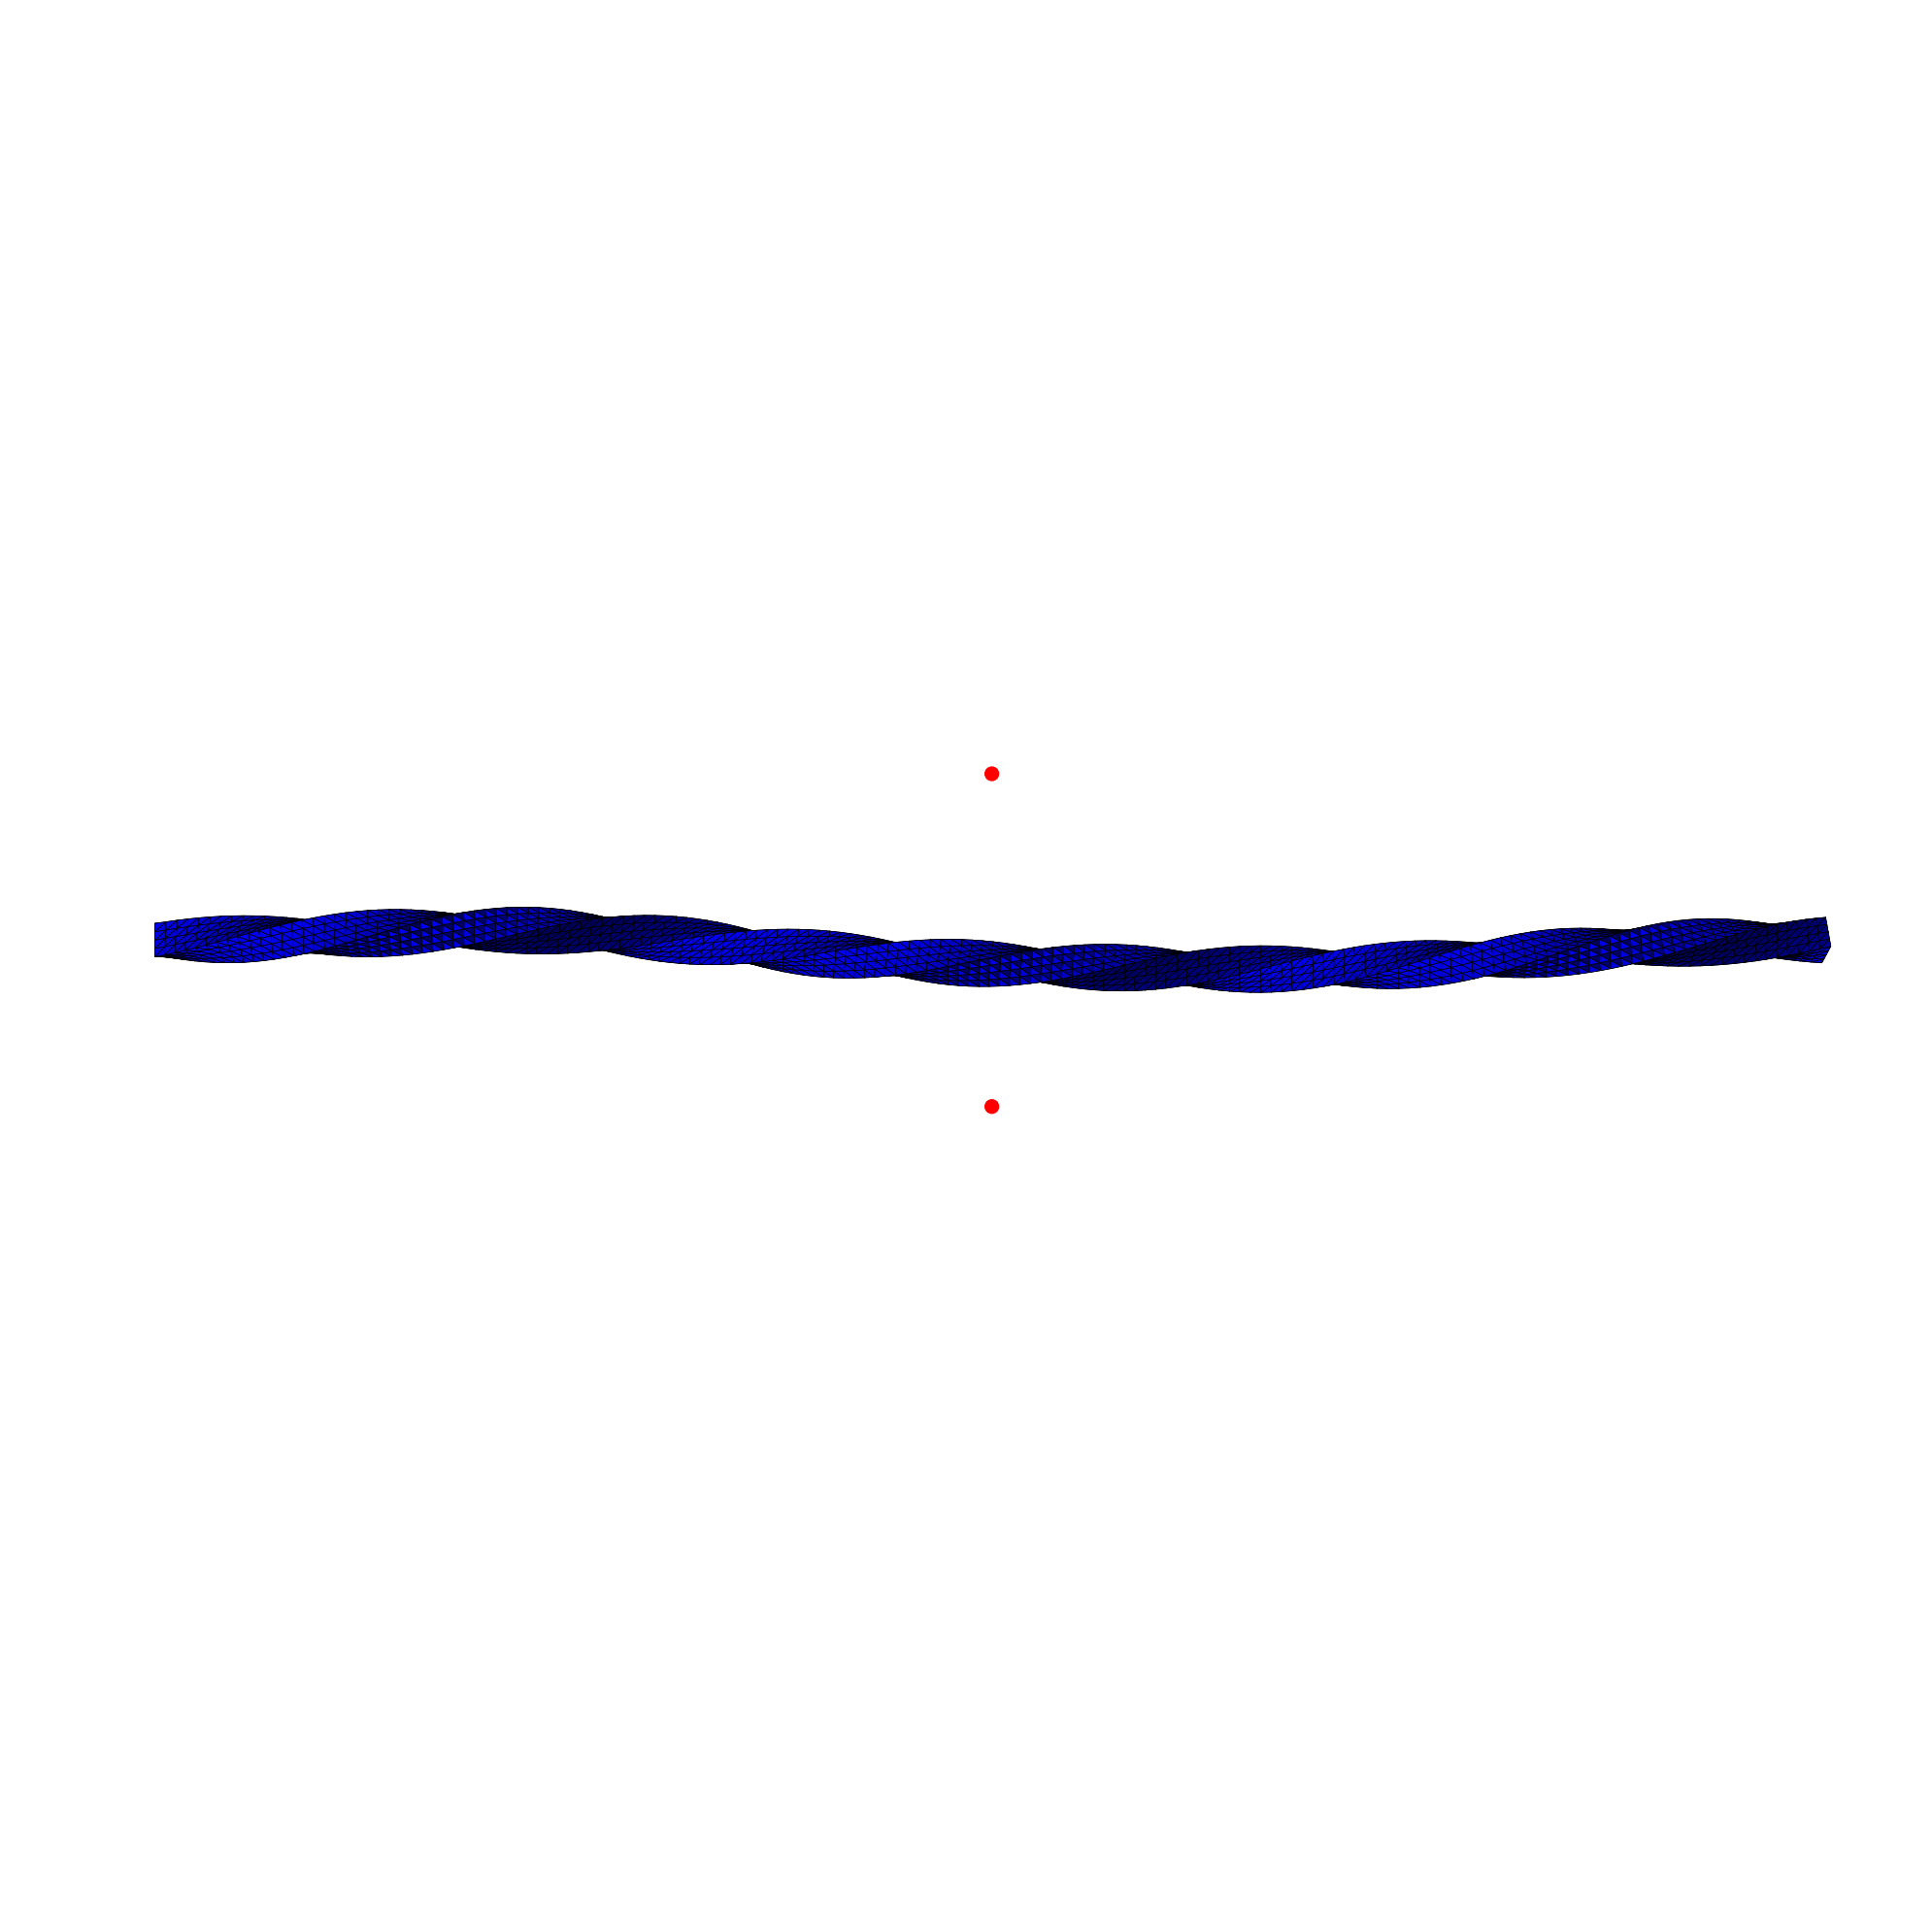

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 61.961882425009854
        x: [ 2.551e-03 -4.428e-03 ...  6.953e-03  1.083e-03]
      nit: 2047
      jac: [ 7.612e-03  2.350e-03 ... -3.866e-03  9.884e-03]
     nfev: 2110
     njev: 2110
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


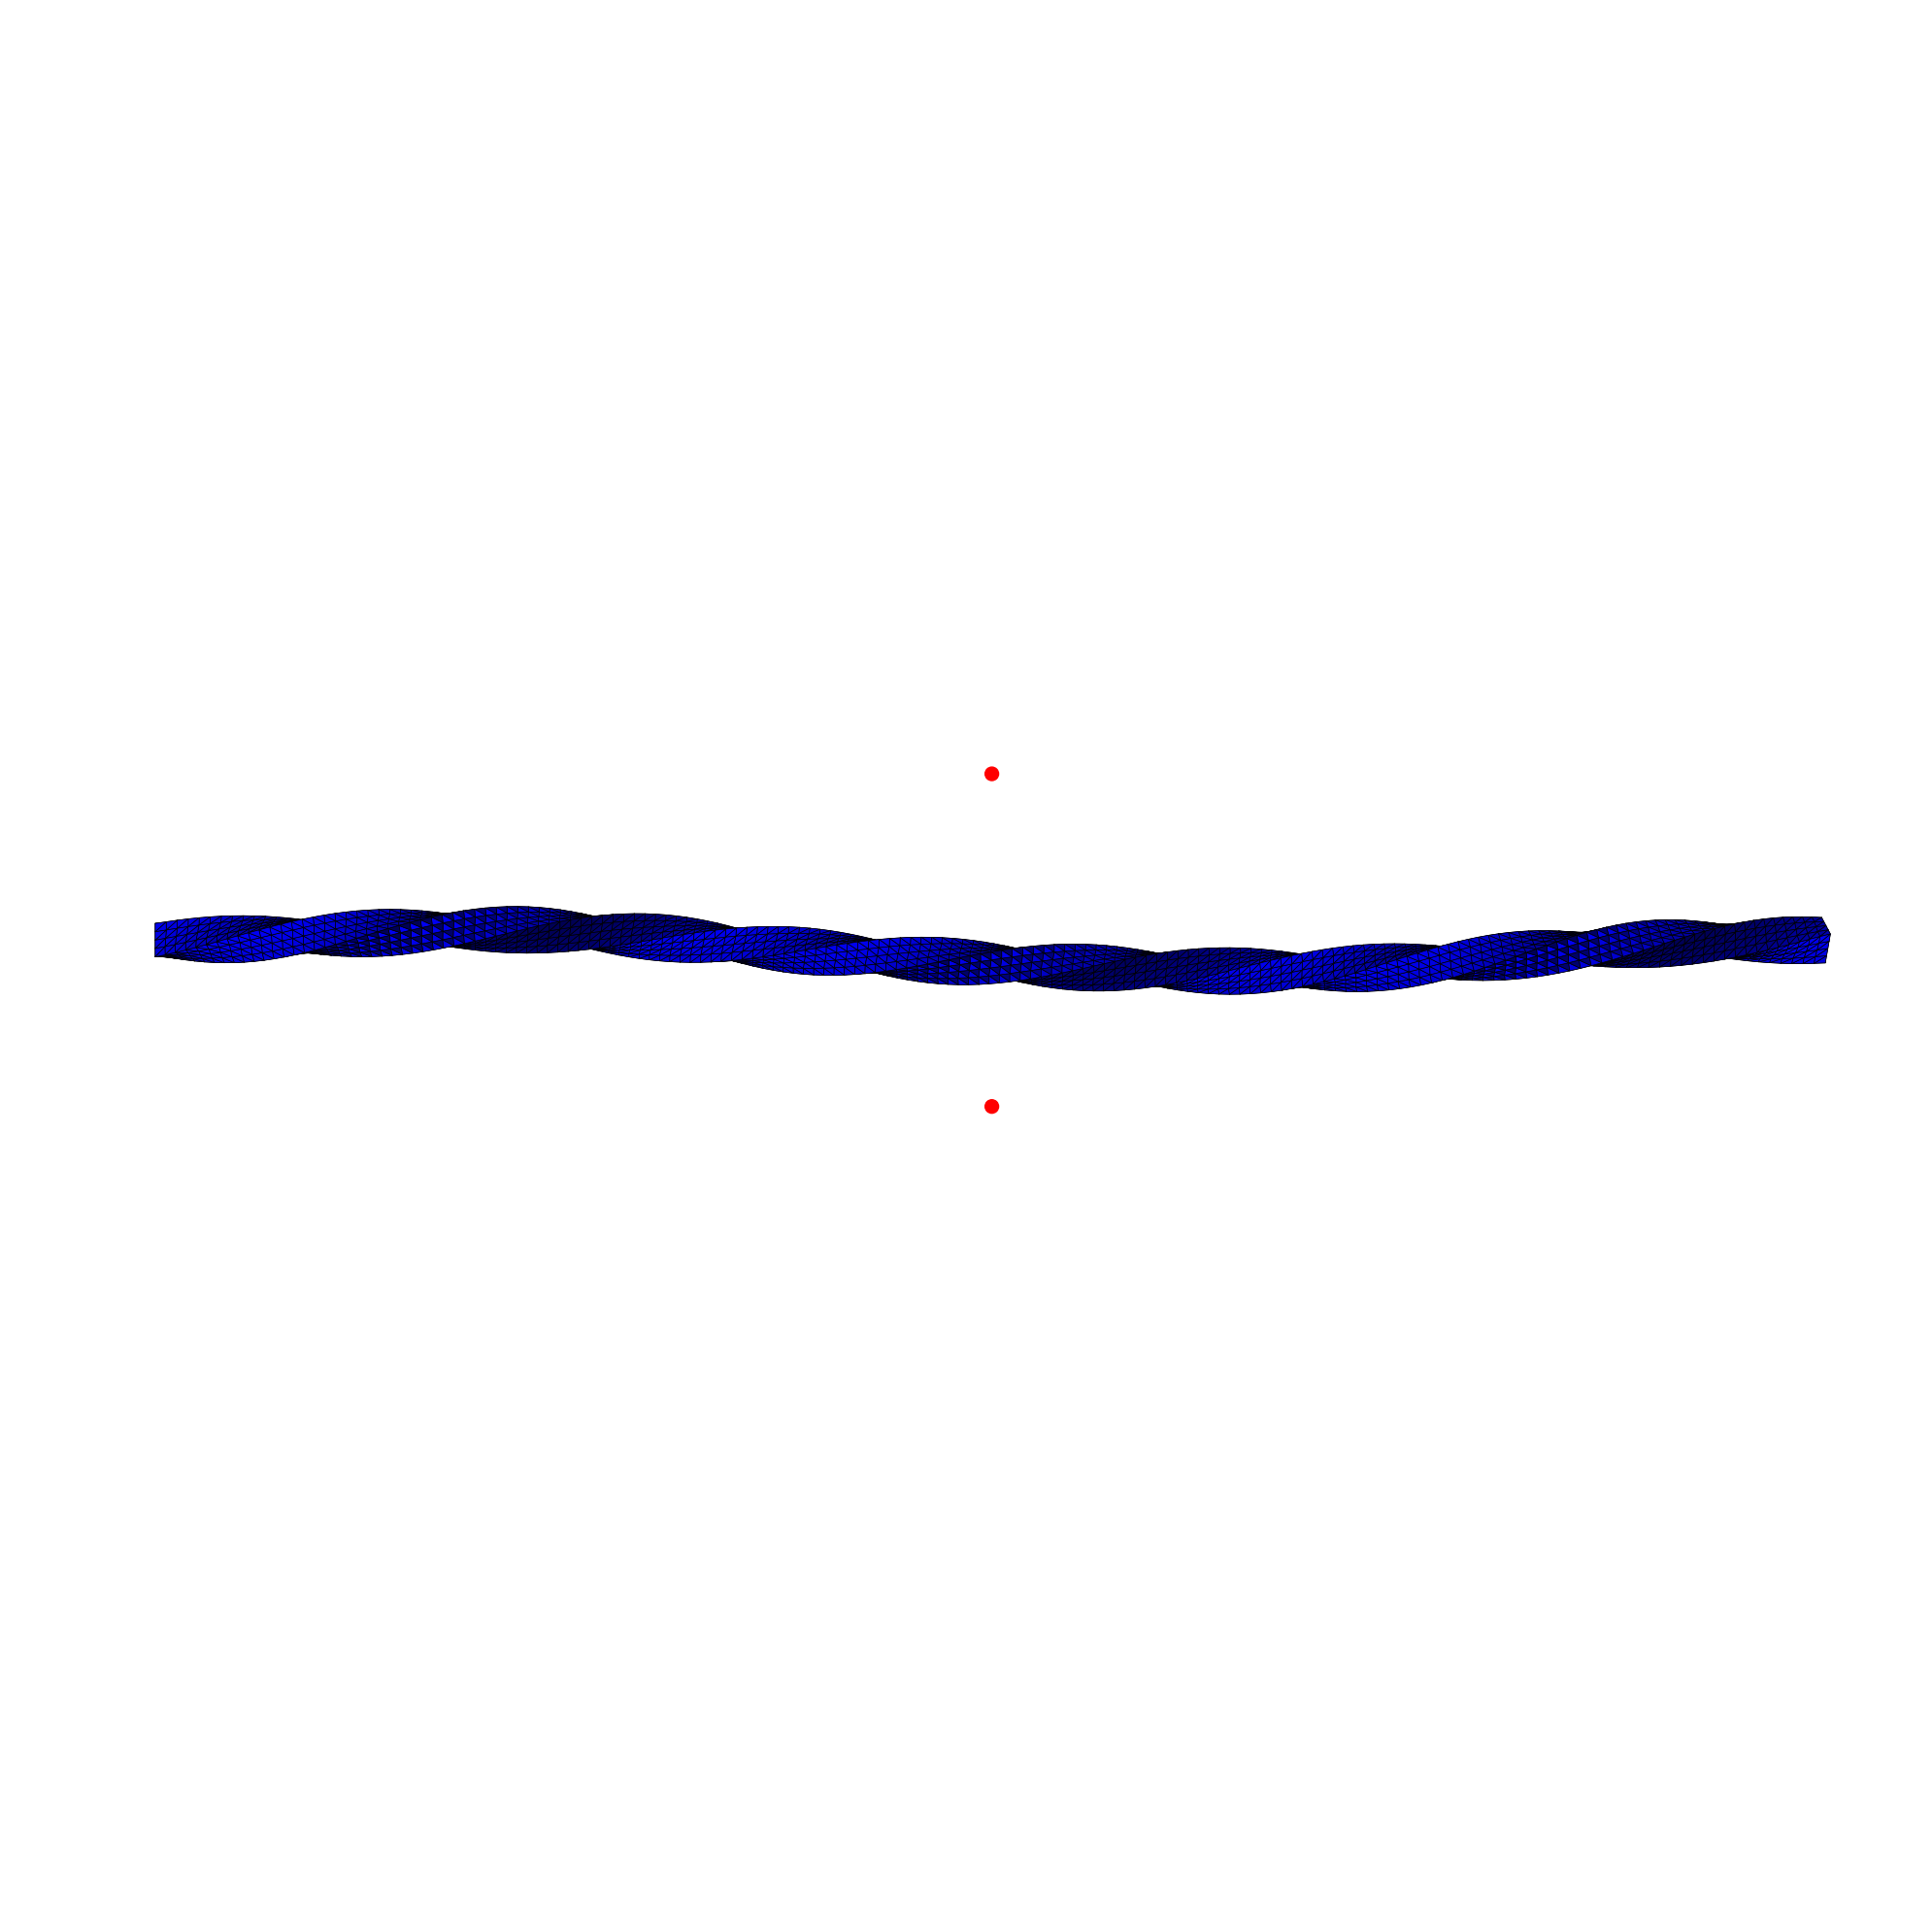

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 65.54408238488205
        x: [ 2.555e-03 -4.411e-03 ...  5.486e-03  4.391e-03]
      nit: 2038
      jac: [-1.841e-04  2.733e-03 ...  2.304e-03 -1.875e-03]
     nfev: 2106
     njev: 2106
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


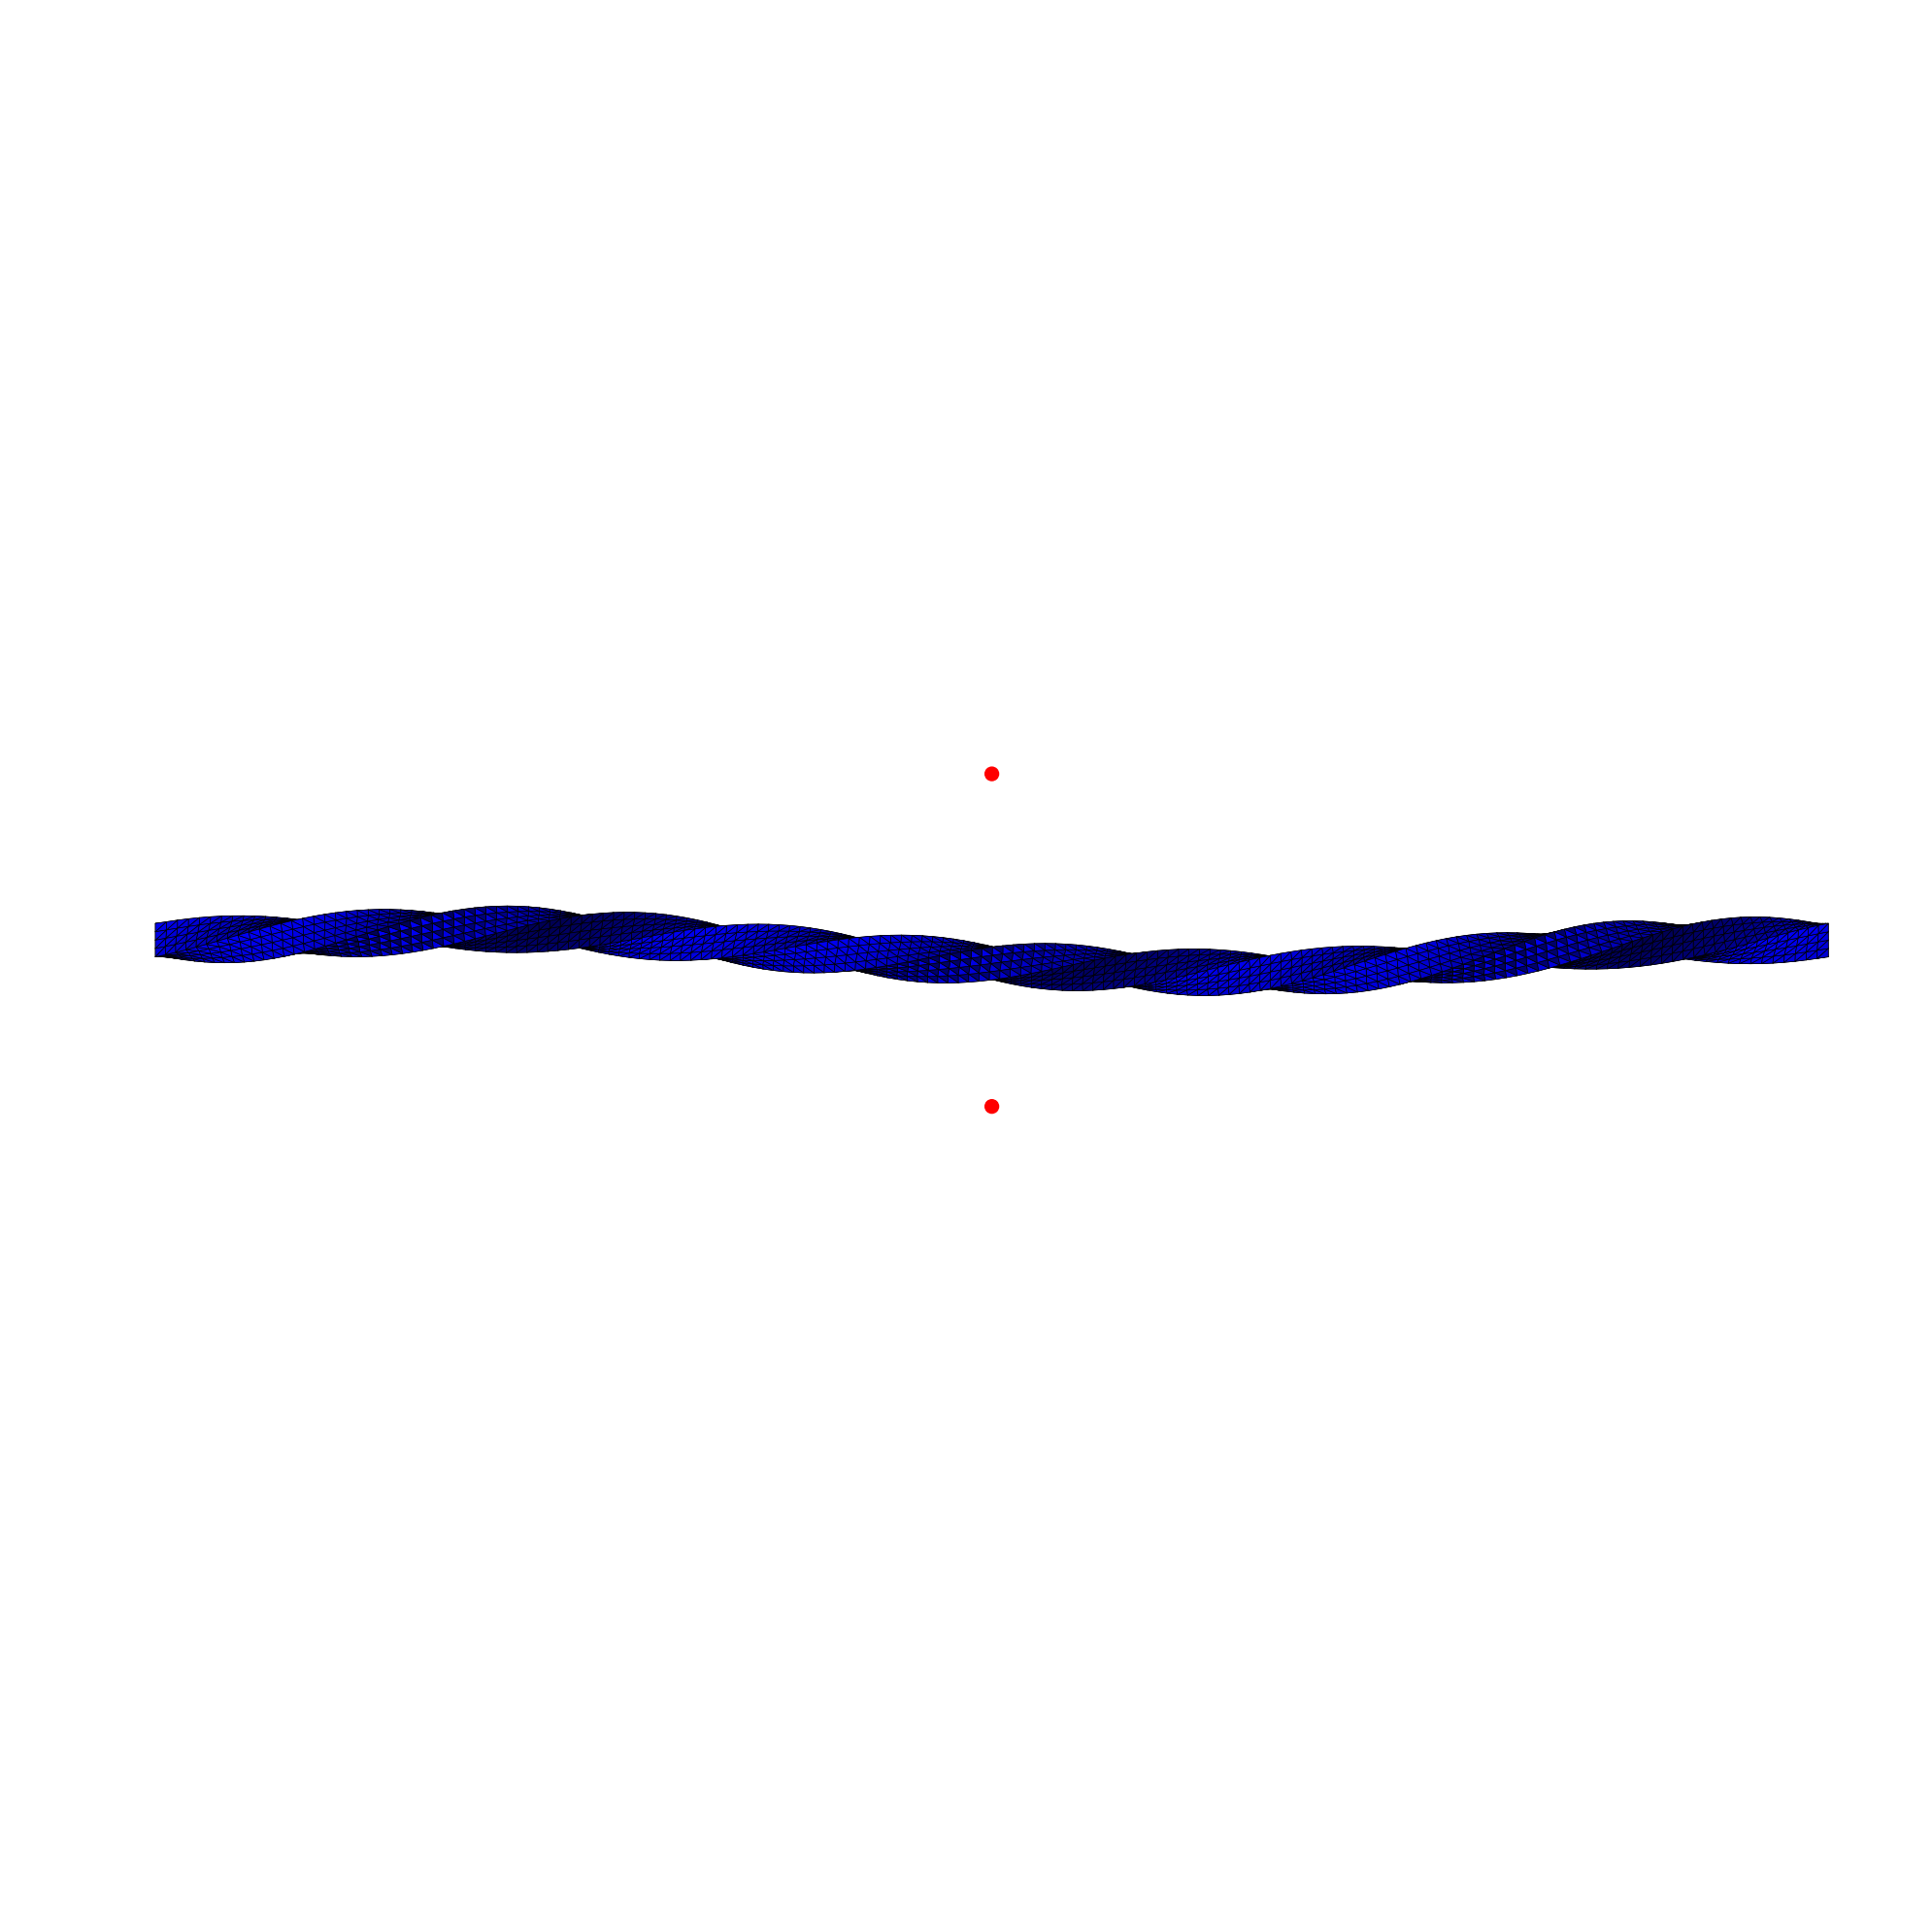

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 69.22806319489958
        x: [ 2.560e-03 -4.392e-03 ...  2.573e-03  6.531e-03]
      nit: 2857
      jac: [-1.264e-03  5.591e-03 ... -1.444e-02  2.712e-03]
     nfev: 2941
     njev: 2941
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


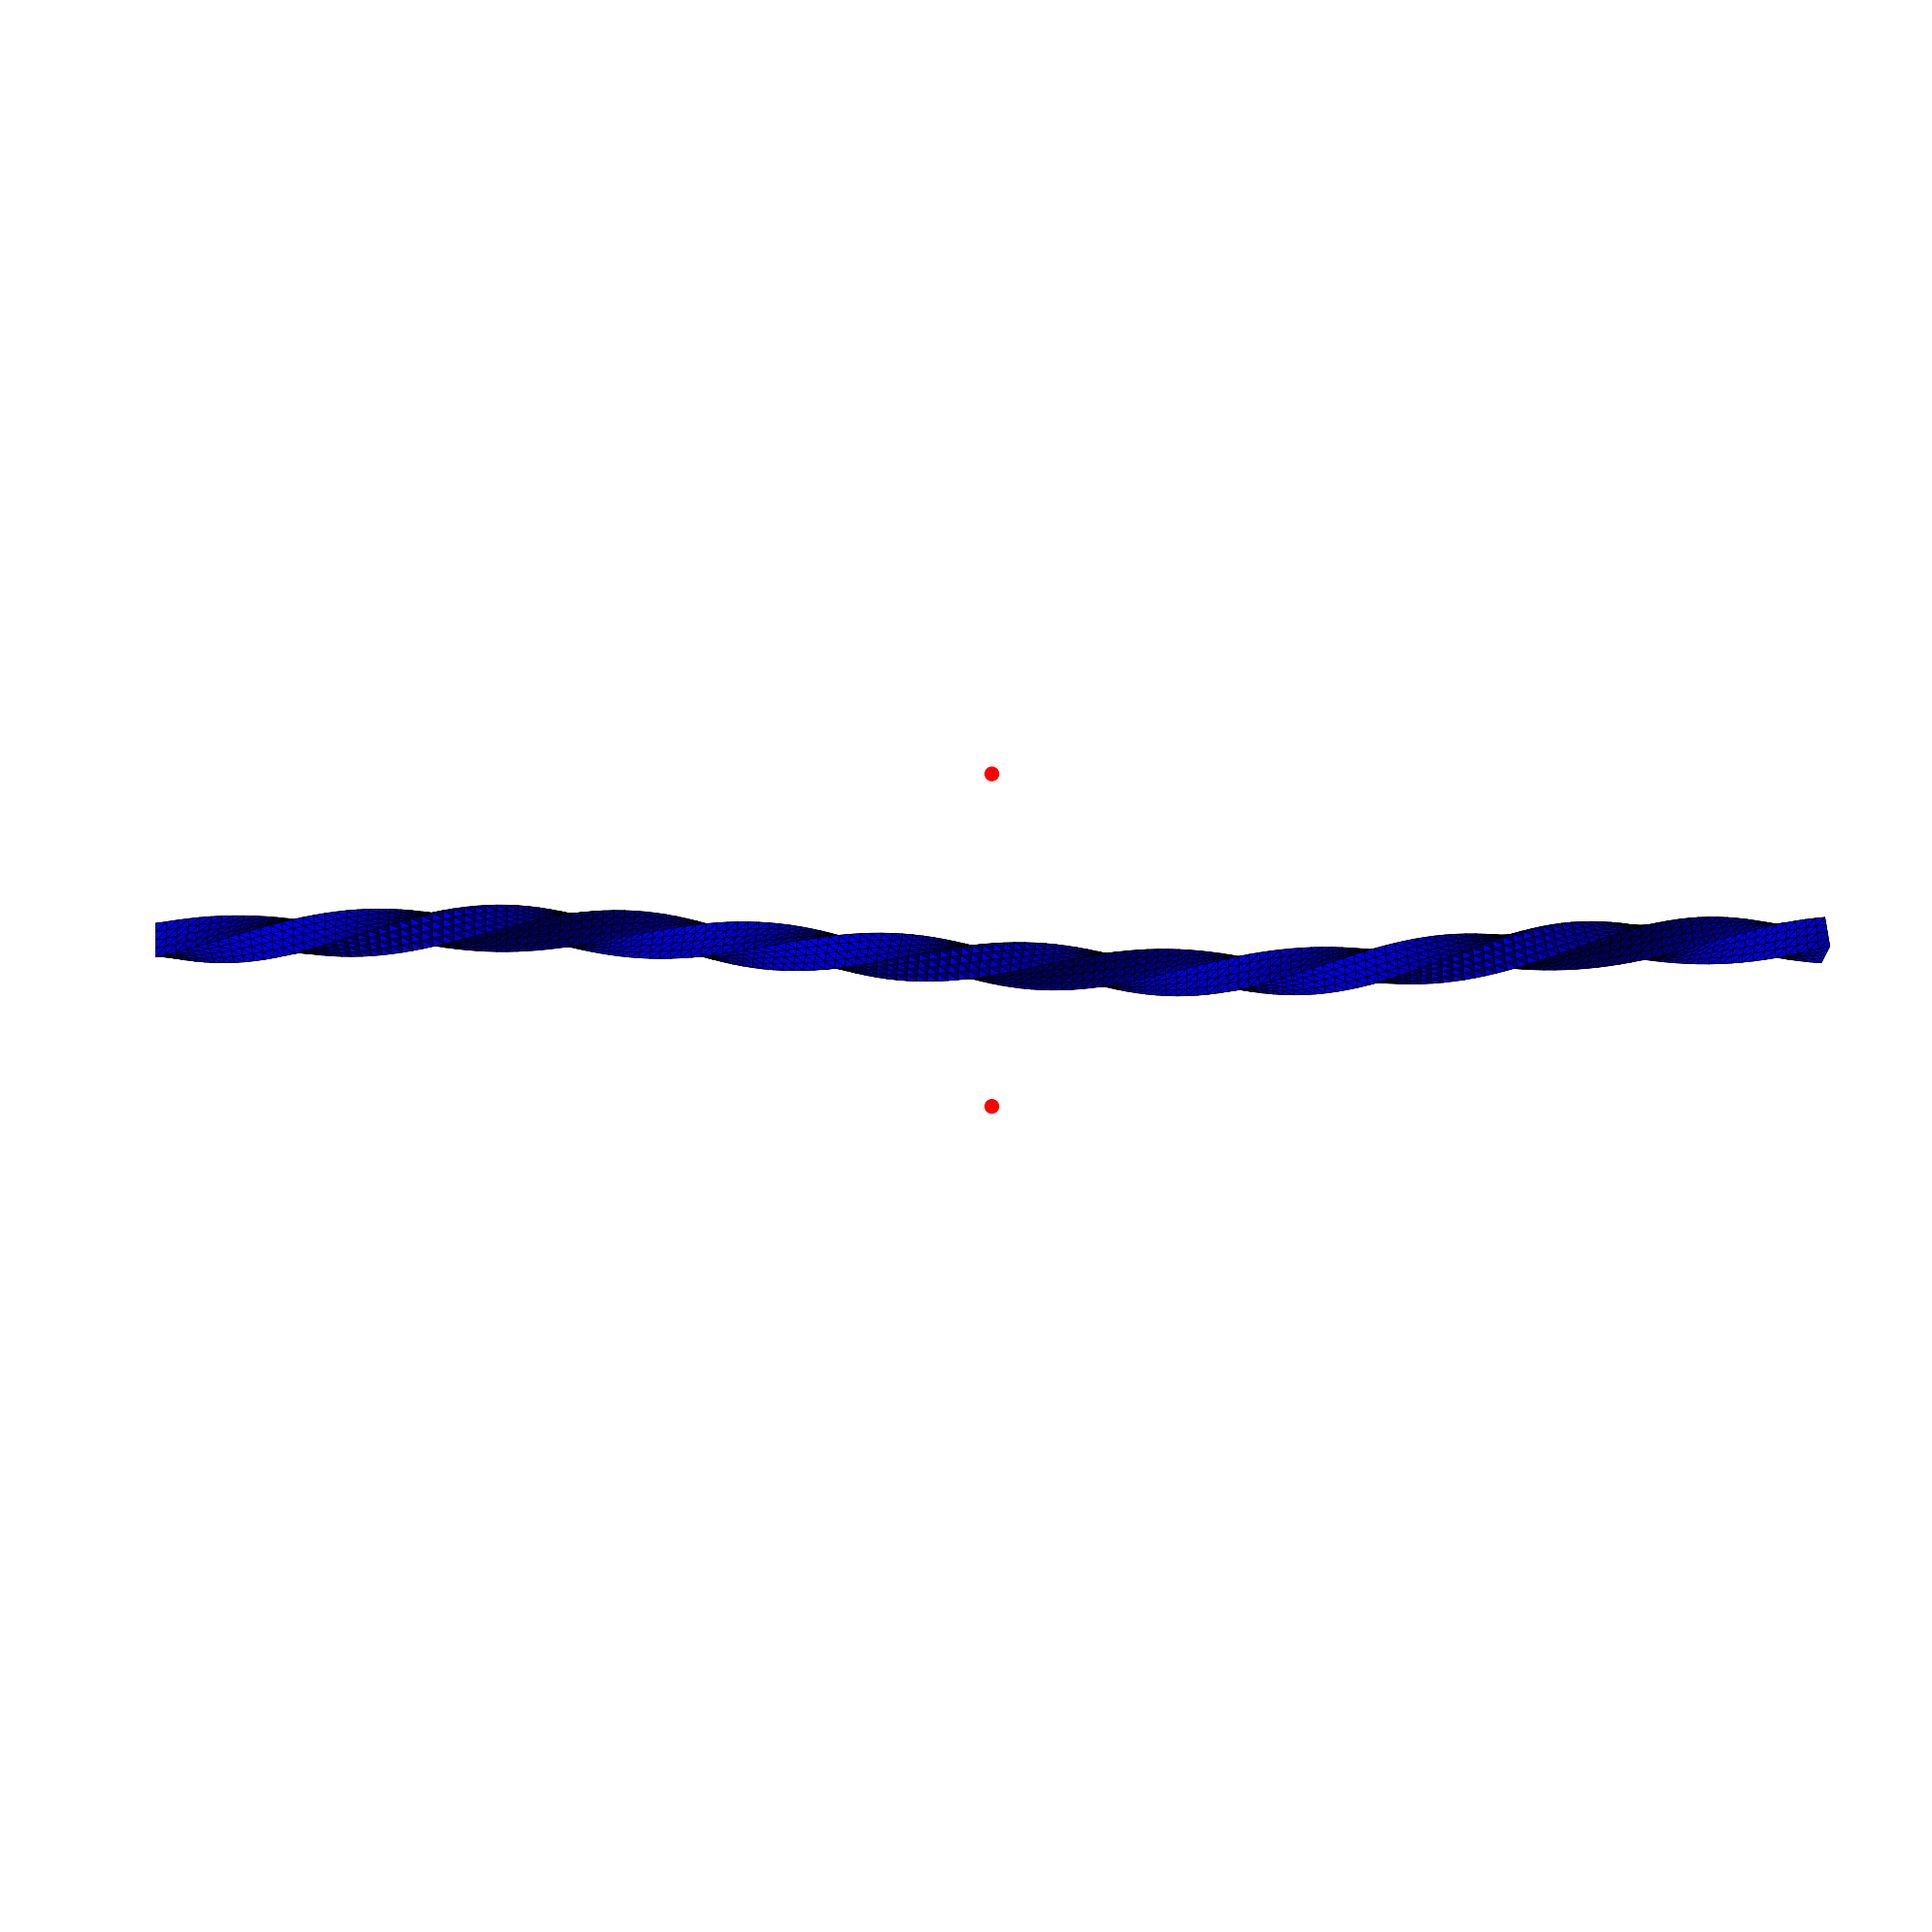

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 73.01380208666706
        x: [ 2.563e-03 -4.374e-03 ... -1.014e-03  6.937e-03]
      nit: 1817
      jac: [ 5.183e-03 -6.874e-03 ... -4.110e-03 -4.538e-03]
     nfev: 1883
     njev: 1883
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


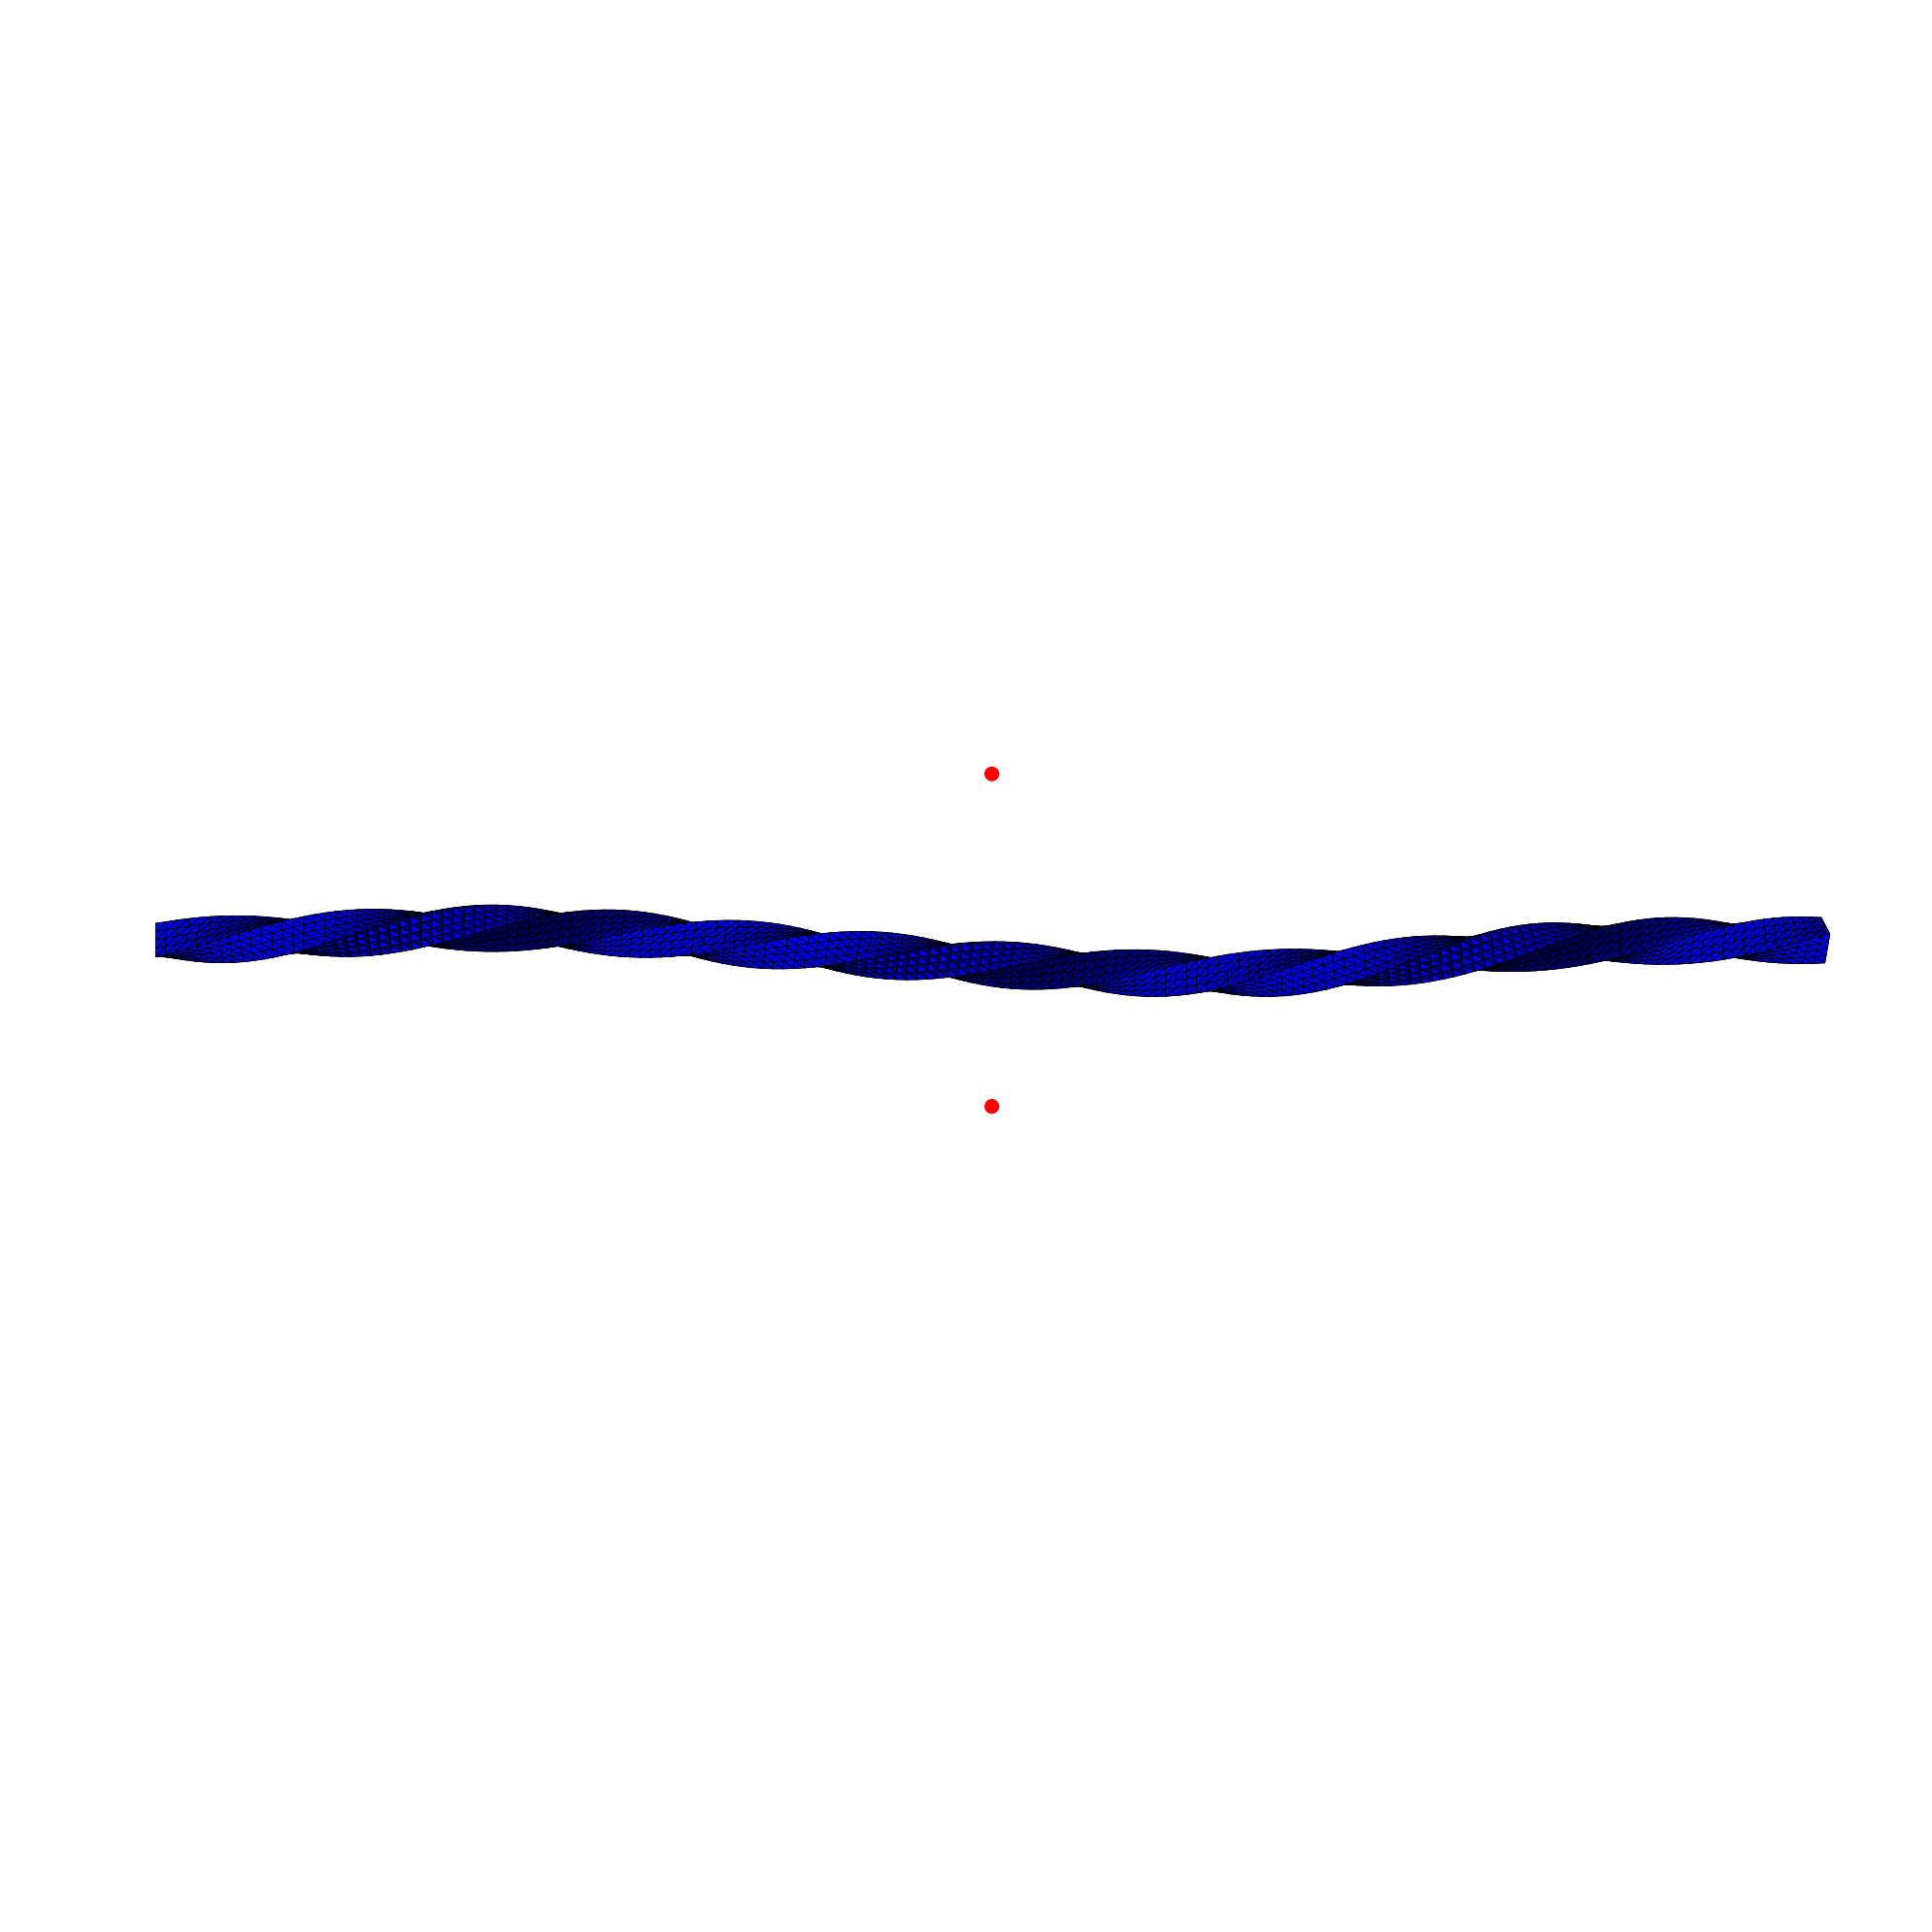

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 76.8993168977856
        x: [ 2.569e-03 -4.355e-03 ... -4.326e-03  5.511e-03]
      nit: 3109
      jac: [-5.406e-03 -3.756e-04 ... -4.137e-03  1.373e-02]
     nfev: 3201
     njev: 3201
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


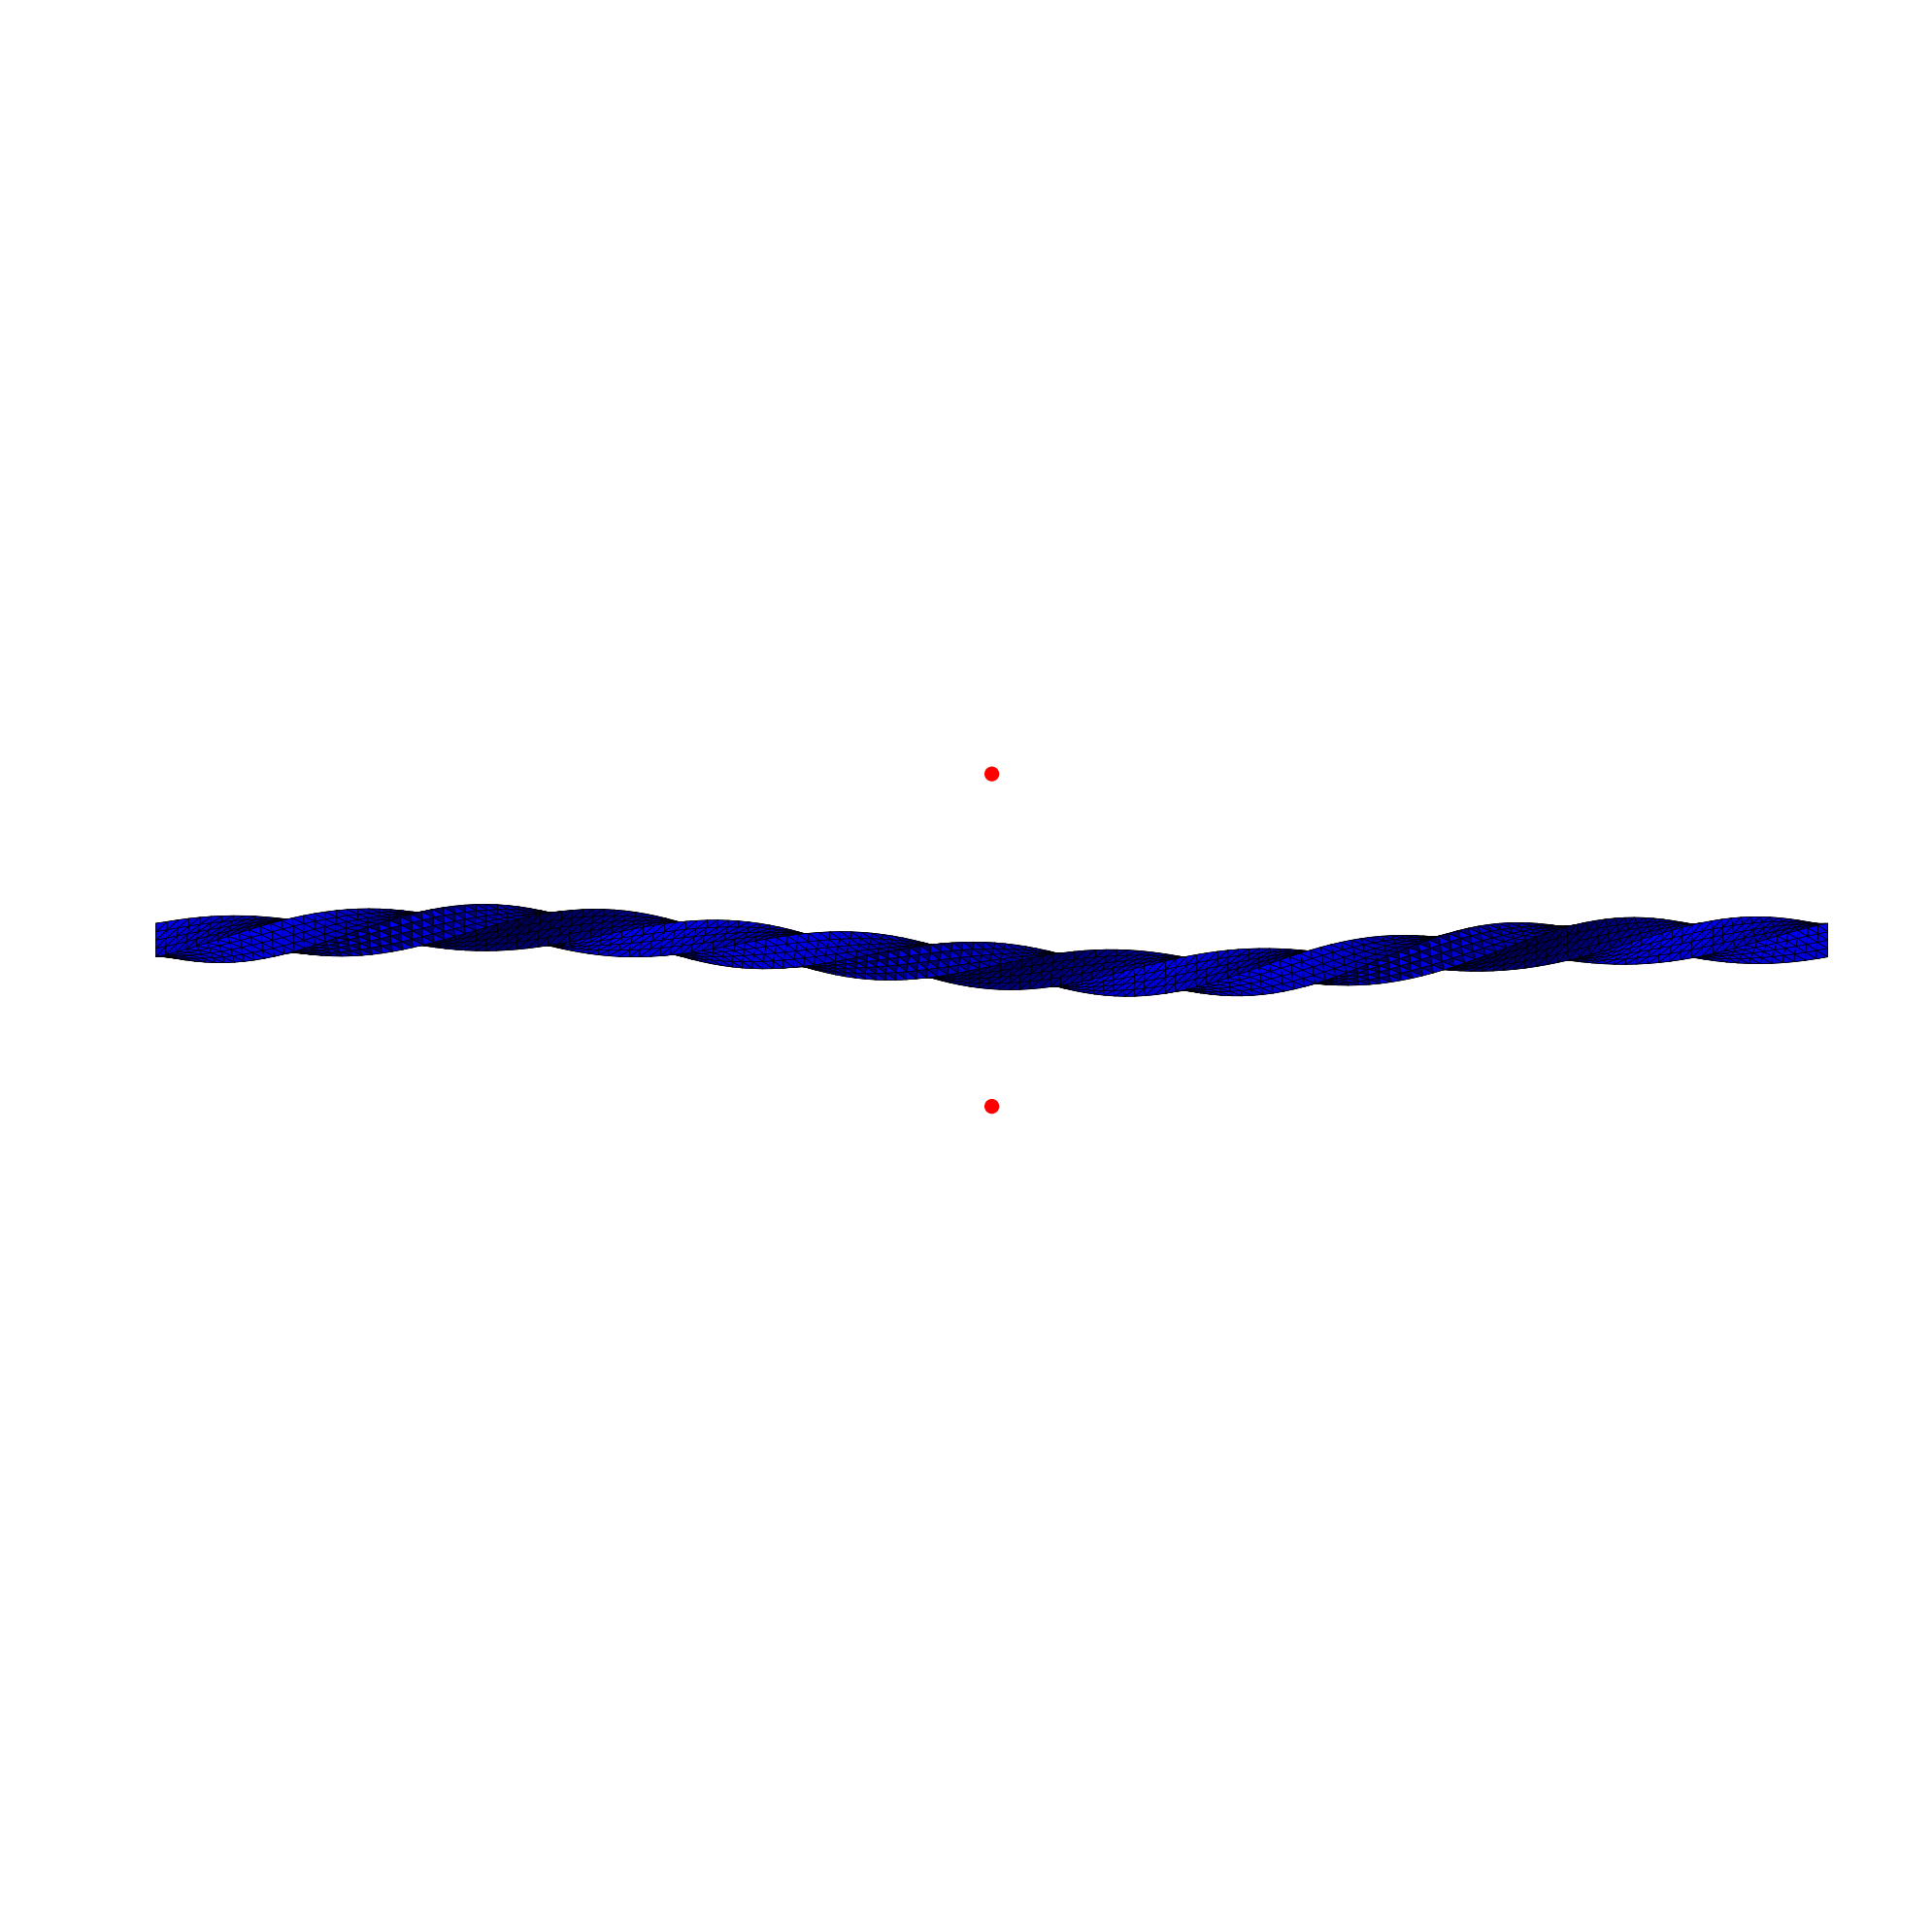

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 80.88585745950488
        x: [ 2.571e-03 -4.337e-03 ... -6.489e-03  2.628e-03]
      nit: 1639
      jac: [-1.071e-03 -6.858e-03 ... -2.427e-03 -1.277e-02]
     nfev: 1694
     njev: 1694
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


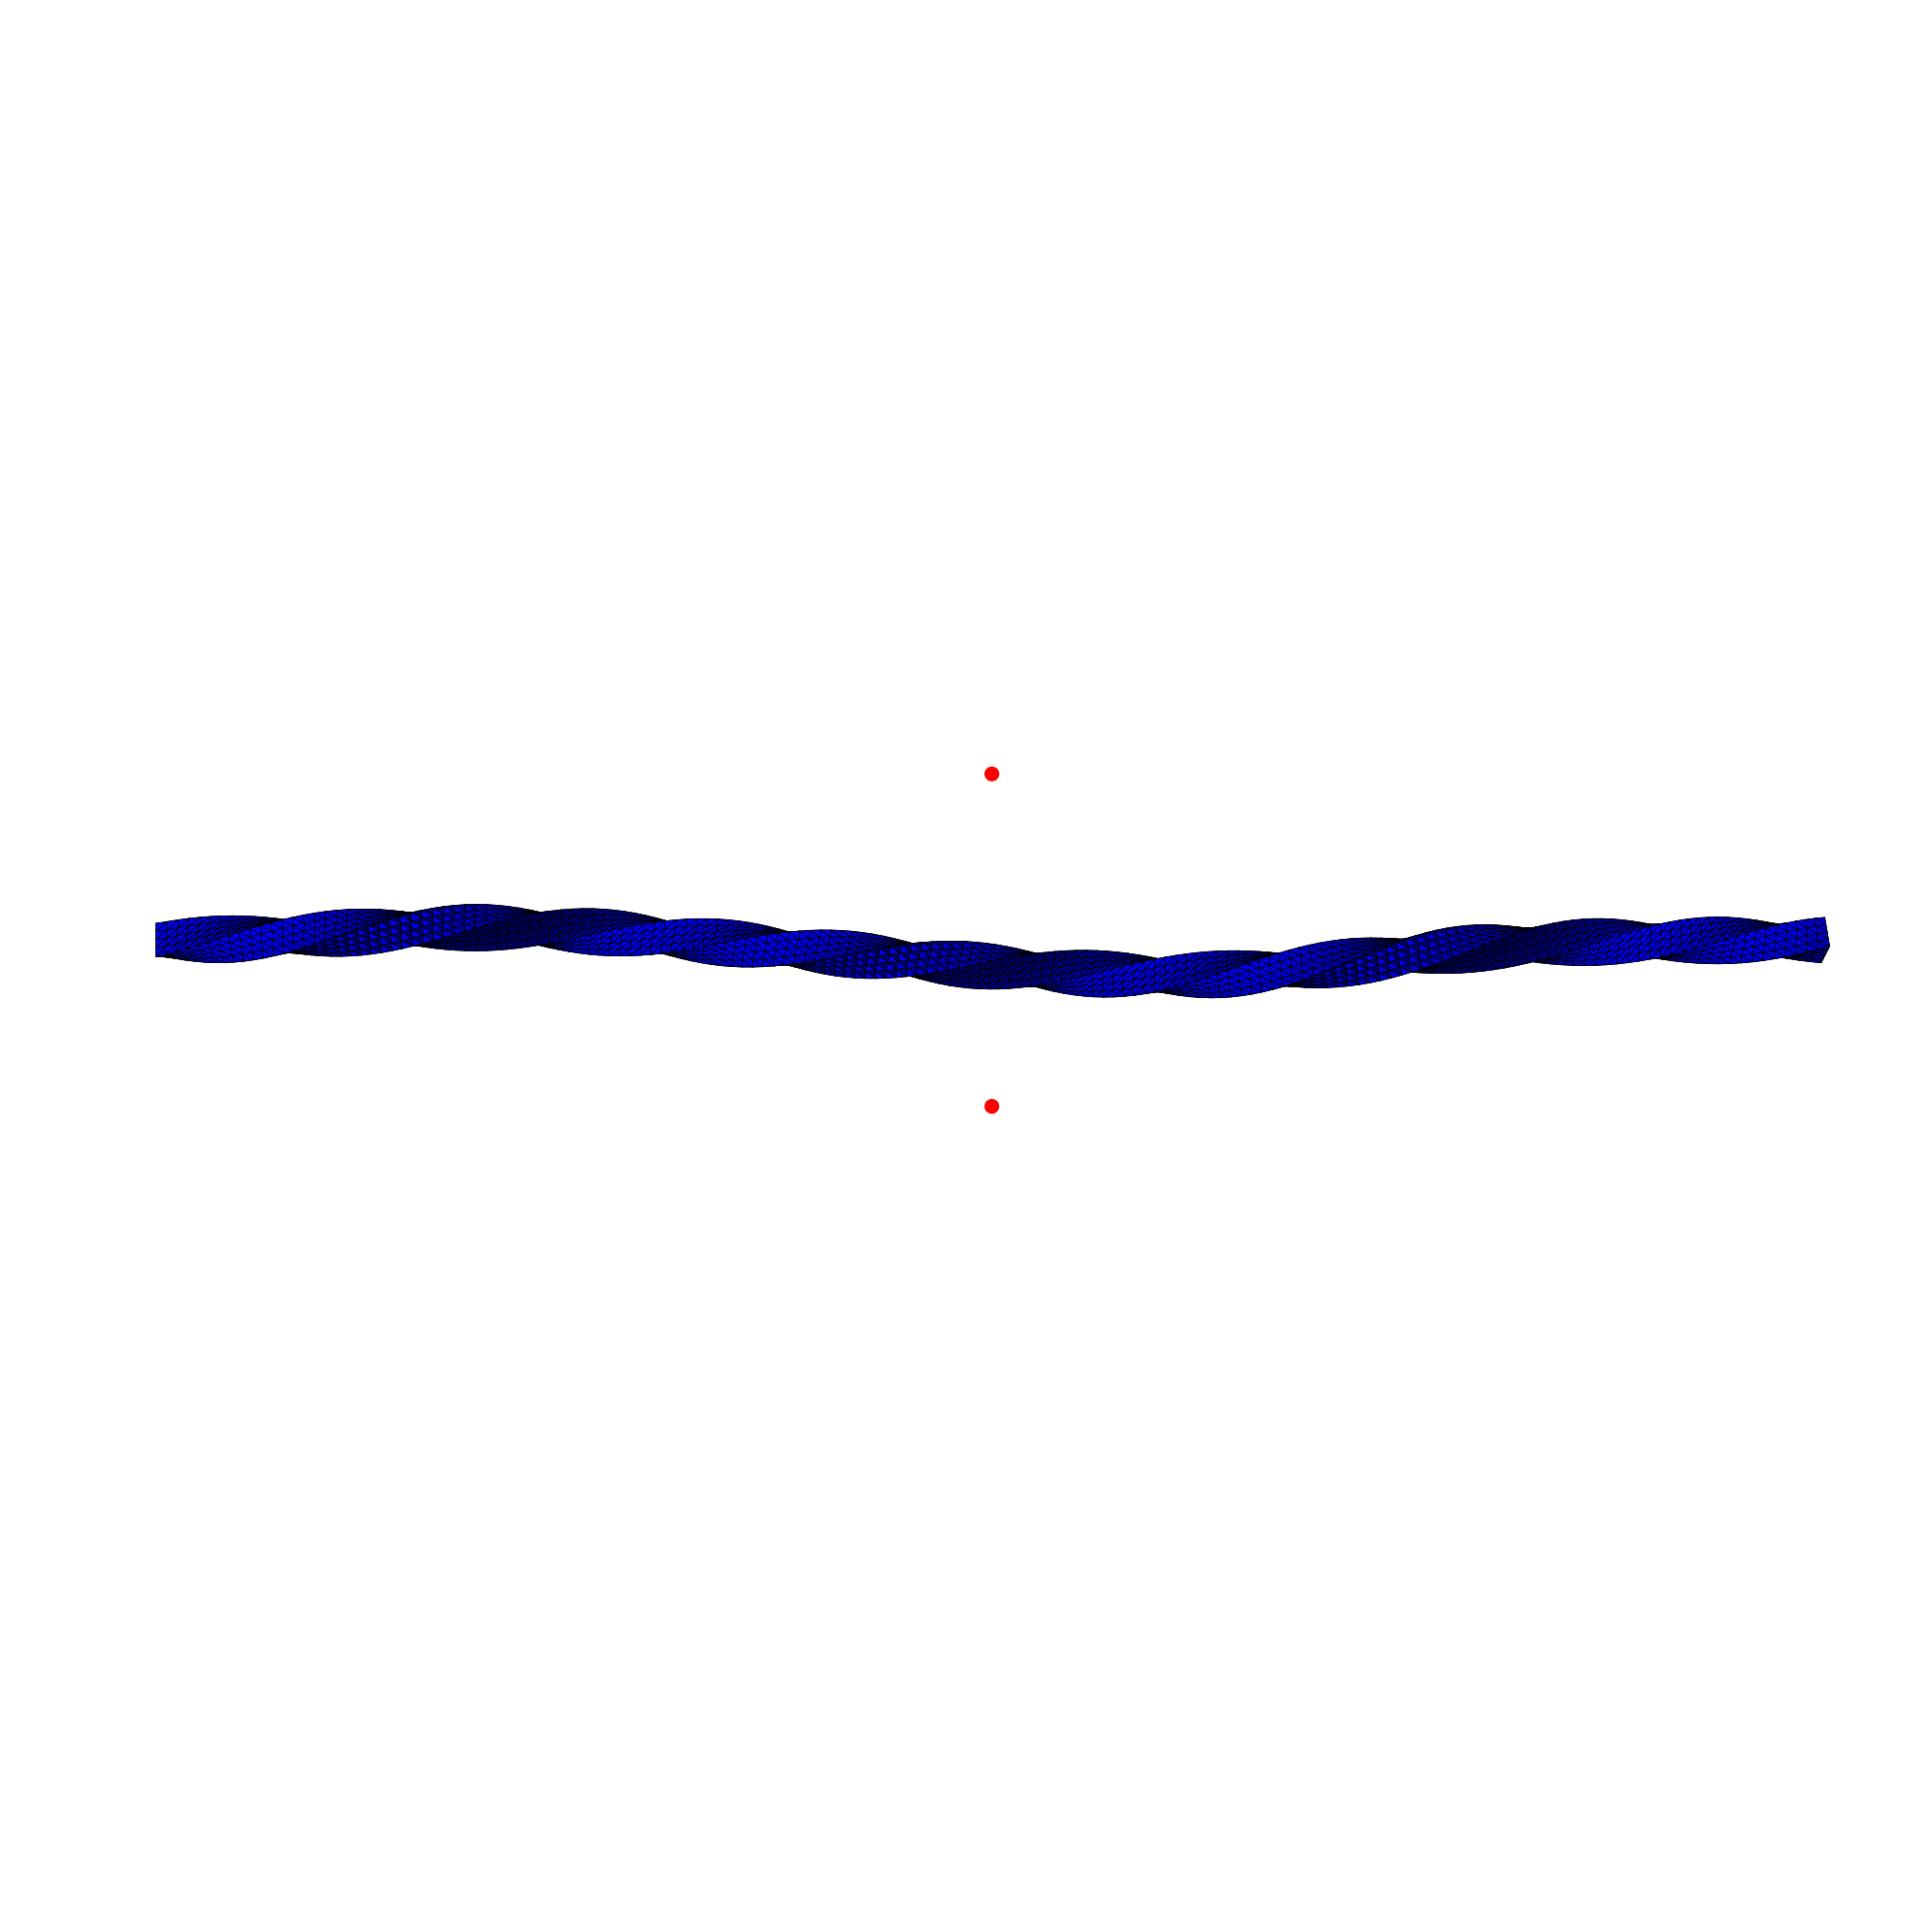

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 84.9723429036811
        x: [ 2.574e-03 -4.319e-03 ... -6.934e-03 -9.466e-04]
      nit: 1558
      jac: [ 2.191e-03  1.471e-02 ... -6.727e-03  2.451e-03]
     nfev: 1616
     njev: 1616
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


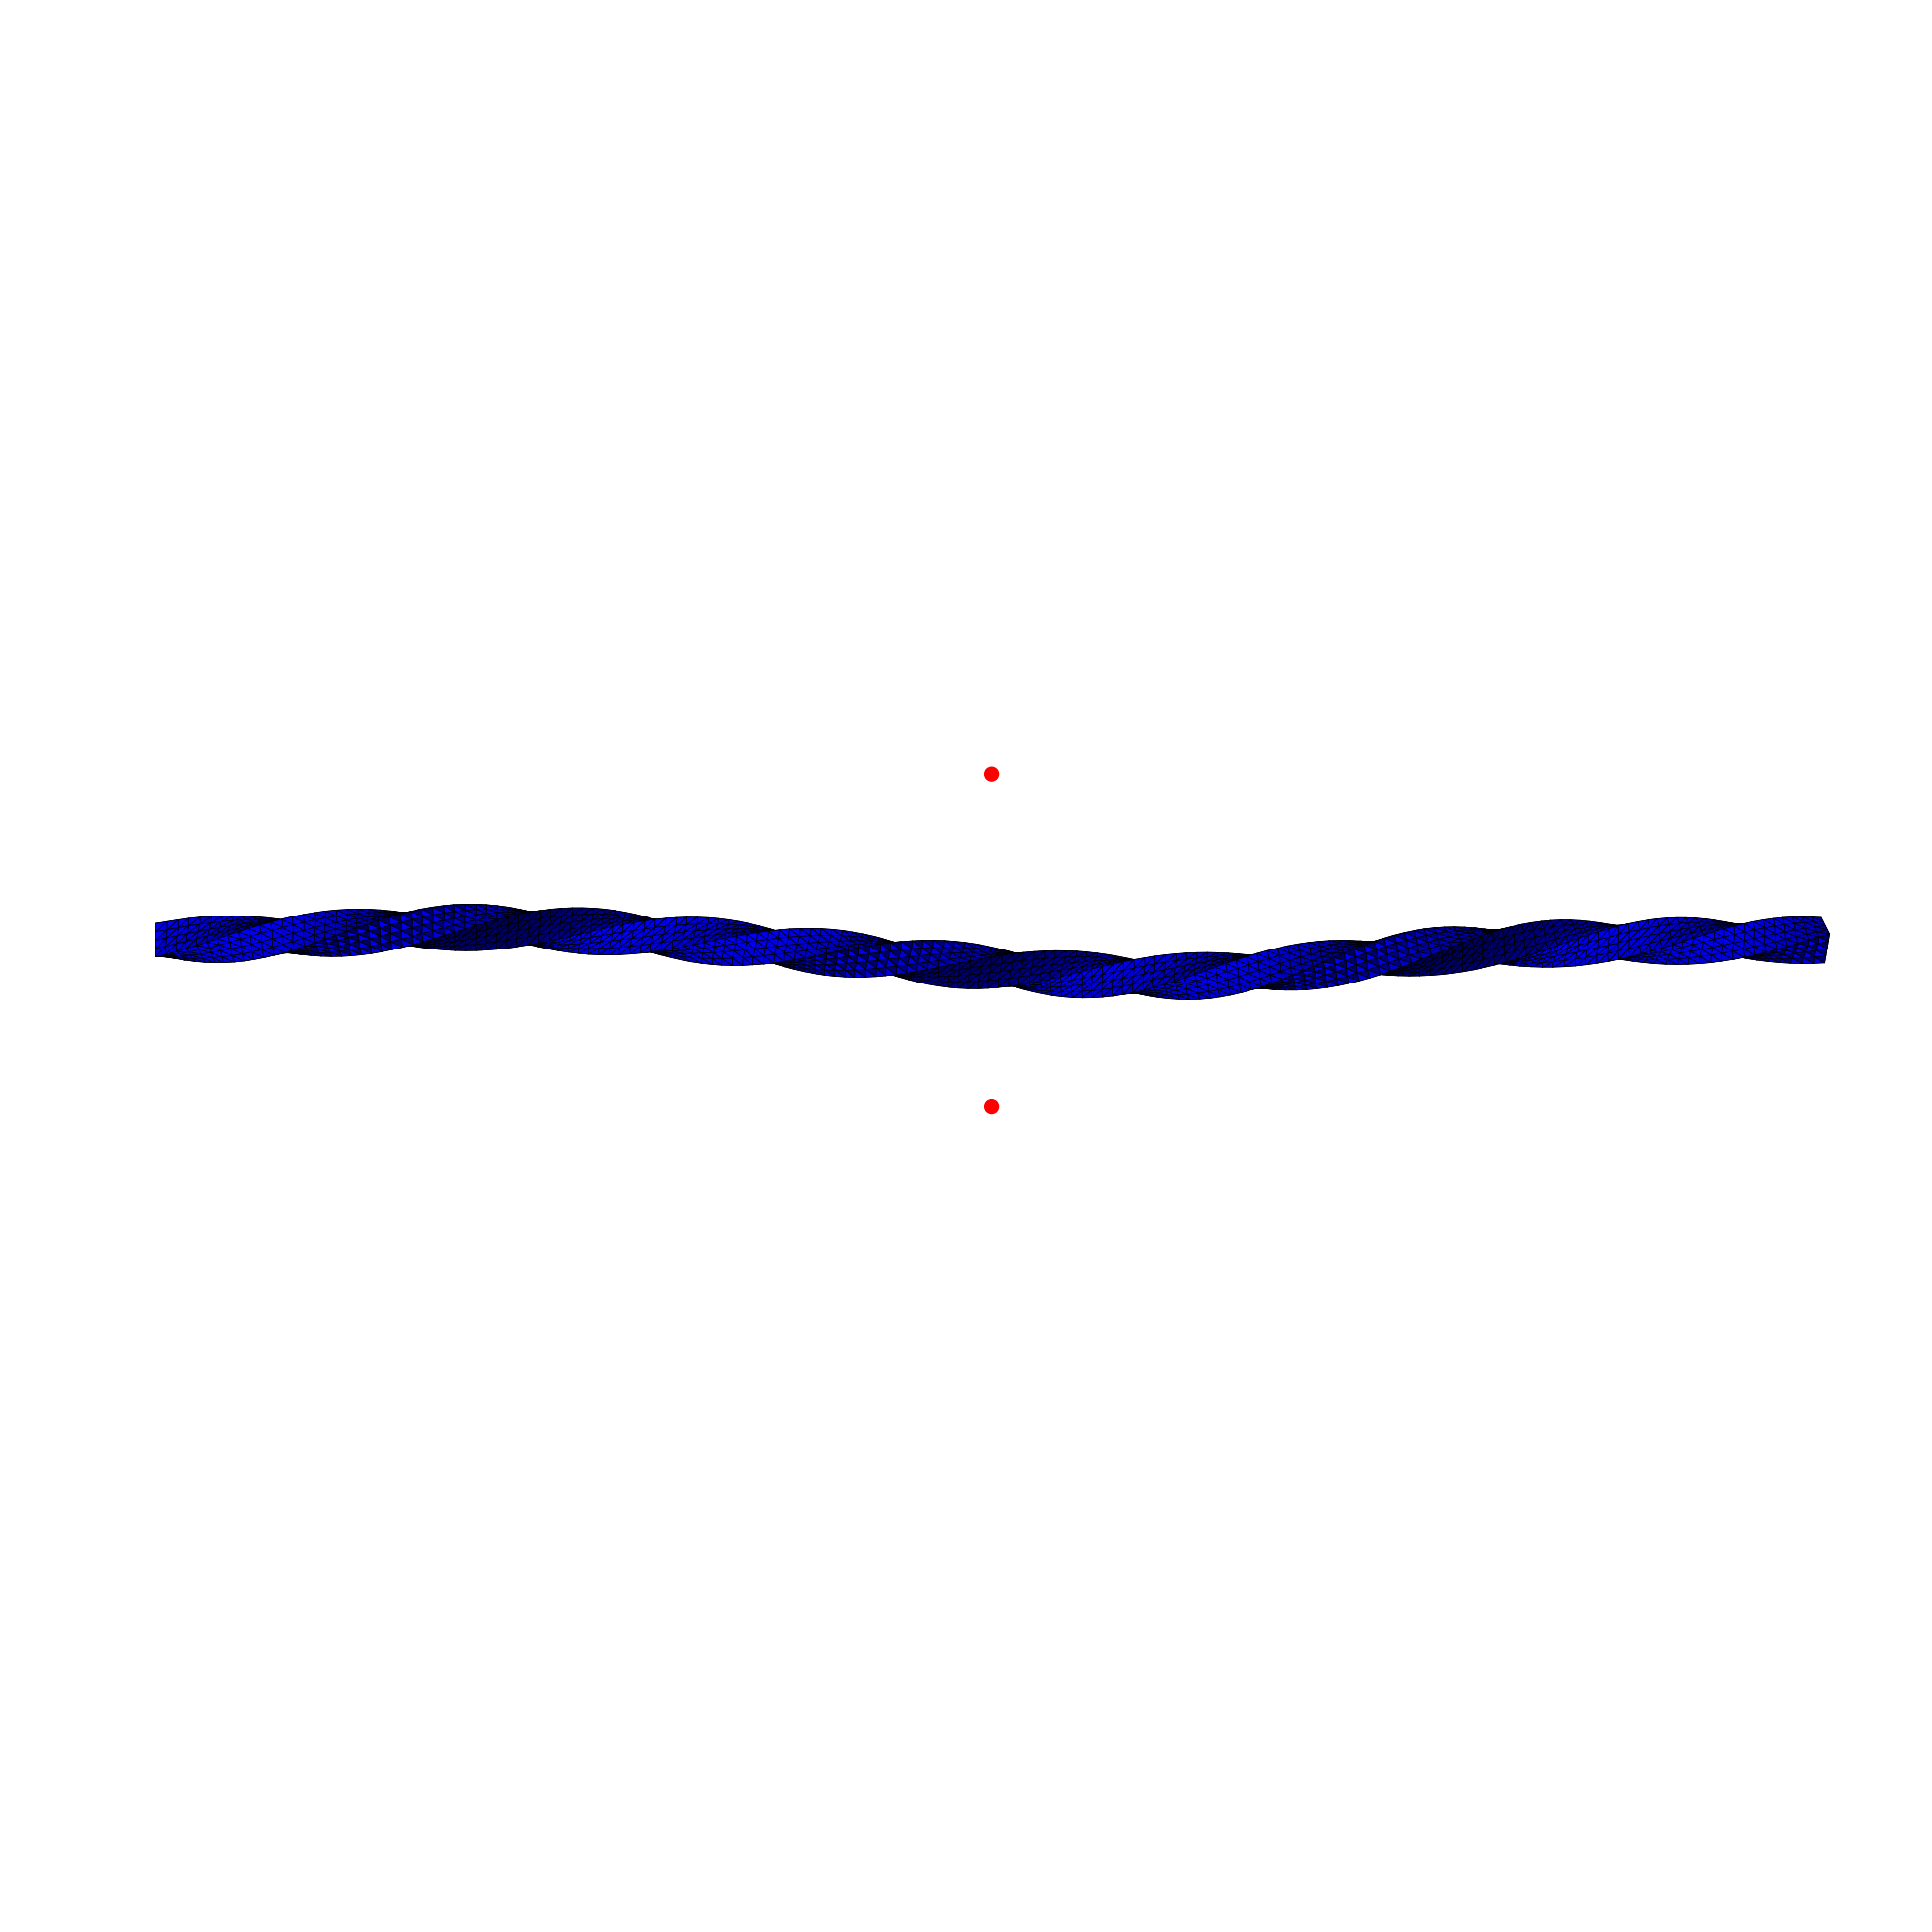

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 89.1580029555353
        x: [ 2.578e-03 -4.301e-03 ... -5.546e-03 -4.270e-03]
      nit: 1629
      jac: [-9.571e-03  7.942e-05 ...  1.104e-02 -1.449e-02]
     nfev: 1688
     njev: 1688
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


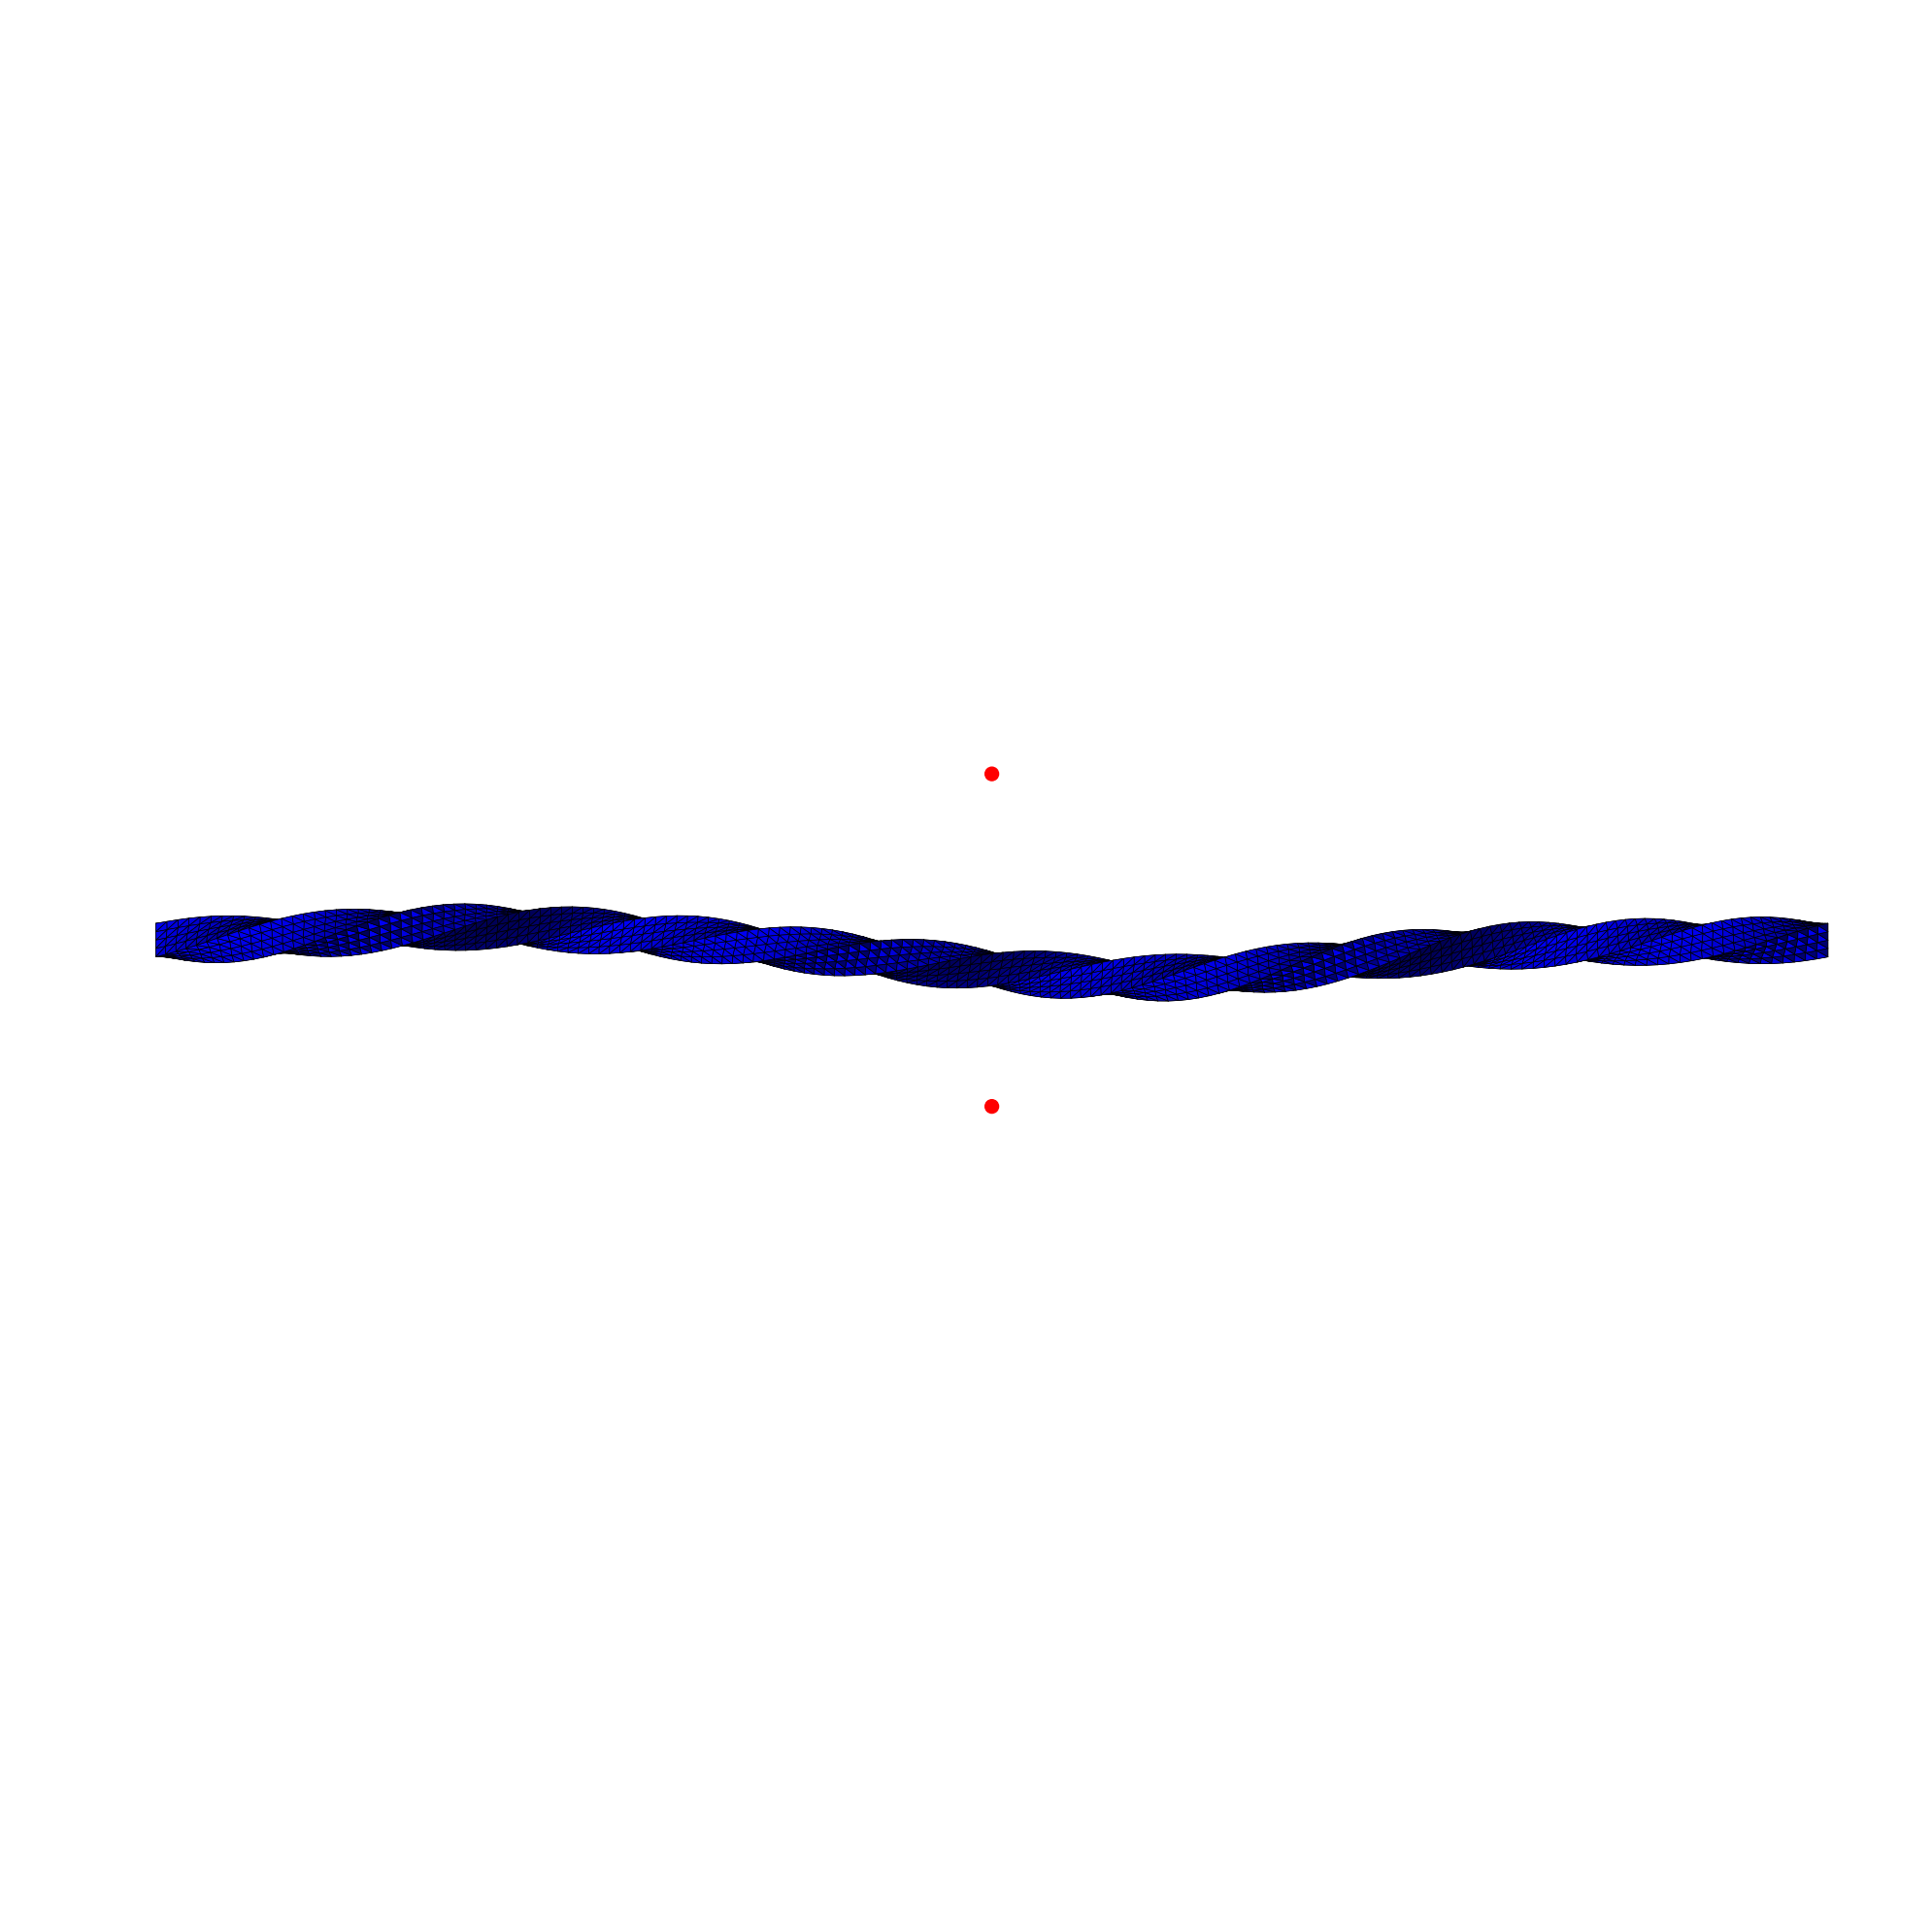

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 93.44190399581808
        x: [ 2.585e-03 -4.282e-03 ... -2.689e-03 -6.463e-03]
      nit: 2157
      jac: [ 1.569e-02  1.722e-02 ... -7.996e-03 -1.234e-02]
     nfev: 2227
     njev: 2227
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


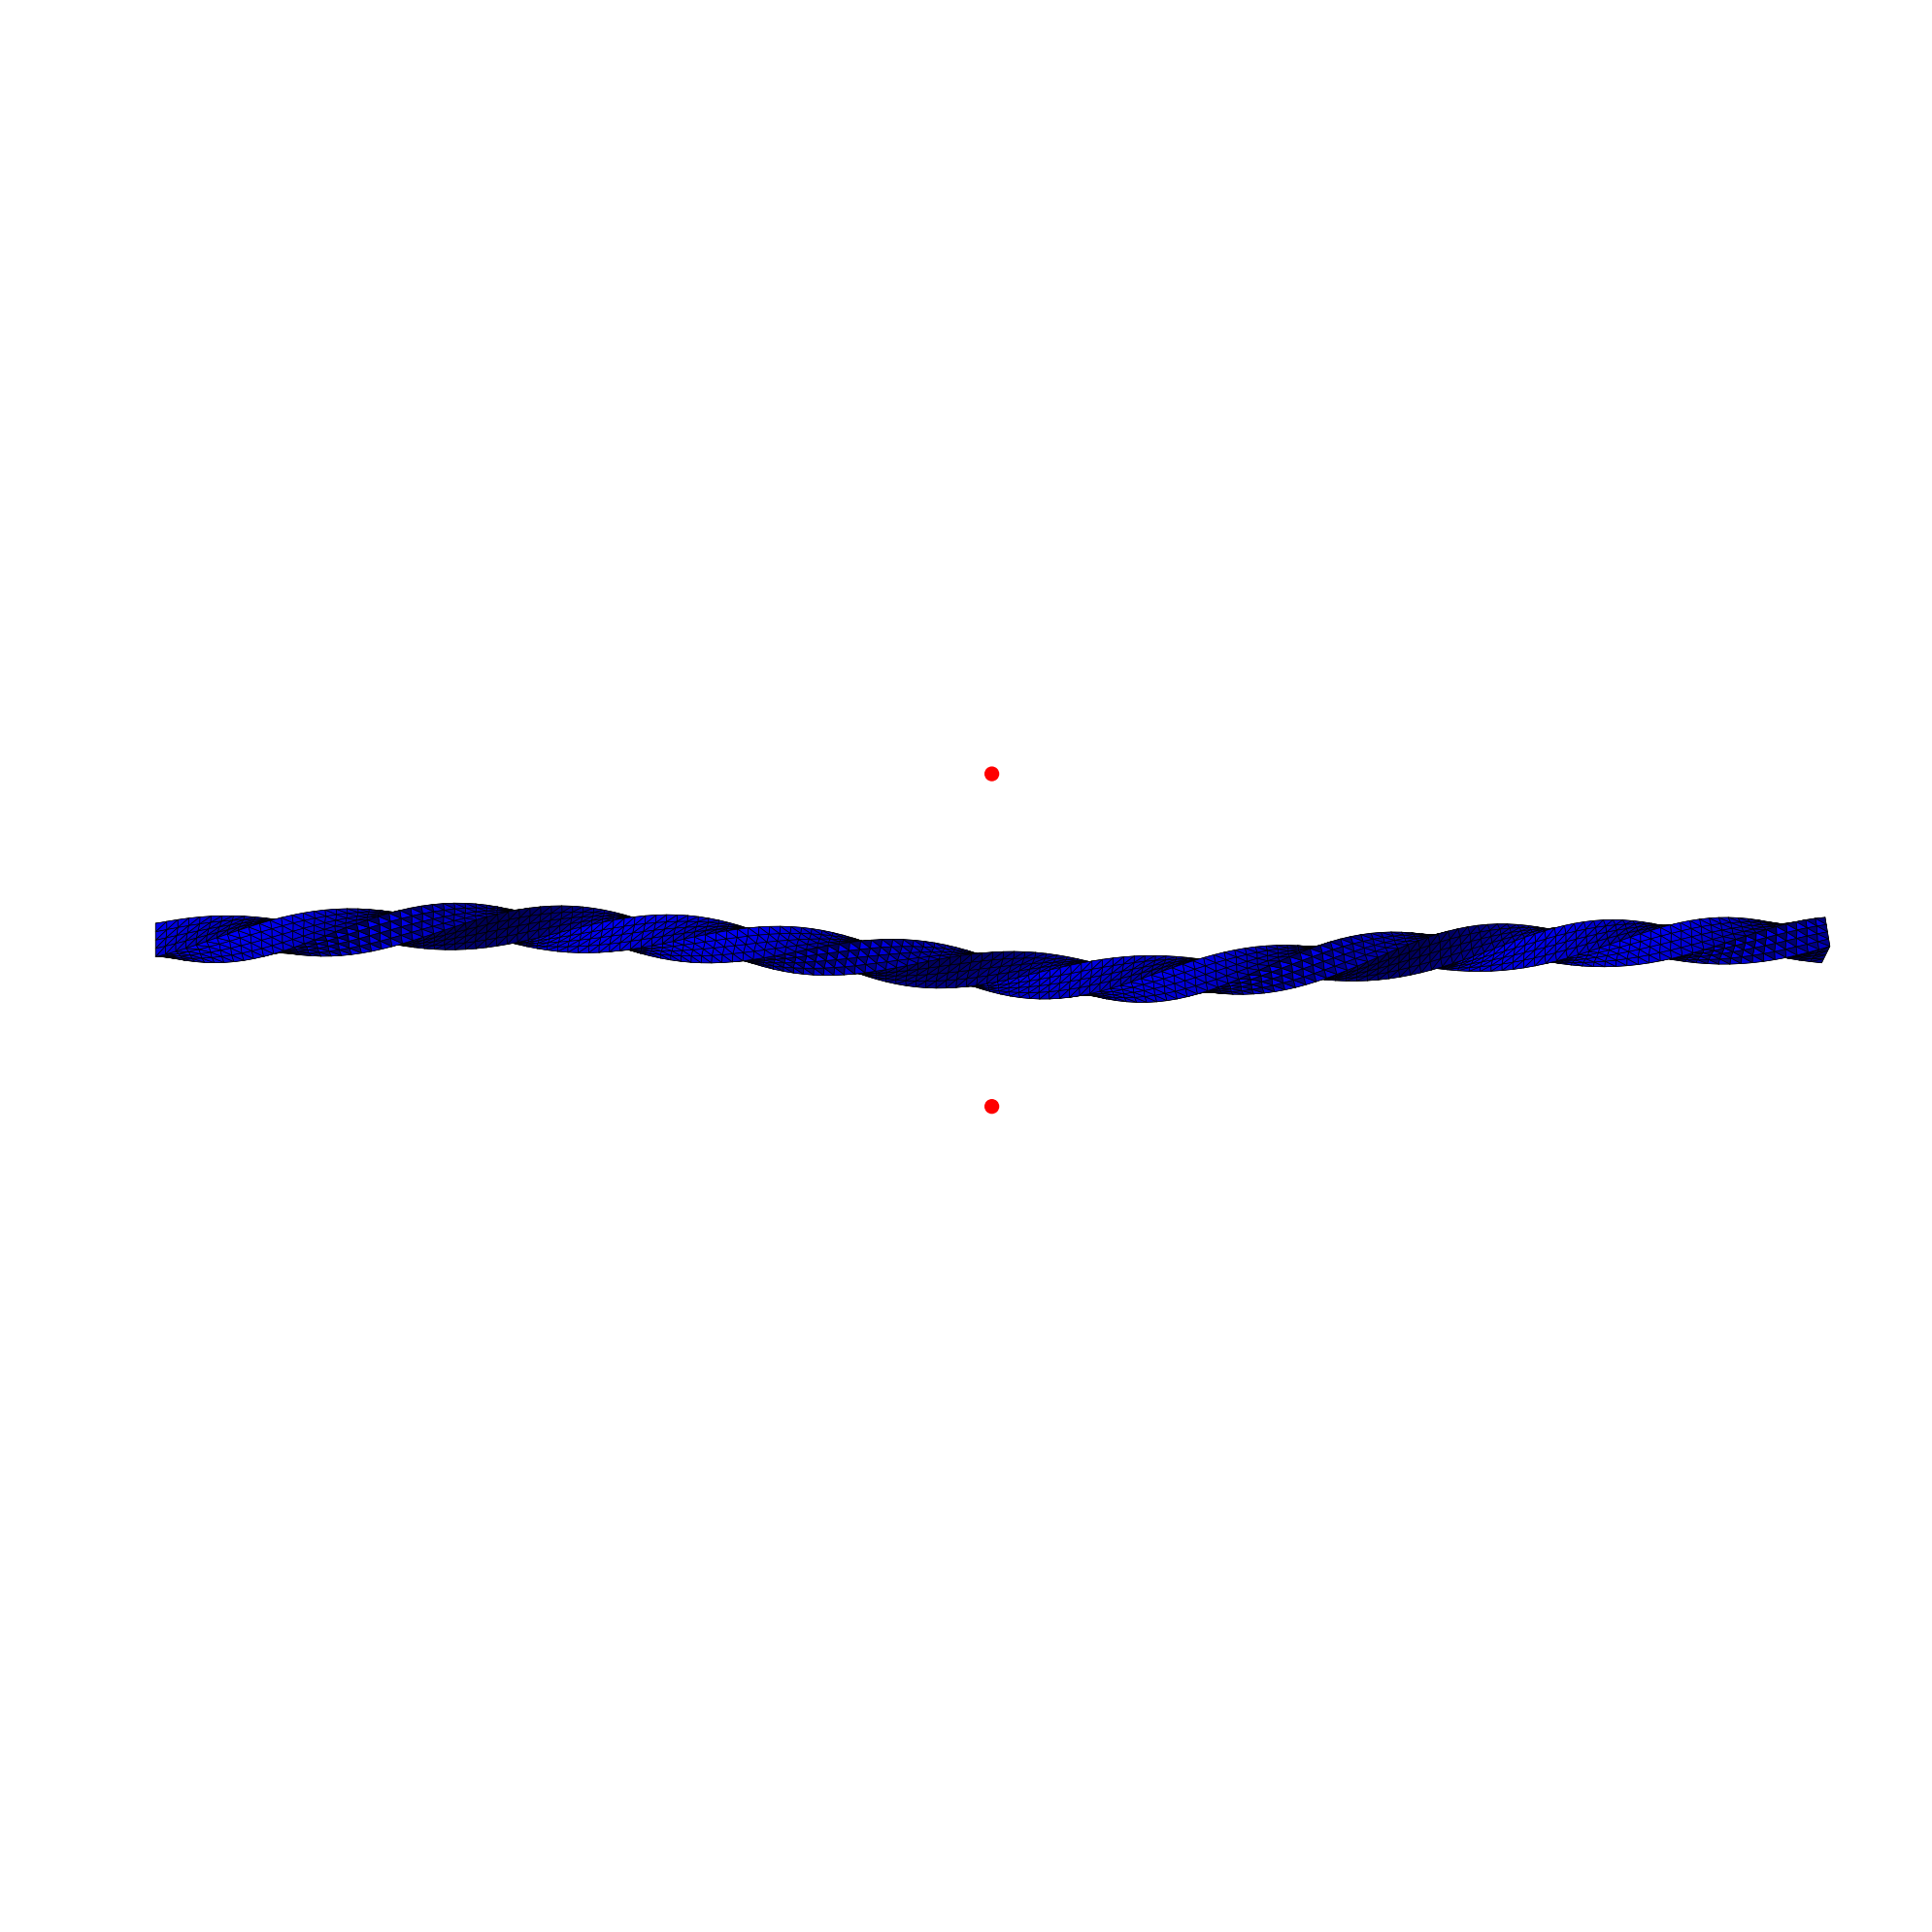

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 97.82420367107704
        x: [ 2.587e-03 -4.263e-03 ...  8.830e-04 -6.946e-03]
      nit: 1470
      jac: [ 1.096e-03 -2.360e-03 ...  1.805e-03 -6.874e-03]
     nfev: 1526
     njev: 1526
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


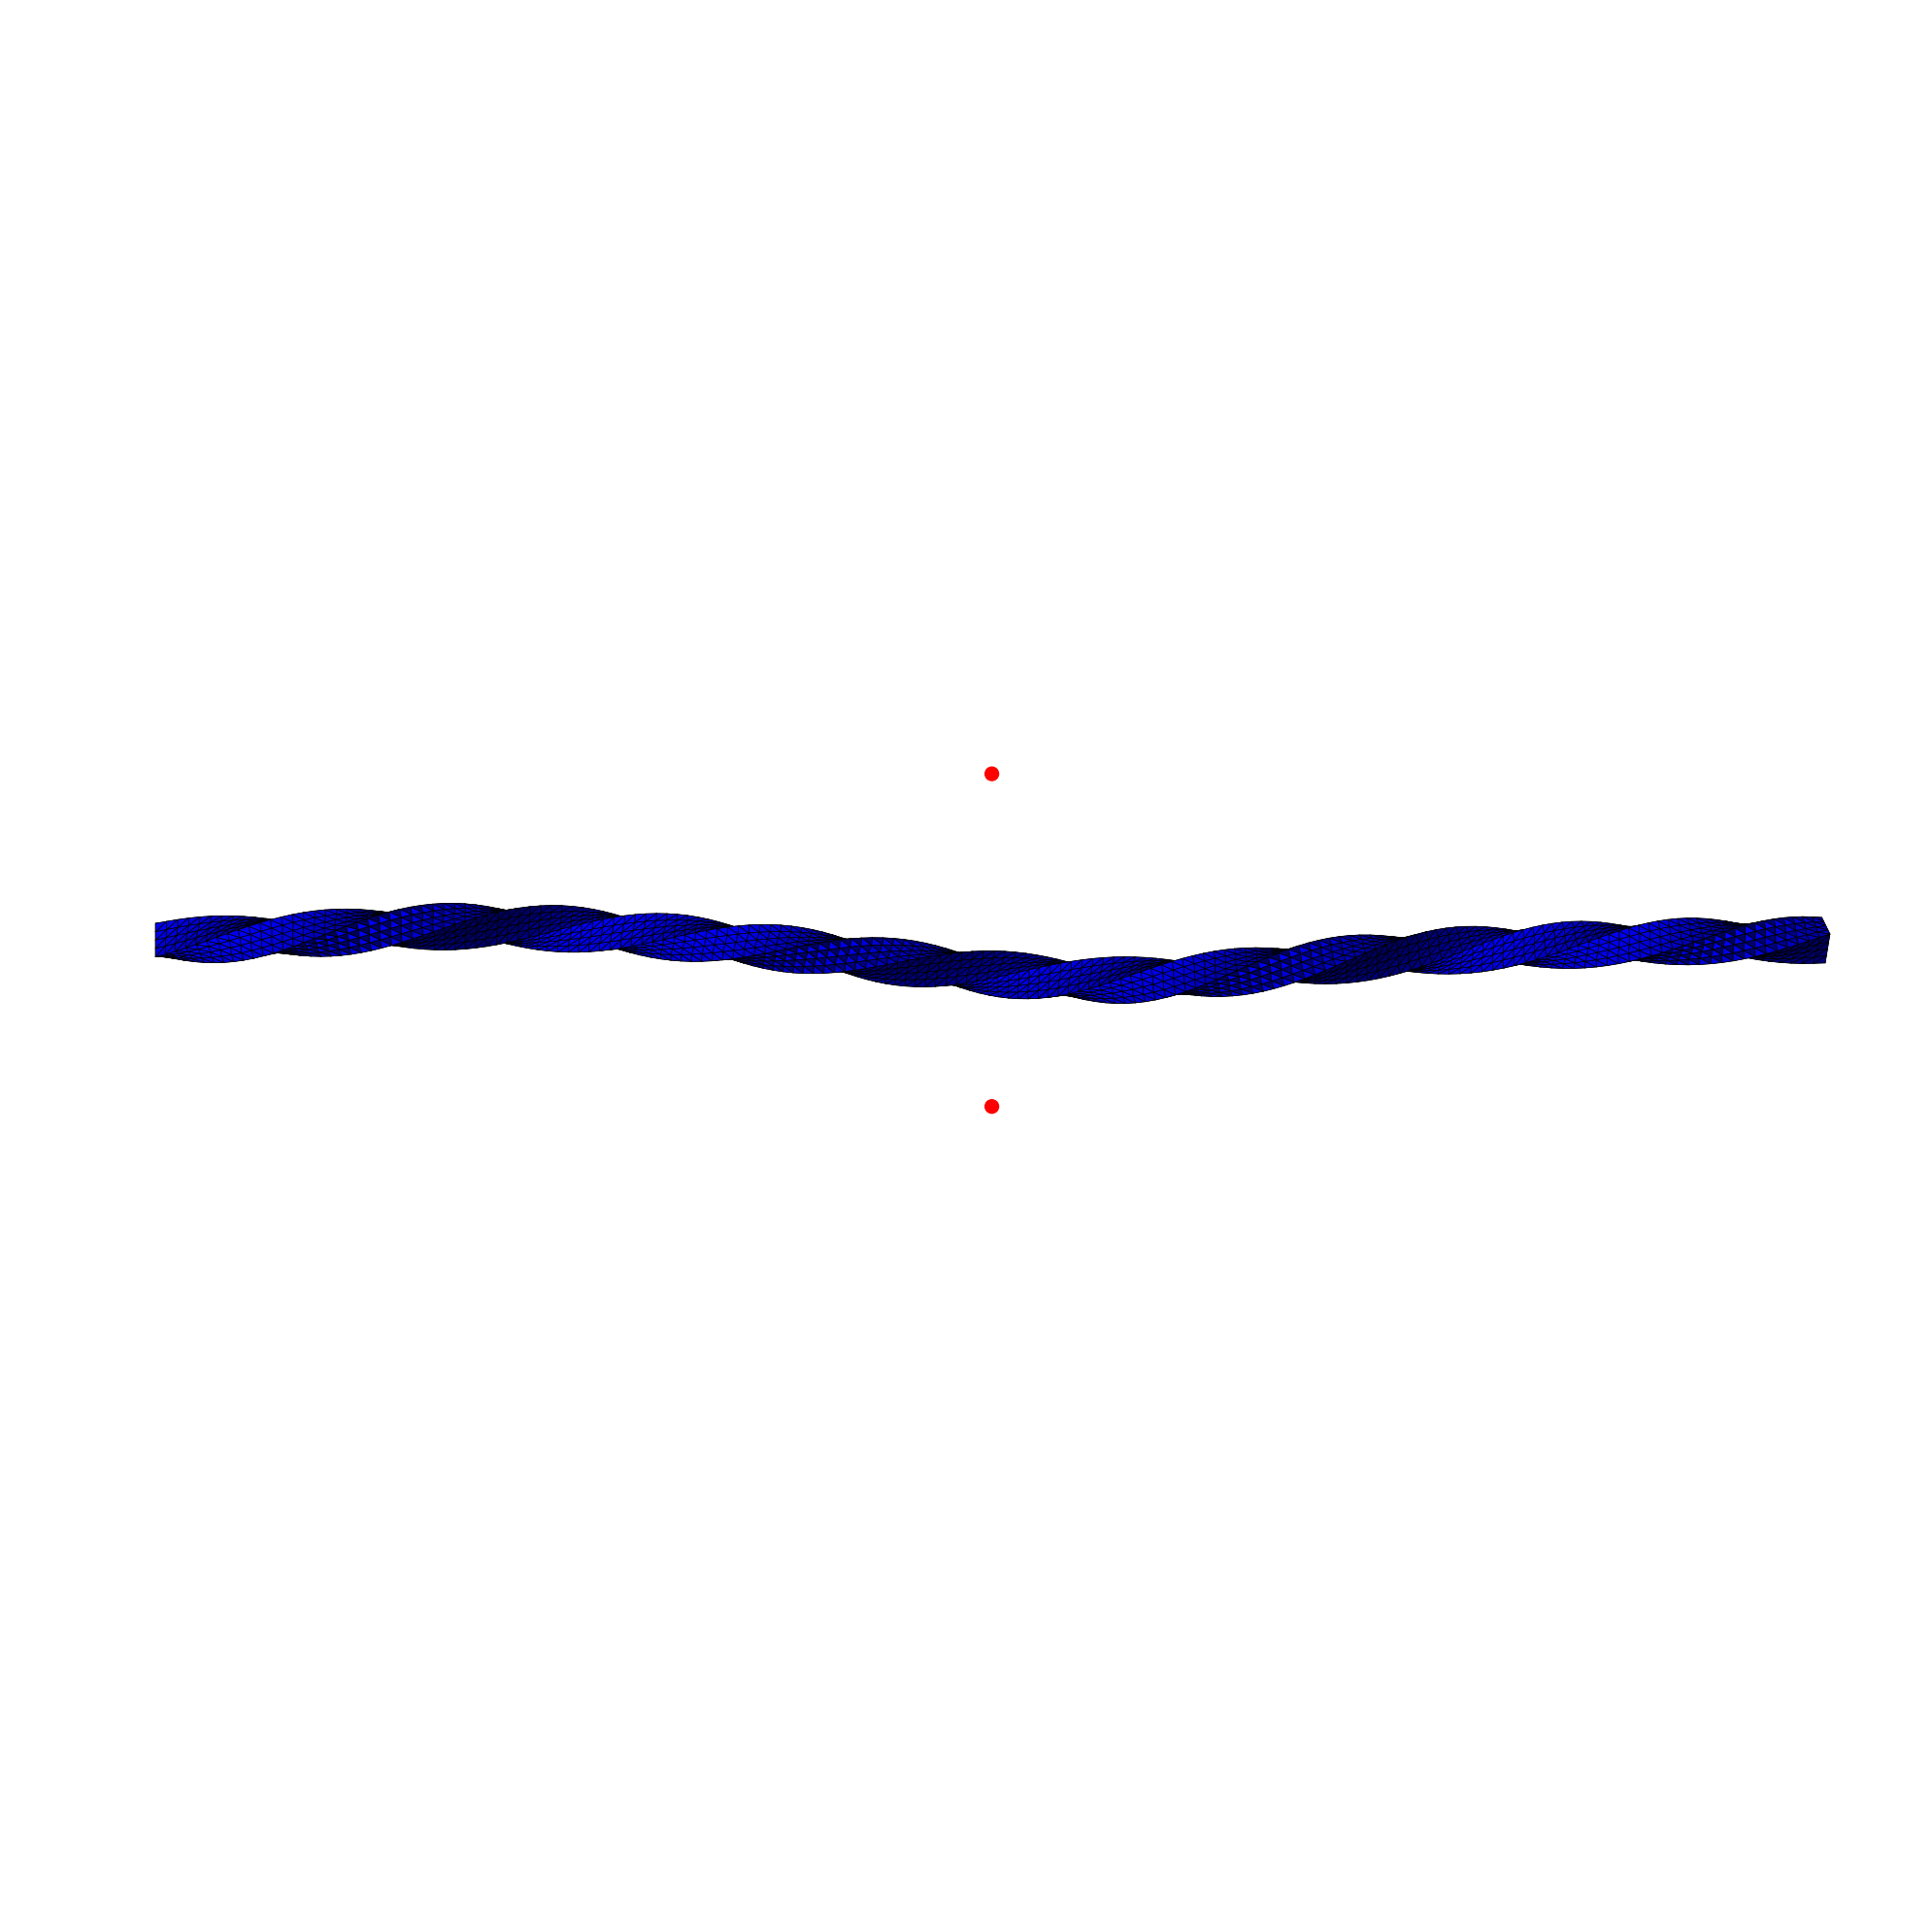

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 102.30335092618483
        x: [ 2.593e-03 -4.245e-03 ...  4.224e-03 -5.590e-03]
      nit: 2397
      jac: [-1.443e-02  7.126e-03 ...  6.735e-03  1.135e-02]
     nfev: 2477
     njev: 2477
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


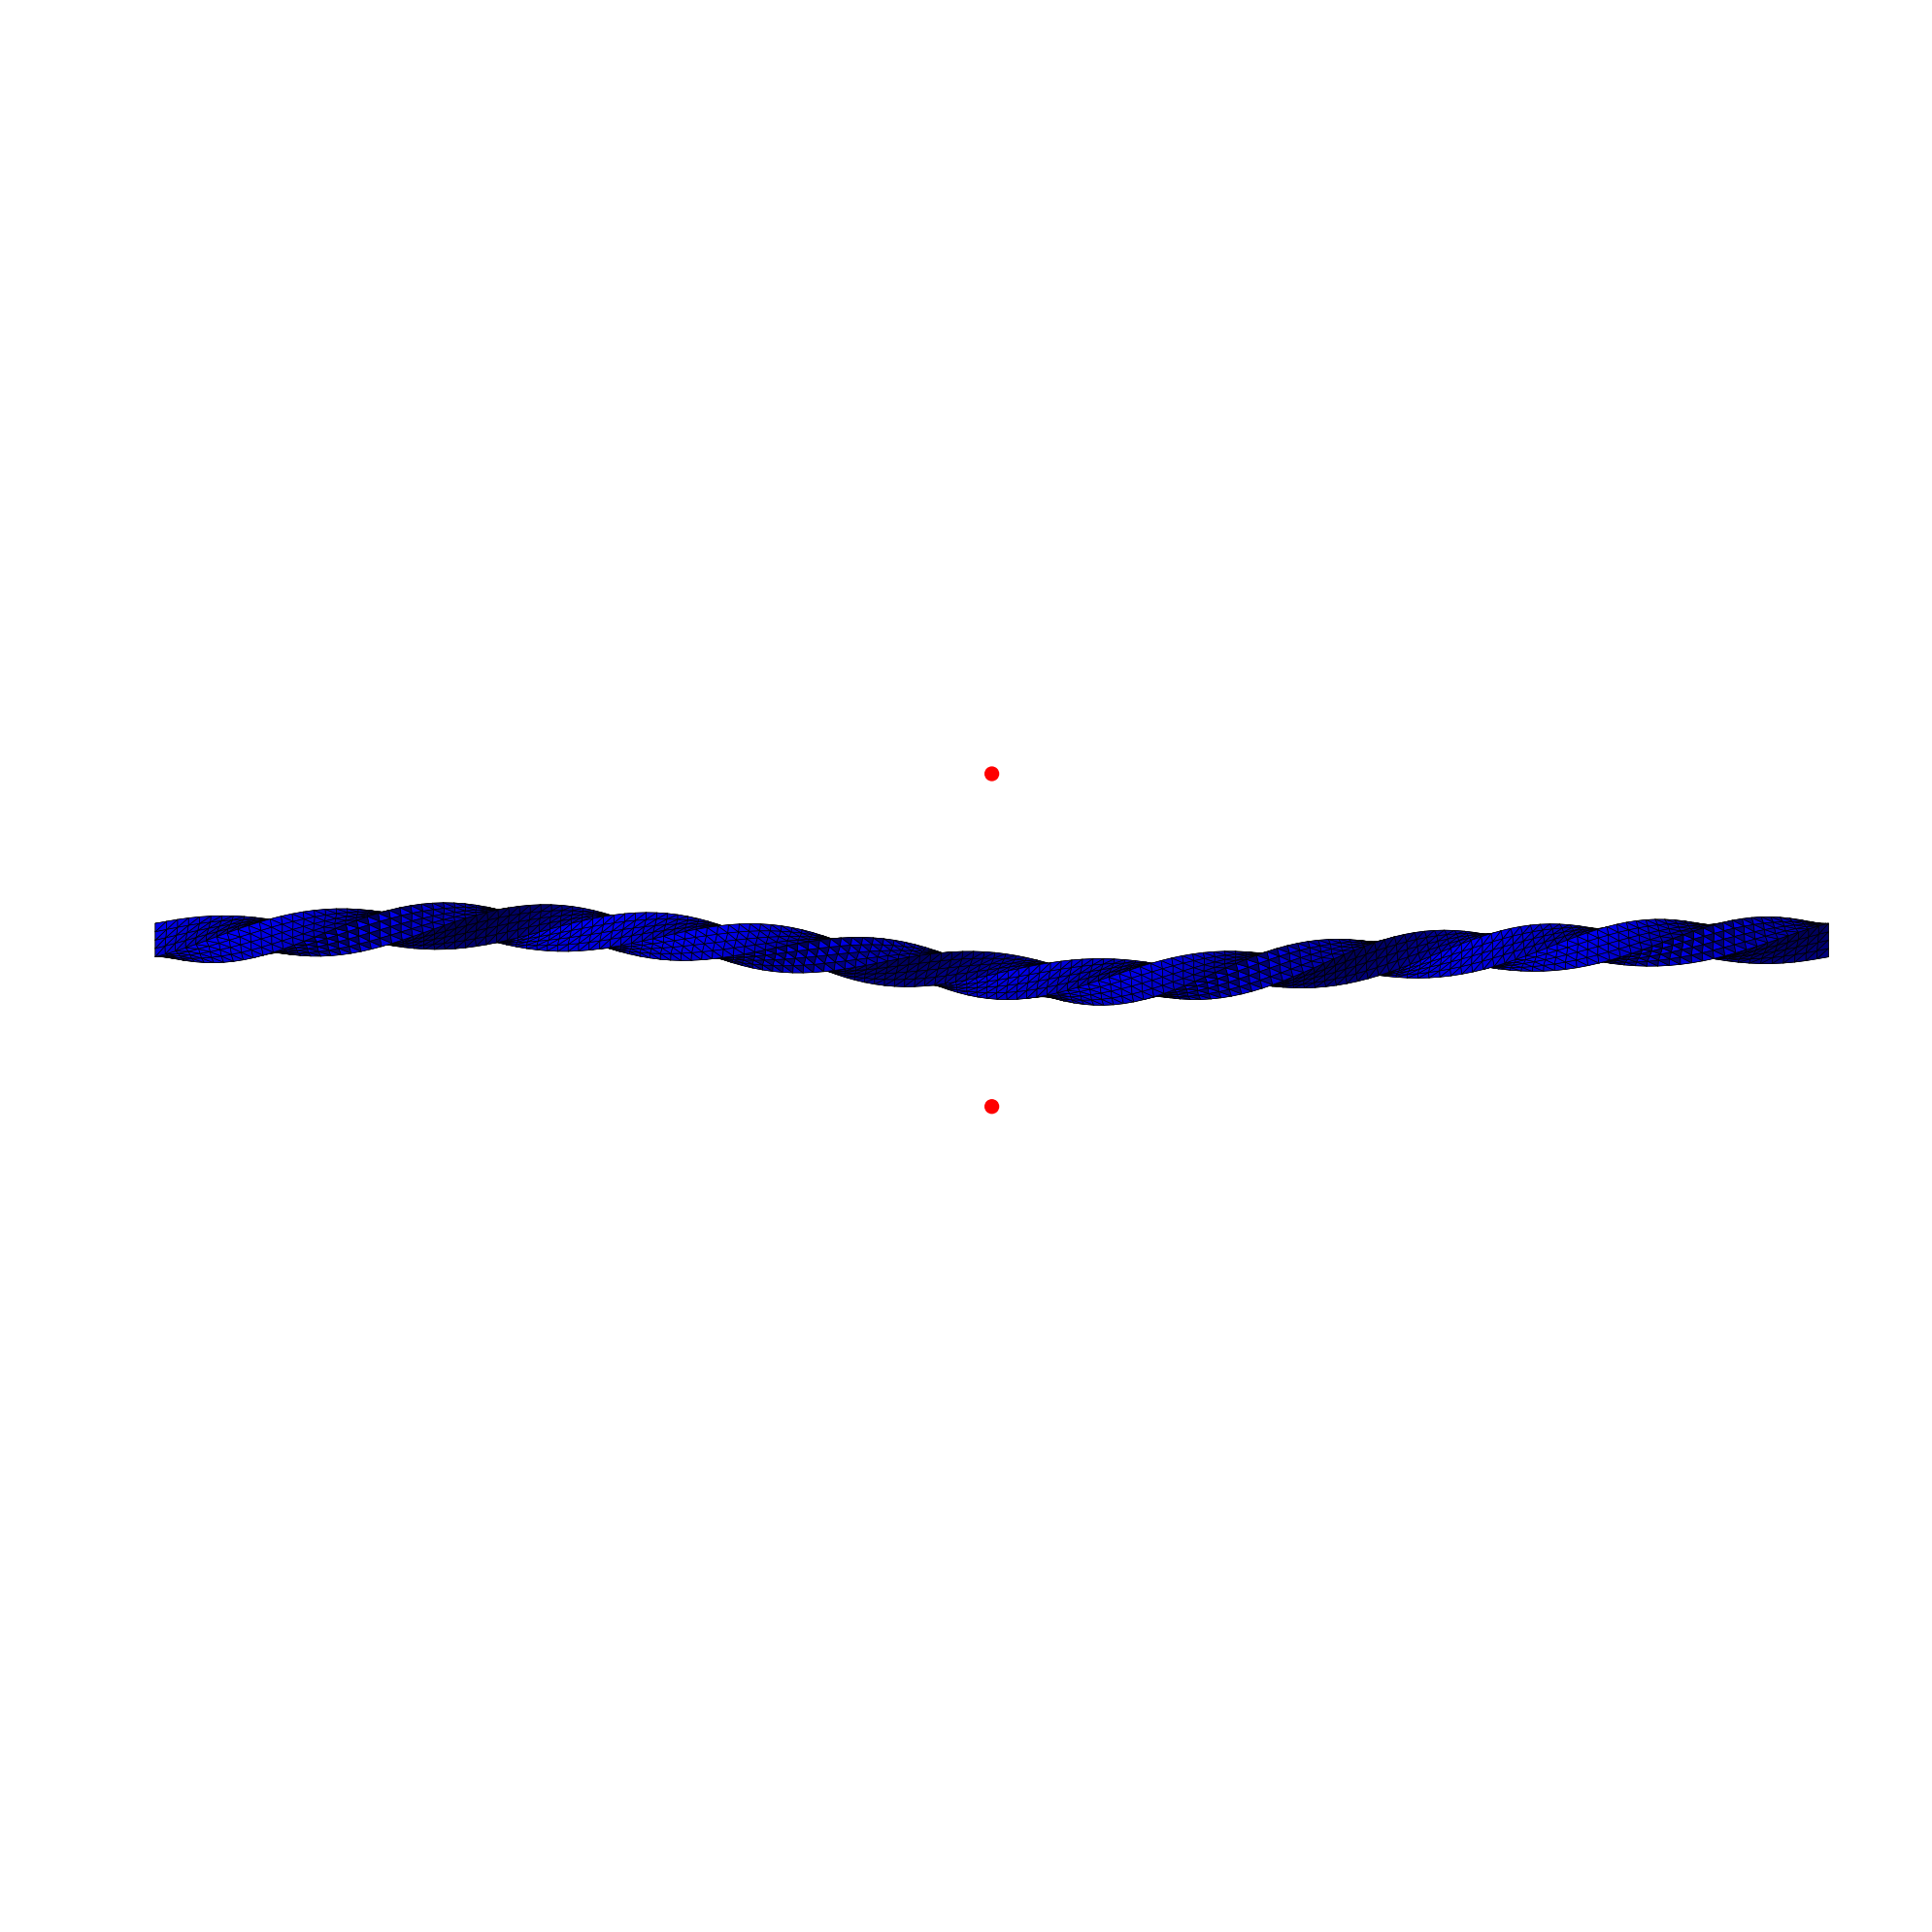

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 106.87934932312736
        x: [ 2.595e-03 -4.226e-03 ...  6.449e-03 -2.751e-03]
      nit: 2346
      jac: [-3.364e-03  9.885e-03 ... -5.333e-03 -3.776e-02]
     nfev: 2427
     njev: 2427
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


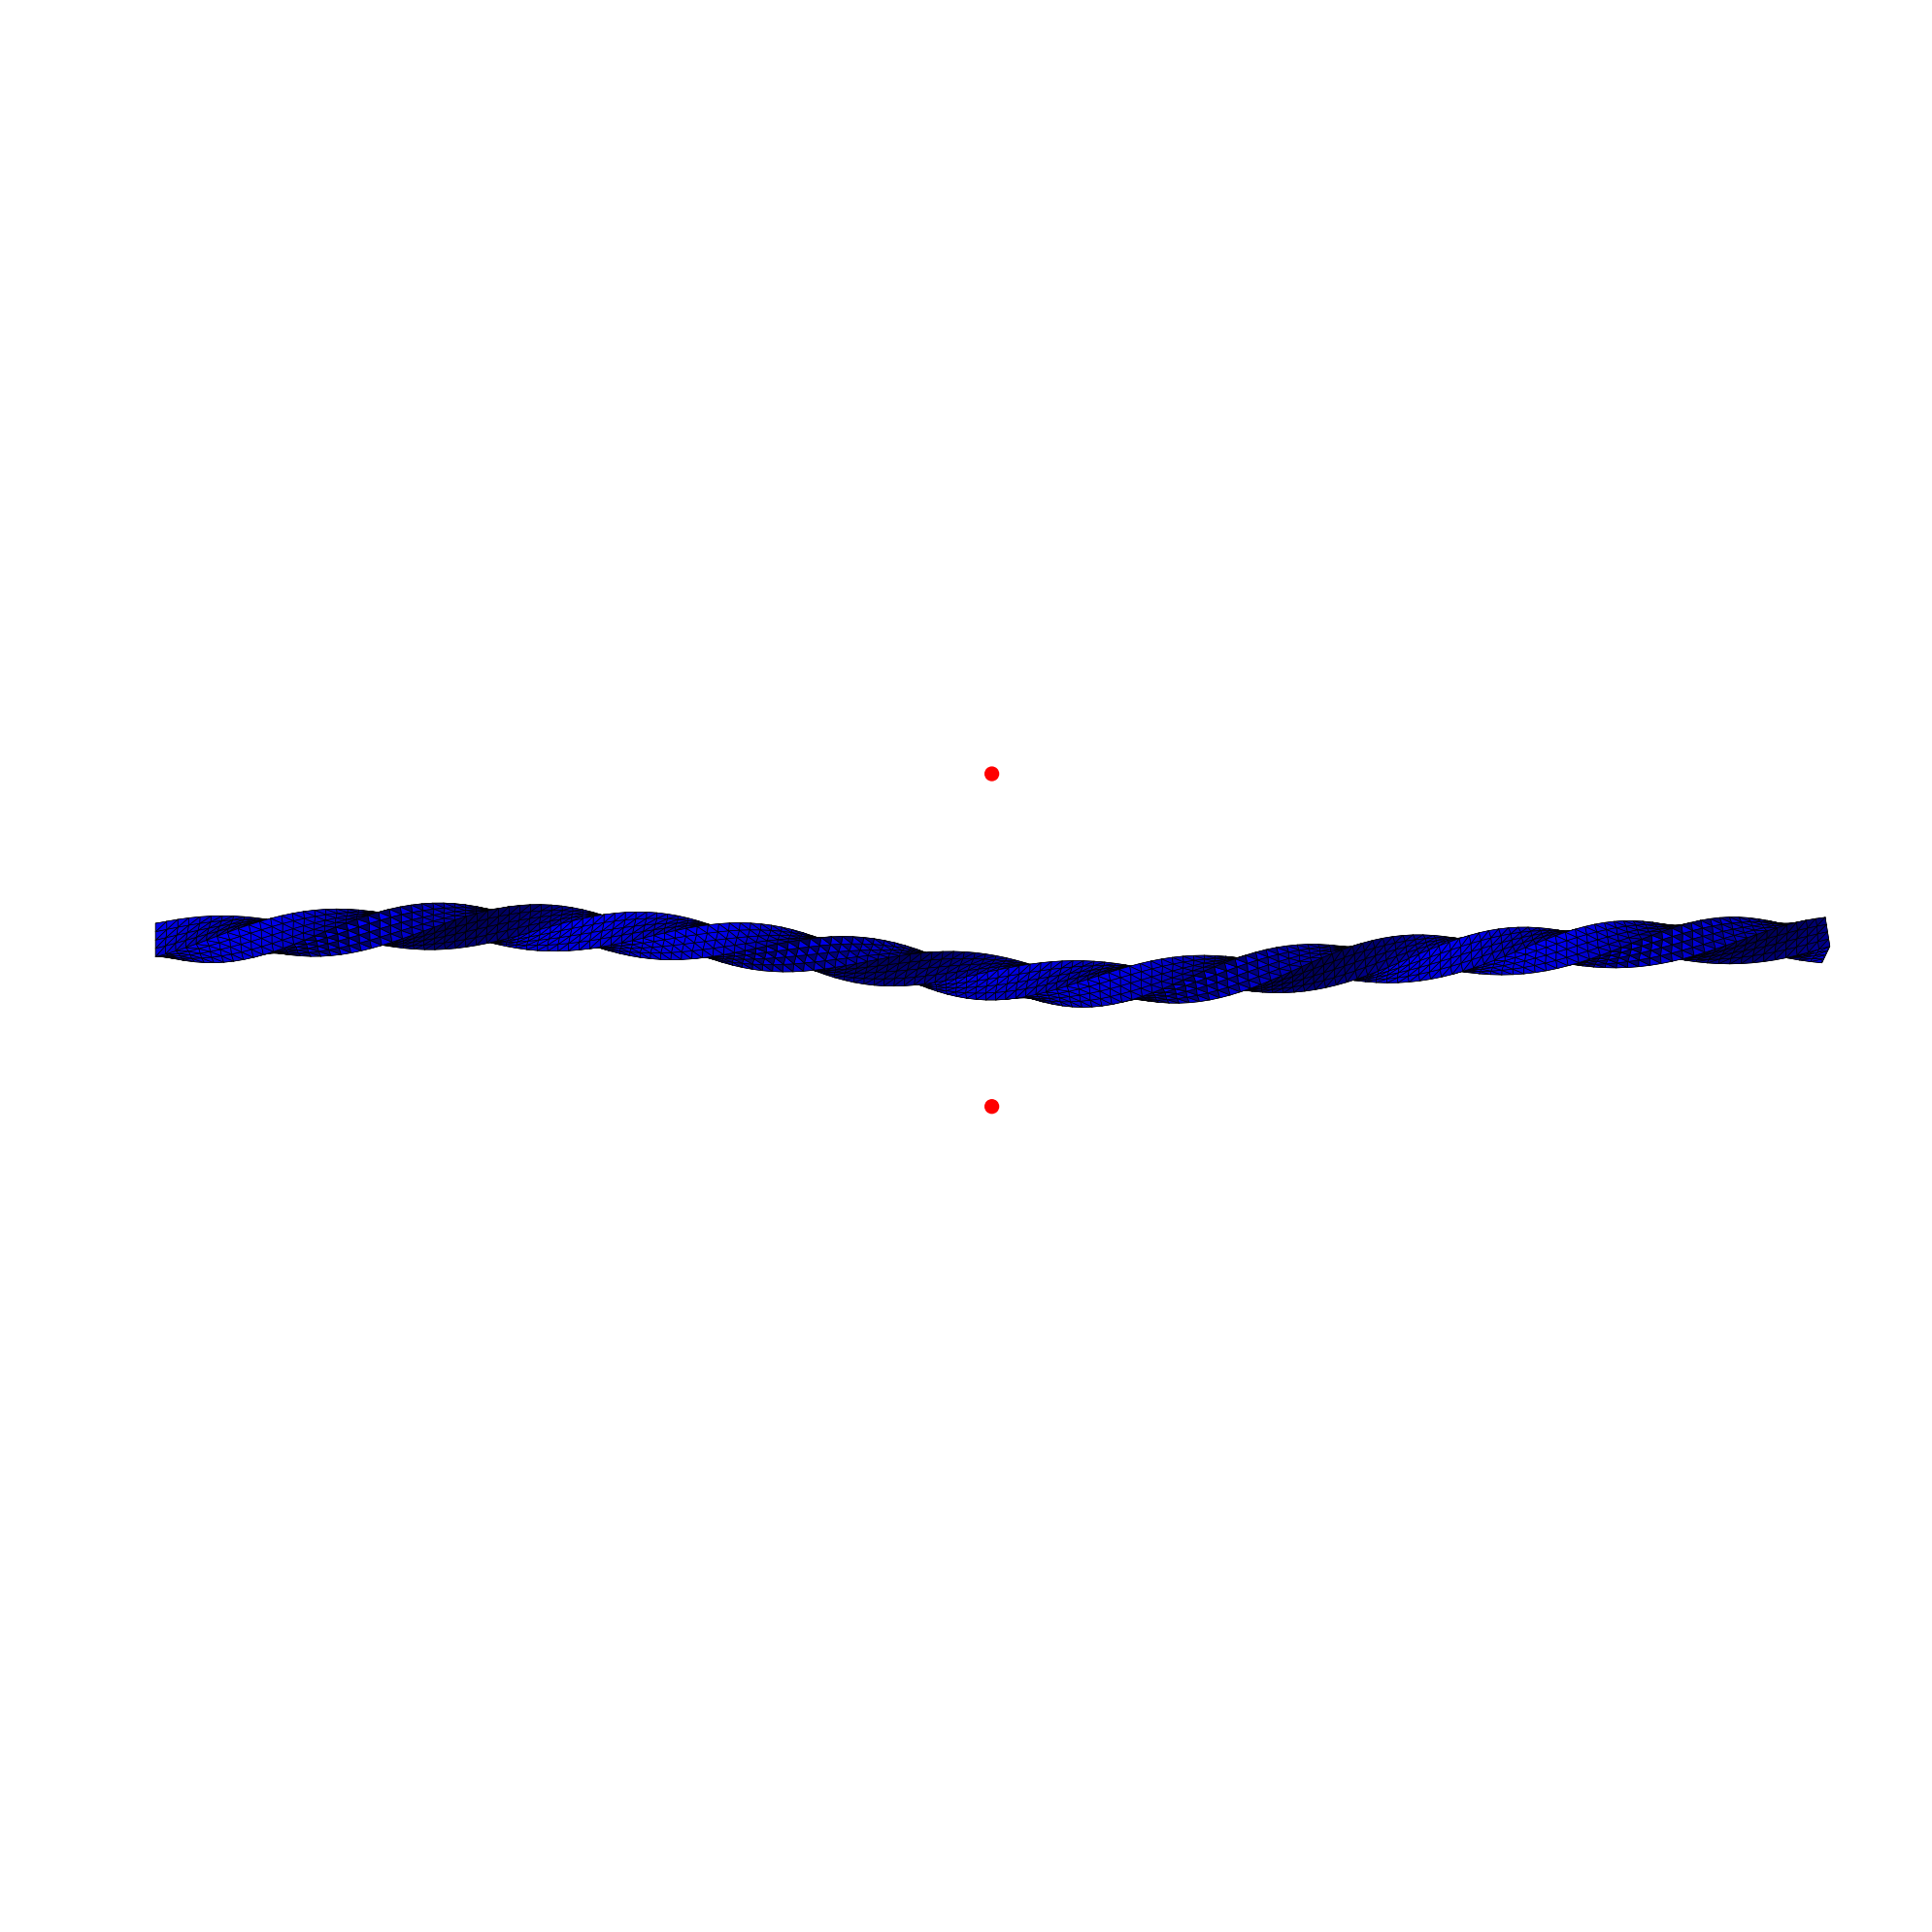

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 111.55294106150055
        x: [ 2.596e-03 -4.209e-03 ...  6.961e-03  8.221e-04]
      nit: 1423
      jac: [-1.958e-02  2.229e-02 ... -2.821e-03 -7.312e-03]
     nfev: 1472
     njev: 1472
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


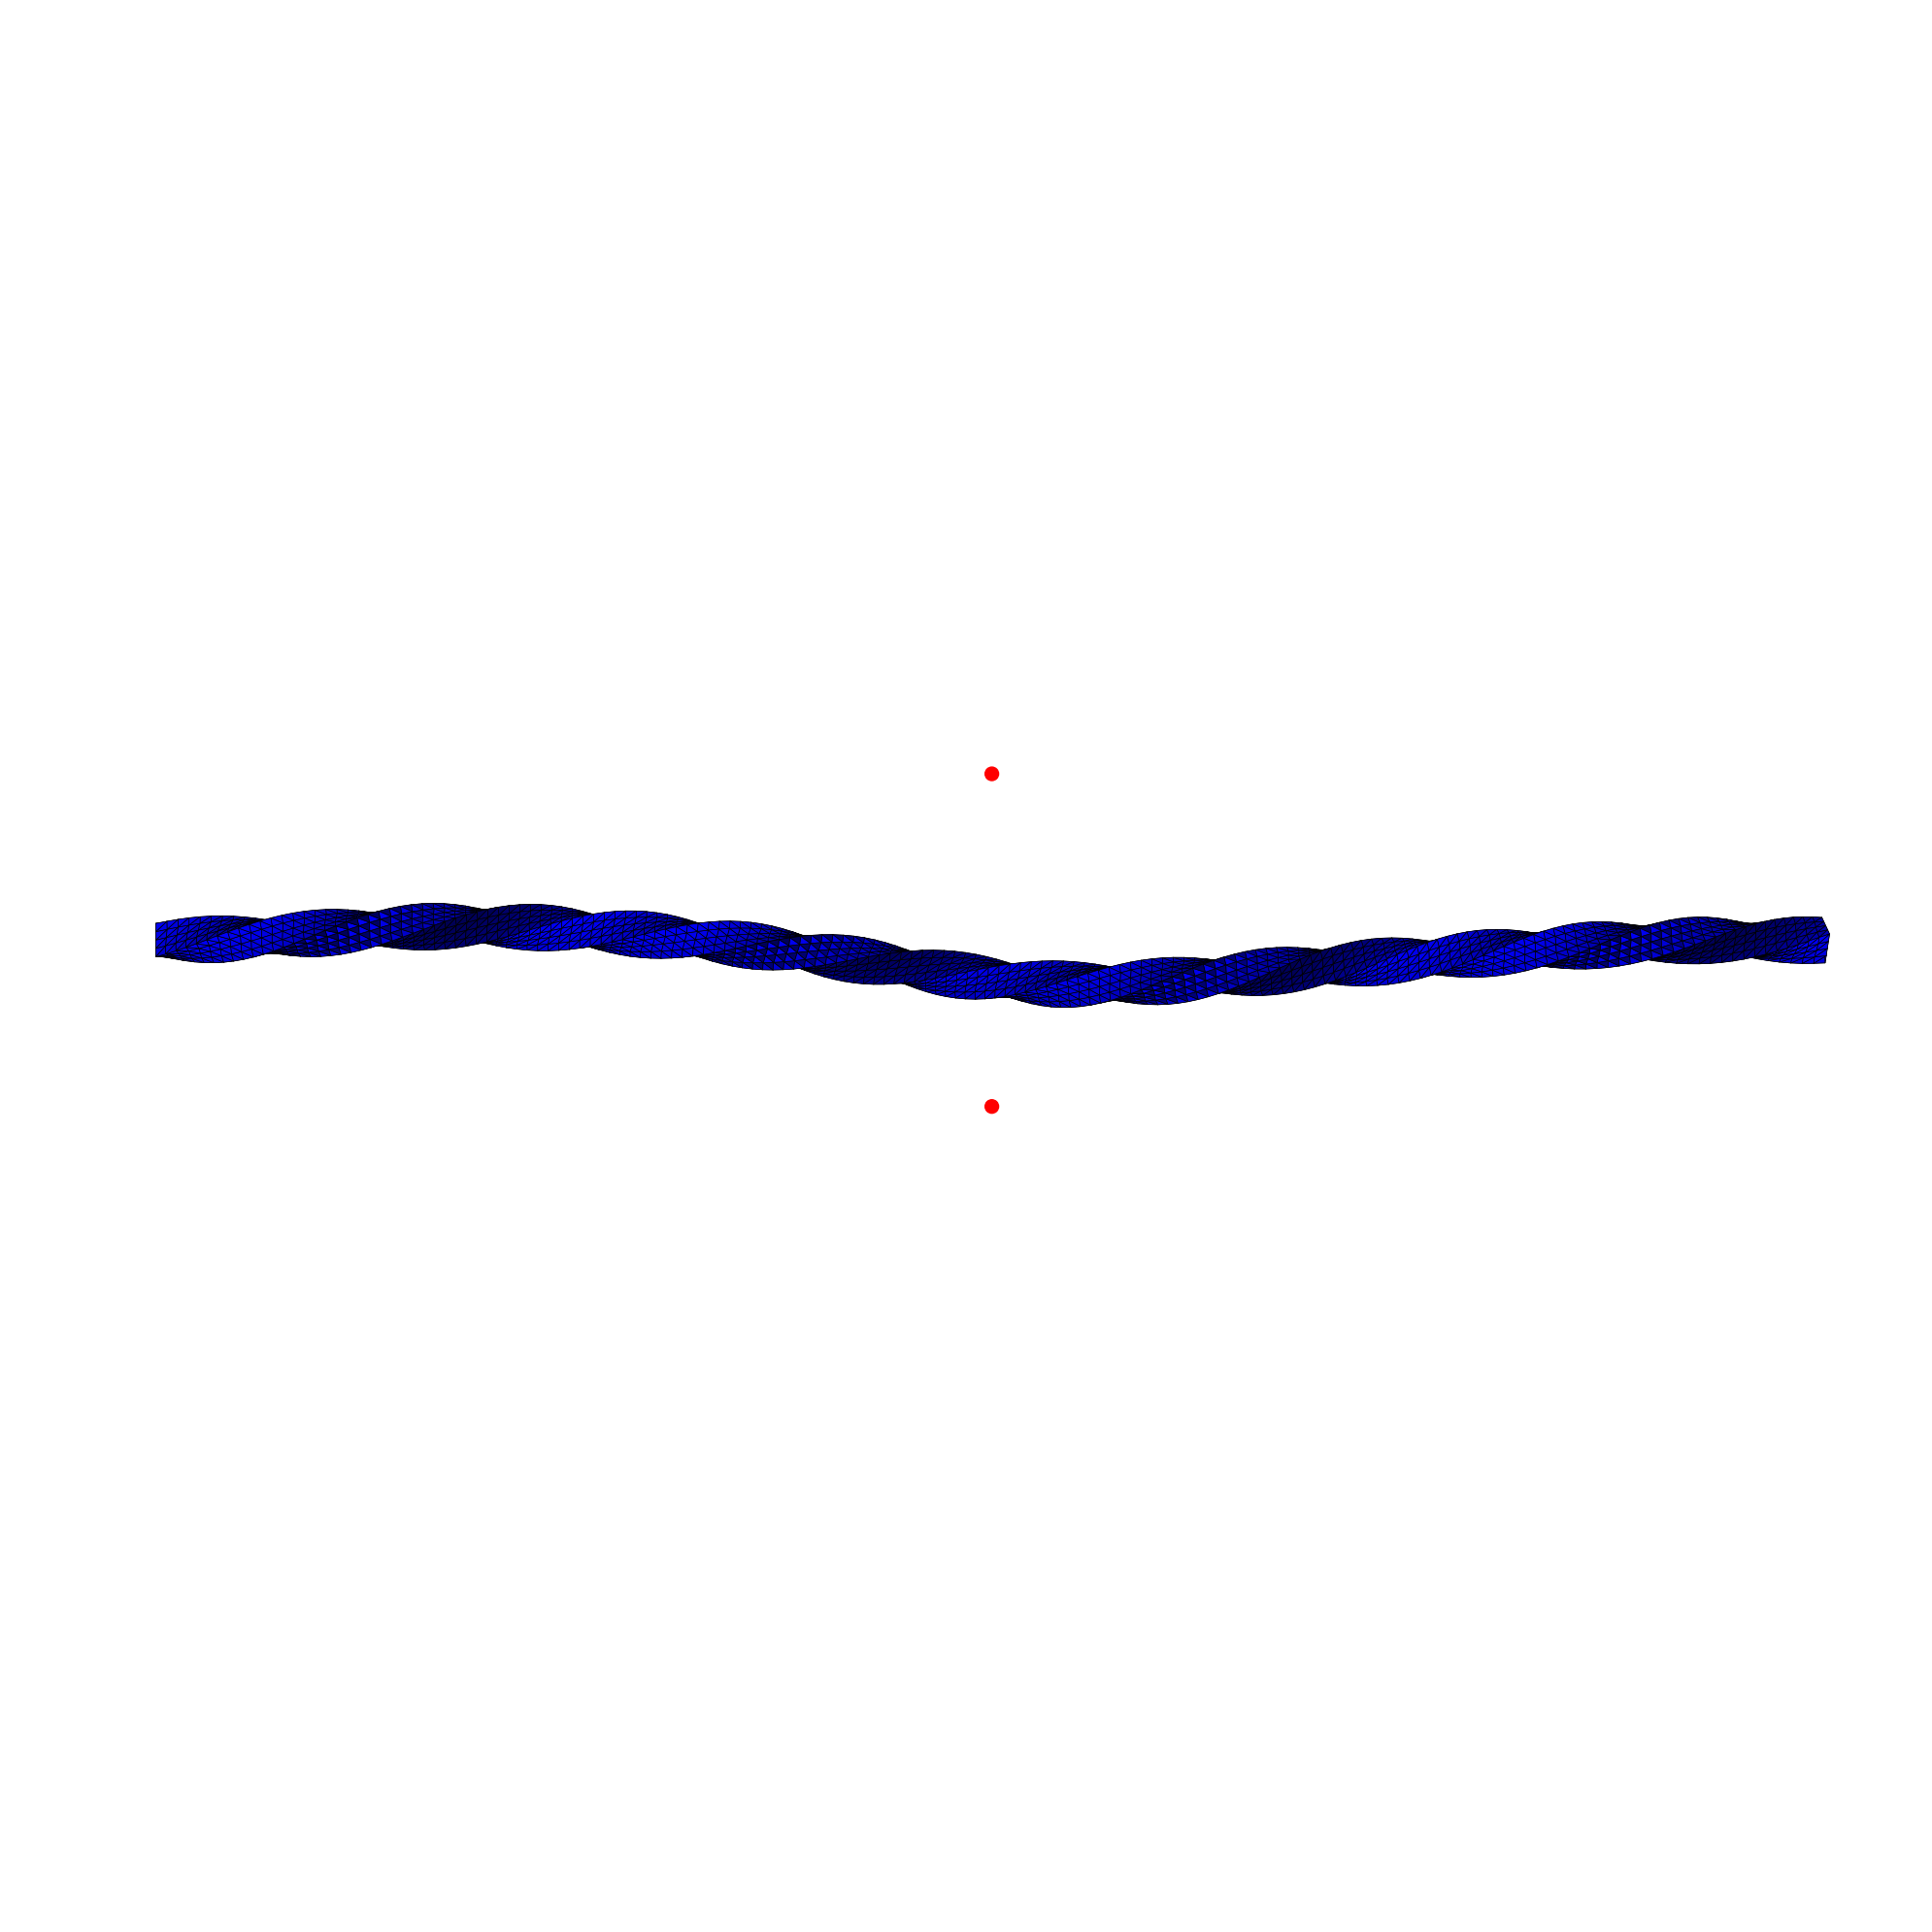

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 116.32376210347533
        x: [ 2.598e-03 -4.191e-03 ...  5.631e-03  4.177e-03]
      nit: 2395
      jac: [ 6.551e-03 -1.150e-02 ...  1.251e-02 -9.912e-03]
     nfev: 2481
     njev: 2481
 hess_inv: <11925x11925 LbfgsInvHessProduct with dtype=float64>


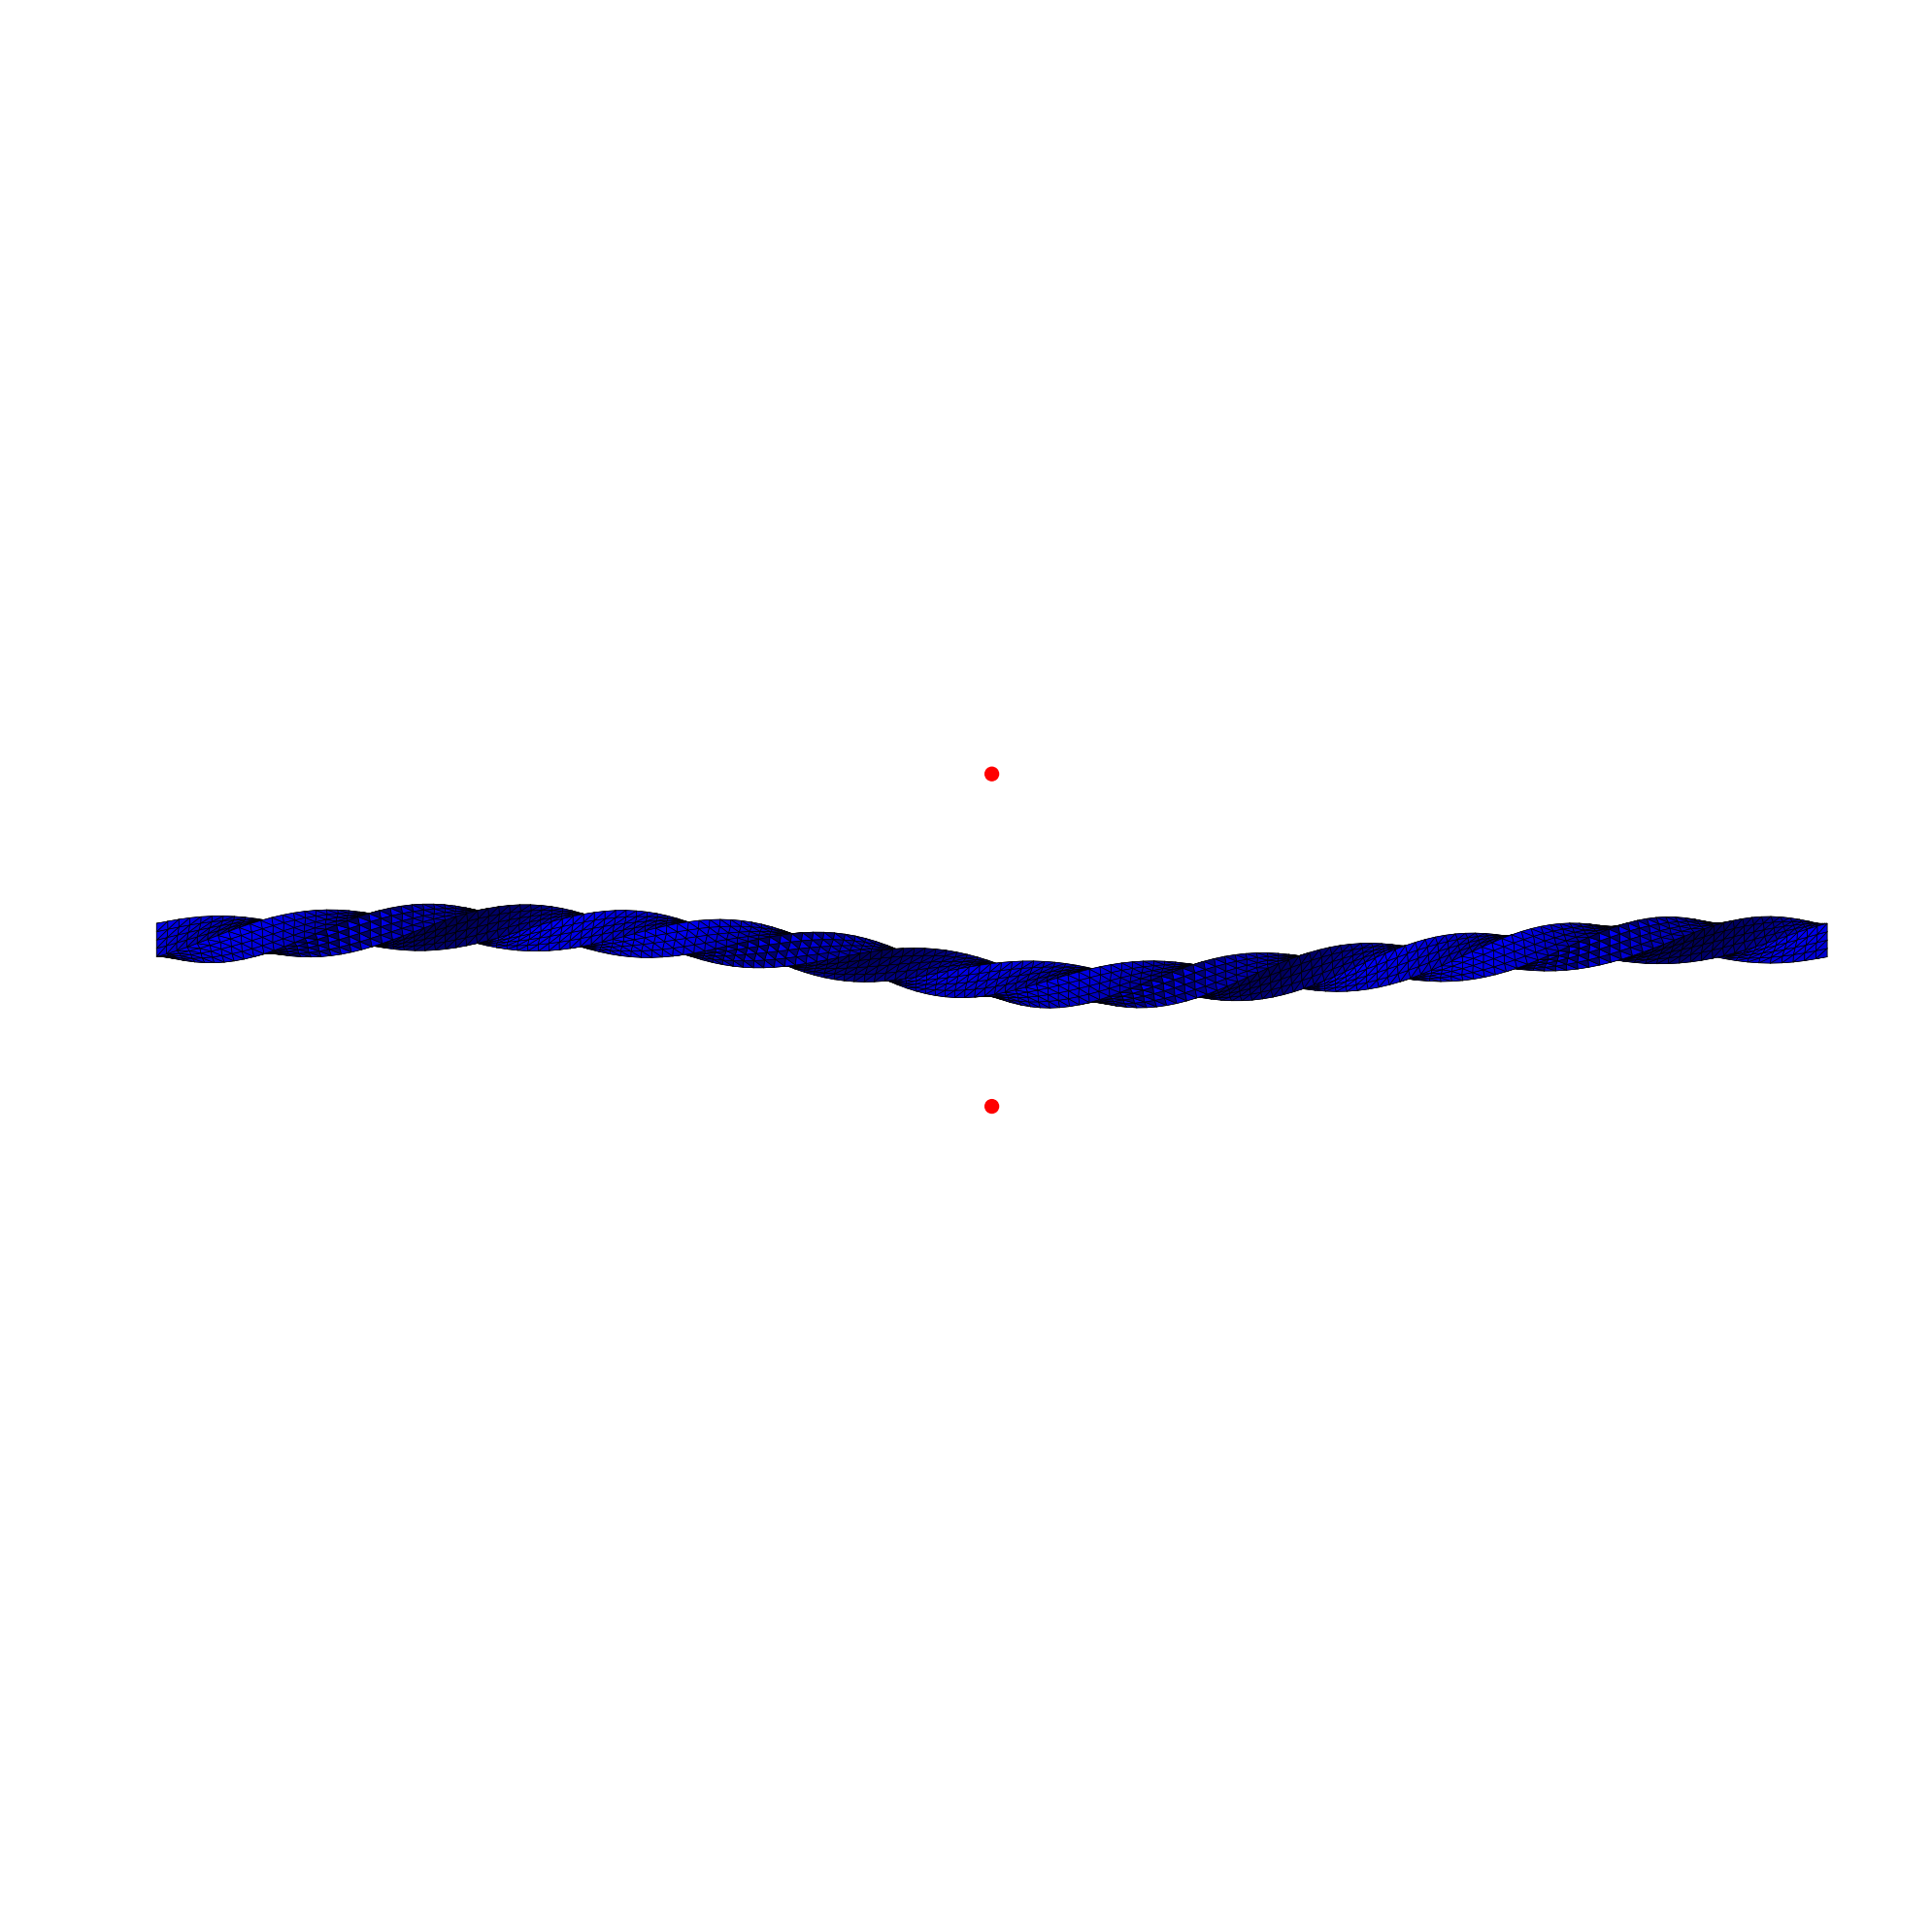

In [12]:
res_u = []

for ii in range(2,24*2+1):
    u0 = jnp.array(res).ravel()
    alpha =  - 1.047197551196598 * ii/2
    nodes = np.where(data.nodes2coord[:, 0] == data.lx)[0]
    u0 = u0.at[nodes * 3 + 1].set(np.cos(alpha) * data.nodes2coord[nodes, 1] + np.sin(alpha) * data.nodes2coord[nodes, 2])
    u0 = u0.at[nodes * 3 + 2].set(-np.sin(alpha) * data.nodes2coord[nodes, 1] + np.cos(alpha) * data.nodes2coord[nodes, 2])
    u = u0[dofsMinim]
    u_np = np.asfortranarray(np.array(u.ravel()))
    x = minimize(
        ff,
        np.asfortranarray(
            np.array(
                u.ravel())),
        jac=dff,
        method='L-BFGS-B',
        tol=1e-9)
    res = u0.at[dofsMinim].set(x.x)
    res_u.append(x.fun)
    
    print(x)
    
    # Create a 3D figure
    fig = plt.figure(figsize=(20, 20))
    ax: Axes3D = fig.add_subplot(projection='3d')  # type: ignore


    ax.view_init(elev=0, azim=90)

    # Plot the wire mesh
    ax.plot_trisurf(res[::3], res[1::3], res[2::3], triangles=data.bfaces2nodes,
                    color="b", edgecolor='k', linewidth=0.5, antialiased=True, shade=True)

    # The closest thing to "equal" scaling:
    # Scale the axes equally
    data_ranges = [np.ptp(a) for a in [res[::3], res[1::3], res[2::3]]]
    ax.scatter([0.2, 0.2], [0, 0],[0.05, -0.05], c='r', s=100)


    ax.set_box_aspect([0.4, 0.08, 0.08])  # Aspect ratio is 1:1:1
    ax.grid(False)
    # Hide the axes spines
    ax.set_axis_off()

    # Reduce whitespace around the plot and make the layout tight

    ax.set_xlim(ax.get_xlim()[::-1])

    plt.tight_layout()
    # Show the plot
    plt.show()
    # save the figere as png
    fig.savefig(f"figs/fig_{ii-1}.png")

In [ ]:
import cv2
import os
import glob

# Folder containing the PNG images
image_folder = 'figs'
video_name = 'output_video.avi'

images = glob.glob(os.path.join(image_folder, '*.png'))
#images.sort()  # Sort the images alphabetically

# Determine the width and height from the first image
frame = cv2.imread(images[0])
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter(video_name, fourcc, 30, (width, height))

for image in images:
    video.write(cv2.imread(image))

cv2.destroyAllWindows()
video.release()

print(f'Video {video_name} is created with {len(images)} frames at 30fps.')

[3.1173409418651135, 12.442297364307088, 27.899059926077832, 49.55016997075046, 77.38309295737038, 111.3265120605673, 151.4570201916141, 197.75399024202895]


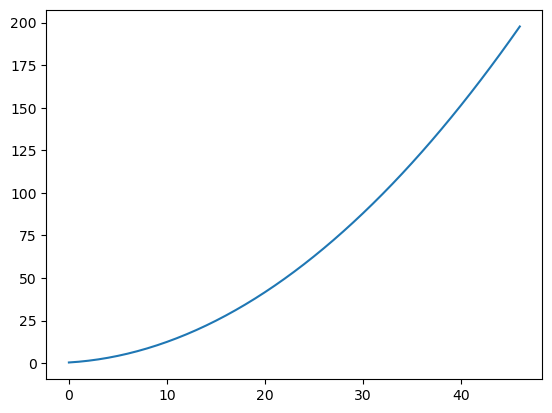

In [121]:
plt.plot(res_u)
print(res_u[4::6])

In [ ]:

# Create a 3D figure
fig = plt.figure(figsize=(20, 20))
ax: Axes3D = fig.add_subplot(projection='3d')  # type: ignore


ax.view_init(elev=0, azim=90)

# Plot the wire mesh
ax.plot_trisurf(res[::3], res[1::3], res[2::3], triangles=data.bfaces2nodes,
                color="b", edgecolor='k', linewidth=0.5, antialiased=True, shade=True)

# The closest thing to "equal" scaling:
# Scale the axes equally
data_ranges = [np.ptp(a) for a in [res[::3], res[1::3], res[2::3]]]
ax.set_box_aspect(data_ranges)  # Aspect ratio is 1:1:1

ax.grid(False)
# Hide the axes spines
ax.set_axis_off()

# Reduce whitespace around the plot and make the layout tight

ax.set_xlim(ax.get_xlim()[::-1])

plt.tight_layout()
# Show the plot
plt.show()
# save the figere as png


In [ ]:
data_ranges